In [37]:
import numpy as np
import pylink
import time
a = []
# Create a PyLink instance for the SEGGER J-Link debug probe
jlink = pylink.JLink()
k=0
su = 0 #to store the average value
positions = np.empty(( 2, 1)) #to store the posiitons
save = np.empty((1))
save_cir = np.empty((1)) #to store the cir values
save_tp = np.empty((1))  #to store the total power
save_fp = np.empty((1))  #to store the first path power
tr_n=0;
ind =0;
tria = [0]*3 #to store the trialateration values
# Connect to the target device
jlink.open()
jlink.connect("NRF52832_XXAA")

# Start the RTT viewer on the host computer
jlink.rtt_start()
i=0
flag=0
msg=''
# Set up a polling loop to read data from the RTT buffer
while 1:
    # Read any available data from the RTT buffer
    data = jlink.rtt_read(0,1024)

    
    # Convert the list to a bytes object
    data_bytes = bytes(data)
    
    #when cir is enabled , it is not a given that a single line will contain all cir values
    if data_bytes !=b'':
        d = data_bytes.decode('utf-8')
        
        if d.endswith('\n') and msg!='':
            d = msg+d
            flag=1
            msg=''
        elif d.endswith('\n') and msg=='':
            flag=1        
            
        elif msg=='':
            msg =d  
            flag=0
        elif msg!='':
            msg=msg+d
            flag=0
            
    if flag==1:
        lines = d.split('\n')
        flag=0
        for line in lines:
            if 'FAIL' in line:
                print('We have an error')
            elif 'SUCCESS' and 'RNG' in line:
                # Extract the relevant numbers from the line
                parts = line.split()
                success_index = parts.index('SUCCESS')
                try_index = parts.index('RNG')
                
                anch_num = parts[success_index-1]
                try_num = parts[try_index+1]
                bias_index = parts.index('bias')
                success_num = parts[bias_index+1]
                fp = int(parts[bias_index+3])
                tp = int(parts[bias_index+5])
                if try_num == tr_n:
                    ind = ind+1;
                else:
                    ind = 1;
                    tr_n = try_num
                
                
                    
                print(f'Try: {try_num} Anchor {anch_num} Success {int(success_num)}')
                #calculate average range values - for debugging
                su = su + int(success_num)
                k = k+1
                print(su/k)
                             
                
                #the index inside the tria array depend on the placement of the tags    
                if anch_num == "D09C->C7BA:": #c7ba,87b7 and dcb8 are anchors
                    tria[2] = int(success_num)
                    save = np.append(save,tria[2])
                    save_tp = np.append(save_tp,tp)
                    save_fp = np.append(save_fp,fp)
                elif anch_num == "D09C->87B7:":
                    tria[1] = int(success_num)
                elif anch_num == "D09C->DCB8:":
                    tria[0] = int(success_num)
                
                if ind==3: #we have exchange with three anchors
                    print("position ready to calculate")
                    print(tria)
                    a = ppos(tria[0],tria[1],tria[2])
                    positions = np.append(positions, a, axis=1)
                
                    
                    
                    
            
            elif 'CIR' in line:
                parts = line.split()
                n_index = parts.index('300')
                cir_in = parts[n_index+1]
                save_cir = np.append(save_cir,cir_in)
               
                #for debugging
                print(cir_in)
                print(len(cir_in))
       
        
    time.sleep(0.01)

We have an error
We have an error
Try: 1 Anchor D09C->C7BA: Success 184
184.0

6d00e3ff1100ecfff8ff06000f00f5fff3ff2e002b00dfff1700daff3e00d4ff3200a9ff2200f4ff4d00e0ff2500fbff3e0008005000eeff29002b001600100021005000dbff1e000a001e0037000d00f1ff3500d1ff24001a00efff1c0012004e00f1ff75002f00e4ff3600f4ff8200b5ffc60091ff22001200d8ff0f002d000300fdff7300e1ff9d00beff3500400017003000fcffe9ffd3ff2e003600bbff3200d9ff14002d00130003002f00a6fffaff1f000c00fcff07000a0016001a003400cbff1a00240016004f00f3ff1000bbffb0ffe5ffcaff280008006a0053002b00120046002000d4ffecff11000e00d2ffb700c8ff0900feffbfff3d0007007700d5ff18002900daffedffcaffaeff2b0026ff3400c7ff090022002f000b00030036006b000100daff8100a4ffe6ffb5ff46ff0d00aeff3b000f0008003d0040001600f5ff1d00150003003200fbfffaffb2ff17000200ecff300017002e007f0003004c002f00feff09000f001300230065001c0011003600edff5f004100890208017508ac02710d3308c00b37137e0796184a036b120ffe0d041ff6590208f0f6079ff7e60134064ff8560c66fd8201970abaf46f0e21fbdc00b807caf4590b0ff9db0060025cf94e023

Try: 6 Anchor D09C->C7BA: Success 170
173.16666666666666

1e004a00eaff05001a00d6ff3b00e9ffffffe7ffe9fffdfff6ff0900f4ff3100dcff2000cdff18000400fbff3500daffceffc7ff0600e5ff2500e2ff1900f0ff4200c0ff660015006f0034004c002b001e002d001500edffd7ffebffc7ff2600f9ff7000dbff4800feffe5ff0800e2ff0300d7ff36003f002f006600f9ff5300e6ff6100bdffecffc8fff5ff410013002700d2ff34002c000e006d001e00d7ffcdffffffd5ffc8ffdfff2e00360043006400470018001800aaff1200e2ff2600ebff3200f2ff3c000e00ffffe6ffbcffcbffcfff18003f00f8ff4900ceff4500caffe1ffe4ff2400eeff2f000d00e6fff5fff2ff270009001b00190009004b00e6ff4500c3ffa0ffdaffc3fff0ff070018001100d7fffffffbffcaff1900b4ff0800a9ff1800d4ffe8ff04003300d6ff6e00faff9200140034005600d5ff0d00fdffb0ffe4ffcdff0a00e7ffdfffb7ff1d00ebff28001c004200ffff0100d1ff1b008eff7b000d006500f4ff7100c1ff10001f0057001f00230020000b00370067000f000b00cfff4400110067011100d6054fff350c85ffe6113b064c144b1058116410f1055108adfc1807e2f80e1295fad710bffdf2fd4f02aef0ce01b0fe57fb2710fdf8f10c04fe78fd5d02e9f4310019fcb8fcce

d7ff1b00ffff3b0026003800f1ffdeff0c00c8fff9fff1ff4100edff370018003900ffff11005800f5ff2e00f0ff4f004a00f7ff32004500e2ff1e00b8ff4c00c3ff4200b7ff31000d001000570004003e00cbffcbffdfff1f0048003f005300ecff1e00ffff0c00bbff39000600bbff0e00a3ff3300c2ff4b00f8ff44002d000400240004000e0005000c000900e7fff2ff02005d00feff190038001b002500f5ff0400e0ffe1fffffff4ffd6ff060006001600eaff2c0010000000370028003d001200efff1d0077ffeffff8fffbff3700d2ff3500beff3200290015001f00f5ff19000100fefffeffb1ff5100b2ff1f00c1ff3c00d2ff4100cdff3c00070026005200090003001d003400f8ff16006100dcff490055000600d5ff0f004300f0ff3a00f5ff0500c7ffeaff5900b9ff4a003500eeffd1ff19002c001f0047000b006400ffff2f00beff2100c6ff5100e2ff3a00beff3000f8ff25002a007b00d7ff0400e3ff1e0015005d00edff19000400dcfff9ff0100ddff5e008ffeb60131fdc906eafa380a1ff5ec0a52ed3a0b91ef8b077ff9dcfe3afc67f550f723eca8fcbcf15708e805ac0985132afd4807d0f2acf2f2f4e2ee89fe53fe0005c4089f051503a004c8f98402cff9270043ffc1fe630165fe82fe49ffd7fc1a01bcfe2a010a00550053fd9300a9fb8d0016fe05015201

Try: 14 Anchor D09C->C7BA: Success 153
165.78571428571428

21003400270025002200ecfff5ff2e004d00efff1100dbff3a00e4ff5e00ddff3e0056006f004d002700490037002100f6ff1600deff3500e0ff270093ff2600deff5c000500f5ff3d0024000a002700eeff7a000200f0ff4b0009002e00f2ff0a00fdffb1ff2e00d8ffe7ff1d00d3ffefffdbff2a002100faffe5ff530003001700deffcdfffbff2400ecff39000e006700e6ff2a000e00fdff2500f8ff2b002b0020004100f8ff39000300d1ff0400d2fff6ff040020006500e4ff2b00efffe5ff15009dff1500c7ff03000f00f9ffe1ffd1ff0500f3ffe2ff10002e00d2ff3f00d6fff2ff94ff3300c1fffcffb0ff0300ecffffff1900180013003f001700ffff09005a0021009c001d003700edff6f000b002500060055001800460002001d005a0006004200e6ff06003800d6ff1400f4ff130031004700730035006f000c000200ebff0b000d004000f6ff2a0041003e00f5ff410017002a0029002d002f00280032002700ceff4d0020003600a9ffd7ffa8fff8ff5dff63013afe2a06acfd260cfaf7fb0cd3ef130a03f225065ffeba02300190fd0bf4b1f424ebfef24cfcacfdb20eb80aba051007def2f0faa8f1a8f8d2ff1003230818092e02a100f9fccbf6f4feebf544034cfb64011cfe0ffc7efb39fc8

Try: 18 Anchor D09C->C7BA: Success 180
163.77777777777777

050006001d00e4fffffff7fffbffebff2500c1ff42002e000e003000c2ff2600e0fff7ffdaff1900f0ffedfffdff0800f9ffe5ff5400baff4a000a000c002f002f00fdff1500bcff2c00e6ff7500e2ff5f001d00fefffdffe9ff07001000c4ffc3ffbaff3100e9ff3300f4ff1c000a00060024000b004d0019002c0018003b00e7fff1fff2fffeffdcfff8ff0a003f007d00280069003500f3ff3700c3ff2b00fbff0600dcffe9ff1d00dcffdfff1b00cdff1300afff1700e5ff2b000900a7ff0d00cbffffff1d00d5ffd8ff0c00d3ff460039002d000500e5fff5ffd6ff1300e1ffdbff2a00c7fffaffeeffedfff2ff25002f0020005c00f9ff2300dcff6400b5ff0000beff2900d3ff0100f2ff0f00e2ffd9fff2ff0c00adff1d00dffffcff2900f5fffeffbdffffff20004000e3ff4c000c000e002600b4ffdfff0e00f0ff2200f4ff360051001f00f2ff1100cfff280092ff3900a7ffe9ff9aff270082ff480005006500e0ff1800d9ff0700effffcff55002100d8ff4200dcfff8ff1800c9ff0800b9000000ce02edfd2c06ddf94e0c91f95715e402201a1a09710eb703fdfdcdfea6fa690a17036f14b1020206b5fa7ff168fa81f12d02b004e008f6114d046805fffd7ef62bfcb0f8d8fdb20204fe0b06ccfc2

Try: 22 Anchor D09C->C7BA: Success 169
164.77272727272728

ffff0a000a004600f4ff32002f00f1ff1100e6ff4800feff2b002a0037000b004600e9ff2e0047000d004500f3ff4600ebff3a0046003c004600140039002700ddff0100d4ff2100d2fff2ff1900f3ff60001c0056001f00e1ff1f00d9ff3b0004000400e4ffffffdfff24001500d2ff3600beff2100deffeffffaff2200e5ff7a00340055001400e4ff14002f00ebfffcffe1ff37001200700038002f0011000400ecff0a00deffe1ffdbfff8ffe2ff0d002100100011003c00ebff4800000024000d00fbff2d00ceff4d000e000b007d00b9ff1e00c4ffdcff1e00f2ff0300e4ff06000a00eafff5ffe1ffecffc0ff97ffa7ff2f000b00340025001500010066001800fbffefff22001800460038003a003400790043007c00daff49001000f7ff3200a9ff0200c9ff000020000f005d002a003900e3ffdcffd0ffdeffc5ff2d002400fdff4400ebff3c0017000e00cd0007001100250005004c0001004f00fdff260001001d0023001c00f2ff2000cbff210021001800a7ff45002bff86014efe7406cdfb850b0df39c0a18e72506f0ea6904c3fb7202f901cbfb5ef601f388f30ef474056000bb0db10828005b0368f2c9f9b6f62bf81e04e2ff16096d040e0351ff21ff41fad0ff56fb98003cff26fe74ff33fbb

Try: 27 Anchor D09C->C7BA: Success 167
164.2962962962963

0f0047001b000d000e0008000d00ddff1b00fbfff1ffe5ff3c00160031000f0042001f008400240028001d000f001800f3ff1600fcff6f001400100018000800faff100096ff0b0007004900050010004d0014005500e7ff0d003e00ffff170027001b000700e8ffc9ffd8ff90ff2100e5ffadfffeff8aff5900ecff560016003a000d008b00380020002c0082ffe7ffdbfffcff44001f0077001e0058000c0018001000f4ff18001400f7ff3400beff3300c9ff1200f7ff0600f9ff3100270035001a0055002600d7ff4700b3ffd1ff1200e5ff6600d9ff0c000100d3fffcfff6ff6000d2ffe7ff1f0082ff2500e1fff6ffd9ffa8ffabff3700b8ff3500b7ff1e00fdff6c0048001c003300f3ff2b0010004d008200400051004000840001003d00f0ffd4ff6b00b0ff6300160037001a00ffff65001100fefffcffeafff7ff54004e00d9ff5f00d4ff3f00faff8800230077004f004800c5ffffffefff2100c7ff3700ebffdfffd9ff210011002900d8ff0500a8ff39000400e4ff8cfffbffc3fe0b019dfcb6042df995072beec10493e4d4ff48e7570225fb5503ea027afa03f832ecc8f239efddff4802c40935100601530467f64bf41dfa09f7d9046d031608d10832029d016d003afcb202a4fccf02630062017d

Try: 32 Anchor D09C->C7BA: Success 157
166.21875

9b00f2ff0e0017004c003200fcff2900f0ffe8ff0200e9fff7ffcffff2ffa6ff4100e3ff5600dbff4b002a008a00150018000d003f000e005800f2ff2600530096003b006d004d0025003800a0ff0f005c00e0fffeff2d00edff0b00fffffcff510021003e003000cfff2f00c2ff6e0005000400e8ff0900dfffbbffedff9dff4500fdff5c000200f7ffdaffebff0d00f2ffbaff4100dcff6f000f0012002200e5ff0c00deff0e0022004400d2ffeeffeefffeff2500b1ffd4ffbcffdcff95ff1900f3ff2f003f009fff1a00cbff230024002600f2ff26004000f3ff0f00060007002a00d3ff1900bbfff4ffd7ff5300a7ff0800fcff1a002800ebfff4ffacff3500f5ff3900daff63001a00ebffb2ffe8ffa5ffcfffe1ffe6ffcaffeffff2ff1100f1ff1c007400f8ffecffe6ffb4fff6ff3200e3ff14003400c9ff57000b006c0043005a002c002a005300d1ff78ffffffefff4800caff15005f0001006a004c00290036001e00420025004f008f00f5ff6500edff5800b700c600aa020502f1088603690c320aee0c7312d60dc1114c086004defb44ff49e9b10579e40d08dcf1ccfc57044bf9ec07ba04eeffd010dcfb1709fd0037fbf4027cf3c2fe82fb10fa480181fcbeffac01c8fc0b02b2fea4fb8b02fff75b0239fac9

Try: 36 Anchor D09C->C7BA: Success 158
166.91666666666666

f2ffdeff15000800e1ff11000d000000fcff0500ecff2100f0ff4000e3fffbffe9ffedfff1ffcafffdffbeff5700f5ff2f00f2ff3f002500600011002900160000005d001b0019002000450038004300a5002e000200ddffbeff12005500050032000a003800f5ff0300dcff4c0007005e004800fdff5100f2ff2300deffe0fff6ffc6ffedff050041009cff3600290023001a00a3ffefffbcff0500feffedffe4ff0f000000ffff0c0012000c00130012000f00deff1f00efff33001e00fdff5600cbff0000b5fff7ffbffff9ff0f0026005700d0ff4000d7ffd2ff17000700080012004000d9ff4000ffffcaffffffd8ff0300dbffe4fffbfffbfff3ffb7ffedffd5ff3200eaff1800d3ff46001c00050018002c0006000a00c0fffdffcdfff9ff96ff1e00c3ff1b00e8ff3800020017004500e5ffe3fff4ff9efffeffe7ff120022002b000300360031005e0007009f0023004a00f6fff2ffc0ff160034005b00e9ff3e00260023001e00610008001c003f004600790005003a000100fbfff1ff6200e3002b011e03a902db097f05400e7c0cc30d3b149d0c6f1269052004d8f88afc00e78100dde35001d8f013fba00155fcab052a0748fe400e09fdb104fc01a5f89d02f3f587fe39fd81fa0a01fafcb5ff8b01a

Try: 41 Anchor D09C->C7BA: Success 145
166.97560975609755

5300200003001200fdff4c003400ffff3d00daff6000efff0a004500ecff21001700faff5400fdff34000400250018003b003a00fcff6700ecff7500e5ff58000c0017001c002800f3ff0e00c5ff07007dff5a00b9ff4b00edffe6ff01000100c8ff1a00e5ff1e00faff670021000d003b00220012004000060012000e00b0ff250002001400e4ff1d000b0040000c003f0055003f004f00fbfff3ff190018005e002d0045002d000b001400e4ff1000ebffd0ff09000d000a00b6fff2ff050021000d0047000e006900e8ff9a00d4ff5b00f9fffaff2b00ebfffffff5ffa8ff0300beff2e00f5ff02002a001b0012001400e9ff3a0012001800b4ff2e00d9ff5c00cbff2200edff26001a000800300052006c000300f0fff1ff2f0015004f002800edff600048005700f1ff19000800b4ffe4ff0100e9ff0a00caff3500c0ff2d003c000000f3ffcaff1400d3ff4900daff8400e8ff29002f000000e4ff1b00c9ff0300e6ffcbff0b000600dfff3b00dfff1000e5ff0200f0ff3400c0ff150008000500f3ffb0ff4fff3400aefe030199fc5b059af9df0853f098080fe81708a2ef5d07f8ffc6ff5d02a5ee92f7cfe46af415ec9afd29037b04a31383fff6072cfbfcf7c500e4f7580808ff6406b2ff2f0161fb9eff4

Try: 45 Anchor D09C->C7BA: Success 177
167.33333333333334

fcff50000e002900ebffc7ff3300f6ff380000000d00faff4800f4ffd0fffcffccffe1ff0600fbff1b001b005000e9ff4600feffd7ffeaff0100faff3200ffff37001e000b00020032001300700012005500470032004f00ddffffff1300bbffeffffcff5a003b00faff3100ecffccff0100d5ffebff1300e4ff6000b7ff1500b7ff1b00b4fffdffeeffc7ff1e00feff4900e8ff4600feff1e006b00b4ff3700e6ffe6ff2a00f6ff0b00150008000b002a003b002f0000000d00d0ff0700c8ffecff0b00eeffeeffffff35001600eaff7000d5ff60005500e2ff8400e8ff0b002000b9fff2ff0400030015001c00280015002b00a8fff2ffadfff3ffcfff4200bbffc100ecff1900feff8cffedffb2ff2d00d3ff2000f7ff2400140030000300fbff7bff1700afff300016003200d0ff3f00f1ffd8ff30000b005300d4ff14001e0086ff2b00c1ff22001100d3ff2a0026000d003100640050002600620030005c0072ff8b00f9ff15008d0000005f0052000f000b00aeffccffdbff05002c00e8ffc200ecff20002e0080ffd7002a0087039d019c0726043607130b8d01aa174d00b81ae3035910a1005805dff89d0533f8f00be3047e05a713b2f81e0c05fdc3f8f708b3edab0f8cfb9406a00a1afc6209f6f9b5fe4

Try: 49 Anchor D09C->C7BA: Success 179
168.6326530612245

0c001800dffff5ff08000500edffdcff21001900feffe9ff2d00e3ff3000dfff300024002f004600ecff0a001600490052002400f9ffdfffb3fffeffa4ff5800b3ff6900e0ff200015001f00f7ff89ffe5ffe8ff2a00ecff430007007a00eeffceff3e00e8ff360097ffd2ffc8ffa8ff5800e8ff2a003400f0ffebff0100120034001d000000faff2200e6ff2200ccff22001a0009000c00eafffcffe7ff29001500cbfffbffb1fff9ffc2fff0ffe2ffbbffdaff0500e4ff6b003400800045000c005900a5ff16002100b2ff4200d3fff6ffc4ff0c000800090036002d002d00180049000200eaffb1ff0a00acffe2ff4300c1ff7200e7ff2100d7fff5ff3d00fffffeff50003400af00c3ff8f00f7ff6a0042000500b1ff6a001a0001003500e0ff8300c4ffcbff5000cbff6f000b0013002800c7ff0d0098ff2600fcff4d001a00090003005400caff61002300e8ffceff0800ebffddffcaff5500fffff4ffd4ff31001d00f1ffd2ff0a00e7ff2e004a00f1ff0a004e00edfea100ccfc4c041ff9f408b0f16c0ac4e9b607bbeafb058bf68a0191ff60f903005dea1b024ee9910817fb86080e102bfcef0a90f24af86bf5feeeb8ff9ffb51069f0612059902bc0366fb0f03f9fa8602c500190135039a0026008c0056

Try: 54 Anchor D09C->C7BA: Success 196
170.22222222222223

eeff1200070017000d0013001f000f000100260008008500f5ff4900d6ff3700e5ff5200edff2e00e3fff3fff1ffabfffaffadfffdffd1ff5500f1fffaff10003900e1ff3900a7ff4000a7ff510009000b00200014001500daffe3ffcbffa4ffc4ff0b001f00c8fffcffe2ff8800d7ffb20013002e008700b3ff3d00f8ff6400d7ff19001600efff4c00dcff24002600f1fffcfff0ff0c00e2ff30000900ddfffcfff1fffcff6e00f3ff690009005500f7ff56003f0031002b00460090ff0900b4ffdeff1400d0ff3c00bfff39003b00f8ff6c0017001e0001001d00f0ffbbff1600f6ff1700f7ff230084007c0046009b00f8ff040074006fff7900faff9b0079ff1800b4ff1200b8ffeeffb7ff3c0083ff4b00c4ffdfff39005500d1fffffff6ff0000f5ffa9ff6a000c0015004c00b6ff7a0077ff3300c3ffccfff8ff1700100096ffdfffaeffbdffb1ffd3ff4900a9ff2400feffbbff6600e8ff2a0097ff4500fdff1400eeff1c00160036008aff8d007cffc7ff4d0094ffdbff5f00a3ff1f012efc5003a3f6160ae3f05c15e0ef501775f1cf104cf9a007bb0470082211d2075313f0fbf3063df32ff7cbfb3ff15d0961fa1e0f8203a0047a0210fc87fc6cfde0fd81004a03d00035058efe140184fe7affcd005

Try: 58 Anchor D09C->C7BA: Success 171
170.6206896551724

5700f1ff1b0001002200eaffeaff2300e3ff2c00fffff9fff2ffe7ff2e00afff5200c6ff7d00e1ff6c0008004f0023001600e1ff270024004d0027006c002f0037000a00400018004200ceff18001e00160045000d00faff2a00dcff1c00ebff0000fdff46000d00ebff48009bff5b009dff1300e4ff9bff0100e4ffd3ff290000000a001e00d4ffd7fff0ffeeff180004000500f8ffd1ffecffedff2500c7ff170006002b00cfff0500fbffd5ff1d00e5ff2c001e0039001f00e7ff1400beff1100e0ff10004000ebff2b00e0ffe9ff3d00cfff3200dcff20003c000f0001003000310047001500e8ff2b0041007300d5ffdaffd0ffe3ff97ffdeffc8ffbeff3000d8ffe3ffe9ff1a00d4ff26007affeeffc8ff2600ebff1e00e2ff1400e3ff4300e3ff25005b00f0ff3800e8ffc4ff3c00c4ff2100f8fff6ffebff4d00fcff2c00370028003b0047003f00c3ffc2ff3d00110033006a0030003e0038000c002c001c00f3ff36004800110032003100f7ffe2ff0b00e0ff87008c0001046201d8099d01680efb06fc0fc0114a0e86142f07e00abdfd9b0147f31a06bef07d0ecaf66105810208f8780614fc0200f90a06fac711c4ffb505df0833fadf0451fa89f90a00b7f5be006ffd1ffead04f6fcd803d9fef3fe5d

f8ff14000000d3fff9ffe9ff070024001d003c00f4ff6000fafff8ffb2ff3000bcfffcff0500f5ff0900dafffefff0fff6fff6ffc5ffacff3000efff3500deff880022004b00feff4e002c000c001200dcff2a000900270016002500e3ff9cffc0ffcdff4800c9ff5400fcff9d004c002b0086009fff3900ceff15000500edfff4fff3ff02000c008800c9ff07003600dcffeeff92ff0000d9ff16005700e5ff8700fdffffff3500d1ff4f00c1ffddff1f003f004700bdfff4ffe5ffbcffd7fff7ffdfff14001f003900140025004c00d2ff3600b8ff1800f1ff3900250000001100e5ff3f00f8ff1a00eeffdcff4a00f6ffd1ff9dff2c00d9ffc4ffcffff5ff0300edff3000c5fff3ffd0ffebffcaffbcfff7ffd3ffd2ff33002300efffffff460016005900c2ff5e003d001f00270057ffa6ff1300d9ff57001d00260019001e00bcff1700b8fff8fff3ff1d00f6ff1a001300560052003f0073006e00e1ff680009005c000e0012000c004a0004004f00d5fff7ffd7ff2e00d4ff4c004e00e10241ffdd08b4fbdf0f42fcf2164703a116e407f80a700739fe370783f82313d6f84119eef6890683f8bef1b4030ff3c20874042d057610eafe510615ff23fa7d011bfc14fffd023cfaab046af9a9fe05fc25fc6bff00009a00f7035401c503ce00470093fe2301bafce403f5fcab02c3fe45fe

Try: 67 Anchor D09C->C7BA: Success 185
171.02985074626866

0d00feffd8ff1f002900deff1f00f3ff5400e6ff1b00fbff01003b00f3ff4a00e0ff0f001b001d00010002001d00f8ffe3ff12001e00fdff770020006800efff1700d7ff10000700300034005a00350052002d006e000d0048000d00f3ff2200e1ff1700010026003700efff170098ffeaffdcff540009005d00610025004000faff7c00e5ff5500eeff28000d001b000800faff3c00d7ff3c00400021001000c6ff3800e9ff03003d0008004b00e6ff050013006aff170072ff2f001d005d004000d7ff2b000b00f5ffc6fff1ffecff2a00e3ff4c00eaff4b004300daff2f00daff250001003900510015002b00f6ff4600f9ff13002400ceff3b001e002b001b004c00c3ffbcff86ff2f00cbffe5fff0ffdeffa9ff180015000700e3ffc7ffd3ffdcff1600eafff3ff23002a000a0055001c0071005e003a005f00b0ffc5ffb3ff9bfffdff3400eaff1c002800cfff3400e2ff5100e9ff4b00f0ff3000ecff04007eff49005b0055000e009b00c9ff5a0010005a0003000400ebff33002f004b001c00faff4f0021006100c4014e00ad0670fe040d8eff7a136406c416250db6111b0aba03520471f9ae0894f51813c4f6ed0b13fbb8f7c30281f0ff03df01f6fffa14ccff120d310358fc8004b8f6a4008cfd97fc2

Try: 71 Anchor D09C->C7BA: Success 175
171.80281690140845

f8ff230032003c00380032002a00f0ff1300c9ff1300a3ff2f00f3ff2d002d001b0033003800fcff2e0043003d004f00d8ff2700d6ff1b001c000c002c000500d0ff1600abff3600c0ff1e0061ff4700e6ff1900d7ffe4ff35001c00e7fff0ff2e005300570003001d007900bbff4400a6ffcdffb9ff8fffceffa8ff3700b6ff2000d4ff4300f5ff2a003500110001000000cbffeeffbdffe7ffedff22002a000900020002001800fcffeafffeffe5ff30000100eeffa7ff430013003300290018003c002d0012000c003d00dcff740084ff38003b0003000500cfff0c00c1ffd4ff0500faff190014000a0014004b003e00cdffe0ff21001800d7ff8e001c006300bfff1d00f4ff2800dfff1a00c3ff2c0016007e002b00af00400047000f001200efff10002100cfff8a00b5ff3100ccffdbffb200deff2c001300ecff180004000700feffe6fffdff100001004a00f2ff4e00610008002e0071009eff3400d9ff6500f5ff3800ffff3900e0ff1300fcff2c00e7ff06001c00e2ffecffceffb1ff26004afe1c0298fbb30660f58109f2ea69078fe61004eaefd801b3fb01fd18fc2bf325f432ecfefca3f5b409ba056505a20a9ff790ff2eefe0f3fef519fa22ffec05560287057003bbfec00546fc6f053400ce025

Try: 75 Anchor D09C->C7BA: Success 191
172.24

f7ff36002800dbff0600feffbaff19001f004d00170021001100cffff1ffe2ffdeffb7ff2100d9ff22000c000300e4ff3800caff45001f004d004e002400510019002d00daffeeffd0ff1200f0ff5a00bfff3100afff210087ff6900e9ff1d000900f5ff0900f4ffccffdaff39003f0076000b0065004f0009004e009dffe6ff9efff4fff5ffbbfffaffbffffefffeff370019000300350009003300f8ffe2ff2700f8ff5700bfff28001300ffff230026005800dfff09001700dcff6500aeffd7ffceff0a002b00050035003b003e00420038000c006700deff5f00dbff2700330083ff2100c3ffd8ffc2ffebff22002a000e002600efff41001400fbfff8ffd0fff7fffdff7fff6c009fff4d00adff4100f9ff75000c000400d0ffffffe3ff7800e8ff9700080046001b00090001000a000e00fcff2f00bbff4300bdffe5ffa300adff47000700170008000500f7ffc3ff1f001300130038000800e5ff34001200070019006500bbff0f00e8ff6b0004007500090015001a00210038003100b8ff5c00d9ff1200f7ff1100d3ff1b00b5feec01b1fd48071df9c40baaeed00c37e8e30a47f0d00580fb9dfe33fbaaf35ff2efebaef93bf1050ae8ff180abc09c3faf802c4ee8cf92ff6c9fca30156066004d0057702e7fec60204fb3

Try: 80 Anchor D09C->C7BA: Success 195
172.3625

2800ecff7400290008002a0031000f000d00fefff5ffdbff3e0004003600cdff2800f5ff1500240006003d0002004800cfff3900c2fffdff9dffb5ffe9ffd8ffc1ffe3ff1e00d8fffdffcbff3300a2ff2b00bbff3c00a8ff520094ff02000e00e4ff0b00cfffd7ffa3fffaffc6ff4000daff3d000400dcff1500c4ff8400c8ff7b001400440058000b001f00efff1b00d1fff1ffa9ffddff3000f9ff0100e0ffecff2100f7ff260019002200ffff0e001f00ffff45000f000d005e001b001000f1fff2ffd2ffd9ffc7fffbffcfff5500e0ff6200dafff5ff0e0091ff4700160026007700420049000400f3ff0d00deff1b002f000b000d0015004200fdff350053001f00e8ff74001300850016005700d4ff520054006700ecff2700d1ff4600b2ff7400baff2d0015000c00faffdfff1900c9ff220096ff5f00eefff6ff6e00a2ff5900e6fff9ffdcff400008000b000900f4ffdeffe4ffb1ffa4ffb1ffb3ffc2ff06002300cffff2ff99ffafffc6ff20000e001000ebfffbff03005b00d9ff0100a5ff460001005a0004001c00affe11fe8bfa24fd67f4de012eed150a13e8c4099eecbe04eefa1f08cf046515c9061714ae0676ff2d0704f0a80162fc2afb7f0e7bf8c40c6bfa7ffefafb90f811fe6cfebd012102380559ff200

21004600160007002700ffffd5ffe2ff0f00b3ff06004100f5ff420034002c0028001100d1ff0a00e9ff0f00c5fff7fffeffe2ff14009fff1000eaffe9fffdff080006002400feff3f00dbff6f00e0ff5200ceff790098ff3300feff1f002e005300e0ff1d00fbffd5ffadff94ffdeffedffd8ff4700fbff5f004100b10051005400650010005500d5ff3400040031001000dfff2800e3ff1200300034001c0003003a00d6ff3300ceffd7fffeffc6ff1c001700ecff3a00c2ff230015005500d8ff1b0020000c00efffecff9fffe0fff9ffd8ff1d00f7ff3b00d5ffe9ff37000d0030002700560040000a001b00e5ff10000e00f4fff4fff0ff48003c00ffff4a0046006fffffff92ff7900d5ff1a00e4ff07000a004800020012008cff2c007efffbffe1ffe8fffeff0700f9ff04003800dfff2700c4ff40002e0077ff1d00bfff0a001500f7ff120055000600d3ffffffb7fff6ffd2ff3f00cdfffaffe7fff7ff9bff6900b9ff6a00beff3500b8ff35000400290013000700f7ff760004007a001b005c0027005d00f7ffdb0176fe1e043cf9d4091ef63e14d0f75d1953fbcc10cdfd7e03fa02df01e90d630868176801040f94f527fd8af92cf4f70704ff0e11ba0a4208e6033dff8ff865fce6f9dbfc9b012bfcc10466fb6d00b3fc2cfea8ffd402f0015a07d2010c07c200e10086007600

3300edffedffa5ffdbfffefffbff2000e4ff270024000300faffebffe0ff2f00bbff1300c2ffe7ff2700cfff49000d000e00e5ff18003400200031004100fcff6f0025009200f5ffba0023001700c8ffeeffdcff4700070050000300daffceffc8fff5ff6400d6ff650018002800660020009200e6ff2c00f2ff1e00d6ff0600e0ffe0ffa0ff81ff4800f9fffaff2400e6ff2e00c1ff2700a7ff20001600e4ff4d00e6ff07003c00d7ff990010003700f5ff23000000fffff0ff1900c6fff9ffd6ff02005f00dcff6d00350001008d00d6ff35001600730056001b004700120017000b001500ecffeaffe4ff0d00f2ff2a00440098ff0e0077ff1500bbff1300b9ffffffdbff50000500f8ff0700d7ffc4ffffffc1ffbafff5ff85000f00f4ff2000daff3100ceff4e002d00d7ff50008fff1f0009005a00f6ffd5ffddff11004f00a9ff5a0005005a00dfff5c00dbff1200a7ff400091ffb200d3ff4d00d7ff300013004a00a7ffe0ffd2ff570004008700f7ff010062002e0055001101a9fffa03e0fc190935faff106bfb5d19b80150168e03d708d402ecfea907b4ff351472009916d3f91203c7f826f29c0266fa9b0bd30a8f0be60e8c04cc000c00d2f661fd11fcc8fa2d0233fa84012afd19fe74ffa6fff4ff3b063cff700819005b04bb004b002000dd0195fe5705e8fe2903d1ffd5fe

We have an error
Try: 92 Anchor D09C->C7BA: Success 160
172.32608695652175

230058000c00180006000900e2ffc3ffd1ffd5ff1c000d00eaffe1ff5600bcff2f0023006a004f002800450014005500e6fff1ffc3fff4ffd8ff5700b9ff3200dfff4c009bff5a002a00340013001300480040000e001c00230038004700feff2b005900d8ff7a00c3ffe9ff9fffd2fff9ffaeff1700ecffe9ff0a001a00010006002d0006005300fefff0ffb7ffc5ffedffe0ff51001d0027005100ffff54001a00c6ff1300c5ff5e00fdffd3ffe2ff43003800330011003600ebff9b00170036002e0015001400deffeaff0800e6ffb3ffe1ff0000e7ff100020003a002d000b002000fbff4000000007001e00f9ff4200a3ff8300b1ff2800caff310020002800edff1600e0ff5000f9ff9c00d0ff67002400edffb8ff2c0014000000f0ff1f005300bbff3500fbffddffa100b7ff0c00faff04004800fbffa4fff0ff3c00faff7c0004006400fcff590024000600fcff5f00caff5e00f7ff4f00fbff2500f2ff3b001000fbffdfff1200cbff88000200e7ff02000f0076ff410046fe0703ebfcb00856f6440c94eb0e0c29e9c609c2f31f04e1fc1afcb3f87ff08af128ebaefe63f58a0d5305b105ee0857f59eff4aeef7f8f6f9d0ffaa03bb086e03d903dd0119fc6a03a3fa630472ff3e02

Try: 97 Anchor D09C->C7BA: Success 176
172.3298969072165

21001800d2ff32003e003a003a00f6ff2200d9ff2d00c0fffeff5d0027005c0038004c00e3ffebff80ffe6ffaefff8ffb5fffbff3b00fcff2100d1ffb7ffe0ffedffbaffacffbdffc1ffa6ffb0ff05001d00d2ffedffe9ff1300feffbdff460019005400c9ffedffdbffcaff3600b8ff41009eff5f00fcff54000e0018002000f3ff0d00eaff4800deff03002000290006001400770032001e004800eaff2100d6ff25004f0049005600ddff3c00190031001000f3ff1b0036000500140067000a005800ebfffeffcdffadff4100cdff75005a0059000a00ebffeeffadffe6fff5ff1c0025001900f2ff1300270016001600d4ff530043004c00580070002b0010004d00230011000d001600e0ff5600edff8200ddff7d004c000300dfff0b00eaffe6ffdbffecffe0ffb0ff4300f4ff0100b20006004d00bbff09001f000100f1fff0ffe9ff1c00c1ff2000d3ff0a00f2ff3f00c2ffe4ffe7ffa4fff3ffecff1c00e8ffb4fffbfff3ff19000f00edffb7ffa5ff2400deff2600f4ffdfff63ff20fdd7fddef7f1fa44f5d6f340f739e90ffa82e8ebfd33f41705c9fd281132fa5b161ef5a508090240f8ef0c1df88a022603d9f3cb0980efb30025fbfbf7ac0309fd8603f903760252049503adff050467ff3702100559

Try: 101 Anchor D09C->C7BA: Success 181
172.83168316831683

060026001700300022007100eeff07000200fbff94ffcdff0200abff0d0096ff1e00fbff1200e6fff3fff2ff200006004300c3ff630002008000d9ff9d001e003700e3ffebff21001f00e8ff06001b00caffccffb7ff03005b00e8ff6f00eefff3ff5b002d005c00c6ff7d00f3ff2100ddff3800d8fffbffccffd9ff3d00dcff0f00dcffc4ff1400c3ff2000deff2f002b00d4ff1500b8ffc7ff1800c7ff3d00f0ff350001002c002f00e8ff0400f2ffc3ff090092ff0d002800e9ff7c00eeff08004c009eff230028008f00390017005600ecff080015002b00ccff2c001e0014001e00360012008fff240076ff06009eff3e00dfffdefff8ff1700d6ff0000aafff8ff60ffecffd9ff96ff1d006500f8ff0d001a0011002b00d6ff9e001600dcff420083ff0f00f3ff4100fdff1d00410008005900b6ff2900f1ff3700c1ff0600b1ffbcffbcff3900b2ff9a00b6ff6f00c2ff2e000b002200d3fff0ffd9ff2a000b00a40019001f0031002d00fcffd300a4ff8703f2fcd3071bf9e30f63f91c1992fec716360139090802afff5f0765018b13d2038c17c5fb9d0517f803f2050204f72d0c0d08970be50cbf03b1ffa0ff4ff6dafd5ffc48fb5e03e9f98403e2fce5fe1500c0ffa40155068e008a08000047042200

e5ff5000aaffe3fff5ffe5ff320033002b0031004a002700f1ffecff10002e000c004d0006000c003700ffff110010002b00b7ff410021001b003f001300310018000d00feff1300cdff2100edff4900d3ff6900feff4d0032006d0033003700f1ff390017003800feff0300910010008200d4ff34003c00caff4300c3ff0700c9ffe3ff0200ccffcfffc5ffebffdfff1500f0ffe4fff3ff0d004d001a0033001e0006002700a5ff37000300190031000f003100e6ffe6fff3ffbdff8d00d9fff1ff04004a003d001500deff2c00ffff4a00d7ff25000e000d004100acff46000e009cffc1ffbfff4000c1ff3f00410013001b000500340022004a00faffd0ffe3ffdaff120092ff4f00bbff4000a9ff4e00deff0d003e00d1ff2800570015006c00b8ff8300f1ff1300f7ff2d00150045001f0022003c00f3ff7600bbff26007700abff4600edff25002a003400deff1e002a004e002c004200290009006500340037002a008e0087ff7300d3ff7c0005004b00190048001c002d0017003e00feff7d000a00f7ffdcff0a00caff4600b1ff0403bc000e09e7fc000f99f22d139ced781294f5d20806fc05fe33f483f4ebe9b9f28ef7c8f5300c9afcdb096c032cf8d80208ed8f0030f8e001b804c5054d0493029d00f8fc3801dbf9e60354fd6902ecff32fc15fe51f95afcd1fb0dfdc0ff3500

Try: 109 Anchor D09C->C7BA: Success 176
173.29357798165137

0b00faff1d00f2fff8ff380010000900dbffd6ffe2ffefffcbfffbff2400f9ff4d00feff110008001500efff06000300fcff1400e1ff0f00d8ff2900c0ff3600b7ff7700a4ff6800c7ff7100abff0100d1fffdffedffcaff4800e8ff5100eaff0b001700f8ff3a00b1ff2e008dfffcffcefffeffe8ff2e0032002500320041005f00e4ffd0ff48001900d0ff3300e3ff5e00f3ff0d00ecff25002d00dbff1200efff2d00190020000b001e00ccffe8ff0f001b007800dfff2100cfff4200f4ff21003900edff1500e4ff21001900cbffd2ffe6ffcaff1a00f4ff4100c2fff0ffd6ffdaff0d00a8ff270092ffd8ffdaff1800c5ffd1ffb1ffb7ffddff28001f002e00070028004b004c00f5ff4200e6ff64002500e1ffa8ff4600e6ff1e003900e4ff6700d2ff2b003e0005006b00d6fffdffc3fff4ff250016002c003b0044004f005900e9ff3700d2ff8000370020001f006200640024001e00110000000f00c8ff5000fafff6ff0500180007006c001d001600fdff4e00fdffb0009d01df03bd022e095bfe480f31f6ea1490f4541481f86c0832f768fd3deefef75cf025f8550540fd2e1594033304e60494ef55ff9ff20ffb000471ffff0cef04ac030602aafb2efa6efe53f67204f0fa8b030dffa5fbcbfd12f7

Try: 113 Anchor D09C->C7BA: Success 189
173.55752212389382

e5ffbdff2700110015000d00e5ff38002a001e002a00130004004e00b6ff36007effd1ffc9ffcbff0300b8ff0b00afffceffdaff1400e4ffbcffedff0d00b7ff570098ff3b00caff3d00cefffcff3f0051001b00f1ff45001a003600dfff2700d7ff8dff2200c5ff7e0044009b000e0014004a0017003700cfff1b00a0ff1000daffd6ff2a00edff27003b0012001700e3ff410010000900b6fff2ffeafff0ff1c000e005b0063005700d7fff6ff240022000100d8ff4200dbff6800e4ff1c00ecfff3ff2b00d4ff320052000a0072000e002f00fbfffcff0000cbff1900f7fffeff0d00cbff320011001d007600ebff2b006300eeff1d0034002a00abfff1ffb3ff3100dfff0100c4ff1100c4ff8f00ccff10001e006300a9ff2d000c00acff2300caff7900c7fff7ff9800ddff4f0014003200daff1a0072ff16009fff8cff1400c4fffaff8fff3600baff9eff86008700ddff2c00eafffeffc7ff58002a00e0ffedffd0ff09002100c6ff50008effbfff0f00eeffceff0500a3fe3afed6fa69fe23f53204deec590cc8e81e0cd7edf5083cfaaa0cfc01da16fe05690f630abcfab80b40f10802bb00d8fad01197f9c30e17ff84fe59025cf7d20293fe7e03d3020e068900200572fc9100b5fc70fd630026ff6e03

12002100e6ffdafff7ffceffecffcbff0300ddff0400ebff2900f8ff12001a004b0022001000a8001400640090004c0021003400f8ff4400dbff2f00f5ff1a005a005a00fdff09002600c7ffd4ffe3ffb6ff06000000030047000b0030001300c0ffe5ffb4ffedff1900d7ff0d003e00bdffb3fff4ffe1ff7d00cfff3100f9ffd0ffd4ffe8ff620016005300edff27001200e1ff0800b0ff4800f0fff5fff8ff1c002a000a00c1ff1dff48009cfff1ffafff9fff3000f8ffeffff0ff25000b004a0019002e0002001e00cdfffaffdfff8b00c3ff39007eff4700ebff1900f4fff5ff2800fdffeeff0300dbfffffffdff0800e0ff2200a0ff7c00a1ff340019002300d7ff5100d6ff94ff6d000e00f7ff8600d0ff7800caff1900d2ffebff090031006b001f003300d8005cff4300dcff7a00f9ff1100090071005b001c00fdfffefff1ff3e00f9ffd8ff59001300030011002b0028003200a9ff4b00fbff6200f1ff3a00c5ff6700ac006eff7e00dfff0d003c00b0ff5100c8ffefffa7ff470084fe6702abf7431222f2ad1a3ceae2172be9f3092bfae5f994085df6b201e3fca0f917fce403e6f86e0d1bffe305cc025bf784ff82ec5ef928f757fd4902e601df061702fa0278fc4a00f2fcd60025ff8900f3feecfe4bfd35fef5fb6f00defdaf036eff9a03fffee70140ff7d0050ffb6001eff

Try: 121 Anchor D09C->C7BA: Success 151
172.78512396694214

27000100f1ffe4ffdcff0000caff25000d00e7ff020022001800dcff0200dbfff4ff8eff790048002c00fbff3d00c8ff400009003c00400034004800540063005f001b00b3ff4600daff9400d3ff5500d9ff0e000a003d0026002d0056004bff040087ff0f0090ffd0ff99ffabff2200afff0e00bdffaffffbff0400fbffcaffefffcdff770014005000120032000000060037000900d8ffdeffd4ff0400050002001400e4ff59000f00190103004300eaff7a00020064000a005300e1ffcfff3200d6ffcdffe1ff0a00b6ffcbff1000d5ffd4ffe4ff21001d000c00390014002600ceff4e00e9ff0e00b5ffdeff0100befff9ffceffe9ffe0ffe7ffeaffa8ffffffbbfff3ffe0ff1f0037003e000900e5ffb1ffd0ff75ff94ffd6fffcff26007d001400dcffebff92ff6bffc5ffecff170086ffd6ff3c004300170044001d004c004700d7ff010006008d003800110059006a001f007a00230087004c0044002200cbff70004a00f7ff55fff9fff1ff2f00d3ff00005b0035007400da00050153044d05930d1d124a118c198b0e721bc0078a17abfff3054bfb19029af6020fd7f3420c2af78af938fff6f41602e7fcf4004806f7fe3e0d25ffa2052b0020fe41002ffa0d01eafbc501cefd77012aff9fffbdffa6fd

Try: 125 Anchor D09C->C7BA: Success 154
172.632

e1ff03003c00dfff61002d00460024003900a4002300610004001b000900340022003b002a0069000d0040007dff4300beff1100f8ff2a002600f2ff0700e4ffd5ffa9fff9ffc2fff2ffbafffeff4b0003001400cdff7b0010001e00d5ff190031006c0038000200e9fff8ff42002e005d00fcff410046005e0018002f008d0028004d00ffff4e00cbff2a00d6ff52002800000012000b002900e9ff1000f5ff0d0025004f002200300025005f00cdff2a000c0028001700f6ffecfffbfff2ff05005f00f4ffe8ff3400ffff1200380012003400370016001700280009002400feff2d000e0008000500e4ff060026005900f6ff7c001e00230091002900b8001b008400e1ff370014000f00f4ffedff1a005200ebff7e0059001f000600e5ffdbffd3ffccffdaff1700b5ff1c00c9ff28000400eeff3d00bcffdbffdcff07002000ccff3d00f7ff24003900a2fff6ff66ffe1ff98ffc1ff140074ffd4ff69ffc7ffdafff2ff0b000c001f00feff56001800e3ff40000600e7ff280093ff000097fd45fe8ff4befc3cef19f7ccf862e7ac05c7e379093eeb8303f3f5a1046cf2c10f08ef690decfea301990963fb490451ff54fd6204a0f61f02c5f69afd6ffb6afc3e0055fd320308fed802650098ff04031fff9a06aefe0b05c4f

Try: 130 Anchor D09C->C7BA: Success 175
172.42307692307693

e6ff0c00faff3800f0ff2a000a004000fdff3000e1ff0e00ebffd7fffbffd1ff26001a005f000700870003003e00d3ff07001000360004003a003d007b00fbff3700feffb8ff0400f7ff420004002d00f1ff82ffa6ffd6ffa6fff1ffeeff18000300e8ffb8fffcffdaff2700060036009dfff3ffbbffddffeaff77ffe6ffb5ff5100410012004000f3ff2100e3ff1c00ceff3400fdff0700ecff1e0005000000b2ff6700b5ff0600130059002c0056001100fcfff0ffdcffc4ffc0ff2400fbff49007c00290018002000dbfff8ffd2ffecffabffebffe8ffdcffeffff6ffcffff4ffbdff1e001b00e0ffffffa6ff1d007cff1200e0ff08003700d1ffb1ffc0ff260040006000ffff3f00eeffcdffdcff21007a001900f0ff1400d9ff8900f5ff3300f0ff25002a00aaff8cffabff8cffc3ffa8ffe0ffe2ff7a00e2ff5d00e5ff62005a0035004000610050008500f8ffd00025008200caffdbff2400f6ff2c007effe8ff1500c8ff880019000c00e6ff92ff9bff30005900f1020b017c068d01d1098804fe0d950f9810c213660c660fc6071211ce031c19b8ff0317f9fb41ff0efb1aeab7fd79f2eb0002034b06ed0b6906e2037101b5fb4ffbf6fcbbfa14012cfe3c0151006ffd63ffd1fdaefeea012200ec043501

Try: 135 Anchor D09C->C7BA: Success 173
171.7037037037037

0c000e001200f2ff3a00d3ff3600e5ff4e003200100032000c000300f6fff4ff4200110038001600fcff7a00ceff5c00d8ff3400fcff3800f0ff0b00ecffd5ffdbffdfff2f0032005a0002005300c2ff12000500f0ff0d001400400043000b00ceffb5ff5700efff4c00ccff4c0008000b002a00e5ff2f00f2ff1e005b0052002c003100e3ff0900e9ff0b00210048000f000d00460014000100dbffd5ffd8ff0b001000350011001700f2ff030000000a002300ccff4a00feff34000d001c006100daff0800f5ff8b0061005900080008000100ceff1600d7ff03002600ecff4800d7ff2e00c2ff2100cfff6b00e6ff5c00320008002900b8ffeaffdffffaff5600fdff4f00280000000a00e7ff1b00f2ff2c002000f9ffdffffbffbcff3000e1ff2a00edffd7ff4200e3ff19001300f3ff3b00f4ff3800f1fffdffc2ff1d00f3ff2600b8ff1f008aff0900b9ff5a00ecfff9ff3800090033000700d4ffc4fffdffdeff25001e000d002b000dff710008fead0135fd5a026cfb0f0076f7acfe71f61bfe5bf5ecf704ef97ee4cee16e991fe4af778120f0efb103115d200d90109f443eef2f5e6f460fca60270ff7b049500eafdce0157facc02f6fe5f03e202a5016800c5fd15fa23fd88fafafeb4ff3a01f50106032

Try: 139 Anchor D09C->C7BA: Success 156
170.6978417266187

1c003a0005002500e8ffe1ffd1ff0c00ddff18001e002900f0ffffff4a00ceff5300adff360001003f00290046003b0004000700f7ffdeff6600370051005500dcff2e00f9ff0100a0ffa8ffb0ff87ffebffc4ffe5ff13001f003d001500f7fffaff40002c003d00d6ff120005001e00fbffedffe7ff1900d1ffd4ff3100c6ff3700b2ff410005004f002100e2ff2600b7ff2700f2fff2ff4500f2ff25005b00dfff4b00e5ff5600cbff5800ebff0d000f000300edfffffff3ff0800ffff10003100fbffd1ff3f00f3fffbff4300d5ff4c00e2ff25002c00e5ff1f00f5ff0e000a001b002c000100eeff1900daff2100f2fff5fff9ff0400fcffeefffbff2400e9ffdbffc9ff2b00d1fffcfffcff46001500350000000800e9ffc0ff5f00f7ff2f000900a7ffc2ff0b0096fff6fffefff1ff0300160017001300fdff0b00e1ff1e00d9ff0e001f00fafffaff5b00b3ff3b00d9ffd5ffafff0f00d4ff4200ccff0b00c4ff1100feff1500d7ff0f00ddff11000f002a014eff6505c3fa330e1bf73717c900a716e8100e0d4b1543ff450a54fe65010b073c0346095a0a14fe7007affb64fb13073af4cb0e23f74f0a5afc810181fd43fdf5fc0afe98fe48fe3d0045fe1aff68ff20fff3016b019e0599037e041c0145019

We have an error
Try: 144 Anchor D09C->C7BA: Success 152
170.71527777777777

0f00f3ff12004500380043001f0035001b00f8ff0c00afffdbffb2ffddffbdff0a00f8ff3c00daff6400350024005700c4ff72000a000e003b00aeffe2ffd1ff07002f0015002300eeff3c000300faff790070fffbffdeffacff52001a003200050004004d001e004500d1fff5ff25005000bdff3200bfff4f00e2ff3900d8fff4fff6fff7ffdaff00001e0024001900eaff0d001800d4ff4a00faff5c00310031001000feff3400080025002600000091ff0100f7ffa2ffcafff7ff0f001d0042002c002a001d0027002f0018004e00450052003600bfff55008eff17008cff2200aeff1a00ecff70000400480012007800c8fff4ff15004a0019005100daffe2ff04004a00090049004200eaff100060ff6600260028002700dbff4e00beff32000300e8fff9fff7ff1a004100e6fff7008fff35000a00b7ff0b00eeff1000ccffe1fff9ff1600f8ff56002800fbff3d00e4ff5b00ddffe2ff440004002500fbfff3ff14001b002e00fdff1b000700380001001d004700f8ff0e00d4ffe2ffa3ffddff0eff060070fb0602acf5a309cdf4a21157f4bf1056fcbd05980422fe82fff7ff74ef8f01bdf5f8fe560d8cfd5718eefece08d7f911f135f492e966f724f5fafd50ff21ff9b013cfd650

Try: 149 Anchor D09C->C7BA: Success 153
170.1208053691275

250084ff3a00deff16000b00090030000e003100420021002b001b0002003b00eeff22001c00430028000c002000130009003800f7ff2a000600f2ffabffdeff0000dafff8ffd5ff3a0016005c002600360010007e000a003300fffff9ff1c005800eefff0ffb3ff53ffacffe2ffcaff5800ebff3a003a001c000c00cbff8c00d6ff2c00faff32001500fdff17000800dbff2000e8ff44000a004300d5ff06007bffb4fffaffc7ff6a00050034001e00b7ffd6ff2100c1ff1600cafffcff3c00140011005000c6ff520087ff5100a8ff09000700fcff1d005400daff0500e5ff0b002300c7fff3ff8affa8ff2500a8ffad00c7ff3c00f5ffaaff360001001a000e00efff54000f0000012900c1000500ccff0d00adff4900b6ff2e001700e6ff9700edff4f00e6ff5d000c002900f9ff330025003800fafffaff2d000c002000500036006b006e00b600590044003600adff3500f4ff3d00100006002d002f0055003600faff210060ff0c00fdff2a0045001d00effe460027faed0190f0a4078de9ec080ce4ae023ee600fdf8efebfc07f6d0007bf5570313fd1f026b0c8d03c90f59066101560283f337fd6eefb8fa80f85dfda60103ff9e01acffe4fe8501afff1b03b401cb01df026ffe540013fc1cfedefdacfd2

Try: 153 Anchor D09C->C7BA: Success 162
169.86928104575162

1c00fcff2d00dfffdeff63002500d4ff2500daff16000800e9ff0b00c2ff0200f3ff11001b002500fdff0400f1ffefffe4ffddffd5ff7bff6800eeff3b008a004a0010007600fbff410030003700560028007e00f2ff1f00bdff5800d2ff1200d2ff0d00faff6800e6ff47003600cdff160089ff0e00abffe4fffcffdeff80ffd0fff9ffcdff2a00bfffdbffb5ffefffdeff96ff4100deff4900370027005d001700ffff0c0013002a00d6ffecffdcff3000f8ff2f001800e4ff0b0083ffab00e6ff21001100610028006a000e00f3fff9ffddff5c00ddff2c004000f7ffd5ffdfff1400b7ffc5ff6eff1300150022000e00140021000d001c00e4ff3700bbffeeffe8ffd9ffa0ff1d00dbfffeffdbffefffacff2f00daff0e00eeffffff39003b0009001b009bff3e0059fff1ff41005a0059005c006900d8ffb2ffe9ff2dffe4ffb6ff44002b00efff9700f7ff4400f7ffffff370045009effe2ffedff1700430030003d008e0027005b002e003f001f002600b9fffbff7100e4ff3400daff2a0020007700a6ff1d006a00faff69007600e90094047504bf09960edd07cc18b400401c06fd401034fee60358f99607e4ee89125fed5508c0f997f2fc0508eff402cffd6bfb070dbffab90dd4015b02b40377febc01

We have an error
Try: 157 Anchor D09C->C7BA: Success 174
169.45222929936307

f8ffe2ff19000800edfff7ff2100d9ff1400c5ff7a00c7ff7e000200cfff5900f1ff2a00feff0e0010000e00e7ff3000d2ff310087ff6900a9ff4000fcff08001900f5ffdfff75008dff3a009b0017009500c1ff3300b5ffdfff30000700f3ffbaffd4ffdcff16002c00bfffe1ffbaff3a00cfff5e00ddff57001500e1ff3100e7fffaffcaff3400270004001a003a0002005b00eeff37000f009fff35ffebff08000600e5ff4800a2ff44005c000d005200ebff6500eeff0d00fbff2600f3ff0b00eaff0300a5fff5ff9dff09000f0031001500260033001a0020001a00ceffdcffdfff4700d0ff63001500e6ffb2ff4f00e4ff6300fdff6000a9fff6ff2100f8ff19000b00c2ff5a00a3ff0200f7ff27001900f4ff6700e7ff60008300d0ff050098ff64001600dbfff3ffaeffdaffc8ff0000cbff7000ffff04000700490055005000a1ff5800b0fff9ffe2ff5500f7ff9700faff0d00470006004600e9fff5ff36009d001000ecff4800afff07009cff8d0053fe980313f9e90babf0901524e908158cefa40875fa5afe40f588f980e6caf717e99cf3d40319f6d4126a01b507e8062df6e80629f40d04ab00a0026e03ee00020254ff9a00b0feed004dffcd0162006e01bffe87ff3afee0f

Try: 162 Anchor D09C->C7BA: Success 159
168.92592592592592

0d005300480028001300e4ff3900f4ff5a00800029004a005c00fcff4600210068002300defff9ff85ff6a00baff3100eaffd8ffe7ff1b00deffb5ffd9ffaaffb8ffc1ffaeffe5ff0700f0ff5d0016008a0096003f00ba003300c700790096004b006100d0ffe9ff5100d6ff800014002500260012004c0017003e001b004900efff2000dbff3400fcff00000b001000f0ffd4ff0e0087ffe2ffe2ffc4fffbffa5ff1d0043001400faffdeff0d00f2ff5800b3ff50006fffffff46003a007c00610064004c00f1ff21000c003800ffff4200310016000b000600110004004d004f000b0022001b0051009cff4900f8ff2b0035004200a3004a002b001b001f00e6ff5c0036000b0095ff6400a5ff28002c00ceff15007cff22006ffffeffefff7400e8fffdffd7ff4000b8ff5800d5ff020051002f007300690011000900160090fffcff2b00f0ffbfff2900deff1a002400e0ff3000c4ffbffffeffeaff11008600adffd6ffa7ffe2ffcafff7ffdefff0ff5f00030040003d00e6ff4aff94ff00f955004dea43feaee8ddf126f372e5a6fa78e602009df41f0beef51318deef7b1688f49205b60266fbcd08c6fcc1026a01adfcec018bfaf3fdb000e6fe3b0357008c0495015602d3003c007bffbeff02ff3efe47ff

Try: 167 Anchor D09C->C7BA: Success 156
168.74850299401197

2a0013001c00e9ff5500180044003e0066003300380017000b001d0009002500ddff2b001b00190018002100ffff1600f8ff0e00befff3ffd1ff1e00d5ff5a00edff1a00070018006000f6ff780017005900170049002f0035005f003f0043001400f6ff2300f9ff4500e9ff2a00f8ff0600ffff3e006f00ecff420011002a00ddff0700f6ff2b00040021000400f2ff0100f2ffedff0d001000eeff36001b002b001100d8ffadff2400edff18001900260056006900e5ff4100dbfffdff14001c000e00feffebff4b00dfff1d0003005100e7ff3000fcff0000feff1c00e7ffc7fff1ff09001f00edffd5ff5500eeff4b00d3ff250021001a003e002200f7ff1100f5ffddfff5ffefff1200fbffc4ff0600e4ff030002001f00ecff0f006700f5ff69000600feff3500d0ff4c00240015006500c7ff2c00e7ff0c00f8ff0f0002001400e2ffdcff2d00efffe9ff0200d4ff1c00a3fff4ff96ff2000caffd2ffe8ffe6ff18006600d6ff5000c5ff180078fff9ff4ffe7400ccff4e0220050c03b400ed02faecaf03c2e7a3ff55f74ef7d306fdec120c8fe6e8083ae90a025bf7defd21ff74fd67fa31fd69f529faf9fbcaf8e3040afcfd03ac0022fe330572fa54055efd5201d4ff0efc9afd5df9a3fabdfb14fc65ff

cfffdaff2700fbff290031002b0005007b0044005a0058001100f0fffffff8ffeafffcfff1fff1ff48002900100001002c0007006e0025007c00fdfff6ffefff1500e4ff5600feffb300550031001600070031002e00410021000200e2ff3f00f1fff0ffa600c9ff89ff7eff5e00deff2c008000570062000a004700d5ffd8fff8ffe5ffefffcbffd2fffffffbffecff3600dcff1800cfffc6ffecffd9ff2e00ddfffaffebffb6ff9000180064000a004700d8ffd4ff6a006f00490092ffb20032003900a400e5ff9700bfff3400e1ff5a004e0038003f0006005200d1ff16007cffc7ff6800300076006c004a008800c1ff0d00e9ff1e00b7ff1b00faffcfff8affe1ff2a0092ff8800e4ff1700b6ff7700cffffafffdff21000700beff3400b3ffe1ffb300e2ff33001800eaffd4ff4200faff160006009bff0900f0fff4ffcbffbfff0200d7fff9ff15000a0046003f00880054002e00f0ff2f00aeff18000500170025000800bdffcdff27001900b9ff1e0021000e003b0034006800d9ffcdfffdffd9ff37002e007700c400b801e8022604750bc5038a14cf037c10810bf1fbe8090aec49fc59eccff27df686f1470209f38f0c8ef59b08eeff71fa670736f05a0721f94b002f046bfe560374ff7cfb66fea1f575fb98fbb8fb2f01b3ff60fc6002c5f28400b0f2d4fc18fc8cf92d036afa

Try: 175 Anchor D09C->C7BA: Success 159
168.70285714285714

4600f4ff20003600f1ff410008002f003900d7ff15000400fdffe3ff2100ffff1c00ecff0c001500f9fff2ff1200deff2d001700cbff8a000b002b000f002300deffe5ff96ff680093ff8200d9ff560087ff8a00cbffd6ffdcffadfff6ff96ff3100dc00be0057007a004700e4fffaffccff1500e1ffe2ff090005008000d6ff96005e00140036000a00f6ffdeff0000f8ff46001e005100fcff32003e00fcff3900d9ffd7ff4400f6ff50000b00280014001800e6ff3400e3ff010091ffaaffdeff170038007b004c004a002900dfffe1ff1a000e00f4ffe1ffcfff02000400210069005e003e00f3ff2a00e2ff00001700f8ff0a00d5ffe7fff0ff8300e0ff7200f4ff3d00540029000300090011004a000400ffff6200eeff2e003200b3ff3d00100005005e0013006100a7ff44009dff51000f000b000900faff0a0042003f001e0045000000ddff0b0005000e000c0025002c0055003f001b00d6ffefffb4ff2a00fbffd3ff09003c00fbff1c00cfff3e004d00f4ff42000a0016004a00e5ff2a00f9ff1f0053ff4f00c3fd1b0171f6d706e8ec6011dce7a01316efa603050185edb90b7ee5ac06baeb27ff77f90402c8ff7f06b0037202b801c9fb46fb09fb6ff752ffddfe99014906f601fe03df0342fe9304

Try: 179 Anchor D09C->C7BA: Success 162
168.59217877094972

e9ff0600e6fffdff090014001c001f000f00f9ff3b00f4ff29003d00f9ff540025005d004f002e00b2ffb7ff0a0036001b0065000b002600e9ff1500f5ff6600bffff2ffb1ffd2ff9c00c10045002f004c00440008005f009fff6000bbff4100e0ffecff3100f8ff910039003a0018003700c8ff3a00f2ff10009a00faff4c002e003100b5ffe6ff1c00e6ff1f006b00570097003a002900410004001800d9ffbbff3a00b8ffe0ff09002b00920059006f00330025007a00320053000e0034000500f5ff5300020007002f002b0079001c008500d8ff4800cfffc6fffcff07000400d0ff4300fdff3a00bdff4c00ddff5d000300570017001d006b00d3ff3b0004005600caffbffffeff3f000e00480075002700860033005600530004001600ddffc1ff570036002900f3ff19000500c5ff0d00aeff2b00dbff1a00dfff3b00deff0500aaffdcffd8ff4b000000d2ffd2ff1100280012002200daff2600ecfff9ffc7ff7c002c001800fcfff8ff0f0094ff44002cfe1d01bffc7a0547ffd80fe9fff912baf8c2ff4ef384ec76f5d8e5d4fd0aea0d09abf13e149df7d210f400d6ffd80486f4f6fd48f8dcf9e7ff75fd10026304b90088039a01f2fdc204d2fbf004c4fe5e02d5feb0fe3efa15ff4af8b701d8f94f04

efffe2ff4900e4ff20001b00daff3d00f7ff2500b7ff12000f00f6ffe6ff01001800edff44002200450027002900620004004200b4fffdfff4ff0000dbff0300eaffabffcbff6b00b3ff2700a6ff1e00dbff9affc7ff2400b6fff2ff2e00deff1800000114004f001d002000fbff2700c8ff1c00b2ff0500beffd3ffe9ff0300240066004b00e7ff4f001b0054003b00a4ff8d0085ff54000b001800e9ffc5ff3600d3ff1c003d00f3ff8700c1ff4c00e3ff1300a4ffbeffdefff9fff7ff8affe4ff37003800910058004a0003007300feff7c00f0ff6a00e3ff95ff4300cfff4c00ddff17007400d7ff5600c0ff2700e6ffc9ff1e001900f0ff2c002c000d0046008aff4e0052006900260060000c001f005600e1ff1a00fdff1e00b9ffc6ff3f0035000f005a000e002600d8ff4300eaff4c0043004400c3ff72ff23000000e1ffd9ff0f000f002c00dfff0a005600e5fffbff82ff030081ff83ff130097ff4100a700cbff0000acfffaffaffff5ff1b00b5ff3800dbff15009fff54001400efffa5ffe2ffe1ff94ff15005ffeb2ff9efc740109fe9509e701ef0d68006eff9afd8debe00041e5bb0930ed921469f886193403a40ec30aa8fc2f0501f7fff7b1fc0ef361ff8dfcd9fa8c05e5f9b1047500930055086e001e07d002bb011501ccff94fa8402cdf76c043efacd0218010601b102

Try: 188 Anchor D09C->C7BA: Success 168
168.51063829787233

02000f003200f0ff0700fcff1200cfff2200410005001b002a003800b5ff1c001d000500f3ff0f004300040017000100360032001c00f7fff0ff0400d5fff9ff48001d0055003f00f0ff4e00ecff200036004400dfff65002e0001009900e4ff9700ffff4f00b1ff620006003e004b00150079009eff08000f0013004100dcff04000200fbffdbff1700dfff6b001d0033004a001b001900a2ff6c00d1ff24001a00e4ff8400d4ff72001300670009000c00420044001200cdff3a001700ddffad00c3ff3b00deff62000800580044004d00160092ff5d00f6ff9fffcbff97ff5400fdff64005a00f2ff6400a4ff70001800e4ff2e001a004100ffff6bff36000a00c1ffdbff85ff16007cff6f000a00250065001900ebff93ff43002b00c8ffa2000d00370001002a000a002a00f1ff2800c4ffb8ff6f004c00d6ff19001700ceff0200c2ff0500400022002300590035006000ccff2e00c7ff56008d000c00ebff7600f1ff8500d5ff4d00d8fff6ff3800aeffceff09003a00f4ffb7ff4000a3ff2d001b00550013007f012d02e103930a0602761112fe94037c005bee660501e5520332ea07f9e8f448ef7800a7e8f8089ff08a06c90034f9420934f2650591fa69006f050b03d3055005b500e5ff88ff26f95502

Try: 193 Anchor D09C->C7BA: Success 166
168.41450777202073

470023001700f6ff45002900f1ff4b001c00030001000a003200cdffc7ffb4ff1400e2ff5f00e4ff60004b000500f8ff2d001b00d5ff4f004b0030005d00370016004e00e1ff25000600f6ff20003e00d3fffbff9200aeff8000dbff1600b4ff43002000410080000f00680035009600f6ff2d001700dbff050005002400f1ffecffaaff640007001d004600f6ff2100b0ff6100dfffe1ff40000000c100e0ff6d00210031002100fdff4b001c00710017003e004200e9ff6c008fffe3ffc0ff4600d0ff6b00e6ff4400e5ffa8ff1f00080091fffcffbbff4e00bfff4700280018002f00eeff32005500f2ff6a00f1ff25000b009dff0c00d9ffddfff4ffd8ff1b00c1ff3600f0ff0d00feff2c00d6fff4ff97004600fbff5f00ceff4c00daff40000d004300ddfff5ffddff98ff09002700d0ff2900180002000f00c8fffeff1200e8ff1f001d000e001c00e5ff800071ff5d006d00fdff030037002e007e002d009800b3ff10000a00d4ffe0ff39006d00d8ff72ff4e00ddff2400f6ff4c000900720129029b02e506d4fc2507fbf60efc87fd39ed3508dae6b20a8ae9b00054ef71f31dfa83e9a705def1bb04c303e8f8550dc3f23e076cfbceffae06ed009c0797042d016c00e6ff1bf953026ef62e0271fb85fc

We have an error
Try: 197 Anchor D09C->C7BA: Success 179
168.55329949238578

3200d1fff7ffebff1700f7ffffff1600260052000d00eaffe8ff0e00dcffe4ffc9ff9fff2800c3ff8c004400720018000800e4ff0d0059004800c3ff6e00e3ff40001700dbff4f001f00000019001b00ecff2800a7ff16ffa0ffacfff8ffacff0d00d8ff9800d4ff330014003700fcff08004700e7ffbdfff8ff2e00c1ff1e00a1ffa6ff6100a3ff66000d0007002e002500c100f5ff2400e7ffdaff27008aff5600a8fff7fff7ff180099ffb100390018001900e0ffd8ffe0ff8cffedff0800d5ffceff2b00a6fff7ffeaff1a003000dcffffffdffffbff140084ff0f00f2ff5400330045002d002900deffc1ffd9ff1800deffffff6e00f4ff0800c9ff1500dfffc3ff4000c0ffffff35001e00280017004e00d9ffafffc6ff39002900c0ffe8ffceff0100d6ff96007800f9ff4b002a0019000c0014000700d1ffe9ff12002b00fbff61000500f3ff090053008800c6ff7c00c7ffbcff1000200039004a0002003f0012004a00e9ff4300fbff0d001a00e9ff390061004b00e8ff88003100a001c500b20150fe07fb89f9c5f5b8fc50fbae098802a11673021619f2f6e91189e8800a1ae6a5fe9ef884f8750a56ff230d690b6303320b1b010c019806edf8cf04b6fbb7fd59ffdcf8c9fd19f

We have an error
Try: 201 Anchor D09C->C7BA: Success 152
168.55721393034827

3a00fcff2d0014000900550016001a00f3ff36000a0076003b0012006000fbff3d000a000400e3ff010033002b003400f1ff680008005800dbff7300d5ff4300d2fff0ffc0ffc1ff8bffffff87ff0f00a1ff5c00d4fff5ff060037003c0055009100a600800031004200760007004100e3ff4800c5ff2100e0ff0d0032000f005600b1ffe7ffb9ff0d001100370052004e0011002400fcff31002d00550005002100f0ff0d00bcfffdff6f002d004100efffeefffbfff8ff0800e1ff5200e8ff7300f0ff320025004b00f9ff36002600fcff5b00a6ff3200efffe0ff230039003c002100f8ff1200f3ff270020002700e4ff34001e00fbff6600b2ff2900e2ff7400fdff7f00c4ff8900ffff38001200ffffd9ffa2ff33000a005b0051000200e9fffffff9ff89ff2b0030001700e1fff4ff2d004e00d6ff5300a4ff24002c00490092002f001700d8ff5800d8ff4b00c5ff0500efff1100dcff010016005f00bbff3100d6ff6600bbff0a00180099fffbff2f00b6ff0400dfffedffbbfffdff40001800d8ff05005ffe3e0002fc0f0311fb8a06b9f71204ddebf9f7b8e72ff2c4f1f0f3f4ff56f3eb07fde98a0bb4e99c073cfde4fdd11073f73d0a49fcc8fb55006af9e7ff350443fdb20725f

Try: 206 Anchor D09C->C7BA: Success 140
168.1504854368932

51003400e7ff0300b8ff3e00c9ff2000e7fff9ff2500f1ff5c00dfff17001f0004006b00cfff65001c003800250015000e000f004400d5ff0b00a7ffc8ff3c00f9ff1900f4ff0000faffa7fff6ff0800daff39001100500030003d0021007d0044001a001500470006000d00bbff0c00e7ff0f000300ffff440080ff5500ffff33000e00efff0700efff2b00abfff3ffd2ffcffff8ffe4ff2700d4ff4b00eaff2d002d003200fcff4f00e0fffaff2000160001001d00d5ff3600f4ff090076000700ab00e9ff840000002800b1ffe5ffd6ff01002d00caff7400650010005e0004000d00cfff4000deff43002100fcff2d00fcff2f001800f4ff1b001b002b00570034000e00f1fff8ffd9ffd2ff2e002e001c00edff040044003d00090022003e000000faff4e00cbff590015000200e2fff5ff1000dcff18001c00020033000c0020004b001c00eeff2a00dfff160011003200fdff0d0022005d00030019000b00d7ffb6ff020028003300490031001200e6ff1e003100afffb9ffc3ff2700f6ff20008efe98ff2afa43ff67f5220363f556040cf989fb770126efb00b19f0500d4bf88f08bcfc74094c02700c720d9e01d90d1ef66aff09f45df1e8f7e6f5a3f6280490f6640922fe0b046d05c5fecd0380ff0affb

0c00bbff3400d3ff2500100038002d00f0ff5400e1ff1700d3fff0ffd8ffd8fff2ffcbfff8ffa1ff01000a00e1ffe5ff0600ecff1c00d7ff6d00a4ff5700f6ffdfffd0ffd0ffefff44003900e7ff160087ffd1ffa1ffdfff90fff9ffebffd7ffe9ff78ff1500fcff33001400e2ff1200c0ff92ff4500f3ffc9ff1500bcffffff3700b3ff2500c4ffe2ffa3ff1b0004004e006a000a001800edffbffff7ff0a001d0004001f0017004c005100f2ff1100b9fff9ffb6ff4900ebff6200f0ff18000900dbff1700baff4e000200b8ff3b00d0ffedffe9ffdaffe9ffc7ff3c00feff1e002a0022003a0013004800fdff180037007500c3ff3100d8ff3900ccff2a002e00baff7600ddff5300280031005200b4ff1a001e005500efff2d0018005300cffffbff2200eeff1d00cdffc7ff290011002600e7ffafff3e00e8ff2c00e8ff2c00cbff0900efff72002b003600240093ffe6ffd2ffefff3200ccff2a00d8ffedff260032003e00d7fff8ffe8ffcfff3d00c5ff4800e9ffcc00b8fec000abfb93fd2cf7effc93f6c905a8f9cf0ecd01670bf90b82039a12e00304170107e91853006b0d21f95ef83b01dcf23a0db1ff690b99089e00350410fcb2fdafff4fffb60081040ffd0b0483fb3600cc0144ff920951031708fc065fff14064dfa5e0372fe56012804470023032cfe93fe2ffeeefcf5ff

Try: 215 Anchor D09C->C7BA: Success 163
167.67906976744186

f7ff3b00f4ff1100eafff6ffe5ff06000700d4ffd9fff7ffdbffecffd3ff06001100bdff1500c0ff4900fbff22004d002300d4ff2b00f4ff37002800b000f2ff4b00370009006500a9ff3a00170073ff0b0026ff2f001eff1200b7ff02000a001900450022004500a6fff2ffb4ffb1ffd4ff2400eeff3d00dbfff2ffb4ffedff3700c9ff2900f8ff0d001500a1ff4d00e8ff5b00faffedfffcfff2ff25000200e4ff0800e9ff19002700a7000f00c4ff2000ccff1300e3ffb2ffa7ff6100f3ff1a00230005002d00f9fffcff0a00bcff1e00e9ff6c0031002f007200d1fffeffe4ff080002001b0098ffffffc3ff8600adffefffdbff2e00d9ffe5ff1400f5ff2800d4ff3d000b00f5ff5e00a5ffc5ffdfffd9ff3000f1fffaffb9ff2a00acff0d00fafff1ff04009dffa8ff1600e8fffcffc3ffe9ff1e0050004d006a00e1ffffffe2ffdbff120062004f006800c3ff6900c8ff5e00c7ff0a000f00ccffcfffd8ffffffd1ffdfff2000e3ff690017002000030062002800e60292005a0b11fdb218e3f7501c00fde612ee09a4fac30ffeecad0df4f8460b3808fd0e6905870529fdf1f8a3fd1af9e2027f041f07460dc606d506d6036efdb5ff02fc3bfb81fef0fa72fdfffd04fdc3ff1b01d9ff49079fffa607c1fe

Try: 220 Anchor D09C->C7BA: Success 171
167.79090909090908

deff220000003400f9ff2d00d6ffebffc0ff0e002c003a004400240040007300b0ff5e0093ff1600bdff14000200fdff3f00cbff2400caffd3ffe5ffabffebff120086ff46001b007d001f00fdffd8ffdeff4e00afff9f00ceffb500400066002b005700100026004300270065002d00340002001000d1ff5400ddff1f005d00f1ff6300d2fff8fffeff050002002900570015000a00fbff080014002a000400770017007a00faff15001700c1ffe5ffc1ff4500ddff870013006e00460044000e0028005600540083000a00680016002b00c1fffafffbffdcff2f000e001400180019000a000200fbff22006e002b006900b8ff7400f7ff2700f1ffe0ff2400bcff4100fdff2700bbff070042000800a00014005000fcff1d00380004003a00fdff78ff0500fdff58002b00d3fff0fff9ff0000ffff19003700c2ffb6ffe4ffe3ffefff4500e5ff1000f6ffc5ffbfffa4ff0a006dffeeff7aff10001400fdffcdffb2ffe5ff3d0015001c0026003a002200e4ff2400b3ff68ff58ff83fbe2fdf5f4d6f70dee23eee0ebd3edb7fa22fb270ba3038611f5feb10b1df1130b58ea520d14f9d5051f06c8fc2704cbf729f96df527f67ff615ff20fc7b042e048b025207da01c101fb030bfec30434008c00240310fa0504

570003003100ffffdbff1d00f4ff0d002300c5ff1800c1ffe9ff93ffd6ffc0ff2b00aeff23004e00250032000400fdff1f002d00c6ff4900efff6000eeff3c00daff7300f7ff4b00d5fff9ffb6ffe8ff1d00c5ff0a001700ad00f0ff7500faff5e00dbff47001200ecff0900b4ffdeffd5ff7cffb6ffe5ff5cffc4ffd3ffb3ff5000c2ff61003100350088005800200001001900eaffabffaaffd9ff1c002a0017000400cfff8aff9eff5b00dbff1600c1ff4900c8ffe5ff1400bfff0c00a9ff62008cffe4fff6ffd2ffbdffbaff0700ebff0a00efff1b006a005d005500250013002d00170023000500e1fffeff0500140072fff9ff9dffd1ff9eff3000c0ff6100ecff1100bcff010051001d003f00c8ff1900e4ffa7ff88ffc2ffe2ffd2ff30003a001600b1000400ddffcefffaff3600d2ff5f00310070001400f4fff1ff020038000500f2ff110012001a000a00d8ffad00eaff71005f0060007d002300efff04002600a7002600aeffe6ffe5ff2f008affcaff040008006c00c0ff04010001ab042e029612d901901b3aff801cf9fa7f1168f79cffb2f0b0f9f9e72901ace7be0349fb47faaf081cf9580660fea1fd130416fade0341014e004b0579fdea02a9fc9101c3fc7b0338fe560367ffa5fe40ff5bf8abfe4cf9f0fd0dff66fe91012dfe47ffcefe1ffd7c0068fe8b009f006300

dcff2b00000021001f00f2fffeff1000faff2f0005000100f3ff590008002a00cdff3a00f5ff1100c1ff9afffdffb3fff1ff3c0000000d00b8ffc8ffe0ffb4ff2900cdff140077ff45002a00e1ff8f00ecff330097fffbffbbff2700d0ff3a00e6ff4000e8ff320020001600210059001b006800e4ff54003a005900d9ff6500e1ff1e00060024001f00cbff0100f8ff4600c6ff57001000bbfffbff1d00e6ff1c00feffc7ff73002400a500340015004400eefff1ff080000002e000a004a0085ff5b000c00e6ff2200ccff5800dbff19001400eaff1900c8ffd3ffccffd8ff0900e2ffebff3200e4ff0f00060054000b00460005005300b7ff6b00b5ff3600a1ffefffdbff2c00f0ff15000f00f4ff23002500c8ff830034002b0041000b00e1ffd1ff0a0053ff3d008dff2a00180011001400eefffaffd9ff1900ecff1400e8ffe2ff0000d4fff8ffeafff3ffd4ff3c00d8ff1500caff3d00eafff1ff050013002b00dcffa3ffd7ffe0ff4b001200f0ff4d003500d0ffeeffb5ff050021ffab00f2fbd203f8f373094aec210da4e9570bbaf4d50d3a01d41528062219acffe313aefcdb012704e4f6b20583fbaffe2c08f7f82c0baefb94fe6ffffaf5e9000ff8860217ff1505a100430499feb701ef0056009807af00c606e500a100f5014cfaf402bffcfa012801a8ff1a025eff8600abff

Try: 233 Anchor D09C->C7BA: Success 176
167.97424892703862

2200270060002f001f002f000d00bcffeeffa3ffcfffedff15002d004b0006001f002f004b00240005001c0018004000c5ff3f00b6fff8ffddff0000fcffedff0800d5ff1500f5ff4f001b0050000d003a00d2ff5400a2ff3d0087ff440024004400690019004f00caff2d00caff4000beff3000fcfff5ff0600d5ff52004f00d7ff8000d2ff3200d3ff1500b1ff0300c0ffdeffe0ff26000f00d7ff03000f002300e4ff0600fbff4400ddff1c00f9ffc8fffefffdff1d001a00a500610055004c0034002700360017002800c2ff2d00a8ff190001001d001f00ecff08000400d3ff7200e7ff3200ecffffff0a003900d4ff1a0018006700edfff4ff4900f8ffe3ff250008001c00aeff100008000f001300f3ffe4ffd7fff1ff2700f8ff0b0039000700350026005200e9ff1b001900e8ff1c000100efff4500c4ff20001c00a5ff2d0091ffdcffcffffdff1e00f7fff5ffc0ffeafff7fffeff0700feff1e005000bcff4d00b6ff44001b00feff09002e000f0026000200f1ffa2ff0400f0ffbaff1a00e8ff2600ddff040052001fff70009dfbb6ff77f53c0285ee430a20ea4311c5f34f114006b40fb4103f11370f2512b60dfe06780d2bf90a06a9f8e6fdcc0380fe8a0b4a0357045a0228fc2e0061fa73012dfd

Try: 237 Anchor D09C->C7BA: Success 177
168.1983122362869

f9ff1a002900dbff2900050016001500ccff3c00adff360005005600deff3b00acfff5ff9dffb9ff1b00b2ff4b00b0ff0400ddff00003f001400e5ff5b00bdff8c00b8ff79000600deff88004effa900f4ff8500f2ffa0ffe6ff2500beff5300b8ffe0ff0800cdff5c00a5ff52000d000000160005001300f0ff1f00b3ffebffe9ffa7ff1d00bcff23003000f2ff2c0007000200100081002b00e8ff2000fbff39001b004e001e0065005b00120026001300350000003b00f0ff6300d6ff6200bdff2700fdfffcff0d00e4ffdbff1a00d1ff2b00c9ff0a00f6ffb1ff0200caffe0ffa1ff89ffceffaeffe2fffeff110000002300f1ffd2ffdcffacffe0ffb7fff2ffc7ff2d00d2ff2300feff6200050051002c001a006b000d008800e7ff320017002b003c001d0016002c00f6ff4c00aeff2400dcffe3ff200007002000f8ff1400aaff0b00f0ffdafffffffaff08004c002a003000d4ff0500ebff16001600f7ff1400f1ffe9ffd3ffd0ff3700ffff5800040084002e00a2005200c301e8fe720451fb3a0abbf85a10a7f8bd1296fd4b09c8057b02240d86076315c70dae19eb015d16e7efcc0352ee0df78afc11fed80503085503b306f6fd5efc83fdcffc77fd600146fd19032eff1100f50141ff4704200333053

Try: 241 Anchor D09C->C7BA: Success 173
168.30290456431536

aafff7ffdbff4600feffc7ff3800faff3b0015002c00d8ff2d00e4ff0100ddfff4ff400001002400deff0000c6ffe5ff0100d0ff5600c1ff2500e0ff2000ceffffffdeff1200270058001b008e0026007600fdff1300aa0094ff870082ff0400bdfff2ff0300c8ff280057ff0100d0ffdeffe8ff2a00b4ff6e00faff1000390000003400fafff2fffbff4600d6fff8ff0f00d0ff6700e5ff51001f001500060006001a00f9ff4300080032004b00b4ff4600dcff11006c00cbffad000f001d0052002c00deffebffd1ff0400b2ff1800ccffdeff0900d4ffe9fffeffefff3200f1ff5000c7ff7f002600c3ff1d00aafff8ffa7ffaeffedff5b001500f1ff2600c1ffdbffaaff1f0078ff2c00e6fffefff4ff0d0074000c002400130066001200d6ff1900c0ffd9fffaff4e003600f9ff04000300e9ffb6ff1b00f5ff0f0001001d00caff2600f2ff1700bdff1000170040001f0028000b000b00430017000c0040003f00230034007f003e005a00e2ff6600ddff3500bafff6fff3ffd6ff2900c8ffb6ff4c00d7ff5b00f9ff94017e008605c500a60b640150113406d0128f0d8908640d25fe0709abf8870c6ef43917bced8f1339ed0bff71f822f07c0190fa19032b0b28021e0d95039501ca01dffa08fefffa9cfd

Try: 245 Anchor D09C->C7BA: Success 191
168.33061224489796

3600faff300012000b000400e7ff2e00cbff1400deff3d009dff1b00d3ffe1ffd0ffc8fff3ffe2ff0a00beff1800faff3b000e004400d2ff4300ecff5b00bbff7d00dcff06007d006fff96007afffbff6affd1ff91ff05009aff2e0097fff6ff3b00b8ff6f00fcff4a004300f4fff4ff0700200027005000f8fff7ff0000e9ff3a00cfff55000c000a00feffdcff250017005d002700ddff2800d2ff3600c1ff0f0054002d0073001200140000002500d7ff6700ffff4100c0ff2200b1ffebff0d00ccff3500dffffdff3500f1ff2100e8ff0c000e00b2ff0600eeffe5ffe8ffaafffbff1300f3ffeeff1e00f3ff6900f3ff7000bbff2600d1ffedfff2fff5ff05000100ddfff1ff2c00a8ff29001300080026003d003800060040002500beff1b0093ff49000700eeff2200cbfffdff80fff7ffdfff05000c0015000700dffff7ff27003900eaff2700cbff4500d7ff5b00e8ff4b00c0ff0100d7ff1100ffffd6fff3ffb4ff320002001c0004008dff510083ff6200e6ffa801dcfefb03d6fa830879f7101052f6a1155cfb630e5d05d305210df5077011221005155107b8148ff5c407b1f031f828fd86fa2409720334099003140291fc3dfd21fc16fab2ff55f9be00dafdf4fd91023efeb206020244071405e203

Try: 250 Anchor D09C->C7BA: Success 155
168.248

b7ff2400e0fffefff0ff18001a003e002f000800ddfff9ffdbffebff0600faff460017004a00eeff18003800deff7900c8ff3900bbff370004000e00e4ffc0fff0ffb6ffebfff6fff5fffeffe9ffb1ffccffc0ff9100190093003600faff7b00c4ff94000a00800015002e0004002300daff1d00f9fff5ff500031001200f3ff7100b3ff09002c00efff3d00f3ff35001000f1ff1d000c000200e0ff260017005a001000f1ff2300e7ff17001300100045009dff340002002a00daff190040000e007f002e0063001b006c000f003200daff20002e00d6fffdff21000700feffd8ff3800fdff130006002a003d002700d7ff4d000d00e0ff4e00fbff4e00edff56001100eeff2d00eaff2b00e8ff22000100cdffd5fff2ffebffafff7c001c003d00c1ffefff0a00f5ff0d00dfff08002200e3ff2d00f0fff5ff4b00bdff23002f002a0015000900ddff1300ddff14000c000200eaff0000a6ffbcffceff3c00b9ff1100c4ff48000c0004003c0028003f006c00f6ff230040009800b2fff1ff0500e5ff78ff53ff44fc58fe5af6a2fcf3f273f8e7f1b5f09bfaf4ef260632f5bb0c16f6180e40ede0118fed06101902a3063d11b2fd060a1efdf7f761fea9f26afb9bfd10fceb055e0055052002000360fff50180fd1601c2ff08f

Try: 254 Anchor D09C->C7BA: Success 175
168.29921259842519

bcffbefff3ffd2ff17001c0044003e003b002700dcfff1fffdffdeff130005003e005b00f2ff6700ebfff4ff160082ff0700baff3a00caff3700f8ff3800f4ff5e00e5ff4d00f1ff2300dfff780033001000940091ff3600f0ffddffd9ffc0ffbcffd7ff93ff0a00d1ffd1ff4700afff7300f7ff09002600bcffeefff8ff370009000200f0ff1500e7ffadff1700a3ff2b00fcff1f0022001700380024005b001c00e9ff33000300250023002e0077001d00610048000500fdff13000a000300e3ff0d00bbfff3ffe6fff6ff0500c7ffe8ff1900ffff250002002f004300d2ff1900d1fff0ff1500e4ff13000000edff72001100f7ff0b000a006700c9ff000092ff0300e5ff02001800c0ff280020003b00f4ff91000a00e0ff1d00f7ff49002a0042001d0026000d0005005e00edff5900efffceff1700e3ffccffbeffc5ffe8ff17000c0005003b00aeff3800efff400029005d0026004e00110061009eff3c00beffebff0e00f0ff3f00c9ffeeffebfff9ffdcfff8ff2e0008007d0020009a000700b202b1fe0706f4fa2a0b53f96612a0faf213b600510ab208bc017e0ed305cd131f0a031982fd1e1359f02c0231f34ef7f3002ffda60ac4064908cb02e300eefa68fc2efd12fba50043fc0b00caff41fd8b02

Try: 259 Anchor D09C->C7BA: Success 177
168.47490347490347

2e00200033002c00eaff0e00c1ff1200efff08001000c6ff1100f8ff3e00e1ff3b00e1ff0e006000120065003b006800f3ff1b0035001800bfffdfffbbff0800e5ff1200e0fff7ffa9ffc6ffebffb1ff9c00c9ff3e00170070009b008000850073002d001a005300f8ff4600bcff05001a00acff3f0007001500dcff2400c8ff3b0026000c002200ddff2700d5ff0f0037000b000400cafff0ff9ffff6ff1e00e0ff4300f5ff4600e6ff8effebff81ffdfff090036001e00560035005a00ebff5d00e9ff4e002e00250025001700fcff0d00e7ff1800a8ffe8ff1200090077000800370028001a006e002300aaff33003a0001000300bbff6000f5ff5900440043003800e2ff0f00cbff3f00f1ff2900d8ff09002300f5ff6800d7ffdcffb5fffaff18001b00fbff00004400e3ff02002400f6fff5fff7ff050043001d000c00e5ff1b00c7ff3f00faffecff0900f7ffe4ff0600e3fff4ffddff4c0000005c002e001800e5ffe9ff3700520020003500f5ff02001d002e00c5ff5100cffff8ff20fe7700e8f93903a7f48404d9ed560205eb46fc4af51af6ecffdcf10bff40ec85faf0e5580452ea220ff2fbd70cce0995007d0304f76ef77ff7d5f879fd06038302a6042f0542021e048101f8ff0d034ffe0901e7fc

Try: 263 Anchor D09C->C7BA: Success 193
168.6425855513308

3700f3ff1600e9ff19000d00fdfffeff28001c00ffffd8ff52001400040063000c004d00170035000d002800cfffd5ffeaff3500daff4300d5ff2200a7ff1c00c6ff19007500aeff7100f8ff54004c00540048005c001d005f00e0fffdff2400f2ff59000800e6ff6500f2ff15000100e4ff9cff2000fdff4100190039002700fcfff4ff2b000000010016001800dcffffff0500d6ff3b00b8ff42000100f6ff1500b4ff1800deffc6fff0ff470044006e0041006a00bcff3900e7ff0e005b001c0050001700e2ff2b00e9fff2ffe0ff05004a001600610032004c0012000e0017004600090005006a001a002000a7ff3a00e2ff39005500140036000200590002003500dfff60000200ecff6b00fafffbffb8ff0300cdff1400e0ff0600e7ffc8ff17000500b6ff7e000e00420042007700630005000100afff1600deff480023001b004400ecffe2ff0800edff4a00d6ff80001600550016001f00eeffe2ff0a001e001200370079002d00c8ff2800acff03005aff3000e0fc53021af91a068df37707deeb1d0417efe5fc58f973f5c6fd07f015f7f2eaa9f642e7160682f0481124019707490634f9a0fe7ef388f937fa4301c50192067605cb028e0582ffa402f70052fff101bdfcbcfe01fb9df974fb57f9fafda

0c0008000200ddffe4ffcaffe6fffaffdefff6ff2c000600feff16000c003900d8ff3f001400510004005500d2ffe4ff97ffc9ffa9ffdfffffff0f00eaff23000e001e000300d4ff2d00bfff2800a8ff6300d1ff52005300b6ff5f00c4ff28009dffb3ffb7ffe2ffd7ff2c00e0ff36000a00ecff6b00b4ff28000000f1ff1d00ffff350025005e00d6ff2a00f5ffe4ffdeffb6ff30001a00140037001e00150027004200f2ffe4ff03001d00f6ff0f0060001d00780055001800edff1700eaff050021002a0039001c004000c8fffbffaeffe0ffeaffb1ff0b00dcff24005c0006001600d8ffa1fffcffdffff4ffdfff93ff1800e0ffc0ffe2ff1b004b000300d3ff340095ff38009cfffeffeffffcff3e00dbff0b00e9ff2800d1fffbff3900160080005c00260007001800040010001a00f9ff76002a0028000700eeffe7ff6dffc1ffe7ff2b0036000d001400e6ff0a00f1ff1b0019005b00ceff6100d7ff3500adffeeff0000ebff1d000f00f9ffdefffcff0a000a0005000c00ecff08003600eaff6c00f1ff4b0123feca015ef9a70490f4120bb5f051119af37b0e50ff3b0ac4096e0ff60ccb166a0e990cfb1141f8100e53f0cd02a3fd0cfe810c33ffcd09bafdcafd21fb10fa73fea0fa37022dfc33025cfe7bfe0d014dfe8e05f10065080803c504ad016d0010004a006e010f02df02

Try: 272 Anchor D09C->C7BA: Success 158
168.77205882352942

6200150002001a00dcffdbffe4ffebff0200f4ff3b000f003e00e5ff330021002b002300edff47001a004b00ebff0100e4ffe9ffdeffe0ff78ff99ffddff1500440044002a0008000400cbff4300b2ff7c00e3ff6a00b1ff2d008100bfff4e00c4ffe3ff66ff9effb9ffebffd4ff24000200c9ff1700b3ff4100ddff8cff1d00d9ffd4ff36005300fcff4200b3ff0a00c2ffdafffafff3ff15000f003100eaff10002d00e9ff3200afffcbfff3fff7ff4100f1ff670075000d00450042000300e4ff1500d4fff4fffbff3000bfff2800c9ffe9fff1fffcff0e003d000800070033002d001d00a4ff2e00f7ffc1ffebfff2ff1800a9ffb0ff4f00d5fffeff0e0021004300d5ff5100c1ffeeffeaffe7ff2600c4ff03000200a5ffbaff4800faffc6ff68005b005c0052000e00e5ff0b00eeff4c00e2fff6ff2900e3ffc3ff04000800e6ff96ff0d0010001e002000d0ff2d008aff4100f2ff0800eaff2c00d7ff1f00a6ff09006fffe5ffdbffe5ff2d001b00090008001800f3ff0500a1ff5200eaffe3ff1100ebff9a0069ffed0183fcf30240f731071ff35a0f8bf10a1155f91e0c37059d0aad0c1113230efd1452114303741191f0870875f470fe1f05b2fd090eebffd7043dfcc7fb66fb14fa9600dffa3b03dcfc

Try: 277 Anchor D09C->C7BA: Success 175
168.7942238267148

fdff0400f0ff1a0037000d001c00180020003900320050000900faffd2fffaffe2ff19001900e2ff5c000e0051000c00f3ff07001600caff0200afff2a0092ff8000410048009200e1ff3600bbff2c0096ff7200d0ff5f00cdff4500c3ffdaffe3ffeeff0b005000feff600077000e0064000800fbff0b009cff2e00d6ff0f000a00e7ff1d00e6ff2700040035004800a7ff490006002100240006006b00d3ff3c00daff0800c4fff2ff1600c9ff49003600300021004700dcff2700e9fffefffdff18003500150043002d00ebfff6fff7ff0400e7ff3000faff3800acff4a00fcffc0ff30003b006600330049003d000b002e00c9ff3400e9fff8ff2500ddff1400d5fff6ffb8ff2d00610045004f0017001000efff3b000a00ecff0400cbff6400f3ff12008900e8ff2000c6ff4700000044000400c2ffb1ffe4fff6ff26001f00f5ff4c00b0ff1300f0ffe3ffd0fffbff0300f4ff030037001c00e0ff5e00fcff3400f6fff5ffefffcfff1100a2ff3700c9ff97ffb6fd73fc60f99bfb1af49cfe35ed8105e7eda70a80f87d0eb7016b14c2fe1e1a2dfb151328060500051050f53b0be3ff39fde9096cf6360472f882fa76fe29fb6803e9fe93052dffdd036cfdb2ff420085fdd505e4fc7a08b6fc3004fdfdffffe

Try: 281 Anchor D09C->C7BA: Success 160
168.77224199288256

3d0027004e000c002f00feff20001200dfffe2ffcdff1300f3ff8effafffd3ffe7ffedff3600bcff5e0019004200e4fff3ff0000d2ff420034001d00230035005300660009007f00ecff810081ffc8ffe8ff88ff3800a4ff65009dff1100aeffecffdbff1f000f003f005000ecff6e00e3ffd8ff3d00fcffbfff4300cefffeff1800f7ff6500c8ff540017001900caffd1ff1400a0fff5ffb4ffeeff2f00f2ff27002a00cdff340088ff7200e2ff2600f0ff2e001d00a7ff1d00c8ffceffccff0a00d2ff3a000800590006000400d7ffe4ffe2ffd2ff5700470013003200f8ff4600ebffb4ff170038000300f9ff410022001900b9ffecffd0ffc0ff2300d5ff05001100480047002100530064002c00e2ff4600c6ffa1ffa1ff2800feff0e003b001300540008003f003900f3ff39001800c0ff1e00d7ff0d00a0ff0900f6ff58001b001500f3ff07000c00e8ff0e0003007000570026006d000c006900e7ffedffcffff5ffcbff4c00ceff2a004c002300ebff2e0037001500f2ff4500dd001c0337030708c806230a440ce70732148fff771153f6da085af015065aec190edfe81e0dddf093fa49ff7aee5b04c9f736ff3b079ffba20d640288056c05cefc3f0128faf7feabfa9001fcfd6402ce001fffb60340fa

Try: 286 Anchor D09C->C7BA: Success 177
168.96503496503496

210015000c00510044003c00280005001d00dcffc3ffecffeefff9ffdfff0b00ddfff3ff150005005200cdff4800d4ff2100380014002d0040007c002d0041000b005d003b0073001300bd00bfff0f00faff8eff3a00a7ff8100a7ff680087ff3c00ddff45001b0052003f0029005f000c00e5ff0a00bdffb0fffbffb1ff0a001600f1ff3f000a005200ceffe9ff3a00d3ff3500e7ff2a00c0ffe7ff4000fcff4300170013003800c7ff5c00eeff4400feff7600e8ff1b002c00acff1000acff1100cdff2a0021002a0021001100e7ff0e00dcffd3fffdff40003b00710000001300ebff4500d7ff2a00baff40003b001b00ecffe8ff0b00f9ffb6ff2900a1ff1700f1ff30004f0037005f0039000e004b005200f5ffe9ffd0ff1000d3ff40000a00f9ff0700faff3a000c00090014000c00d8ff5c00daff3500c0fff9ffe7ff0300120024000400bdff0600d1ff13001d003f000f004000450071002600380026001900faff30002d00100031003f00f8ff140027001d0003003f00c1ff980002014402a304d3058e06000b2705921288ffe714c3f7fa0b9af15b0235ec2d0537e7d80962eb6cfe2cfb22f18a07c0f2af02ffff6ef9b30aeafc0c0987051101cb04f5fb2b014dfa94001afc9902c4ffb100df0189fb

Try: 290 Anchor D09C->C7BA: Success 160
168.9241379310345

0b0046003e00f1ffd6ff0700ffffb2ffdfffb8ff3b00f9ff46007200400063002d002f00fbffedffdbff0c0001001800fcff3d00c8ff36009eff2d00b2ff4e00eeffcaff6b009bff490017005d002d005100edff6900f0ff7500380003008a00bbff29003600e5ff44000100feffceffdcffb8ff4900f9ff4b001d001f00600053002900c4ff1900adff0100e5ffc5ff4c003f00f1ff3200b5ffd0ff98ffb0ffe8ffe4ffe9ff46008500e1ff3f001c00f5ffddfff2fff1ff380009001100eaff15000a005400c4ff1f00d5ff15002b00fcff330034000a001c000a007900e8ff0400390025001900cfffdcff5d00cfff4000e5ff4d00e6fff7ff3900bbff09003a00270082ff06002600c8ff8bfff3ffacfff2ffdbff00002100f8ffd6ff1800f1ff04008000e0ff57002500990007000800ffffe5ff0b000d0034000900f2ff1b004400deff3d0046004700e3ff8700c9ff6500f9ffeeff030024004a001200dbff51003f000300e0ff6300bbff420088ff5f008bfe3903e4fdde0870fa760d85f2d80f9bef680869f385fc20f57bf41ded82f3fbe824f15df9c9ee7e0deff5740c0300c5fb4202dbf1da0019fa8f03340430040f068cff66059ffc740310ff1c01660202fd2a01a4f8c3fd0cf8ecfc72fc56fffbff4

Try: 295 Anchor D09C->C7BA: Success 169
168.96610169491527

0400d3ffe2ff0000f8ffefffe2ff14001a001b00fefffeff1000140020002d004b005a0014004300eaff2300bdffdbff0f00f5ff1300b9ff2500ebff6400f9ff1100d5ff1500fcff2500acff5a009dff5f001a00d6ffab00b3ff34007bffd2ffa3fff4ffdaff1c00a2ff0500f5ffdfff2500baff3b000e0007002e003700ecff55000900eafffbffb7ff0300c5ffe3ff3c000300150011001f001d002a006300e1ffebffd1ffdefffeffd9ff5100180054003c001d0020002c002f00ffff3d000e00330031003400f6ff2600e5ff0400feffefff1d000b00070047001000fdffeffff9ffd8fffdffafff0f00bfff64000600cbff000020005400e0ff32007200dcff5100d9ff0c003500c7ff2200acff05002c000500e4ff05005700030071005700f9ff03002c0005001d00c8ff050020000a00e9ffeaffb1ffdeffd3ff0700c8ff37003a00d5ff0500adff2000efff22001a00fbffecff3200e4ffdfffdffff3ffddff070002003f002700d7ff1a00f4ff0e002e00fbff1700f2ff3800b6ff4f00e6ffb9002dfe02017df9d80250f4540886ef340f38f0590e3ffcca0ba2074a10a80a53186c0ab4106c0f6bfbe30e50f0af05b7fbddfe060b71fdfa095cfc37fe26fb4bfa05ff23fb16036efc7303b3fdfefe2a00

1c0014003f00ceff0500cbff3d0036002e00daff350002000d004400f0ff4100feff200008000100bfffffffa8ff2000d7fff5ffd4ffe3ffdbffd0fff9ffe0ff7f00afff3300fafffcff5c00310086005a007300860047001e002500dfff37000a00f4ff5e00eeff0c0027001400d7ff200033002300470007004e00bcff2d003300e5ff0d00dfff5500d2ff1500d3ffd7ff0600e9ff16004300d4ff3b00beff1400e1ffb2ffddff520039005a001f007400e3ff650014002a004000eaff28004400c8ff3700d7fff3fff3ffe3ff3e002a00f4ff3600350016000700cbff9100c0ffceff2c0093ff4200c5ff5900feff1c003c001a003200a9ff2e00c6ff0500ebff63001f00f9ff5700e4ffe8ffaaffd7fff8ff0200140027002800fcffbefff1ffb3ff3c006e00e7ff260043003100fbffd4ffb1ffefffcbff2d002b000300260004009effc5ffe2ffeeffeeff1e00100023002000f0ff300015001c001b00b4ff0a0046002600b1ff1400cefffbff37fff0fff0fb4201edf6180409f12e036debe2fd2cf330f728fe90f351022def02fd97e86bffbbe5290c5ff5620f68088c045a0838f96cfaddf693f58afbaf00b0009506cd04af034b050601890149026dfe22025efdc7fcf0fcecf7c3fd23f9bdfe18fe620047008701bdfd4cff18fc0efe57ff72fff5027001510211023afe38005cfd

Try: 303 Anchor D09C->C7BA: Success 178
169.1089108910891

220026003c00030008003f001f004f00ceff1600e3ff3300ecff0a00e6ffdaffefffc2ff0d00cbffd5ffd4ff4200dfff6500bcff4f001c007100e9ff8100f0ff50002600a2ff6d00a6ff0e00f5ffb1ffe2ffaeffb5fffeffb4ff1d000800cbff3700deff20001d00c8ff0c00f9ffdeff2a00490009001300efffdefff5ffd9ff3d00f5ffdbff1800feff39001f0075003b004d002b00f1ff2600d0ff2a000e002e0044003800440071001800c6fffdffcbff1500cdff40009ffffcffcfff02001a00efff1f00210008002d002e005f001700d3ffd8ffe5fffdffe0fff8ff2b003000c4ff32000300c6ff1600cbff3600b5ff6500daffe6ffd1ffecff3100b3ffeaff0f001500afff57001200070033001c002b005e0004001a00f9fff6ffdcff370031005b004d00d6fff7ff0700d5ffb1fffdfffbff55002e0001002100e9ff2700e5ff500020006c0006000900dfff2e0087fffbffa4ffe7ffd4ffeeffe7ff1a00e4ff3f002000a5ff01002900b6ff66001e00ed00d6ff330369fdf306f8f85e0c8bf71714c4fa94108b02e906a30a37045210a20b7e14f70add17bdf9fd0e88ee37ffe8f8c4fab207a001030c3f05be046cfd42fd58f978fa0afe91fa840191fd38ff95008cfd5e035201fa0557061b0528061b029

Try: 308 Anchor D09C->C7BA: Success 164
169.0616883116883

0f00aeffe1ff6d00340061000a002d00f7fff9fff0ffe4ffedffc3ff2f003700180019002a0018005c00d6ff27002a00ffff4c00e2ff2700c3ff1a00dcff1000dbffa6ff2000deffcbff0300b5ffedffc5ff7cff1000c2ff770027005e00790001006e00f5ffa1000c00920053005f0009001900c5ff1a000e00bfff35003d000b0026005f00afff6900faff0a004b00e9ff3400c7fff6ff0a000b00f6ffc8ff5b00b4ff42000d00e8ff1600acffe5ff05009aff3500a2ff4500dcfff9ffafff34004900030052004200230041004e0010004700f3ff36001a00eeff0300fbff16000400cbff7000e7ff3300280015005a00fdffc8ff51001100d7ff1800deff32008fff6700140026008000eaff5c00b8ff4200faff0300abff5900feffe6ff860042004300d4ff0700f3ff0a002f00e8ff3200dbff1500f6ffc9ff0b002000e3ff37003b007100ebffe1ffc3ff0000d8ff49001300430011001900c3ff9efff7ff100091ff1e00a5ff35001f00fcff2b00e9ff3000faffe9fff2ffdbff6500b4ffe5fff1ffb5ff79ff5bff0bfc1dff4df600ff38f1c1fb2bee67f41df63cf1c20260f3c0093df2f608dde94e0ccde8be0f2afa160b5a0d7e01e4093ffd51fac6fcdef21ffb32fd29fd67056d02760573043b040a011

1700e4ffe7ff260023000000e2fff5ff0100f1ff2600eeff5000180025003200f2ff2500d6ff03002400caff0600f7ff2800b7ff4000e9ff1f002e004000240008002500fbff1a002d002d00260046001c006500ecff6200eeff3c0075ffdefff0ff81ff5400daff6b00cfff7a00ccff2400c6ff44000e0036003f00f2ff1300f3ffb5ff2200f3ff97ff2e000300efff5e00e9ffae00efff3d001d00fbfff4ffe6ff0e00dbff07000a00ccff4a00d1ff30000f00d6ff1a00afff1600f2ff0c00d4ff30003b00d4ff1700ebff0a00cafffaffccff4d00deff3e0029001600fefffbffc8fff0ff0b003200390021004a00070017000500ecff4900f6ff1e003b002700faffc3ff1800c5ffc5ff0f00adff2000deff40001f00c3ff31006a00140004005a000700f7ffbaff2c000d000f003500e4ff4200bcff2500f9ff0c002d0047009cff350005001f00adff0700f5ff3a004b006a001e001a001c00ccff0f000a0073002a003e003f005f00350014000e00fcff47000f0043000b0032003b003b00d2ff1d003800f3ff3c00eeff1101cb017803c3053207b806c70c860325148efc57115af5710615f046013beab0076ae6080816f087f9db011befe70718f71cff3605d2f8eb0a8c0090054d06b3fef20241fb9bff92faec004efdb002a0003ffffc0266f9a70415f9460401fed80149007eff

2c00fbff090036001d005500ecffdeff11002000fdff0600c3ff2f00fbffdeff3f00ddff71000c004100e4ff290019001e002700f2ff25000500390010004b001d0081001f00610085ff02009dff8cff0c00edff50007cff3f0064fff5ffacff3200daff4a006c000c004c00c1ffc6ff1800e1fff2ff3a00fdff02003700d5ff4400b3ff63000a00150019000000eeffc9ff020091fff8ff1000ffff22002100ebff2300bdff2900c2ff4900f5ff3300e4ffaeff2f00c6ffacffe8ffcdffd0ff1100f7ff0d00eeffe9ff090002000e00f5ff1e003c0037001800ecfff4ffcffff3ffeeff5000caff56005800c2ffe2ff97ff3700caffbfff3000a0ff1900e0ff4700f1fffeff08007f00f1ff27003e00bbffd4ffa3ffd7ffefff2e00f4ff0e00feff30002f005a00f3ff7b00050098ff6000d5ff6300b5ff1e00f1ff590034007b00faff1900feffeaff33002e0063003c004d00960028004900d4ff0100d5ffd2ff1f004200f6ff1e000b000500e4ff1d002a001600a000e6ffc4000802ea010407f103fe09f408660a91104004731264fa820bedf2ea050beff10b81eb751178ed88035efa51f1310440f2b901f20260fc830d2900cc08bd0532fe390296fa1bfe88fa90ff94fcc8027bffbc00f2023afce705e1f9f7066efda2034d00260076fef8ffd5fc3402fafe34039702bb0051021afe

Try: 320 Anchor D09C->C7BA: Success 161
169.25

f1ff21002000f2ff1700d9ff32001c00d9ff1d00d9ff34000700210023003f0007003100cfffd4ffe6ff91ffe0ffb2ff2000c7ff17000c003600efff4800d0ff2b00a9ff6300bdff6300ecff0c00550092ff5a0099ff0000b6ff80ffa8ffb9ffbdff0c00daff03001700ecff4f00fbff23001100ceff1c0009001f0007003500b6fff9ffcbffc1fffbffa7ff3f003500f0ff26002d0009000a004a00efff1300f2ffeaffefff120022005b002d00500011001400e1fffcffd4ff2100f3ff1300d4ff3c00c6fff7ffe7ffe2fff7ff020029000e0012004a003800f5fff8ffe0ffd5ffdaffb3ffefff99ffecff1300b1ff0d00210053003d0011003e00d1ff2800c5ffebff30002c003c0007005a0006004a00aaffe3ffedffb5ff1e00430028001900f6ff2b00f0ff1c00f5ff12002300b3ff3a00a5ffe7ffacff1000fbff6a000b00ebff1e00e2fffbffebff0a00fcff2200c3ff5300b2ff1500daff1700f8ffc0ffdeff0a00f0ffdbffedffbbff1400080028000500e3ff560001007a000d008a01bffe95031efa050760f6c90d6ff44f1300f85c0e24022307770b4f0af70f5812bb12fb07a81346f5a40a9befecfd00fec3fc0e0ceb014d0b1d012f000dfb05fb9efc5cfa7a01a8fb9b0181feedfd720127fe180512027c079d05

Try: 324 Anchor D09C->C7BA: Success 168
169.36111111111111

fcff0700f9ff3b000400f5ff0c0005000a00f4ffc8ff0500c1ff3300efffbaff3400aaff1400e1ff3300f7ff1200f4ff6c000d006d000f00610021004800230052008000e3ff74006cfff9ffecff15000c009affb3ff3aff8effb1ffd1ffd6ff4000deff83002a0001003400a2ffecffbaff2600e7ff3f00f2ff0600f6ffddff6d00e2ff4f000d0009000500fbff2d00b3ff75000f0001001a00edff16000b00280064000f0081001a003200f1ff1200e2ffb4ffd6ff0b00d0ff1400f9ffe2ff11000100f5fffaff0c002d000800190018003d001b00e5ff0400e8ff1b00f3ffe3ffd9ff800007001f001f00f1ff4600c8ff2100a8ffe7ffd0ffc3ff3100edff49000900ebff26004800300007002800bbff0b000c004000f5ff1e00fdff1f002000d1ff30002000f8fffcff23000500e6ffa5ffcbffbcff160016001400d9ff1100ffff1900370048000a005f002d005f00f7ff40000d004400f9ff03000e00e5ff9dff0000d5ff0c0013002400feff7c0038004f0030009c0167000b062dffbe0b40ff82117a03d812400abc07e50c38fc210debf9ae1169fcb119cef5661570f066018ef625f3c0ff5dfb5505d0095f069009d804effd14000efae1fb92fbc0fb1afd5c0090fdf701a0ff9a012d0582006609a800

Try: 328 Anchor D09C->C7BA: Success 157
169.32926829268294

02005c003600e9fff0fff9ff1000e1ff2400d2ff1300380005002400f8fff5ff0a001200f7ffe9ffe6ff28000c00e9ff4600bcff2400bbff3900c3ff2b00e0ff03004900400023003c001d00310036001a009f001100580078ff150099ffa3ff1c0081ff6f008dff1e00a3ffecffe5ff0900b6ff6800040016003e00e8ffe0ffd9ffd7ffceff5f0007000400feffdfff1100ccff410018000300fcff3a002600cfff5100c1ff29002c00dcff250001000300320011004600f2ff150006004200efff9affd3ffd0ffc5ffc7fff1ffc0ff2800d1ff24000b00e5ff3600c0ff1800f1ff5500410028002800e2ff1d00e9ffe0fff3ff3700b5ff2100430018002800cbff5600bafff7ff0800a2ff380011004b001c00d0ff4f002400e6ff10004000b5ffc4ffe4ff7a00f2ff3e0010001000edff0f004b007100f5ff9a00f1ffddff3b00daff1e00c2ff0c001a003e0021003600ddff0700e7ffe8ff2c004b007e004f004c00530001004100dcff150025001e0027001f00d3ff1a0038000200bfff51004a0018004400bc00d0000d04910172093c02910dc605770fc70d5907980f80fb6c0b47f4ee0bd4f3811478f09d15eeef9a026ef7a2f000012df5960273065c01ab0d6d047902da036efab9fe4ffa2bfc40fc86ff

Try: 332 Anchor D09C->C7BA: Success 171
169.3012048192771

2300fdff36000100f2fff6ffe2ffdeff24002200f1ffe6ff33002f002600dcff5200e1ff430010001c003b000b007100e4ff5300f9ff17000a000600d9ff3000afff14009cff0e00a9ffe0ffefffc0ffa800aaff3600deff370091006f006c006e00250040002d0007002000cdffeeff3500ffff63000b000a00beff2f00cbff44001200150046000b002b001e00ecff18000b000500f0ff3e00d6ff10005200e2ff4800f1fffaffeaffd1ff1900e5ffcffff9ff280015003700f8ff4800e1ff470010002f004d0046002a004800e5ff1b00c5ff0b00effffbff3800ffff5400240031001f000f0047003700e8ff4e002b000900daffb1ff5e00b0ff6600d9ff3200120007002200e2ffffffe6ff4400abff33004b00efff3400fdffe7ff05000600f0ff1200a8ff1e00b8ffd0ffbeff4300ecff05004500490019003500ccffe8fffcff0400710029002800f5ffe5ffdcff0300edff0800e0ff5a00f2ff5e001b004300eeff0600420012005600210042000000feff5300acff44007affe7fff3fd1e0122fa64053ff53207e7edad0580ec75ff8ef5dcf7e0fdbbf1c1f965ecf6f4dee7a702a5edf70ffefc0e0deb075cfe34028cf43bf91ef724fd87ff7f052804fe037b051a00b40396000700f60272fd8d00b8fb6

Try: 337 Anchor D09C->C7BA: Success 163
169.32047477744808

2700e0ff0f00090019003100d3ff200008005e002100f4ffecff3600b9ffbcff2900acff4b00cbff3a00d6ff17001a0016005f003f00f0ff3c00060078004d004b008300f5ff5a0087ff2d00a0ffdfff410098ff270034ffe7ff67ffbbffe7ff0b00ecff55001100fcff2000d6ff08002b00e1ff06004100bcffeaff0f00daff3600efff51002a001300d1ff20001b00d3ff3e0027002d0040002e003500f1ff12000000eeff6c00f0ff7200f7ff3700e0ff7efff2ffc0ffd2fffcffb1ffecff0e00ebff2200d4ffcdff1e00ddff4d000b0055002e00f1ff3600f3ff1000dfffddffd6ff2000eaffd8ff3d00d9ff0c00efff3c00daff10000b00e1fff2ffdcfff3ffd8ff1e0037005b00caff360015009eff0400acff630006002c001d00f7ff0400c7fff1ff0600f4ff4900fcffa9ff3e00f0ff0700aafff6ff3100130022003100fefff8ffeaff020004007b0044006000feff7100eeff5d00c4ff2200d9ff1200e1ffe6ffe6ff21001c001400b0ff91002000380064009d00b0001904de00a6093500e50e7603ac11bc0a8b09e60dbffd750cd0f64e0d99f8d415e4f57218fff04e069df587f203ffc5f5e3034f060504180df504df02ed021afaa5fd97fa60fb0cfd59ff7ffd5602d6fe7f015b0359ff3708fafe

Try: 342 Anchor D09C->C7BA: Success 183
169.41228070175438

15000a00efff1a00ebff2a00c5ff1500d0ff1f00e9ff1f00d5ff85ffe5ff58ff2b00cdff3a00f6ff1a000b003a002b004100e7ff640029006000070061003f0026005c00a6ff11000100e0ff0e00b8ffc1ff95ff97ffd7ffe1ffdeff1d00e5ff47001100f9ff4100d7ff06000700fcff1e008300dcff460006000f001d00c7ff5700dcff1b00e5ff1f00f9ffaeff6b00dbfffcff1d00dfff3300eeff2f00340026006b0044003200e1ff0f00b3ffd0ffcbffe0ffc3ff1600c2ff07000f00fcff2d00bfff52003200e1ff32000c002400f1ffdaff0100cdff1900ccffddff1c005000d3ffccff0b0000006900d8ff8000c4ff1c00dcffe8ff0d00dfff5100e2ff3b000b004d00eeff01003800b1ff3e001e0048001d000300eeff0c000600faff0b001f00a3ff3200dfff0000f5ff0200d9ff17001b001e002700cdff190002000f0007005d00350080003e006900e0ff5100baff0d00cfff460040000400e3ff1a00d3ff0900deff0c00f0ff7600220050003e00a40191ff5e05fefc710a33fbaa109afc32144e031d0b2909b9006f0dad00a4127f06d218ebfe2d1723f2f705c9f128f6a4ff34fc37095d074109b2063e0317fc17fe22faaefaa2fd13fb55ff46ffc1fd13025dff38035604d003a00892029c05d500

0500fbffe2ff16002b0023000f00fdff4e000e004e00290041002500e2ff6e00f1ff520039005500edff3400d5ff19008fff1500b6ff1800c3ffefff9cfff3ffc1ffd1ff48009bff910009004a002b004900ca0076008600570035000f006100d4ff72000c001400500002002600fdff2700a2ff5c00e0ff3a003900f6ff2300d5ff20003f00eeffeeffefff2d00d4ff6000ebff10005200d5ff2b00e6fff0ffe2ff85ff1f00a1fff2ffebff62002100550050006a00f1ff4d00f9ff1a006e00050056000e00ecff2400fcffd3ff0500c9ff4600e6ff5b00d8ff24000b00060042007c00cafff8ff33002d000500afff6500c0ff5f00e0ff3b003200f1ff3600f8ff0f0023005800e0ffd5ff4400ffff3900a1fff3ffb2ff1f0004000b00fcffdbff2900d7ffbeff57001b000f0038005e00670018001200aeff1900bbff6200310011004600feffd1ffc6ffb3ff110078ff1e00c4ff4300210040000700daff02000600f6ff210057006500f8ff3000e2ffc9ff76ffb1ff0efd3c002bf8f8029ff29f022dec69fd9aee35f7f2facaf3660358f1df0037eae6ff15e50f0a7fef13100e04bb07840a7cfdb4ff70f89af594f92efce9fd9105d602d504950549026e03060200ff3002cefd0dffb0fd14f944fe5cf7c4fe3afc0a000800670173feaa003bfc34feaafd4dfe85015b00e9025a02e9ff

3100f7ff33003e002700faffebff06001000d4fff4ffedffc8fffdff1900d2ff6300fdff63001e00230019000b000200f5ff49002100300026003f0012002d00f3ff5100bbff1c0092ffa7ff260001004a00aeff560091ff2b00a3ff1700d0ff590045002e004c00c6ff01001000b6ff1800f0ffd9ff20002700c1ff4400b1ff4b00c5ff460022001c001000e7ff2f009fffe0ff0e00f1ff370015004700fcfff3ff0a00adff1e00eeff0d0018002f00ffffc8fff1ffe1ffdcffccff1f00a3ff0800ccfffbfffcffcdff0000e4fff1fff9ff250041000c002600fffffcffe6ffcffff0ff2f0024000300f3ffd2ffffffcdffdbffebffbbff2700f6ff3b001500450041002a0030006b002d001a000900e6fffafffaff2e000800f0fff3ffeeff20002900faff2800f4ffe5ff48007fff4f00dafff3ffe0fff1ff28003600f3ff240000000c0022000e00230013005d0039001500550026002e00e9ff4100d1ff2b00baff3c00eaffffff18002700ceff56005200fcff6600b20044015704f2034b08a3070309be0eee047f14d2fb450ef0f38d0505ef1206d2ea580e60e9e80798f40cf6ae0359ef130433fcabfc360a7bfc4a0b820445020e0506fc64001afab2fe29fb2a028cfe100248018bfd620448f9870619fbdb048fff3b019eff91ff28fd1b0053fd04032b01fb01c80225ffa6000bfe

Try: 354 Anchor D09C->C7BA: Success 175
169.58757062146893

e7ffdbff260040005200320014004f00f7ff3300ddff41000c008400ebff3c00bdff9cffe1ff9effecffbbffc3ffefff170015002c00d8ff5c00d0ff3e00d3ff44002b0042002b00ebff7b00b7ff3000dcff1f00acffe8ff76fff1ffbbff1900ecfff4ff5d00d6ff73000400ceff5100ffff41003e005500fdff18000000e2ffdaffccff34000200e3ff1d00eaff2700fcff70003f002f00f1ffecff1200d9ff2c0006007400750045002a0030003000b4ff2600c0ff1300e8fffcffebfffffff1ff0300ebfff7ff32001e001400fbff2f000c000600b6ffecffdefff7ff0000fbff8400faff110026003100d2ff510005008f00cfff650091ff2200ceff24000600b4ff1600f7ff2900b1ff5200dfffc6ff5d0050003a001f00fdffd8ffedfff2ffb6ff5000d2ff7f006100edff1700ecffebff9dfff0fff9ffe0ff1c00a2ffe7ffe8ffffff3d00070016008d00d5ff3900c8fff6ffb6ff0500bcff3800fbff04001b00cbfff8ff2600eeffd4fff9ff5100a8ff7b003b00190176ff9c022dfcbb0412f73d0af9f3d81101f526105bfe49096808cb08310ea2119310b61006146bfd2f0f11ef610216f8b1fc9808e6ff1a0da2013e03f4fb58fbedfa66fa46009efbf102aefd69ff2300c0fd2c04af0094076f04a106

Try: 358 Anchor D09C->C7BA: Success 173
169.6312849162011

5300dfff0800240009004400d6ff1b00c6ff4c00c1ff3900fbffc6ff0900a5ff1f00d9ff2a00c1ff0d00c3ff5200bcff4e00abff6700cdff730002007b0070003b0089006eff1500ddffe9ffeeff6eff1400adffbcffe8ffb9fff8ff0f00c0ff6c00b2fffbff4100bfff0c001200150016000d00e9ffeeffecffdfff1f0099ff5400fdff20005d001c005800f9ff5d001200abff06007cff1b00efff210061002c0091001e001a00d7ffecffb6ffd8ffb6ff1000beff17000c00b3ff0e0091ff3e00dfff0c00f8fff5ff1b001000bdff0600d0ff3b00ebfffeffd3ffb9ff36003600efffd6ff170022002300ddff3400b1ffe3fffcffdcff1100feff2400d9fffbffe4ff4400bdfffdfffbffc2ff5c005d005e00f9ff2400f6ff3d003300cdff7200030006000100eaffd2ffb3ffacffc6ff3b0019003100f0ffeaff3100efff29000b005a001a006d00f7ff3e00a1ff6a00daff3000e7ff0a00fbffc2ffccff0500d6ff0500fafff2fffbff390004006c004200c70163ff51051bfc4b0a9cf966115bfaf9146a002b0ce307c1020d0e20046913230aca18f100f3161cf25a0718f1ccf8d9fe1cfd080a9d0671095b043c023cfbd2fc0efb32faf0fe2cfbc2ff67ff9efd0c0239ff1f040504ee04d0071d03d104a6007

1e0037005a00e3ff5a00010058000b002800d1ffdafffdffe8ff2a00e0ff3700f1ff0b00a3ffe1ffe1ffaeff4a00c6ff5800a5ff5100ceff4900ffffe1ffd4fff6ff3e0056005300680061004d005c00f0ff890098ff4f00b4ffcbff0700e9ff6200adff110084ffcdffbdff0a00f2ff6d001c0042003600a7ff0400bdffe3ffd0ff2b00ddff10001600beff3c00ceff1800ceff2600420002001e00fdff1700d8ff0b003f00e3ff3100f9ff3c003100ffff3900dbff5c000a002700ffffebff0600bbffd3ffdcffc9ffacff0900d4ff2b000b00200046000b001a00c3fffdfffdff12003e00deff2600c3fffdfff6ffccffe3ff5a00f5ff1500d7ffe0ff19009fffe8ffd4ffcaff1600e9ff0f0014001f002700210034006b00440002001f00f3ff08000d000000f5ffecff10000f001d000f00dcff7900c4ffd9ff1a00cbff2500b8fffaffdcff3500500062000a003f000a0001002400eaff1a00270060009c0018006f0012003700f0fff4ff15001200ccfff1ffceffe9fff7ffffffcaff6a003b001d006c00a2014f0167066802ba0a5705900d480bbd0a8c110d001b0e1cf6aa08adf16c0df6efd5148eedee0a77f36ef7cefe08efaf02abfce3ffc30bf3009e0a3c0580fed0021cfa08feb7faabfd60fcd00114fe3502de00abfe320590fb300801fedc045a00bb00d4fee9ff1cfd7801

Try: 367 Anchor D09C->C7BA: Success 190
169.52861035422345

f1ff1300120047005a001f000600fdffdfff0e00f0ffe8ffd1fff0ff0e0001000300e9ff24002500fdff41003400510047004400c9fffeff9fffdaffdfffcaffe5ffcfff050002003f00d3ff1200c4ff1b00f4ff2900dbff6200e7ff67002700f3ff6e00c5ff4d0080fffdff79ff3700b4ff5200bfff2800d9ffc0fffdffa1ff2700fdffe6ff5d001400100065004900eeff3700ceff10009cffbeff1a00dcff320012003900f4fffeff6000daff3800ebfff7ff1e00c3ff7000edff88002b0003000c00ebff2e009cff3200e2ff170013005000b0ff270090fffafff7ff010015000a0000001800feffcbfffdffc2ffedff1f00ccff2200beff6b00deffc5ff080034001900270003003700e9ff4400bbff33002400f3ff1300a1ff3e00f4ffe8ffbeffffff320026005500a20014002a002b00efff1200a6fffcff1400faff0b000500d6ff0400baff0700f1ff2100380010000000c4ff0000e6ffdcffdbffebfff5ff3c00ceff0a00b2ffe1ffb3ffcbffcdff16001700d5ff1800f2ff02003700efffdaff05000100beff1e00d0ffb0005dfe6f0010fa0c0171f46e0559ef9f0ca8eeab0daafa860c0906e110ef0802199e0759145a0d38ffe10f18f12508cdfad5ff850a5dfcbf0a8efbbffe66fb16faf2fec2fa

Try: 371 Anchor D09C->C7BA: Success 173
169.5309973045822

1600c6ffddff32002500350024001500240000002000fbffe0ff2400320007003100e5ff600015003800d3ff4a00e9ff14003e0010005b005000460028004900f7ffeeffd7ff0c00dfff3e00c2ff1800b1ff3100d5ff0100170072ff9600dbff6100470079008d0071005e00650022003d005200e9ff4a00d7ff37002000e6ff410030000d00e6ff1a00c6ff1e001a00e2ff2800e8ff1300e1ff0400e4ffd7ff0500b0ff0700b5ff2a0023003d00530004001a00baffe1ffe5ffa6ffeaff1f006800190038003d001400f0ff2000e0ff2c0025002c003c00320015002f001c001400faff2900200031005900430026004f00f3ff6f003100010059004f00f4ffe6ffb5ff4000ffff41004b00490042001600f6fffbffdbff18003d00e8ff4200320003000700b7ffc6ff1800f7fff8ffd7ff050004002f00b3ff29003f0005003200280072002b0038000600d7ff17000b005b0040001f002c002a00afff2600bdff1a0093ff6e00e2ff4b0023000f00f3fffbff2b002e002c00190006000700b7ff4700a1ff32006eff0700c3fd8501bbfaa405c7f52c08c6ed3907baeb2b0173f470f818fca8f1c0f7c4ec95f33ee8f0fffbeb350f6ffa9c0dfb053cffe001c2f47efa39f81dff3100c2057b043603e005d8ff2d040

Try: 376 Anchor D09C->C7BA: Success 167
169.58510638297872

ecffa4ffddff3800fdff6b00350019002f00d7ff06000c0050001d0015003400f6ff1100150031000700faff0200ebffb4fff3ff0f00eeff4700c3ff2900ecff3c0025001900d9ffffff3d004f0031007300700043007100ebff6900baff4c0086ff9cff0e00e2ff8600d5ff5700cfff1f00b8ff0e00e8ff4c00580073003d0012003c00e0fff5fff7ff3200abff2200ecffe2ffeeffe5ff6d00210034002d00fcfff8fff9ff0a00b0ffd1fffaffefff4000f3ff3c000c00d6ff0400d3fff7fff4ff2c00e7fff5ff23009aff0800d1ffd6ffc9fffcffe8ff3200cfff00000700c5ff1c00dcff0a00e8ff2a0035001900490000002f00fcfff9ffddff31006300e2ff2300d9fffbffd2fff0ffefffceff1800e7ff0400ffff5800460000002a006500600008003500b8ffc1ffc9ff2e00f5ff370011000f0034000b0010000200b2ffb8ff4200acff2e00e6ff3300e9fff2ff0e0029001f001e00ddff2400fdff38003b002c0082005a002a000b002e002300e6ff190002004d00adff3700e8fff7ff16000700c0ff230072002b005d00ce007501b70354041a07e908fe06140fa602bb14d7f9cd0c53f3c0030beecf0455e9700b94e83805a3f66cf407066befe0045ffc31fbf009f5fad10a2d0463023f05aefc8801

We have an error
Try: 381 Anchor D09C->C7BA: Success 179
169.5748031496063

3c000a002d0015001200c7ffd5fff7ff0f00d9ff0e0013004300c8ff7700b8ff9100e6ff32000300f1ff0c000d005500500034003d0030000b004800c9ff87002e008600b1ff9bff060078ff7500ccffbe009fff49009fff1200cdff2200f3ff1c001c0016003900f1ffebff1100feffbbff2200efffe6ff0c00dcff37001700310012002400d7ffe8ff0a00b7ffefffdfffd8ff5c00b4ff6500d1ffdeff22009aff5100f6ff0100130042005900ccff2a00f1ffbbfff8ff0800e2ff3d00c2ff3e00f9ffccff2000e3ffeffff7ff24004c0007004400f5fffdffe3ffb1fffbff3200fdfffbff0b00f8fff2ffafff3700d9ffc8ff2500acffffffe1ff26001600e0ff46005000ffffd9ff2200b8ffc2ffafff2200c5ff05000700feff2800070018004200e8ff50001000d1ff0400e7ff0300a5ffd3ff1b001c0048002000480034001c000d00050004003500380028004600820032006400feff0b00f7fff3ff3400feff1e004a001400dcff10003100f7ff3e004c00ad00d402e8025a0752066d09bd0ba0078e13deff9511d2f6fa08b1f0a8052aec290dade8af0c59ef50fc65fe54ef0d0483f772ff8106e8fbd30c0c02cf05950574fda1014dfa04ff5dfa0201f9fc2d022a006bff670393fa

We have an error
Try: 385 Anchor D09C->C7BA: Success 171
169.53506493506492

c7ff0c00d4fff3ffe4ffecffbfff1e002400f4ff08002e002b003800e8ff2c001c00590021005f00e1ff280090fffdffd7fff6ffe3ffbfff00001d000e00efff0d00cdff270098fffaffacff5300c4ff71001600edff9100cdff2e008fff0d008dff4500eeff1d00b9ff1a00edffecff3c00d5ff47001900ebff0f00280000004a002d00f3ff2c00c9ff2300adff06000600eefff9ff3500eeff160014007900f7ff2100d1ffe6ff2300f6ff50003200a7004d001f002e000000fdffe5ff3d00f2ff4900e0ff6700bfff30009dffe1ffe2ff1d000c004a00440006002300f1ffdbffffff12003000e9ff4f00c8ff3d00fcffd1ff1a00060043000d005400580009004e00e6ff18003300eeff1b00cafff6fff6ff2400cbffddff5100e3ff7a006200fcff180003003e00e1fff4fff1ff3000f4ff07003600c6ff2f00c2ff130023004d002f001500f2ffd2fff9fffeff290020002300f3ff4900d1ffe4fff8fffcfffaffadff0a00f9ff0c00ecff2c00edff2300f4fffaffc6ff29001200c3ff8000d0ff8f0012fe3affc7f95eff2cf4140361eec109adec690cfff7740dcc0357126d05f719fa027214d90972005a0f14f3e5096ffb4200990963fa040976f9cdfdb0fb79fa970029fc490452f

We have an error
We have an error
Try: 390 Anchor D09C->C7BA: Success 171
169.68205128205128

1100fcff11000a000a00daff27001f003c00ecff36002100fcff77002a00790003003900cbfff2ffecfff3ffbeff0700c1ff0100d2fffeff8dffddffb1ff91ff250098ff7b0033002d002c00e5ffad002b006b004400660013005a00bdff1500a5ffc7ff2f0003001e0026004900e6ff3800c2ff1b0035002d003400f7ff60000100faff1900eefff2ffe4ff27008cffddff1b00f7ff2d00e9fffeff2a00b3ff1100cdffe1ffe5ff30001900390020005400f0ff46002900e8ff5200d7ff6d0038007100290028001c0028003800370024002a00180020001b004000730025009eff25000e002f000f00a6ff6100faff7900420013007600dbff1d00d8ff1d0029000e00c0ffd1ff340010002b00dbffdaffc7ff0500f4fff3fff4ffdcff3b00f8ffcfff4a00fefff0ff1d004000870044001e00dfff0900b6ff26000600020024002f00f5ff0300ddff0300abff3100d8ff0d00eeff2e00dbff1d00fcff6100ecff4a0020003e0021003900ddff1f00ddfff0ffe9fdf2ff28f95a01b1f3f100b0ed91fc5ceebaf5d5f93ff390041ef201059aec0203cee5ad0a1eed810fc401df08e00c00ffb2012dfabcf4f4f97df879fcac0343010106b7040a04d203d30262ff9b020f

29000300060012001200d5ffe2ffe6ff3000c3ffc0ffe4fff8fff2ff6000040093002e0055000b0044001400190038002700410013004700f3ff7500c1ff9900ebff6500b5ff8eff190070ff5e000900960010005c00deff4e00e1ff7400feff2f004000b8ff18000000c8ff4a00cbff71ffe3ffcbffe8ff15000b003900edff4500340026003d00ecff2c00a7ff0900baff070023002a0009003000d8ff1d00a9ff3a0015002100c4ff5c0038009eff3600a9ffe6ffb2ff0100c2ff3600110014004000f9ff2d00fdffeeffd8ff07001c0012003f00f7ff090016000400ceff730022000300f0ff2c00b0ffa9ffe0ffa6ffcaff1f0004005100f6ff2d004400caff2f002b005700d7ff56000d008effe4ffd5ffe1ff0200f8fffaff3e001b00d6ff3300d2fff2ff5a009cff610009005600ddfff7ff0b00f4ff5d003c0020000c00000023001900c2ff590001004d004e003a004d002f000a000b00e8ff2600250037005a004b003900f2ff15006500f7ff3200ceffaf000601e103ad03e008f802160e4bfd7e14a1f7c70eb8f3b0023df006fd42e9c80176e5b300d6f365f44307adef940838fb99fc1406c6f5ee0864ff9905b90673001f04f7fb380184fa0102a7fd3f026a01e8fdcc0225f8dd0253f84f0299fd56018a008cff18fe84fe0dfc400016ff46029f025b0178023bffeafed5fd

Try: 398 Anchor D09C->C7BA: Success 160
169.76381909547737

f5ff36002400c3ff00004d00d8ff5600edff41002a002b00eeff0400c7ffb3ffc3ffd6ffb6ff3200f7ff0a001a0010000b00f2ff160001002d00d5ff7900a0ff3e00d8ff58007100bdff9200e9ff110089ffe5ffa6ff3000e2ff5300b5ff0700d1ffb2ff4500affff8ff2e00e9ff6b0067004c0031001c00d3ff2400edfff4ff1700f5ff01002d00ffff06001a002a0044003e00bdffeeff0100c3ff2e00fbff8e0023005c0044002b00faffbeff2b00bbfffaff0b0034000c003e00b7fff5ff99ffd2ff00001f000a003b0017001800b7ffdaffaaff0d00baff35000e003d0099ff2e002200c6ff1500350053003c001f007300e1ff2100cfff0f002800e9ff6c002500ecffddff6300b0fff7ff42002a001f001d00ccff0e000300fbff1500caffc2ff5b00b8fff5ff4f00f9ff33008cff5400ecff45001e00d7ff0600a8fffcff180012002d00610093ff3900c0ff1700bfffdeffb5ffd9ffecfff9ffefffcaff1d00f9fffaffdaff1700e3ffd0ffffffb8ff96009aff6e00bafcd0fe56f75a00c1f10907d3ec4a0c6bf1f10c3cfe140ed406fb151d05891ae7050d0d8a0decf7c70e1ff50405470217fd6a0c56fae2046afae7fa69fdc2fa9d02d3fc19055dfd770246fe71fe3102fffdb00748ffd608c1ffbc03

ccff0200f9ff1c00e8fff6ff53001c001d00baff3b00f6ff3e0069000e003b00eeff5b000400f4ffb7ffc9ffd9ff3400deff3500b3ff16008bffd9ffe8ffd0ff6e007bff68000200110041003900620069006b0053001000fdff4700c8ff2200fbfffcff3700dfff39001100e7ffc2ff2c003a000e0039000b006f00e7ff32000800f0fff5ff0a002c0096ff2100dbff10008000070051001d00eafff8ff9bff2f001900c4ff020033003b002d0020006100050073000500fbff4100d3ff3e00baffd7ff3800b9ff1100030031004a003c002e00390025002f00fdff06004500d0ffc1ff3700cfff2e00f0ff6b00f1ff39002c001400faffbbff5900c0ff4300e9ff8400f0ff29004b00edffb6ffebffe2ff48000f00280037003800aaffdaffd1ffb7ff3500530024004200740035001400c1ffa6ff0900bcff5500ffff24001e001b00acfff2ffccff5500caff6500f2ff4700130013003400e7ff30000900c6ff0c0055001d0097ff3400c4ff0900fefe38006efc64022ef85c065ff2e10648eb6c03d7f0f5fae6fa4df4f7fdeaeeebf6d3e926f8c2e6bb08b1f29e11ef035f07510766f8cbfc35f4e4f86bfb4302f101550649059e028105a9ff6a029b0134ff8602bdfcd0fd23fb10f91cfcd6f975fea2fec6004c00e300a1fd65fe69fca1fdc4ffe6ff9d02c601b0019401dffdafff54fd

Try: 407 Anchor D09C->C7BA: Success 172
169.83292383292383

2a00d5ff750004003d006000e6ff4d00cdff520011004f0028005d00dcff0a00b4ffa8ff9bfff6ffd9fffcff110021002600b8fff8ffb2ff4100e4ff2900daff6400baff66002b00e7ff9100eaff1100b9fff2ff93ff0b00a9ff5900b2ff5000f4fff1ff6200d3ff31001b00d1ff29002b00440019001d00dfff1800baff0700d1ff04003400e6ff40001b001800200037006e00cfff1900ddffebff0500c7ff67001600780067004200eafffeff1800d0fff7ff22004600f7ff46009bff3400cbffc0fff8ff24000e001400ebff6200dcff0e00defff8ffdbff1b00e9ff2f00020046003900bcff270035004e00480021006600d2ff5000c4ff02000300e1ff0000bdffe1ff25003100cbff180011001c0043006100080034003000fffff7ffe9ffb2ff6100eaff1c004e00f7ff1700beff0e00d8ff2c0016001100c8fff7ff0a0023001600feff2400c0ff1b00fcfff8ffd3ff1100f4fff8ffceff2800ecffe6ff0a00dfff23001f004000f4ff06003900cbff5e00c4ffbe001ffeddff84f9b100f9f3da0575ee660ce0ee7d0db5fa840cf00521129207ae1937068212bb0cbffd820f8af24007cbfc27ffdc0a77fb3f096dfad9fdb3fb3cfae1ffa7fbdb0345fda203e5fd2eff880003fec80521ff1d094f00c905

2400
We have an error
We have an error
Try: 411 Anchor D09C->C7BA: Success 161
169.8199513381995

4000ccfff5ffdaff0d00f0ff070011001c000e00e4ff38001b0019002f003400d8ff2c00b4ff1900acff4f00f6ffebff0200dfff0700b0ff0d00ddff2000d0ff0100bfff0500d1ff6e0000006b00900015001d00cdff2e000e00760021006b00d1ff2e00aeffd9ff0d00deff3c0028000a002d002100c6ff2c00feff00001a00c0fffdffcafffbfff4fffffff5ffd5ff1d00fdff35003600c7ff2400fcffe9ff0e00dfff7300b2ff7200eeff2f00e4ff19007500faff5800450035001f003c00f9ff55000d003a00130013002500f8ff3a00ccffe7fffdffc1ff2800c9ff3700fcff2000beff5100d0ffd2ff1e005c00460028005a00520032003d0002000d00ebfffdff07000800fbff1f00deffaeff32001d0066002a007200eaff1300dcff5400f2ff2900dbff5900d0ff4a005800e6fff0ffdbff4900d0ff4f00ceff1200a8ff0d00f6ff0700340015003500ebff2500f9ff9bffb9ffaeffeaff260021004e00dfff04001b00170000002e002f000000fdff0a00caff0d009aff91fe32fe05fab5fbdaf69df672f65eef08fd01ed24068af48b0d2afbb211ecf5d11554f0ed135cfd7f05170f70fa160ed2fd9bfdae0438f399012ff799fa0b012afd0f050001bc

Try: 416 Anchor D09C->C7BA: Success 166
169.81730769230768

2700f1ffe7ffe8ffc0ffe5ff0700d6ffdeffe2ff1700d9ff0a00f2ff3600edff30002f0039004f006d006b0021003100c6ff1600c9ff2500d2ff5000cfff2700a9ff3f0097ff2800f6ffa3ff9100e5ff55002c0047008e0082006a006a00070050001f00d9ff2c00d9ff27006600e8ff5f001100eaff9bfffcfffcfffeff2c001b0049003a004b001b000700d1fff7ffd3ffe8ff3300b3ff29000d0016003e00e6ff36008affccffdaffc2ffceffeeff2d00f1ff400006003800a1ff2f00cbff590008004900370013001a00e5ffe8ff3e00ddff42004b0058003b00250025002000ecff62003b00deff3c002a00f7fffdff9bff370084ff3d00fcff20001600e2fffdff31001d003b005b0094ff2f001f00d0ffd9ffaaffbdfffcff1c000f002800f7ff0a004700acffe1ff3f000000170042007d0042003400ffffecff08002a005a001500fbff1b000a00a4ff3c00faffffffd9ff4c00f8ff300016003400dbfff0ff510053001e0002004e001100fcff4f00d6ff4b0080ff380027fef801b3fbda06caf6180a0def7f0a70ec0d04eaf31efab9f919f2b7f376eebdeebdea96fc37ecd70e2cf9b50de00313fee301b1f29cfc02f755004d01710547054e02020607ffe4034a00a300a702c6fd7d003ffa41fcebf8

Try: 420 Anchor D09C->C7BA: Success 170
169.79285714285714

0a00faff130019000d0039003f003800130016004000f9ff3000faff28002a002400b8ff4900d5ff46002d003900600019005500e3ff2800f2ffe6ffdaff0a00dbfffaff9eff1300a2ff2000b0ffc9ff220082ffaa00e4ff36002f0040008c00490096005b000e0019002e00f7ff1b00c5fffdff1100bcff1a001400ffffb6ff1b00afff48001f0007006a00f8ff2400f5fffbff090005003d00e3ff6100a7ff05003200e8ff3e00eefffbfff0ffb3ff0300b9ffe0fff3ff3500e5ff2b0011004200f3ff7500000068000e0014000c00e6ff160009000d00ecffeffff7ff01002b004f001a001d000c00efff45004f00deff25005c0003000e00deff5000ccff680010004100210030003d00d7ff0600eeff2200c3fffbff2700ffff1a00c2fff6ffd2fff3ff0f00e0ff0000c6ff12000200baff7900ffff17002e00440048003000f0ffc7fffdfff5ff3800ddfff4ffe9ffe9ffd6ff1300bdff1700acff5300f1ff3b0057001000230004002e002e00f2ff08000900e5ff26004a00e0ff1c00c2ffeeff5dfd0c0192f918041cf4ee0463edd9020aecb2fcb9f66af6510022f2defda6ec35fa5be6bf04d8ecd30f2cff290c150a08ffc70258f6ddf70ff8adfbacfe9105a003ce0454054801a7030201b5ffd102b3fd

We have an error
We have an error
We have an error
Try: 425 Anchor D09C->C7BA: Success 183
169.83018867924528

140021000000e0fff3ffbcff1300dfff2c000c0004004f00c5ffb9ffeefff3fffeff080011002900ebff0c004a00afff410094ff2900110049004b00f4ff10002d00470065000700390023003500470055005a00e6ff46004effafffe2ffcbff1a0083ff19007aff1500a4ff4f00b7ff8200030042001e00dfff0e00dbfff7ffe9ff1a0006003300ffffecff1e00ddff2700c7ff1a0018003e00ffff2d00130078ff43000e00e6ff2b00ecff3100250015005600090071000b001800e3ffe0ffe6ff89ff0300dcfff3ffe2ff130000002600f5ff3500d5ff2a001e00f9fffaff2f0003002700ebffeffff9ff2b00f3ffd6ffb0ff3b00edffdafff5ffedff2700b1ff0c00060001003800f6ff1e0027001e002000560013003d003100e9ff2f00a8ff1f0006005b0017000c0007002400feff1000d0ff3600efff24003500f5ff2100d4ffd0ff15000b0051004a00d9ff2c000a0003003400fcff4200360046006c00aaff4200beff0500ecffe6ff5c000400c1ff10000d00dcff2e002c00baff540039004f009b000d02df00cc0617016b0bf802a90f4908520ef30ec102c70de1f7ad0a01f57b1020f50018c7f07e0e58f2adf980fb46ef0202a0fc7

Try: 429 Anchor D09C->C7BA: Success 179
169.91121495327104

1700ddff240010004b000b00efff270003001b00cdffbeffdaff34001f000f00ceff4400bbffd6ff2500c1ff4c00bfff2b00c6ff0c0010001f003d001000e8ff2d00e2ff7200600062007e0053006600cefffdffe3ff8fff2700acff5f0060fffeff83ffd5ffe6ff4800c0ff9300f0ff24002b00a6ffe3ffd6fffeffa0ff37000100f3ff1a00d8ff1700290060002d00d8fff4fff3ff5b00d1ff2600c0ff22002500d4ff3700ecff09002700c7ff7100ddff0e00fdff4600e7ff9aff0900d7ffd1fff8ff0c00ccff2c00b9fffcfff8ffecff2000fdfff5ff360059008400ddff1500dfff0300faffccff00004200d0fffcff4500d1fff1ffc2ff3c00c7ffe5fff3ffd9fffaffdcff6b002300210035004b0097ff0f001700b1ffcbff8dff34000c001c00f8ffe5ff24001a001c004500f1ff7500f5ffbbff3f009ffffdff77ffefff3500380058008000fcff3100f0ff0a00f9ff480076004f001b00720014004c00e2ffd8ffcffff0ffccff1900e0ff670039000f00bdff2b0016003a001800a8007100f9036d017b091b02160ede055a10820d4c095a10fcfc7d0c3cf5ef0beaf467149df12c167feffc04b5f6f4f1e1ff04f58f0218058d010c0ee403dc04c403fffabbfe12fa9efc3cfb9ffff3fc460208ff4301

Try: 434 Anchor D09C->C7BA: Success 184
169.8498845265589

0400d3ff1a00d0ff0c000a0029002f00150028006b00080059000200f4ff3000d6ff5c00bfff3f00c9ffcefff6ff1e00e0fffdffcafffdff0f00ccffc0ff95fff1ff97ff5100f3ff6000a400e5ff4400b3ff1900c9ff61000c006d00dcff3700e3fff5ffe4ffcdff390025000a006a00efff20006200defffcff2a00d7ff2800d8ff36000f00f1ff29001a003c00050054002e0002000c00e6fff1ffeaffcaff440002008f00c9ff3b0003000d00fdffeeff4a0019006d0025007f000200400020002300eaff550027001900410025001200baffd1fff1fff0ff0000e5ff1f00efff7000d3ff060020001c005900030050002f00f4ff3d000c003e00f5ff0e00e0ffd3ff0b00ceffd8ffadff6800ffff5e0067004400feff0d002b000700f4ff060017003100adff3d002300fbff1700f4ff540000004600fcffdeffc9ffebff00001100faffdeff08001b000600aaffb7ffc5ffdfffc2ffe2ff07000a00befff3ff1e00f0ff3300effffbffafff1300d3ffa3ff41009aff4bff90feabfbf8fb31f8bef72bf881f097fc8aeb6f0505f3a80cbdfb6a114cfa2f16b8f26b16b7faa009f60bf9faa10f1cfc100251040ef5e503a0f491fbc8fd69fbe90353ffe8058b00fc0495fd1c0189fe42fe6803bffb300705fa8804e

We have an error
Try: 438 Anchor D09C->C7BA: Success 154
169.8283752860412

5e00daff5d00caff3500d5ff3d00e6ffdaff1600ebff24000d00c4ff0800dfffeeffc1ffcbffdfff0a00d7ff4c00efff5300f7ff1300cefffdfff1ff01003300270020003f002f00340067001b00ba0004006e0097ff1300b2ffafff3100ecff5c0079ff36007aff0700a4ff5400b9ff910051003b004800caffcfff0000d7ffd4ff0a001c0008000700e1ff1e00e1ff3600f4ff3100e7ff11002a009aff1000cbfff6ff3600d7ff2c000d00d9ff4000b7ff5a00b6ff0b00ecff54001800dfff1500bdffc1ffe9ffa2ffb5ff2f00dbff37001900b2ff1800b4ff0800d2fff3ff2f00faff4400c9ff2f00a8ffb1ffbcff5a00e3ff0d004d0002001900c0ff3a00f0ffc5ff2f00acff1900020071001c00340015006500e0fff9ff6c00d0ff1300aeff6400eaff66001300f5ff3a00d4ff320033001600470021009fff2d000000f1fff0ffcfff0c001a001e0071002100230009003000ffff1e007e0043000c0081002700440007001f000800eaffedffe4ffddfff7ff1d001c00a1ff3a0027003f0064007f00e00044038e02690837057a0b8f0a100b8412ab02c7113af8240a9cf1b4075aee0110ffeadb0fa2ef2efe4efc6fef7e03e0f55800ca059cfdd00ce002f204d6045dfc8a0078fa05fe

Try: 442 Anchor D09C->C7BA: Success 160
169.87528344671202

d0ffccff2200e3ff290023004600f5ffeeff3c00feff1d000f0015002e003b00c8ff2000c4ffceffeaffdfffb9ff0700faffccff5a0014004100f5ff3f00d3ff3500e5ff7c00c3ff8500baff3f008d0095ff570087ff160059ffeeff8dffdfffe5ff0400daff90ff1400b9ff30002600efff5900c4ff2c002900530020003c00e8ff0c000300ceff0300b5ffebff18001c00030056005a00e1ff5200e6fff0ff0600ccff2600340054005a00210047002e00380088fffeffbefff9ffddff4b00d4ff3200cbff0a00d8fff8fff2ff2300ceff2e00450045001600b9ffdbffcaff100001002f004c00caffb2ff4400e4ffd3ff08003c007c00dcff7c009cff3300daffefff3200040050003f000300b8ff8200ebffd4ff3d0034004d003400ffff0c00f1ffeeff08000c0001005f002400c3ff2400c2ffccff7eff1100fcff5900e7ff2200feffc0ffdeffe8ff3d00fdff6f00eeff2b00f4ff2f0057ff2e00ccff0000f7ffe1ffe4fff6ffe8ff3d00f0ffaeff11001400faff0700f5ffcd00afff0c0210fda40392f7e50721f41210d6f2dd11e6f9120c1705d308050daa10730f2a14721266023b11f1f0bc0783f45cfe65043ffe6d0e790162067bfd53fcdcfa35fa74ffabfa780268fc66003cff8cfdf00208ff1807

Try: 446 Anchor D09C->C7BA: Success 174
169.8426966292135

5c000200390013005b002500f1ff10000000370000000000dcff3600abff5200f9ffafffe2ff85fffcfffdff0800e5ff4100120079002e003e00cbff3200faff5600deff63003b003c00820097ff2d00c6fff3ff8eff82ff9affb7ffd7ffdbffd9ff95ff2b009aff39000600bbff1300ddffe9ff21005000fdff620010000b00d9fff1ff2200bcfffeff25001400310004003100efff5a00e0ffc2ff1500eaff2200160029006900f8ff890019005500b7ff2200b3ff180010004d00dbff3300c7ffe2fffbffdefffaffe1ff08001d001e003c002700f7ffdeffbffffcffe5ffc8ffeeffa7ffb4ff6f00c4ff0900e1ff4b005e00c2ff8300e3ffe9ff06001a002300efff46000900f4ffe7ff8900feffeeff0400daff430026001f00080002001200feff2200cdff57003900d7ff1c000500ddff91ffcfffd6ff1400260002002400bbff1e00eaff28000a009800f2ff5d0009006500dbff4a00bbff0e00b6ff2600fcffa9ffdaffeaffdcff0800e4ff0700d9ff5400adff82001e004d0237ff1106b3fbac0b12fa1013e2fb64143702900a52095601940e81042414c6086d19c6fdf014b2f0f502a4f39cf7f70029fe4d0a7a07d8089e0370019dfa72fc9ffb60fae1fe23fcf0fe060065fd3002b3ff1d04ff04b3040

Try: 450 Anchor D09C->C7BA: Success 176
169.84855233853006

95ff5b00210032001100f3ff1200fdff4b001900e1ffe3ffd9ffe6ffedffd0ff2a00f2fffeffc0fff5ffb9ff4f00f6ff7c0042004e0020001b0013000400fdffdbffdeff3800510008006900cbff5300a3ff5100c0ff0f00190073ff4b00dcff760000009000f9ff7c00b4ff7d00dcff5000280027008800f1fffaff4900b7ff100098ffc9ffc5ff260008003e0021004a002b00e4ff2300edffdeff14000700d9ffb2ff1e001f000c0041002a002b00dcff06009dfff3ffecff3e003e0015006a00cbffe2ffb0fff9ffafff2d00e5ff3d00e5ff1700e4ffd9fff7ff0f00fdff08001900030004002a0003005600edff5c00b6ff2c008800f1ff3c00d9ff0100e7ffc8ff4c00cdff5d000c0013002300dcff3800e5fffcff0a003100b4ff09002100cdffd5ff3b002a001100060006000c00efffb6ff0300dcfffeff40001a0024004a005400ecff200007005100200037002f001a002b0009004700cbff5c0001005c001600310019002400f7fff1ff420006002e00e6ff0400300028002100f3ff6b00abff34004bff5901e0ffc4057bff5e0b6bfb0011e6f32e121bf2d20681f3dbfa31ef84f7f1e60ef977eb4bf3d8ff2bf04d0f06f7b4054b00cff54a0455f4b3044e0184041d06f800e60461fc270321fca102

1700dfff4c000c0039002b0051003b00faff08000f001e003800fdff000009003b00dbffb2ffd6ff1c00beff7b00d8ff5a00fcff6c0012002d00d9ffe6ff3e00fdff450017005d0026005c00ecff720009004f00caffc0fffcffd9ff2d0016009300d7ff4000b3ff3e00b1ff2400170024006200eaff17000300a9ff4c00ebffedff0b002b001e003d00c8ff3100f0ff06000a001500f5ff0b00f8ffb9ffe8fff1ff1c0042000e005f003400dffffdffa1ff0a00f2ff1500d6ff35003900daff0900cfffc5ffcbff2f00c5ff4900050013000500b7ff0c00caff2b00beff150015001d003000e5ff4e00e4fff8ffb0ff21001b00ecff4b0018000200c6ffe8ff5f004cff3c00d0ff26000d0038009b00faff1d0049002500f3ff0500c7ffd0ff97ff3200ecff20001800ceff3a00e5fffaff2000cfff23004600d2ff150003002a00b3ffdeff0e002e003b00190041002500fdff2500e3ffd9ff75001900940018006c0032000b000600f4fff9ffd6fff2ff0c00f4ff50004a00feff0a00430022000500b7ffdf00fa007a044203de094702900f58fc4f1589f6510e54f3eb0186efd4fc9ae79d0126e612fe13f61df3f908dbf07b088efb4bfb1f0698f5f5087cffc405080619002004bbfb7302e1faac028bfeea01990167fd9d02acf7710287f8f3010bfe3501f5ff93ffc2fd5afe1efc2800

1f00f0ff400006002e001e00550043005800160043001c00d1ff3600d1ff5b0010001100f8ffd9fffdff11000200ccffbcffc1ffd8ffa7ffc5ffa1ff1800a6ff660003006500830023002f0099ff4700afff6700f9ff4900faff0c00fdffbcff1100f2ff27003600e2ff60003800efff4700edff17005400c5ff41008cff0900e9ffdbff0b00d6ff1900160072000a00e9ff1400f3ffdbfffbfff3ff3b0005003700dbff0000c6fff4fff3ffd0ff3e000a00410007008100f3ff6400faff2300fbfffcff3b0006004d004400bdfff2ffbcff170000000200e6ffeeffecff2d00d8ffc1ff3e003c0058003300640019001d003200d6ff3000cfff1700f0ffeeff07000a00fdff7bff2c001200090047002b00affff9ffe9ffeaff0c00ccffd8ff4500eeff52004a00c9ff1700a9ff45001b001f000000b5ffd1ffceffc5ff0d00f7ffd3ffe9ffb7ff0c00d9ffeeffd7ffe2ff0200e2fff8ff2900cdfff4ff6a00100030000600d1ffc2ffe5ffeeff8cff0c0081ff28ff3afe69fb34fbdef887f6b9f877eff0fe2aec1d0754f4f80d33fdd7123dfa5a17bef3ba1563fec2066c0e9af8750f4bfd30ffcb05c6f45e0304f7ddfa5cff7afb2a049fff7e0557000b0493fd71000fffc0fdb903f1fb3c079efae303d0fc06008fff5e018c008803a2ffe90266fd20fed3feecfc4f011800d701f7026500

Try: 463 Anchor D09C->C7BA: Success 160
169.93290043290042

ecff2a00030010000f00f9ff1900f9ffe2ffe9ffeeff3400f3ff5b00c3ff2000b3ffbcffb1ffaeff1500afff1900d6ff1100faff0c00f4ff4600b5ff4f009eff7a00e1ff38007100a7ff8900b8ff310097ffd4ff8bfff6ffccff1f00b0ffddff1a00b1ff4700d3ff1d002000ffffedfff7ff1d00250026000300feff1100e4ffcdffc3ff1100f4ff080021002a00190036004b000500f0ff1100d8ff1100e2ff490020003c0052002f003f00dbff1b00e0ffeeffddff3000d7ff4c00deff1e00fcfff4ffe7ff2100fdff3800070058000f00d0ffe7ffa1ffd8fffcffe9ff0400a5ff0500d7ff85ffcdff1d003e00020015004f00bffffdffbdffdbff2f00d4ff6c00f7ffdafffeff4000acff0d00260033005400640041000000260012002700f5ffd4ff6100eeff01002200e9ffd1ffa2ffe9ffa4ff570019003a00cbffdfff0a000b00f3ff1200f8ffdeff1a00e1ff2000a4ff3200e5ff1c00feff41002600e1ff03000f00ddfff0fff5ff0a00ebff47000a003d000d00830166fea1029bf9f90531f5350db9f29f1248f60a0e59011f09240b8f0dfd0eb114ca10cc0a6213d5f6b80c01f1860040fee0fd4d0ca200650af9feafffadfab3faa8fd5ffaef01d0fbde0192fe32fe67018cfecb05dd0154084f044305

Try: 468 Anchor D09C->C7BA: Success 174
170.07708779443254

33000d003100efff1b003a000900f3ff4300eeff0000c9ff2c00d2ff3000e2ff4600beff2e0051001d0083003900430000002a0035001e00e2ff0800eeff8400b9ff3300bfff2b0093ffe8ffdcff94ffbc00a8ff7b00080052004a0069006a006800180048003d00d8ff5f008dffedffe5ffb9ff3d00eaff2f00f1ff2300a5ff5200efff2300e6fffcff4f001f00170006000700b4ffdafff3ff81ffecff15000400360022004c00e5ffbaffe3ffa2ffd3fff7ff05002f00780045005200e7ff5000ceff590038005a006f004c0034000d000c001a00beff0e000f002c004f001e004c0006002e0051003f00f1ff49003300f5ff0b00cbff4200cbff21001400230035000a00fbffcbff2e003a001c00c2ff28002e00e3ff2400bcffcafff1ff070031001700fcff2b001f00e0ffc6ff23000c00250058003d0062001c002f00defff1ff14003400f4ffffff0c001500a3ff1000afff1c00bfff3f00b4ff170002001b00cbff03000e001b0016001100240015001d003c00a0ff53009eff1c002bfec5001afb7a0430f61907c8eef706b4eafa01edf2abf951fc9ef22cfa41edf4f394e851fe8bea900d51f8f50e2406a5012f0314f56bfa99f51afc1afec204f0039b044706d600e2040e00fb00730288fe1f01b4fb

Try: 473 Anchor D09C->C7BA: Success 174
170.19915254237287

fcfff5ffe1ff9cffcdffe4fffeff33001a003d0018001a00e5ff0200cfff2a00caffedffc3ffacffeaffdcff1d00efffe3ff0b007c0010003000d1ff3f00e6ff2800f2ff60002e003000230077ff5900eaff0500b5ffbdffabff82ff7fffd0ffc3fff0ff4900bcff6b00c5ff3900f8ffe6ff0c00bdff0800dfff6100c2ff2100e4ffc8fff4ff8eff4200f6fff7ff320032004600c6ff7900e4ff0900f3ffedff2200e2ff43006200400075003b00fdff24001a00cbffdcffbbff2200cbff5100acfff1ff0a00cbff0700faff14005600dfff59003400ffff1600a6fffaffe6ffeaffd3ffc1ff1d002d00b9ff3300180027001b00f8ff5800c2ff2b00c2ffe4ff0300e0ff22000c00240037005100f7ff0c005000c2ff2a004f0039003f003c00f1ff0200e1ffbcff4b00f9ff28000b000900e6ffeaffcfffcdfff3ff2100fbff2600e2ff2700f8ffe4ff1a002d00ebff6d000e004f00aeff4a002f001300eefffaff2a00e1ffd0ffe9ffdfff0d004500eaff07006300daff3600dcff5501a8ffa604bafcec09e6f9aa1001fa891508ffcf0dcd06ac03010d65034712b309e7172103ef17b6f3c2088bf03ef912fdc8fb33099c05bd0a6c063d03a7fc0efd94fa1ffa2efeeafad0ffcbfed4fd9001abfecb0326032105

400024001500feff03000b000500c7ff05005100e2ff2c00f3ffbcfff1ffa1ff0d00cdff3500e8ff360029003c0014003f001900630037006c002a0031002200bfff7d0095ff07002000dafffcff80ffc9ff8cffc5ffd6fff4ffa7ff3300b9ff3800f2ffcbff2000fdff09002d006b00f7ff0b00dfffd6fffbff05004300160018001e00eefff0ffdfff3100c7ff3b0017000d006200ecff60002700400060001200940056004a00dbfff1ffc8ffffffb4ff3100bcff0c00cfffdafff8fff2fffeff09002300580019007100e6ffe5ff1d00b4fff4ffe3fff4ff2b00c3ffe3ff2d000600c9ff3d00e1ff7a00aaff0800d8ffe3ff1400bdff410093ff330011001f00c1ff54002400c3ff2f00deff20003500ebff06000c00efff0e003e000d0040003b00d0ffc2ffe6ffc9ffb1ffc7ffedff51003900f0ff5300b1fff6fff9ff13001400a90030006b00e9ff7000dfff4800bdfffeffe9ff17002e00eafffdff1700f6ffd9ffe3ff4900ddff6f003200d5001800ee021dff380790fbd20caafabb13f1fd0d114905a706b60ad3ff6d0f2f0433156b06f71949f9fb1065ef71fe4ef654f6c604e500e50a5709df063402730026faf3fbcbfb7cfa31fff2fcb6fe9c0088fdea026d01950387068a039f07dd011b031d00d1ff38ffef01bb00db0338021602390100fee2fe60fd03fe160184ffdf02

1b00d9ff41000c003900360028004600ebff2000beffebffe5ffc7ff1d00b2ff0300c4ff1d00e1fffeff2f0049001e002d0008003800140050000a0075003e005200400081ff0e00b2ff2500d1ffa6ffa1ffa6ffc0ffe8ffa0ffdcff0d00e8ff7000fdff07002800d5ffecffe7ff2800faff48000b0003000000a7ffdeffa5ff1f003c0000002a0031002900010029002200dfff4700fcff49002f0023002d00020066001d000f0032003300fafffcffd8ff2800ccff3e00bdfff7ff250001000f000f001e0006000d00fcff0d00fbfff9ff9fff0800d2ff0b00f3fff9ffcbff4e00defff2ff190019002e00affff4ffc6ffecffcbffd8ff0b00ebff41000000320010003a00e3ff16004000d0ff660044003300eeff2400f9ff0b000900e0ff19006300c1ff3c000f00c5ffe3ffadffd6ff10000f0035002600deff24000100f2ff3b003900f4ff5c0011007800b2ff3b00e8fffcffd6ff1f001800efffc1ffc7ffedffe8ff1100ecffd0ff4700f3ff4c001100d6019eff9105aafcff0aa4fa0512f8fbf9144d02a10bfc082801100e330215138f07ee1812ff8616f8f12506e2f1a6f7ccfea9fc0909eb0624092605b402ccfb43fdaffa48fa24fe2bfbedfe91ff8efde3017fff9e03510474041e084a033a050601890035ffe50092ff3d03fa013003ed0150ffedff4dfd30feb0ffb3fe5c02

We have an error
Try: 485 Anchor D09C->C7BA: Success 165
170.24380165289256

4e00070037002e0000005d00d0ff37003500dcff0100cdff1100bdffa4ffccff2800d8ff72001d0057001e000300faffcfff2700beff1500d2ff3b00fcff5900baff3700a5ff5600ddff08001a00b4ff950094ff4200f9ff5f0012006c00e3ff2500fefffcff3e00e7ff6100cdff15001000c1ff0e000000d7ffbcff0400a9ff2800f8ff0a003c0005007c001800ffff0300f4ffd9ffb6ffe4ffadff01000600fdff4f00dbfff5ff94ffc7ffcbfff1ffacff19005a002800390024003500faff5500dbff4400fbff19003100f0ff3b00deff1700adff150022003400300014005c00e0ff3200e2ff52001700090049004f00d0ffe6fff3ff0a00c7ff1800edff08001b00f8ff7200e7ff30005e004300a1ff36001a009effc7ffbbffc0ff1e00feff1e000e00f5ffefffeaffaffff7ff3400cfff3d001e008100e7ffc1ffbfff01002e002b003f000a00f5ffe3ff170098ff4c00ebff3b00f1ff52003e0035002900feffeaffd4ff27000f003b0016005c00f7fff0ff4a00aaff5d0062ff5700cdfef50262fe010903fb030d9af3ef0f7ff0d209a9f3b3fd35f5f0f458edaaf46ae895f234fb90efbf0d56f5ba0cd0ff5bfcf8021af2850183fabb0339059904e105b3fff10345fc0703affe960

Try: 489 Anchor D09C->C7BA: Success 177
170.32172131147541

f4ff57002800e6fff6ffd7fffdffd4ff0400e3ff1e00010024002e00e9ff2b001e003700f0fffcffc6ff2200cfff0e000600e4ff3900b7ff1c00b4ff2400d7ff3b00fbff430024005200fdff3900070061002d004b004500d4ffa7009bff4e0014000e00100075ffb3ffbcffb2ff03000f008bff6900bbff61001c00d4ff1600c9ffeeff05001600fdff3100f6fff0ff2300e0ff3e00d2ff1a00edff2c00370006005300dcff4000ecffe8ffeaffedff0b00100019007300160072003b007000faffedfffeffeaffb1ff45000a000b002700d0ff4a000a0009000900e8ff1e000e0045001700e1fff1ffbcffbdfff0ffcdfffcffe6ffd0ff61002f00fefffcffffff3f0090ff1b00c4fff2ff0200d0ff3c00f3ff170010001000c2ff50004000eeff29001c0055004000fcff2f0003000800280030000f001f006100c1fffcff1700eeffcaff98ffe8ff2c00240006003300b7ff1300fcff3b003900740034003b0007009e00a5ff8000bbff1d00ebfffbff3200ccffcbff2200e0ff0d00f8ff3900070016001b00a8005d003303b5ff010813fdd10d84fd11141b02d3114f08d005c80b07fde40ea8ffc1159400c01ab0f659100bf086fcc2f72bf5e2023a001408a60a2906b6038b0177fae8fc45fb01fb79fd7ffd

Try: 494 Anchor D09C->C7BA: Success 173
170.27586206896552

f3ffdfffd6ff0200f0ff1e00440002000100daff2300fdff1a00dcff1d00eeff27003d001d003e0011002d00ddff05000b000e0004003300eaff3800e8fffbff98fffaffaffffaff5200b7ffb400efff30001c0065009b00b30043009200ebff63001b00d3ff5c00e5ff16006800d2ff17001e00ebff96ff2a00e5ff3d0026002f005500f1ff480016001c000900fcff4600dcff6800b8ff3a00710012005700f9ffddffe6ffccfff4ffd5ffd6ff2a0046004b00500038001a00e9ff59000d00260041001800410011000800eeffd1fffffff8ff12004b003000610044001700fcff06000c004b00c9ffe7ff60002b001e00cbff2400dfff5100edff4600330019004300e8ff240010002f0081ff0e00edffe5fffdffeeffeaffffff520001000c00f4ff86ff120096ff050039005a00080032004a003a001300cbffa2ff0b00eeff62001a00ecfffffffaff99ffecffbcff0c00fbff70000f0056001b003500d3fff6ff3a001e003f00feff6a000000deff1b009effe7ff92fff5ffb1fd5e0122fa560591f4f20659ed1f0579ed5bfee1f6e8f628fe4af163f921ec54f549e774025aed091029ffe60b6708cdfce600eff4e4f837f80ffe2d0014067604bd039205f2ff4103d100d4ffd0024afddcffcffbdbfa17fb

Try: 499 Anchor D09C->C7BA: Success 187
170.40361445783134

520035000200d3ff2700e7ff3500e9ff2b00f4ff4900360035003c00f7ff2000d6ffd1ff2b000900e2ff2b00b9ffd4ffb2ff83ff0600a6ff4800abff2200e3ff7a0000005f00d8ff7d0018008f00dcff7a0023001b002300c1ff6300e7ff1500dbffc5ff9bffd1ffc0ff0900e4fffaff3100ccff2d00f5ff15003c00d9ff21001b0004004a001800f8fff9ff0f00c1ffe5ffb4ff5500ffffe5ff1300efff3100e1ff9e000100c5ffefffabff0d00ddff3100430046006d001400e7ff36003a00c4fff1ffd3ffe0ffc1ff150091ff0500a4ffb7ff0a000c00350004004d0010004900f7ff2800d3ffd5ffc3fff6fffaffbbff22000e00d3fff7ff02001700530003005800bbff5f00c3ff0100ceffd2ff03009ffff7fff2ff3b00a8ff37002400d8ff6300280027000b00f6ff0400fcffe8ff97ff24000c0033006b000100e3ffcfffe0ffc1ff36001d003a001d00d6ff4c00e2ff4d000e002700f1ff940002003600d9ff2e00b6ff0d00e6ff28003000e0ff1900d0ff140038000f00f7ff06008900cdff8f0025005a0173ff65043efc6a08b9f86c0eb4f7b1143dfc660ed004e304300c3d059a11230c5516530520173ff5e80ab4ee20fb76fbcdfa6d0994033a0b0a053b027bfbbbfc84fa55fa23ffadfad70018fe

Try: 503 Anchor D09C->C7BA: Success 173
170.46613545816734

0d002c00070010000e001200dfffebffd6ff1000c2ff4700c6ff3800b6ff02001000d6ffd1ffdeffb2ff2200430019003b00caff3400ddff6400b6ff5f00010027002000dbff7900bdff17008dffa2ff72ff97ff95ffe5ffc0ff0c00f4ffeeff20009bff3d00e2fff4ff2d00fefff2ff31004200fcff3000eaffeeffdaffcdff2900daffccff0c00fcff12001e0074004a004a000f00e9fffeffbcff3b001900690058001900230020001600b9fffaffacff3400f3ff45009fff5200e6fffaffe1fffeff2d002e00d4ff2300170019002700aeff0f00d7ffd7fff4ff200053002900d2ff30004c0013000d0015003100dbff2500dfff22002800d2ff14009aff07002800daffeeff4d003200f5ff73004d004f000f001200fcff1e00f1fff0ff670009005d002600b0fffbffd6ffe1ffcdffecff38000200faffd0ff1a00d4ff25003d000700f4ff8000dfff1f00d5ff18008fff0d00d5fffdff2600feff2c00ddff0b002a003300d6ffe4ff5100c0ff2900e1ffdc0040ff8202fdfbbf04bcf60f0a88f3f9119cf48810a8fd160a3708c909240e821252109410ff13ccfdf40f68ef280498f8c0fd350896fff50cf700610358fc73fbb2fb0afa5700fafa5f0257fd53ff2b0006fe130458008c072904830601042e02

Try: 507 Anchor D09C->C7BA: Success 188
170.48814229249012

0a003900270036002800090022000400f7ffeaff1e00c3ff1100f6ff56000c004300a6ff200034001c005e0037007c003400690020000c00c1ff0f00cdff2e00c6ff1a0085ff5e008fffeeff08009effa2007dff6f00d0ff39004b0087002a008f004f005900120004004500c2ff5000efffe7ff71000b00410019003f00b3ff1c00edff2f006e00370064000f003b00400024002100e3ff04009eff12000700ddff540011000e00e8ffbbffc1ff87ffceffc9ffa8ffd0ff47002b004c00100035000a004900f7ff3400170009002e000400d3ffebff0100f3fffefff7ff6300f7ff340001003d004a000b00d2ff41000100ecff2800c7ff2d00a0ff5000bcff4e00efff16002900f5ff4d00faff2300d7ff7e00c4ffd8ff2800e1ffb0ffdcff09001d000a000f0005001000dafffcfff5fff2ff4b003800140044005d00eefff1ffe8ffcbff3600d1ff1500f5ff200012002f00b2ff1400ddff3900e4ff1d0022007000e0ff5b0020004500650028003700f9ff58001b00bcff1b00e4ff1900c0fec400acfbf003a7f733078ef12f084feb700411f1f6fbdefa5bf466fbcaee5df384ea0cfae9e8e30a36f57511f704b8042e0566f6bdfc14f4a8fac0fca20336039005d505e700360541ff70011f0299fe2002f7fb

Try: 512 Anchor D09C->C7BA: Success 177
170.5362035225049

f8ffe4ff04004a0018003300fcff2300f3ff1e00f7ffe0fff2ffecffeeff0000faffdcff5300eaff2600c5ff3d0014001b006e002a0057002e00400010002d00cbffebffddff5800baff29009aff2b0058ffd8ff95ffe2ff3d00cdff8b00f6ff4e004f003f0069005d005a004700170034004700eeff46002b000b002900efff20000200ffff9eff38001b0002006b0001004d00c6ffe6ff2800e7ff1600eaffe9ffbcfff0fffbff2b00620013001d00daffb4ff9effb2ffd8ffe3ffd8ffd9ff7c0049004a00fcff1b00f0ff06000300140034004e004100e3fff0ffeeffe2ffd9fffaffedff590000000200cdff08001500fafffeff5300efff25005300eeff230081ff3700dcff39001a002a0028000c0056001d00ebfffaff1400d6ffebff4000b3ffb6ffa6ff05000f004b00f2ff0a002c00c4fff8ffc3ffc5ff570031003600efff5b00e9ff3900deffe1ff2a00cbff2d001d000e00fdff1b0090ff2000e4ff1500d7ff2b00f7fffbff4c00f8ff3100f7ff1c001c00d3fffeff3b001400d3ff0500dafff8ff38ff160099fc580273f84206a5f2300766ebc803bbef0bfc0bfa38f560fd30efedf625eaeaf846e723084df2fc102c037707180721f9defdc7f4c8f8cafbed0146023a0682056f02920591ff8402a

Try: 516 Anchor D09C->C7BA: Success 157
170.5126213592233

3500f5ff0100c9ff0600150019003a00200037002f0011000500f7ffc1ffe2ff3d001b004c00210070001e003600f6ff2a003500feff3400e5ff5200f4ff4c00dcff2300dafff5ff0000d3ffcaff3a00c3ff1800b4fff5ff1f00c8ff5f00cbff7c001c0016003000010080003a0081003100380011005c00020052000f00ffff5c00fbff1e00eeff0900d4ff3e0011004400260005002e00f3ff3b00110034000400f7ff2d00daff2c00d3ffedff1d00e7ff0200d8ffcbff1900f6ff1d00cfffd1ffc1ff5d005600350047004900310035003c00fcff0500e1ff5f00f9ff39003e002c002700fdffe9ff3200e3ff0a00050035001000230002004600e5ffe1ff4a0002005c00a0ff6900feff3c001f0029001c009fff3800bfff3c000a0066000a00bcff5b00dcff230078ff0400e9fff8ff5e000d003100eeff1d00f6ffaeff53002400050016004b00390032001d00bfff0f00bbff4f00040032002700f0ffebfffffff1ff2f00bcff56009cff6600edff2b00eeffe2fff1ff0b00f5ff1a0038006000c3ff0300d9ffd0ff9bffabffe0fcdfffdff74c0180f299ff69ede2f963f172f470feaaf392066bf2e704b7ea14051ae6b20ce3f2350e2108f704870c83fc63fe33fac6f3c1fa2ffb9afd29053e0281050e052

Try: 520 Anchor D09C->C7BA: Success 176
170.5684007707129

0300f7ff0400e1ff0c00f5ff2600e6ff1700faff460050006800420039003200110035000f000700d3ff0e00eeff5600ccff3600afff4300a3ff0400feff9dff8300aaff1d00d8ff3c00640056003e006f00fbff75006900d3ff4000d3ff4a000e00feff5f00e8ff1300d5ffc1fff7ffe5ff4f002100400020005200f7fffbff2e00c0ff1200bfff3000a0ff1c00510020004a00240023000500e0ff0400a6fff0ffffffedfff7ff78000000490091ff4f00a3ff58001e003c005500fdff2600f4fff9fff5ffd9fffdff29003300440033002b0043000c003b00fbff1f004f000d001200e9fff6ff1100abff5900ecff48003300feff0d00d2ff31003d00f6ffdeff3900e6ffdffff4ffe3ffa8ffedffe0fffeff1c00f9ff38005e00ecff0900eaffd2ff170029004a00570046001000fcfffafff1ff0f00e8ffe5ff0100f7fff0ff2c00aefffaffeaff4600aaff1e001f001e001b00fcff1e00eeff560026003700300020001300c2ff4f00acff0c0071fe10010cfc0605e9f700090ef15f0ae4eb4b0687f218fca4f9d3f3c8f6f4eeceef48eb65f842eadc0ae1f43d101303ca020a03b3f483fc7ff5b4fd36ff7804ce04ca031806e1ffdf043fff56015002bffece015ffb4ffd1cf9dbf98afb57fce5feacff1400f

Try: 524 Anchor D09C->C7BA: Success 184
170.5908221797323

30000c0011005400f8ff0d00d9ff0400dfff3200e1ffecfffeffa0ff3800a2ff5300dbfff8ffffff5a0024003700f1ff6100f7ff6e00dcff720047002b001f0081ff6e00c7ff2700efffc6ffcfff96ffa5ffa9ffa7ffccff4500ddff6800e1ff1300f5ffdbff1e0037001e0040004b000600f8ffeaffe3ff0c00aaff6000caff0100d6ff38002900ffff8b00e8ff0a000400f1ff0600160022001e0016007b001c0001000f001400d5ffd1ffdaff0b00d2fff7ffc3ffd1ffb6ff0e00f8ffecff38001e00200008000a00e5ff1e00f5ffeafff6ffc8fff4ffc0ff07000a00b7fffdff3d00f5ff3200e8ff5f00b4ff1200dcffd0ffefffc2ff3b00c5ff3c00f4ff5300c7ff1b001400d7ff3600540055000a00f7ff0a00dbff0c00dfff3a00130027005b00e5ffc1ffcbffd0ffbbff3800350002003b00cfff0d00e2ffeaff1500f2ffd4ff66001b005000c9ff4a00bfff1000b2ff2d000600f5ff0a00dcffe6ff05001300cdffe2ff6000f4ff660066006a018dff6a04b9fcec0863f9280f6ff97e1421fe940cbc063103c90c6603e7111a0a1217750404184ef4cf09e5efb4f9d9fce7fade095605800aea05660210fcb3fc78fa0ffa97fed8fa3200b2febafd890118fef60385034305e607760333052901be0069ff5

Try: 528 Anchor D09C->C7BA: Success 163
170.60721062618595

4200bbff1b00ccff0100ecffdaffb5ff13002c004d0041000e00290010001600b6ff0b00e0ff6400dbff0900efff69fff6ff76ff3900adffebffe3ff4a003300470012005700fdff8900ddff950044004a00750073ff7600dfff14004b008aff070073ffc5ffc4ff8fff0c001b00dcff7200f4ff26001f00efffd7ff2d002800f5ff8200ddfff8ff0800c0ff0f009dff52000d00140007000d004100b7ff5d00e8ff08000a00d6ff3c00f1ff03004a00edff6e00f5ff150043001900dcffd0ffe7ffecffdfffe3ffe8ffe8ff0a00d6ff0b00190002003d00ecff39001500fbff1f00dcff0800d7ffccffccffc3ffefff3700c1ff0c002600e4ff1800efff6000cdff0200e8ffdcff0d00e6ff0b00c0ff1900c2ff5d008bff20001e009cff3f00feff5b001f00faffe3fff1ff2d00e4ff55004b00ebff58002000affff3ffb1ffc3ffe2fff6ff0d004100fbff1e0014001b0014000b0011008b0046006600c1ff3d00dbfff8ffe4ff1a001600c1ffbdffa5ffdeffe8ff2800cdfff9ff640015005d0020007501ccfff00415fe5b0a28fcff0f90fdf0142d034d0c0e09ae00a70cf1fd08115f03b31830fe3c1867f25d0675f1e2f517fdd9f8ec07ad066109950955046dfeb0fe03fa2afbf0fc14fb0aff57ff91fdfe01

edff220011000b001f003c0043000e000e0009004d0015000700e5ff050000002b0017006d0032007b0015002a0057000e002100e7ff5900f7ff4400deff1e001c005b00e5ff4a00e2ff0200330063ff2400d2ff730003007f00d4ff5300d3ff73000a0020004f00dfff2c00e7fff5ff0e002000beffe0ffaaffbcff2d00d8ff4200edff3c00fcffe2fffbff05000c00fbff0c00e3ffd8ff340024002a00140008002000ccfffaff8cff1900c0ff2c004500efff4400c7ff2000b8ff4b00deff5e0005003f00e4ff0f00f9fff8fff6ffbffff3ff00002c0055001e003b00f3ff2a000b004200cdfff5ff4000f8ffe1ffc0ffd2fffaff9dff5100d1ff6400d6ff3c004c000c00400026000800eaff6900c9ff01000e00dcffd6fffeff260006000000e3fff4ff4500b6ff22002b00b9ff540030006e0014002200e1ff16002a0020004b00e9ff1300dcffeefff6ff0e00130015002b00ab0016006b003e00f8ffeffffaff5500f1ff350005002d0001003c002400fcff5f00c3ff5d0066ff0d024a00de06bffe400cc7f955116ff3130f08f37703f1f3d5f8e0ed08f890e6e6f8dcefaef2a306dcf1370f4cfa7d0148021af4860418f70b0576036804e305dcff05041dfcfb0257fd5702a501cdfe5a02faf96f00d2f60bff13fbd7ffe5ff7c00bbffcefe04fd2cfe4bfc400056004a02c9021b01

Try: 536 Anchor D09C->C7BA: Success 162
170.58691588785047

0e004100300020001d00f5ff0900cfff200014001f00e6ff1100edff0500eeff1900190039004b002f005000f7ff4b00cbff350016001400cefff2ffdeff1300c4ff1f009bffe6ff9dffb1ff4f0098ff9600f3ff4300320054009c005800930043003f00f6ff10000b004b00f9ffd3ff6a00fdff38004a002e00efff2700f5ff2e00220019005000e9ff760001005000fdff1a001000e8ff3300a4ffeeff0d00caff12001300dfff0c00d5ff1500c9ffdeffc5ff71002a005b003d0056002d0039003e003d00530001000d000600e7fffcfff5ff2c00d7ff12000000270039000c003900640013004e003100d2ff11004d0002000000caff3f00f1ff4100250022003900ddff5b00efff1f000e001200d6ffe2ff5e00e8ff5800e2fffeffecffffff04000300c0ffeefff4ff0500b7ff62004100fdff59002d0054004800f2ffe7ffecffc4ff25001100eeffddffe5ff97fff6ffccff1700d2ff3d00f3ff3c00d4ff3500e8ff0d006900420014000f0026001900ceff360082fffcffa4ffd0ff64fd380036f8c10215f34a02c3ec23fe72eecbf7b8f934f49403ddf19a0191eb50ffdee5c409d7f0d70ffe039508140c91fd0d0131f865f56ef9d5fa86fdd2055802b605080519025c03a8013bff61029ffd7dffbefd

Try: 540 Anchor D09C->C7BA: Success 156
170.59554730983302

1700f1ff6500eaff2e0009000200f2fff3ff1c00f1ff0500f0ff0400ecff05001c00e9ff2800d4ff3500bbff2e00f2ff0600f2ff54003c0053002a002100370034004d007400a00026006300acffb3ffe1ffc2ff4800b6ff5f0098ff20007dff24009aff5f00200047007400200017000200c1ff1f00e4ffd1ff2500d9fff5ff2a00d3ff6c00cbff5900470010002300e8ff2d00f0ff2700410009002c00deff4a00e7fffdff4500bdff6e001e005b0013001600edffa8ffb1ffdaffaaff0200ebffc5ff0400b4fffcffecff25001c00fcffffff1400f2ff54002c00290002003b00cfff0400a4ff6600fdff17000800eeff4d00eeff1a0002009bff0800acfff4ff1700310015000e00dfff4b00ffffdaff030093ffe5ffd6ff48002d00f6ff2000e9ff6e00dcff1f002700e2ff0f002a0010002600b9ff0100b0ff0a001000770020003d00f4ffe7ff160008000e003900690099005d004f002d0057001200f7ff09001d00bfffffffddfffdff3a00fdff040057001e00f0ff1600ee003d01ec04dc02ea0939068f0c510c1e0a0513d4ff720fb9f5d308c4f0800a7fee1013c5ebfa0c04f388f834fffbee5d0225fb24ff710a26ff2c0cb3046d01ff030bfb31ff48fa1afe95fb7e010ffe15028a00e1fecb0453fb

Try: 544 Anchor D09C->C7BA: Success 176
170.65930018416205

e7fff1fffcff4200340063001e00d9ff1f003c001c00c3ff180021006f00280062004300e0ff250094ffeeffa9ff22002100deff3a00d4ff1500caffc8fffdffd3ffd2fffcff7eff2b00a0ff660002003800a700bcff430074ff2700a6ff6e00cdff5a0095ff4200c0ffcdff4400c1ff52001c00f7ff540057002c001d002e00edff1000d7ff1c00ecffe0ff02003f00f9ff16002300250038002c00e3ff3d00ceff0400390017006500deff620014002b00d6ffddff4100ccff3b00230033002b003c00e4ff2600ceffe5ffecff0c002a00dfff3900c5ff0100d4ffdaff1600d9ff1a0049003f00b4ff4400f6ffbfffeeff51004b00380037007f0012005600040028000300bdff1b00f7ffd3ff1d001800deff1c0025006b00dfff4c00d4fff8fffdff3200ecff0b00caff2900d4fff3ff7300c8ff3a00b2ff60000f0001001200bbffe0ffe8ff1c002600150046003200b5ff1100faffd8ffc7ffd1ffe3ffc6ff0a00420004000e00f3ff0600eeffb5ff3800cafffbff0300baff050042ffe2fe2dfd1ffbc2f835fa61f31bfdd5ebec03f5ec940a9bf7be0f4bffaf158efaf61996f82c112406b9ff8910d8f71d0ac5ff31fd2508b5f5d501d3f829fabfff37fcfe033eff9305a2fe7303a1fda2ff8e004efd2e06

We have an error
Try: 549 Anchor D09C->C7BA: Success 184
170.6897810218978

2000f0ff230016002f0002007100faff24004300e3ff36000600defffdffd1fffbffc2ffc4ff0a0024000c005500caff3400f4ff4700f5ff39001a00070062002d004a001d003f006d003b002c008300f5ff3b00c1ff9cffefffd7ff6b00aeff6600adff0c00c1ffe6ffd1ff600022007e007900f7ff0400fcffadffd8ffdbffbdffefff0f0004005e0008006c00cfff35002d00fbfff0fffcff0b0096ffc4ff0e00f7ff24001f0028005400c2ff5900a5ff190001000800ecff21003e00d3ff0900f9ffefffe7ff0a00e9ff5000e0ff13000c00e3ff2a00e1ffedff01003800a0000a002b0018002200d8ffd4ffa9ff54001b00fafff9ff12001500e9ffe6fff3ffd6ff3900eeff3d000c005b005f001a00f2ff5e002200f5ff1300e4ff0800c4ff7100d3ff15001100080062009affe2ff2900ecff1a001900e0ff3600dfff0400d0ff160007005a00330041003c000e00320030001700130034004500060025001c005c00f5ff220000003f00bcff2600d7ff130029004700030022004100d4ff3d00e6006801b604f3038a084308ae09df0eeb05ed1436fca70eb6f30f06bfee4b0787eae00e98e91e07faf472f5230372ef6d0321fc5afc9d0a95fc650b2204f101340495fb4900c9f96fff

Try: 554 Anchor D09C->C7BA: Success 158
170.70886075949366

a4ff0e000900020058000700daffe3ff1100d4ffe8ffd7ffd8ffccff030003003100f2ff220038001c0026000500f1ff07003100aeff1600a5ffe8ffebff9bff1f00b5ff2a00dfff4a00fcff5200e2ff2000c7ff3f00cbffa4001500700011000c009d0077ff32008dffe1ffd0ffa6ffd9ff0e00f5ff0a00fdffebffe4ffbdff51000d00faff2a00e7fff6ff39004800e1ff2100fffff0ffdeffddff0a00c8ffa1ff03001d00230042008200f4ff3900d8ff1000e5ffb5ff1800250056007d00250039000400030096ff2c00baff1300deff2e00e6fff1ffc8ffddff1600d7ffefff1f00feff480033001500beffa7ffc2ffe3ffe5fff6ff0d00360005009cffe8ffedffc2ff020030006300bbff4500dcff27000400c8ff3400b6ff3c001500e6ffbaff2b000900c8ff30009e0032001300feffbdff060083ff34000a00d0ff63000e00fcffe0ff01001a0095fff7ff060008004700f3ff1800feffe4ff1a00ecff10009a00cdff2e00eaff2300c5ff1300d8ffd4ff1100b5ff2900f7ff1c0049000000e9ffe9ff4b00e4ff34000900ee007dffb5023afcff04eaf63b0ac5f33a12f6f4251088fecb098f0822099f0e7311dc10c4107e14b5fd6c10c4ee870323f700fdd40784ff570da301df03a2fcdbfb82fb1cfa

Try: 558 Anchor D09C->C7BA: Success 184
170.786355475763

3a00e6ffd8fff0fffbff1b0034002b00f1ff1e002b0014003200feff31002d002900f7ff1300f4ff2e00220027003f00b8ff4100aeff0e00c0fff1ffccff290002000e002100140013001a00bbffdaff04007aff4400f4ff7d007800ecff730072ff6100c1ff45000700500026002f00eeffcdffcaffd7ff25001f00070058001b00360055002000e3ff2700beff64008bff3f003400cfff1a003800f7ff130033000900d8ff1800cdff15000f00e9ff6500b5ff6700a1ff1d00f8ff1c00f5ffffff2600f0ff4b002100420005002a00d6ffdfff00001500f7ffe3ff1d0009003100d9fff1ffeeffc5fffeffc5ff1c00e2ff5000b1fff3ff19002400440003003f00170011003600d8ff5d00b0ff3600c3fff1ff04001900a0ffd3fff1ffc2ff5b0031007a00e1ff100029000500fdfff8ff2f002b00e2ff4200f8ffe5ff4700eaff12003500220028000900f2ffd1ff0f00200013003500e5ffedff23007fffeaffd0ffdfffeeffe3ff3c003c000d00f7ff1800fdff1a002100e6ffebff2d00d9ffc0ff2f00dfff9dfff1feaefcbafb57f94ef7a1f849f180fd02eb980596f1770ccdfb221204fcb41656f58417dbfb730a6d0b33fa27113afa5b04050407f7f2054bf511fcc2fd50fa4e0392fec3058400c9040afe47

We have an error
Try: 562 Anchor D09C->C7BA: Success 177
170.8217468805704

0800cdff680009002b003400faff1c00f5ffe9ffedff3d00eeff4500bdfff7ffd3ffc3ffd8ffc0ffbaffaaff0300f5ff750014003e00f5ff44000d006800e7ffce0009006c004700afffa000aaff4700b0ffa5ffcbffc7ff9ffffdffc6ff1b000000b4ff3a00bcff4c000900fbff0a0012003c002d005700cfff1800eeffd4ffd5ffd6fff9fff0ffcbff03002f00fcff3b005a0034000e00e5ff1600e5ff230062001f00790029001e001a0027000a00d4ff0c00d0ff0a00dbff0100c3ffcfffd7ffe3ffd2ff02002700320004000e00eeff0300ccffa1ff2900e1ffd6ffc7fff4ff1d002400bbff27002e0029005700f5ff4f00c2ff2a00c2fff1ff1e002e005400f7ff28000c004c00ddfffefffcffe5ff400064003200ebff2800d6ff2200d2ffd2ff6d0007003a004400deffe5ffb3ffe2ffa2fff3ff080013003100d6ff2100c3ff1100ddff1700dcff56002d003500c0ff3700a1ffeeff9cff010001009efffdffd4ffddff2b0016009affecff5e00fcff7200320034015cff710310fc52079af7d80dd5f5c614f6f85c0f6f0212072f0bfa065910b70f1214570ace16f8f7c60d28ef49fec0fa3ffca2094b02f00b5203ee0254fc16fc74fb1dfad5ff3cfb1401a6fe02fedc00b2fd5804

We have an error
Try: 566 Anchor D09C->C7BA: Success 167
170.8

f1ff1600d1ff4c002d0028003c001a00f9ff0400c5ff0f00baff1d0042000b0031002a002200e0ff0700a5ff2a0096ff2f004f002a003a002b00f1ff0f000b00f1ff2b00cfff2e00feff8500deff4a00edff4700adff5e00b3fffdff6d00b6ff4300eaff5e004e00950045005a001400600046000e006500c1ff67001800ebff3e00f1ff200003002200c7ff3900f9ff2800240032004700ccff1c00e4ff06000a00edff2200a0fff9ff31000e00390011000400c9fff6ff9cffe3ffc8ff37000800050041001800ebffffff1800d0ff3f00250032001800230002001300ebffffffc8ff170037002c003f00100000002c0001005600d2ff13001d002000d2ffe0ffb1ff140099ff4e00dcff6400dffff7ff210009004e0033004900ffff45001600feffffffc4ffb0ffe9ff1000f3ff1100f7ff0c0029000800ffff2600ecff6e002300880030003000f4ffedff15003f003d002300f2ff0300fbffe0ff2d00d3ff4a0029007100f8ff4f0008001700e0ff0e004500fdff530014001900d9ffffff2100c2ff4c0002001d00f7fec801d8fd6c0620fb740b90f46e0ec1ee7c0bd8f15f005df61bf6d2f17ff244ea05f14df3f8edae07fbf20d106ffe200325025df46f0041f6f101e200f3049005fb01a105ecfd

We have an error
Try: 570 Anchor D09C->C7BA: Success 159
170.79789103690686

c5ff1200ddff440013001c000200e8ff2d002b001e00f4ff010025005300fbff53003000e8ff4f00c5ff1600c6ff1f00ecff04002f00a8ffe9ffc2ffe8fff8ffdbffd3ff000096ffe1ffa5ff46000f002c007200c0ff5a00d7ff84001900860022005800beff1d00d7ff0c00f1ffc3ff1a001500080073004100eeff2800ecff2b000e000a002000d0ff1f00f2ff09001400cdff4400e8ff3d000d00c3ff2300c1ff13005000faff8b00cfff3900ffff3600c2ff19005500150064006c002c001d005800f9ff6900fdff1e0002001b002e0013001300dfffd5fff7ffd2ff4b00f0ff22003d003600bcff5300ecffe2ff45000c005b00d8ff72005200f9ff6300f8ff0000d6ffeeff3900c6ffd0ff0a00faffb0ff610023006f00e8ff0800f8ffdbff3d00160029002300d9ff2e00cbfff2ff4800ddff1e0013007b003700f6ffc4ffd2ffbbff00000f003400f9ff1500f6ffd2ff1c000100c0ff2b00d0ff0900eeff19002000ddffceffd2ffd2ffecffecff5600bdffd0ffe4ff9fffc4ff57ff4cfd74fd0df8bafa50f597f534f688edacfdd5edb10764f59d0efbf8331246f1c11517f0ef10b701fc037a1092fc280a80ffe8fa3e0392f2e4fd09fa8afa1803cefec8058401600574ffee0279f

We have an error
Try: 575 Anchor D09C->C7BA: Success 175
170.84146341463415

1d00e7ff03001f0021002a002600e9ffecff1100f7ffe4ffe2fff7ff0b00baff5600c7ff620025004800180031001600120049000700530057005a0008004a00e2ff8b0003004d008affd6ffe3ffa0ff6d00f2ff8800caff3d00aaff1d00deff7000feff6900340012000c0009008dff5100d6ffa8ff4700f1ff21000a00efff3e00e8ff2d00110006000000cfff3e00c0ff2b00c5fff3ff2f00f2ff3b000200feff1e00beff4000d6ff1d00faff39002000c0ff0400aeffd5ffd9ffedffb8ff6900c6ff48000e00ebffdfffe2ff1b00d6ff2e005b0032003a00f9ff3000d0fffeffd1ff6600e6ffebff3900d8fffdffb0ff0400b3ffbeff0500b3fffcff01003b003300f3ff12007c00040006005a00d3ffc6ffa7ff0500f0ff300038000700520009002e004400f1ff78000f00d8ff63002c003500c2ff100007003e0048003f002300faffecffe5ff0c000b004300370031007a004a003c002a000500e7ffdcffedff0400010017003f001f00c6ff410052001d0050002200c30006021d036406af06ec07610ca305d31369fe271257f6d70855f099034debb60966e7ac0acfee20fc90ffdfef010671f693fff10404fa110c3200f506c005d4fec40202fbe5ff5bfa2e0106fd32025f000cf

Try: 579 Anchor D09C->C7BA: Success 178
170.9273356401384

2c0045002d00f7ff1c0006004300c3ffb3ffe9ffc8ffcaff3200e3ff670017003f00d1ff48002200280038001f006d00f3ff16000a0038001000860010008a00a7ff1500e8ff81ff2400baff5c00c7ff6600b6ff0400cdff4100c3ff6f000c0018003e001a000b001c00f0ffc9ffdcffddffc0ff2300f4ff51000f001c001900fbff1800d1ffefffe3ff0a00eaffe4ff14001e0001002e00e7ff490087ff4800c4fff7ffefff3c002700fbff4000f1ffecffc9ffc6ffddff1c00c2ff0500eeff24002c00fcff1b00ebffcbff2f002600500029004600ffff160003003b00acff650050003300d5ffd4fff2ffbeffabff4300b4ff7600150039001100fcff3100f9ff030004006b00e1ffe6ffe4fffaffe4ff40000600f4ff1200e3ff21000b00d8ff1100d8ffe9ff260014005c00ceff1700e6ff17000e004b00e0ff25001800feff1f00e5ff5e00f2ff3e005000770046005b0049000400daff1d00f8ffb0ff1d00baff1f00bdff35001600320070000d0063001a016e02cc043f069006920ba504ee12e5fdc513e8f6130a5df18101e1ebf804aee6570970ebd2fd97fc64f036084ef362012401cbf8450a87fdef07c805dd005d046efce20081fae600e7fb8e02eeff16004802eafa3c0466f8a00421fc9d0217006

Try: 583 Anchor D09C->C7BA: Success 177
170.96907216494844

fbff24004100eeff1b0001003600d8ff0900bbff2e0006004f0027000d00490020003700f8ff12000700440001004f00f1ff7400c7ff600092ff5300dcff2800160050ff7100b7ff59003200850035008100faff4b00faff3c005a000e008300b3ff03003a00d6fff3ffefffb6ffb4ff260011005f003e003a004500bbff10002c00daffe3fffdff0200bdff1100ffff3a003d000d00ffffe9fff1ffc4ffd8ff16001300d6ff06006b00f9ff0b00cbffecffc7ff5500ffff64001c0015003500f3ff29000600e0ffe6fffbff21003000250008002d00daff0d00c0ff31004d00f7ff51000900ceffe4ffa9ff5100a0ff730004001e00dafffcff2c00d0fffeff1f0074000d0009005d00bfffcaffdffff7ff1500c2ff360018001800e9ff3800d1ff04004d002d0034002f005100d1ff080002001f00480006002c00eaff340014003000b8ff2e00f0ff2c00f0ff5b00110064000d003a0019004e001e00f3ffdeff12004b00ebffe5ff63000a00030024ffc200e3fd7504a8fcf509c5f70f0e1df0890e89f0590430f521f91df46ef34feba1f28cec76ee2600ccef4810c6f95e083701b3f7860134f3fd0094fd89047f05b4030006a5fec104d3fcab022d0079003502f7fb4c00c3f723fd4df94cfde8fdc1ff4900

Try: 587 Anchor D09C->C7BA: Success 191
170.98122866894198

fcfff0fff7ff0d00e6ff2f003f00fbff2000edff1f000f001a00ecfff4ff2b002300faff2100fbff27000700e9ff0d00bffff3ff2a00e1ff7a00f9ff180028000b001b000000eaff35003000a30007003a0038003d004000f3ff7e00ceff7d00c4ffb4fff8ffc4ff4f00bfff280078ff120080ff2d00afff74000d0077004200170011000d00a8ffebffdcff9efff0ff0400eaff4e00ffff7c00b9ff0e001500c3ffa5ff1700feffa9ff0e000a000f003c0010002c002600e0ff2900deff3100eafffefff3ff4d001300afff2300c3ffc4ffcfffedffecff1c00f0ff3900d4ff13000b00e4ffeaffeaff14004800e4ffd5ff1400ebffeafff3ffcfff6800210031002500f5ff0600c3ffe0ffbdffc0ff1b00ecff1700feff2e003f00efff310045000c00f1ff2900c3ffdcffcdff7b001e0033003a0011006100e8fff8ff5c00beff49001d00f0ff3400ddff0900beffd7ff200041000c001500130033001300470030002c006e003b001c004a001a00fbfffeff090033004f00faff2800daff0c0022002e00caff3400550041005200d5005a013d048203b4088707660a060e5407ce1414fdf60e6cf4d6061eef77073ceba00f04e91a0afbf23ff7d50196eefa038afab9fdcf0900fd980bfa0334029d04dffb7b00

We have an error
Try: 591 Anchor D09C->C7BA: Success 174
170.97457627118644

f0ff0800eeff3600deff3b0036003600410047000c003900e3ff2b00e0ff16001f00faff0400ccff4500ddff1a00e2ff1e00c6ff290029004c006d003f0025002e007500effffffff9ff540007006200e5ff4800c8ff6f00a0ff2100a1ffb5ff1c0056ff4200fcff9c005600b500edff7d00c5ff7500f4ff34005b00170063001800eaff4700bdfffdffc0ffddffdbff3800fbff410040002e006900d9ff7f000b000d000100f1ffeeff9aff0f001a0030001d0013000a00dfffdeff8bff0300b0ff160001000f005900eeff2100b3ff2d00d5ff2c00e2ff140004001000b2ff1800ccffebffcfff1e00300055002d002f001a002f00e8ff5300c3ff70003e001800e6ffdbfff7ffc4ffa2ff0600e3ff2600e0ff45001f001e0050000a003f00c1ff4d00d2ffd4ffe2ffb5ffd7ff26002000f1ff1c000a003a001f00cfff0700fdffc1ff39003c006d0010000800f5fff6ff01001d003600fbff290000001d00fdff4100efff6900190075001700560050001b00080011006000f5ff37000b003700fcff5f006400e1ff70008cff3e006ffff30134009006cefe040c1afa1711bff3e30f48f3980362f4eaf846ee94f70de7b8f880eedaf2fb0324f1030f4bf96a03bc01a0f4380400f70905290

Try: 595 Anchor D09C->C7BA: Success 160
170.95454545454547

e3ff0d00410003004400f6ff630018003500e3ff3900350017005d00d0ff44000d002b0009001900c9ffecffbdff4500d8ff35009cff3000a1fff2ffd1ffb8ff9300a6ff96004000e6ff6a00fcffc500780066009000350042008000a4ff4000d9ffbcff4600deff5b0017004a00b6ff2b001d002d003600e7ff4d00c7ff1600feff0400f9ffd4ff160078ff4c00b9ff07004600ebff3400edffe3ff0900b4ff3f00deffedffb2ff3a005c00370022004000290031004c0016005400c4ff2400e7ff2900f4ff0f00caffecffc5ff0d0003001100400002001f00e9ffe6ff5300f5ff29004a0037002400d4ff3f00f3ff2c002800f5ff6100d4ff4500d7fff2ffeaff3a00d4ffccff1000c9ff0c0098ff020002000f000f001d003400e7ffbfffefffb2ff3f003d00140028004400630021000d00e8ff3d00caff4d00f0ff500019000900e9ffcfffeaff1900c6ff6100050038001300dffff9ff180007003f00fcff1c000e000d00b0ff1a00c6ffdcff21ffc8ff79fcce0066f7bc0318f22f03a1eb20fe68f1a7f7d9fcfdf3290340f0a3fe1ae915ff41e5360beaf2fd0fc90606067b0a2bfa57fc34f702f5d4fa78fecaff690651048c0449056b0136021802cdfe540258fda9fd85fd76f8f1fd68f87cfea7fd1a00

Try: 599 Anchor D09C->C7BA: Success 160
170.95317725752508

c7ff3700e8fff7ff250008000b00f3ff0e00410042004800f0ff410023000600e9ff0000cbff93fff3ffbcfff4ffd7ff3700ebff71000a002d00f0fffaffdaff4100b9ff5800daff4700e8ff04005b00b1ff2500ccffebff9fffd9ffb3fff7ffd8ff4c00bbffe6ff280078ff58000600cdff0f00f4ff3c003a006c00ecff0100e8fffdffe1fffdff2c001000e5ff21000900fbff20006d0018006300deff2400fbffd4ff50001a006d0065001800220047000d009aff0600e2ff1400ccff43008aff1300f8ffd8ff0500c8ff44003200fbff02001700d9fff0ffafff0f00ecfffdfffbffc0ff370092ff95ff1500dfffecff190038004e00edff7c00b9ff1300090003000d00d4ff18001d00dfffc3ff44001e00eeff790063005d00460003000300f7fff9ffe4ff3000deff57002f00b2ff0500feffbbffd7ffe4ff10000f002700d4ff2800b2ff1800f3fffaff29002800c2ffe9ffd8ff1a00d5ffefffbaffe1fff0ffefff1800e4ff38007a001400d2fff9ff1d00ceff2d00fdffd20092ff520263fc2f04f7f6de08a2f32411b3f32d11bdfbe20adf064109760dd211a00f6112fc1221ff7610a9ef810599f6f4fda306d6fe140ed3002d0568fce5fb48fbfcf90900f9fa6b0214fd8bffc8ffaffd7103f8ff8007

Try: 603 Anchor D09C->C7BA: Success 176
170.9418604651163

b1fff1ffb8ffe6ff10000a00c7ff1a00240003000400040017000400deffe6ff00003e005a004200d7ff0e00a3ffbaffc1ffd6ffb6ffe2ffc8ff1c001e00d8ff1800bcff5d00f6ff3100c4ff6600c5ff5400f8ff0a005100d5ff92005bff180072ff360083ff3300c2ff3b00dfff08002200c4ff24001a00d0ff51002900300079004000e2ff4a008cff1c00a2ff00001300fcfff2ff5a00010039004d006400f7ff0100ddffdcff0f00e3ff4800370088004200faff140013000f00b2ff300012004d00f8ff5600caff2d00feffe0ff19003900470030004000edff1900b7ffdcffe1ff0c003e0008004b00fcff2300f7ff97ffebffd9ff290018004700470016004800f0ff19000e00fbffeaffc0fff1ff2100cbffb7ff4b00ffff320046007b00eaff2500f7ff05001e00c7ff1f002000d3ff250015009dfff9ffb4fffeffe2ff4a004a002200efffdfff3c00feff19001d002100f3ff4c00e7ff2f00b4ff1e00b7fff7ffedff0b000b00cfff1000e2ffe0ff0f00ebffe2ff1200eaffcfff16000c009b0093fe24003afa460050f40404f2ee530b2ced930d35f89d0c5b04fd0fbe079d18d0055815770b0301b60fe0f19d09aef9bb005609d5fb0b0be3fa92ff73fbfdf96eff58fbb80306fd1104b2fdd4ffa3ff2

Try: 607 Anchor D09C->C7BA: Success 157
170.93234323432344

f8fff8ffedff16003f000100fbfff7ff4f000b00fcffd9ff1300daff31002000660023006900030030002a00f0ff2d00f4ff2b00e6ff4900e8ff2c00bbff2e0090ff3600f5ffa4ffad00abff41000a0080006e0068004b005300fdff52002b000b005100a7ff27003900d8ff0700e3fff6ffc0ffd2ffcdff3b00faff1b00150055002b000200effff7ffdaffe1fffaff0c009bfff5ff1000d0ff4a00f0ff1700f3ffdbfff2ffadffc3ff200037000f004f001d003c00f4ff390097ff5700eaff3600190028004000fdff1400f4ffedffe6ff2a00280058004500090032000c0015000900caff5d003700b8ffe5ffbbff4b00a4ff4d0003000f00230009000e002a002c0041002a00afff4d001b00f7ff0a00c1ffd1ff0100e9fffeff02002f003f004e00f6ffd9ff600003002300500088004c003e0006001700330019003800420032000a001c0091ff2e00070035002c0063001400400027000a00e6ff0c00550010002b001c001e000f00e8ff4900d1ff510096ff540060fe0002befcf00605f9f40ab7f19a0c62edc90702f3e8fcc9f7f5f35ef255f02eecc9edc6f878ec530c76f5a00e43010d004b02dff2affe66f6340153014905b6051902f00551fef703d7fe420165026bfe1a010cfa8afd30f832fb77fb

We have an error
Try: 612 Anchor D09C->C7BA: Success 170
170.92471358428804

f6ff05002d000d003f00fbffe9ff3d00ecff3d00d4ff3f002700180035004800c3ff3b00daff0a00ddffceff0000c6ff4f0006004900d1ff0e00c9fff5ffb1ff1e009cff2500bbff44003a00f3ff7200b3ff1b006cff390082ff6100d9ff2f00cbff2600fefff3ff7000bcff39001800e4ff1f004100220002002d00ceff1500eaffefff1900f6fff4ff26001700f5ff5b0018006c000900e8fff6ffe5ff18000d00f5ff7a00f7ff8c0002006e000800e9ff2500caff4f00e8ff4c00fbff1d00d5ff4900f6ff07002f00080017000e00160015000f00f3ffe1ff1200d7ff1d0001000700e6fffaff2800c5ff1a0051002c00390054003d000d001900c3ff1f00b0ff0a001c00ebff2200e2ff7700a3ff0a00540020001d004c00f3ff2d002c00210005003a00caff3f001200daff6300d2fff5ffbeff72003f002b0011000100efff01001f002a005000eeff7a00a8ff0f00a4ffb3ffd2ffd7ff0700f3ff0a003a001a00deff3b001300efffebff1800ccffdaff3400caff540098ff99ff10fdb7fc6ff8fbfc65f22f0145ec820774ef860bd6fac10e2803801589ff8b1a45fec00f370916fb9c0ff8f4f407bc002bfc0e0a60f7680366f90bfa8bfe47fb71039efe520536fe7f025ffd7efe3e0

Try: 617 Anchor D09C->C7BA: Success 159
170.86201298701297

b5ff2a001f002f002c0020003200f9ff1300f2ffe5ffcaffdfff13004200000011000e0050000100ecffafff3b00cbff7800360061002c0010003b001600e5ffd2ff1a00edff4900dfff2600d7ff4b0087ff27007eff1600f3ff8dff47009aff2a001c0080004a008f00dcff6300090039004f00e3ff4f00dbffebff4500a4ff25000100d0ffebff2600efff25001d002d001600f3ff4f0046000c00f6fff5ff2100deff0e00230041002b0001001f00deffd7ffafffd3ffcffff3ffe2fff2ff6500d7ff600002002c00d2ff3d00f6ff4c00270035002500e3ff1c00200023000500fdff3c004d004900370042002b00fcffd1ff0f002700120030004600e1ff0f00b8ff4200d2ff560021003800430010006d00d1ff3c000f005000a6ff10002d00e8ffbeffe1ff080010000e00390010000300daff1400cdffdeff8500e4ff450022003c000500d5ff1000d0ff4e0018004b001900f9ff0500fcff9fff3a00120067002400550028001e004f00e7ff1200020014001600e3ff2e0053002600dbff4400b9ffeaff0dffa900e3fdff0377fc2b0901f8cc0ce6ef560d0ef08404c4f560f9dff590f294ed3af107eecbed6c00e2ef681011faa30957029df8800147f24eff19fdf20315056804fd0555ff9c040afdb902

Try: 621 Anchor D09C->C7BA: Success 164
170.8516129032258

12001900030057000300fafffbff2500eeffdaffb7ffffffc5ff30003800d1ff48009aff1f00b7ff37000e000a0027001d0052007800200075003600610062002c00a400dcff770094ffbbffedffa2ff43006aff1f0074ffefffc1ff0600c0ff3300caff2d006200dfff4500fcff0c0000000f00bfff2600feffd5ff3c00c4ff2700f7ff3e003000f8ffc5ff0d00eaffb5ff390012000000380007003800190018003300d0ff7600f1ff3600dcff2300deffe5ffe0ffd7ffcaffd2ffddffc7fff7ffe8ff0800bfffffffeeffdaff3500300045004400f4ff2400ebff1c00bfffafffccff38002f0027004900ffff4f0087ff2a0088ffc4ff0200c2ff1d002c00570017000f00f3ff6c000e000e000a00a7fff8ffeeff4500faff2000f4ff01001800e4ffe9ff3200e1ff2c001d00efff2500beffd7ffbdffeaff14005600edff27002700f4ff4a00160029001d0038007f00daff4a00100040000a002800190011008dff3c00c1ff01001b00eaffe7ff4100020019000c00a201f000ce059101100b9c03390f4109c90de10fdc028a0e1df8f10a41f4750e93f3c6163def6a101ef124fca6fbc8f06f0186fb9401f20a3d02490be6042400f1017ffa63fdc1fafefce9fb2401dafd42028900e2ff4b053dfdf80863fe6

Try: 625 Anchor D09C->C7BA: Success 184
170.90064102564102

95ff1100350026006000feff3d001b0028003b00e0ff4a0014002b001300e0ff2d00eeff3800d6ffc3ff08002500e4ff5500ccff1500e0ff4b00d3ff1300c5fff0ff360021002a001200650038007100cfff6d00d1ff0700daff9fff3900daffbd00e4ff8000b1ff380097ff4100a6ff44001b003c006e00d9ff00001d0095ff0000fdffceff26001900ffff4700070074000900160040002200e8ffcdff060090ffdbff2800f4ff3b00eeff2a001100f0ff260099ff3c00feff0400f2ff3800dcffb6ffe2ffccffefffd6ff2400faff3b00190016000300dcff1b00d2ff0e00d8ff3b003f003d001a00f9ff4400effffbff9cff510015001e001300b6ff17009bffc4ffe3ffa3ff5200bbff1a00f9ff2a0046000000050044002000e8fff5fffaffaaffd4ff2c00f5ff39002e00edff5b00d8fff0ff3100f7ff21005200f8ff7800f7ff2600c2ffdbff23005000140018001400e0ff16001400f8ffd7ff4100100058001d003a002f001500140001004200faff2b00080006001f002c00ceff12005b00080078002700a301aa02db042b053d0a1204d5108afec715d1f7330de7f2ec01a9ed87006fe7f20505e864ffbdf785f26c087ff06f05e7fce2f940086ff8b5093d039a031f06e9fd8202cdfaf40032fb8602

08002100680031002a0027001b000800eaffceffbaff0c00f9ff0c00e1ffe9ff5f00d6ff1900bdffffffe5ff12004300480018006700e8ff170004000a00ebffcaff4500ebff3a00dcff2700a2ff3e00a3ff3600d6ffaaff50007fff2700deff8c004d004c0033005200dcff7000fdff75004c00e6ff49000300e3ff4200d9ffe3ffc9ffcdffe0ff1d001a002d001c002e0052001a000a00f4fff2ffe6fff6ffd1ffbaff4c001d003f001e00210024006effcaffc8ffa7ffcdff01007f00d5ff5f00d8fff2ffe0ff0d00eeff3e0005004c0010004600d1ff0f00e9ff170010003e0053003e002f002300ffffe3fff3ff4a001b00ccff6a0028003000f1fff2ff110090ff2a00e7ff22002c00f8ff4e00dbff200058004600cdff1e002800f9ff0800faff0c0012003800caff1100dfff10001d00d4ff33006d00ebff2e0036006500e0ff0f00d6ff01001a0043004b00fbff2e00fdfffeffbeff7600120043003800770015004b001a001e00edff21003900e7ff0500f7ff4100d3ff12002d00d7ff1c0094ff5800bffee9021cff700870fc510d7df57311d2f06d0c3cf39bff88f449f6b2ecbcf502e83bf4aef6c4efea0a6cf3dc0d90fd86fe7c028df2a50204f96f044c04f103180673ff010576fc5a038bfebc010902f8fda801c7f827ff43f7fbfd2bfcd2ff1e00ffff20fff9fd08fdc6fd

Try: 633 Anchor D09C->C7BA: Success 157
170.89240506329114

e2ff2e0040000e004a00240042000d00ddff4400b7ff6300efff1c00e2ffe4ffeeffdfffb2ffc8ff1000b5ff7d00efff87005b007900350042001300e9ff0c000a0062001f005b0011009700ccffa700aeff700088ffceff140083ff390027008a002400390092ff1d0092ff5c00edff380046000e0022000d00dcff0b001700a1ff0b000200ccff190016007c00150053005f00fdff0600e9fffaff08000600c0fff9ff4200ffff1400dafff6fff1ffb0ff1e00aeff1c00c0ff49003b00caff4400c0fff5ffb0ff1e00b6ff4300e8ff3300fcffefffddffe5ffe0ffddff21003e0085006a001f005200ffff2b00e2ff5b00f7ff0e003d000d00cfffd7ff0100ebffbbff0300e2ff2d000f005400300009003a004f003400d1ff48000900d1ffaeff0f00f7ff3c001d00efff150000000f002d00ecff1200f7ffc8ffeaff33006c0010002c00030023003d002f0054001100f5fff0ff0600ffff5300450024006e0061003b002e002d00f2ffeeffeeff1d0016001b0018003800efff29005400ccff6100baffa900780000035303e507ef02430d99feb4137ff8fd108cf4fe04a8f195fc18ea75009ae5ce00fef18df5cf04b4ef7d0bbcf73fffde033ff5e80887fc6006fe05fd00eb04a3fcf901c0fa4b0221fdb102

Try: 637 Anchor D09C->C7BA: Success 166
170.91194968553458

deff0700fbff36002500f2ffeeff1a0006000b001c000f000900cbff1e0021001500100051002e00fbff2300c2ff5100cdff4300d7ff1e00e8ff3300d1ffcfffbeffa9ffe5ffabffd2ffb9ffffff9aff4300c5ff6100800008003700a7ff4900bcff78000d00560027003100e1fff6fff5ffb0ff63000100f2ff20000400110035001c00ffff4b00f5ff2600cdff1b00eeffe2ff0300020001001a003a000c00edfffaffe5ff13001500feff4200fbff4d00c0ff2800d8ff1f00faff060074003800630031007100f5ff5800a7ff06000e000200d9fff3ff2a0008001200ebffc8ff2000fdff34000a00380007002e00ecff08003d002d003100e6ff3e00f8ff23001300e1ff2500ecff4400d6fffbff21000d00f6ffcbff52001100550032002a00c8ff1b00fdff1600ffffe5ffb8fffcffd6ff2c0053000e003b00e6ff3a0016002800e7ffd2ff84fff4ffeaff2c0031000b00e5ffeeff0000a5fff3ffceffe8fffafffcff25002800fbff1e0036001f001500440019000a004000d0ffbeff0500adff7cfe79fe67fac6fc6ff6eff881f48ef2bbf7e1ec680261f27e0b20f9c50fdff538132cee3d14fff78d0a460b36fe9c10fdfc9d02490206f4460120f53bfbf8ff5bfd3f052601060657014704ddfd8f015bfe

Try: 641 Anchor D09C->C7BA: Success 173
170.953125

d3fffaff050024002c005c0009000b00eeff22003f000c001600350046000b000e00f8ff19000d0013003800f6ff6b001d004d0008001600f4ffcdff09002500deff5800c8ff230090ffc8ffd2ffcfff600097ff86003b0051005300560081002f00440023001f0004002300e6ff3700caffd2ff5800cfff4b001a000d00a6ff0900070006005600150052000100550061003300e1ff0200e6ff89ff1f00f0ff2600620004003c00f0ff9affd3ff4bff2200ddffdefff9ff4c003c0020000d005700c6ff51003e00fdff5d003a003f001600fbff52000600fdff0a000f004d00120039002c0007000a00b7fff4ff4200b1ffcdff5500bdff4600acff5e00fdff41001a0012000400f9ff21003200ffff2e007800d8fffdff4900f8fffbffadff4000f5ff4100030010001e00c5fff6ffd5ffd0ff6e000f004c00080078002000effffdffb9ff2d00b9ff4900e9ff100028000100acfffdffb2ff3500bbff3700ecff2c004600f2ffeaff050000004b00efff1c0072004200a0ff2200c4ffc4ff22ff07002cfcff01c8f75005dff18a0513eb85011fef53fad0fa67f496ff8defaaf93ee9f9fb8de6ab09fef1ef104604ba060007e5f938fd15f580f76ffa2a003501ee0524050803e405910064020802f7fe1902cffc55fe80fb

Try: 645 Anchor D09C->C7BA: Success 177
170.95652173913044

1b0007000f00edffc3ffe3ff220021002f0017002500fdff0000c5ff180023002800630015007000e6ff1b0020003800e6ffc7ffe3ff0b00dbff2c00c1ff1f00aeffc8ff2100b3ffbf00f2ff750028004500b1005d00910079002a005a002900c4ff3a009eff3f00dfff0c005300c5ff4f00fcff3300caff14002a00faff6600e9ff7f000300110001000000fcff11004400d1ff0a00f1ff02003500cdff2600d3ffb8ffeaffa5fff6ffefff1f000e0044003c003b00e3ff4b00daff3a002d0012006a0032000c00550002001700e7ffddff0000f0ff5700feff2800480029007e00cdfffeff170022001e00e3fffbff1c00a9ff6e0026003d002400f1ff1a009cff370047000f000100470039000200270013009affbeff1900c6ff1e00e2ff46005200f3fffbffe0ffdcffeaff18004000170080002b0015000d00c0ff4000c8ff2c00faffedfff6ff0300bbffe0ffb5ff4300defff1ffd7ff3500d4ff0600390051004e0017001d00e0ff37004800c7ff7800ceffedff8afe2d00e0fab002d5f5840529ef95049eead6fe42f3ebf7f5fdd1f2affe94ed6ff83be75eff94e71d0d56f7c00e2808ff02ee0463f701fa57f662f97cfc3a03af02960591051e02e604cb006b0097023ffe850192fc8bfcb9fbd9f7cafc

c5ff0400f2ffe4ff1e00ecff2c00f9ff27002e002e00ffff3100ffffdbff5900a6ff6000d6ff4800e4ff1600ddff2100f2ffdaffe4fff0fffbffdfffe7ffb8ff230073ff1400d0ff5b00800038003d00c8ff6300a1ff9900f2ffa8000f007b0012000a00d9ffb0ff0100fdff31007b000d0044004e00d1ff0f004400e9ff5b00d0ff4000e7ff0d00f7ff26001600e5ff7f00220037001700e3ff3d00f6ff04000c00dcff4b00ebff1c0005000c001100faff33003b00080024004b00f0ff4800ebff51000c0066000b003500f1ff2700fcffd4ffdfffdfffe4ff4100ceff45002e0048000300f2ff270005001600edff3200310035007a0001004b0017004a00c7ff100027001600cbfff4ff27001800460044002800e7ff030011001a00e4fffcffe5ff3d00d8ff45001b00dfff320092ff5a00f2ff4e00f4ffe2ffb1fff4ffd4ffe8fff8fff7fffcff2c00f7ffd1ffaaffd8ffe0ffbdffdaff0400e7ff0700eaff2200f3ff08000100dcff0f001800dcffb8ff0d00adff30ffccfe68fb87fc15f7caf8b2f53ef200f903ecac021bf16d0b15f97910cbf7fe13fcef5e16d3f60e0d1b0948fe8c10f0fc5f04d70299f5d30271f4b0fbf9fd5dfb3604e2ffb4057401a10462fed60130fe4bfff10184fbc405cef82c04aefa8800aafe0a01790003038fff2e02f4fccafe2bfe57fdfa00eaffec01

Try: 654 Anchor D09C->C7BA: Success 171
171.05972434915773

ebff0a0041002800130023000600190037001600e5ff0a0000000e000300f5ffe9fff5ffecffb8ffdeffddff1300faff46002400590017001d002a00400008001a003100f3ff5700e8ff6a00eeff6d008aff39007cffeeff0a008eff1600f7ffae003200920001003e00bcff5600cfff2e000d001b006300030014004000f1ff2100f7fffcffc3ff420005003e000f000d002700bcff07001400d0ff0c00caffdcff9fffe7ff14000d004e001e002300b5ff0c0099ff0700f3ff1a00f1ff24002a00d9ff2800b4ff410090ff3d00ecff3900f0ff0c000f00140010001d00f9ffccff0d0038002600310054005b0038004a00f5ff1d0045000300f1ffc7ffe5ffaeff8fff1a00a6ff6c00efff1a002900d7ff73002d003300ebff26001000e2fffdffc1ffaffff4fffafff2ffe2fff8ff280027009fff2d00c1ffe2ff0d003000510029004000c5ffceff29003700400031000300fcff060001002d00c1ff4100e7ff67002100510005004000f2ffffff7a00ecff2d001a0001001c0016002b00c4ff6600bbff270083fff30186ff760662fee60b79f9d210abf2ba1048f23405e9f3cbf901efb4f63fe7c5f733ee67f2bb02dbf0340fd1f84c04e300dcf4d2030df5480479015804e405ce0026059afcaf039cfc9d02


baff0b00e4ff04001d0010003900bbff0700ffff4f00350021002e004b001f00c6ff4d00a1ff1d00edffd6ff0000eaffceffffff1f00bbffe9ffa7ff12008cff4100d0ff4300b1fff2ffedff15007c00e2ffa20092ff3a008cff33000b004d00dfff6e00d3ffc7ffe0ffa7ff5f00d9ffedff4c00030037005000fcff0d003200f4ff4200daffe5fffbfff4ff03003a004200f9ff65003d00efff4c00c3ff2a00cfff0800230007006400d4ff2600f6ff3500f8ffafff1b00f4ff2e000c005600f4ff6200e6ff3d00d7ff350014000f00f8ff1900dcfffdffc3ff1300e6ff3d00d5ff2a001a007500afffeeff0000f4ff42000f0069004700ccff7c00c1ff3200f2ff3600d6ffe0ffeafff6ffc4ffb5fff9ffd9ff26006f006200b8ff2c00e1ff1400fdff0a002e0061002c005e00f4ffdeff1700b0ffd2ffcbff6600290020001000f5ff1b00c3ff3200f0ff0900fdff2f00b1ff0000e6ffe5ffc6ffe3ffcdff1c00d7ffe4ffe3fff0ff32000d00e4ff9fff4700e8ffa6ff1400abff1600f8fe2cff35fbc8fd54f5a2ff85ef46064ceb050bcdf3fe0c3600a110ad04d31814006f192a04d306cb0dfaf4ea0da2f81403400652fa000b72f8a5fffefa9bf9b3ffe7fb2604fcfd0b05a9fdd800adfe4dfe6a037efda7082dfe4e07aafeb501fcfee9ff8100190281010f04b7ffb000cdfd7bfde4f

Try: 663 Anchor D09C->C7BA: Success 166
171.0785498489426

daff0f000a00f4ff1e00f0ff7300e2ff1800140035002900080013002900600031007100f4ff1e00a2ffbfffc8ffcafff9ff9ffff9fffcff5200ebff4600eaff5300f2ff5c00ddff9300ecff34002200b4ff8c00daff1000b8ffc9ff75ffdbff8eff3600e0ffe5ff1200b7ff6400cbff49002f00e6ff3400ebff280017002d00f5ff0500eaffdaff0400a9ff2000fcff05002f002700380003006400060026000100f7ff1d00dfff4c002100640054002d002f00fdff2600aeff3500d6ff3d00d2ff2300bdffedffbdffc0ff0600f6ff150034003a0048002f00ecffdbfffcffe3ff0700f5ff0000d6ff1a000800bdffeaff240019002d00e0ff3900daff2000b9ff0700f7ff18001c001a000f001b00faffa9ff3400070009006e0056002700050008001900e5ff0900c0ff68002700efff64008afff6ffc4ffe8ffffff5e005c001200f7ffc4ffeeff2a003000f4ff2c00f6ff3d00d8ff010088ffe1ffc9ffe8ff0a0039000a00ddffffffe2ff16002800f5ffecffe5ff3b00d2ff76000c00f90075fe91016af9ae0398f45e09f3f0b40fb0f2100ebffd1e0adb082b0e2f0c9516500c560d781041f9d40daeef8f0327fce4fd7b0b35fe0b0bdffd07ff57fb0cfa3ffe04fbbb02cefcd202f6fd7efeef00befd45059

We have an error
Try: 668 Anchor D09C->C7BA: Success 161
171.05397301349325

030007002000e1ff0c00030024000d001000e8ff05000b00ddffc7ffdeff0f00d6ffd0ff4b00d0ff5900d4ff2a00c0ff0900e1ff0e004200f2ff7b002600420039006c006f00a30028002e0067ff0b009aff84ff1800a6ff1a0073ffe9ffa4ffbfffbfff3d00b7ff66000d00350013009effb8ffd3ffd4ffa5ff35000c00f3ff1800cbff1000fcff2c004400e6ffd1fffcffedffc9ff2700c5ff3b000b00beff0800f4ff01002d0003008200fcff21001f004e00e6ff9afffeffd8ffdcff0300e4ffd0ff2200caff1b00d8fff7fffeffdcff0e00eaff1a0046000d000d00ecff3500fafff4ff0f004e00d3ff32005200ccff2600bcff3c00b9ffc0fffaffc9fff3fff7ff43004100f2ff53005200adff0400140074ffd5ffe0ff380037001c00430009000300cdffffff3000050064003500c0ff3700eeffc0ffb2ffc3ff09005d002300410001003a001c001c00170036004e00150005005900e6ff3000faffe7ff1600d7ffecff1a00ecff160044002600cfff5b0040002b005e00c200b0002b041c012e0a3701f90ec5047f11480c4f09db0ee1fc5d0c40f6100d1df73f168cf3801779f04a04dcf5e7f138ff41f61503c3052603670daf0453030003b1fa2ffebafa50fc49fc9dff79fd410

Try: 672 Anchor D09C->C7BA: Success 175
171.06408345752607

fcffebff2300230020001f001400180001002e00e3ff190026000500f6ffe7ff0c00ebff2300e4ff4600e1ff2f00fbff1c00580032002d00e4ff31000700fcfffbff150016005c0088ff480094ff030098ffb9ff1000c5ffc200030048002900270080002b0068007e001d006b003f002d002100e4ff25003200fcff1e00050003001b001400e8ff230031001e00470049006e0013001500faff0800e3ffc7ff2c00c9ff2e002e0007004100ddfffdffdfff96ffc3ffa7ff0000d1ff3700f7ff4c0022003a0002005100040044003b004500360029003f00120004000f00cdff1c002e001f004100130035001d00f8ff5f000200f3ff22002a001600fdffddff5800caff6400140039004600faff1b00e1ff0c001f00dbffb5ff0f002400f4ff4d000200e5fffdfffeff3600e2ff09000200f2ffe8ffaeff3300f2ff1a005400590046007000280015000a00dcff2e00dbff2100efff0400b1ff0400d6fff4ffdbff1d00a4ff5000ffff2900ecffe0ff270039000600f0ffbaff2a00cdff6700bdff3300bcffedff19fe800083faa70369f574054dee940404ebb3fe40f4abf772fe7bf244fde3ec59f80be76601fee93f0e2efa2a0ed1086001b20382f6d5f833f619fa66fd290422033f05e905fe01f304d7009000

Try: 676 Anchor D09C->C7BA: Success 178
171.09037037037038

b6ff1200030001003700ffff3e001b002e00e8ffefffe3fff3ff29003200d6fff4ffe5ff0100ecffd2ffd1ff2000c9ff5b001a0046003d0042003100f0ff1400c6ff0b00ddff45000b0049000e006900fbff8700c8ff4e00c2ff8bff26004aff27000900a4001b00bb00f5ff6d00eeff5b00310038005d00faff47004f00e7ff5400b0ffbefffbffefff0400270017003600e9ff29000200f8ffeeffe1ffecfff7fff1ffd1ffafff3600020028003c00e9ff1a0098fff9ffe9ffb8ffc4ff300033000d005a000700e6ffc8ff2b00daff55001a0028001600d3ffeeff0d00c6ff1500050033007b001f0023001300f9ff3300deff7300e9fff0ff720028001200cbffeafffdffb4ff3d00d7ff52001c002a002300f1ff37001e002500acff2600d5ffb9ff99ff0100b5ff1b004f00e0ff2000e4ffe8ff5a00d5ff35003e00eaff40003000940013002c00f3ff19002d0021005900fffff1ffecff2f00b5ff6e00020027001d005a00efff520003002f00fcff3b00190019004f003d004e001e002e006f00e5ff5d009bff94003dff1d0392ffbe0842fdc20d68f6c811bbf1f90c26f3360096f367f7d5eb0cf733e79cf58cf5c0f01c0a0ef3cc0cfafc2bfe9602c1f2a60379facf047704bc039305e6fe5704d7fb2e03

150018002800dcff42000e005f0015002600faff420038004b003a0006004a0005002c000c002a00f5ff2900e2ff160093ff240082fff3ff6bfff5ff8affe0ff4100a2ff7600efff7d004b006b006e00640021006000f8ff25004e00cbff3a00d1ff090054000f001e003c002500d3ff3300f0ff1600180011004400aaff0c0038002d002200d0ff1b0085ff0d00ecffe9ff3f00daff2800e4ffcdffbaff7efff6ffd8ffcafff4ff5f00190038002400500094ff1f001100100026001f0045000d00f0ff1900afffddffb8ff1300480048007900390072005900deffd7ff65000b001e004000f8ff3500bfff5600ebff0a003d00faff0800080028000e00e0ffd7ff6a00a3ff1100480003000700baff0a00f7ff150011001f001e00bbffe6ffe2ffe7ff2900300047002500350048001d00f4fff2ff1900e7fff8ff14001e0005005a009aff1000a5ff4900b0ff8200f6ff6900180028001e0023002a004200dbff29003b005000e4ff1900cfff2100b0fe310095fb6802cef6c105aef0d8057dea320198f171f906fca1f379fe9feee4f762e821fc82e6dc0aeef39d10ac059f05f50551f872fb81f597f8abfbeb011902ac05930573028e0567007801fd01a9fed20165fc42fd2afb6bf847fcbdf976feccfe4c00d6fff00048fd86fe1afcd2fdc9fffdff9202fb019d01b40133fed5fff8fd

Try: 684 Anchor D09C->C7BA: Success 173
171.1229868228404

2100200011001400e9ff0c00190008001100fbff4900eeff1d00d6ff1a0016003b0072000900290031003000fcff27004f004200e1ff1d00dfff3700adfff7ffa9ff3200a6ff08000800c3ff9b00c5ff3600ecff4000a0006d005e006800150053002800b5ff2100cfff45003f0020002a00e2fff0ffcbfff4ffbdff17002800590047000d0075000600efff1c00fcff0d00d6ff2e007dff1d002e000d001a00f9ff02000700b7ff3a00bcffe5ffffff36003800560015002b00d2ff2b00d6ff5e000f00250037002000300021001b00e2ffc8ffebff04002e0029004b002900230024003f001d00e9ff22004c000c00e3fff5ff1600f5ff2f0012000e004000e0ff0500dfffeaff1f00f6ffbbff230033000d002b00b5ffc0ffe3ff2400daff1d003600210038000f00170005002700f2ff47004c003d005400fbffe8ff3900e3ff8800fdfff9ffeafff5ffd4fff7ffe5fff7fff8ff7c00caff5e00feff2c00ffff06004900200026002d0040000e0001001600b5ff2400c8ff020021fe200134fb0205eaf56607a1ee260778eb5f01e9f30ff98ffc56f232f94ced5bf388e8f3fd9eea110eccf9560e34063f0042029bf417faf7f50cfdf3fe25057304fb0337067a008c043a008a008102fcfde8004afb04fc07fa9

We have an error
Try: 688 Anchor D09C->C7BA: Success 178
171.16157205240174

0000c4ff0600edff1d00d9ff0400ecffedff01002b003200b1ffe1fff4ff3000e2ff0d00ddff3100a6ff1d000800e2ff1400d3ff0a00a1ff4200e5ff370026002d000a004200f4ff540030005b00040020003600afff550079ffebffe1ffcbff3c0078ffe6ff7fffd5ffddfffdffc3ff4700a1ff50000300e4fff7ff08000c00d1ff5c00dbfffdff0900cfff2c00ccff4100d1fffdffe5ff06002d00d5ff2c00f3ff3f004a0010003c00ffff12002000daff7200ceff25001c004f00c2ffa4ffc4ffc3ffcbff0600e9ffe2ff1400dfff3e00e4ff060012000c00d9ff20002a002500efff0d00f1fff9ffc8ffb7ff06000a00b7ff66001d00ecff1100aeff730081ffd7ffc8ffb0ff1f00f4ff6a001400030032000100ccff17004500a2ff0e00ecff23003900efff2900e2fff1ffedff3a005100fbff5200e4ffbaff0900d7ffedff85fff4ffebff4e00e0ff7c00f6ff43001d0019000f00670045002000daff6000ffff3200f3ff3b000500f2ff1900f7ffccff2a000900eaffe1ff5200f3ff48000900d00059009c0368000b0907ff310e2c0192138a07640e760c9401d50c5df9150ef7fa231662f9e21904f2bc0afbf1a1f690fb96f44b03e602d605bf0c9e05940479027efab0fda5fa1df

Try: 692 Anchor D09C->C7BA: Success 171
171.16063675832126

5e00f6ffe0ff13000600200001000800030017004800380006003800fdff29001700f3ffd3ffc4ff0e00c5ff0d00d6ff550016006800fdff30000500500045000a002e00baff1c00e6ff5e00d8ff2e00d3ff5b006aff3600bbfffdff32007cff3200b3ff7700180090001a006a00e0ff4a00e4ff17004f00b2ff9e00feff12005f00e2ff3c00fffff2ffefff32002d0036002b0012002900130065003f0010000e00faffedffa3fff3ff0f002d003200e7ff3900a0ff250099ff0200d9ff0200ddffeeff650003003900e9ff2700dcff6a00faff8c0005003b00faffc8ffeeff0900dbff07002800300065002d004900300008001f00b7ff4f006c00faff0f00feffe6ff0b0099ff39009eff25000200d2ff4b00ceff5f00ffffedff32002600e1ff14002d00afff92ffb0ff0400deff0c00150030002c00d7ffe7ffceffacff2e00fbff54003b006e00fcffc2fffcffc7ff3d00a3ff1900d5ffe9ff01003d00a3ff5c00e5ff4900deff480015000600270008006e00280013001c00c5ff0f001200e4ffcbff4700c4ff410038ff310123fecc049cfc2d0a6df7610e1af08b0e88f0870476f5aff8adf372f3aeeaa6f294edbcee62010df04f1067fa51072b01c5f6680199f3300110fe45044905e102b80530fea104

Try: 696 Anchor D09C->C7BA: Success 156
171.11942446043165

0300bfffd1ff370007001f0022004c0001002e002900ffff0b00b8ff1b001e004b00ffff54002600590011001b002800cbff6100b8ff1000aaff2900ecff2200ddffc4ffbeffddffbeffebff9effbfffd4ffacffbaffa2ff7000dfff6c00510011006300caff7d001100aa001f005900dcff1c0091fff7ff0c00feff3a004c00f3ff11002000e3ff1800000003004300c8ff2300b9ff1800ffff40000a00c5ff4600d3ff25001200c3ff5100e5ff26000300f4ff1a00b1ff33000400fbffcfff03008000dcff5f003400370036000300eaff1f00ddff38002b002500120013000100fafff9ff39003b002500290037006200f8ffc2ff1600f5ffe3ff1600f1ff6b00dfff5a0041000d004a001e001c00d0fffafffaff0000deff43003a00a0ff6c00010063008aff4700eeff1d00070004000f00e4ffd3ff0600b8ff07005d00beff0c00f4ff44000a00faffdcffcdfff6ff0e001c004800cbff2d00e5ffa9ff1b00f6ffa1ffebffd9ff130020000d0007001d0017002600f1ffcfffffff0a00a0ffd1ffd5ffdbff84ff5dff3bfcdefdbbf69bfc9bf26df8b8f188f013fa76efa005a5f4450c3bf5ee0de5ec111180ec661047fe2e07a40fe4fec50955fe69f9efff23f26afc0bfcf4fbd204ab002e062103e6041b00

3200fbff3b001e004c000e00fbff3000f2ff1500e9ffe4ff0800dbff2300b9ffdeff01000300f7ff4b00f9ff300003004800deff36000800f8ff4f00370028000e003d0008006700c5ff8400070017002f009bff3700ebff5b0041005c0005005400bfff4300c9ff1f0008003e004f00dbff3a000000affffbffcfffabffdefff9ffefff3000ebff55000e00190035001d00c8ff1200fdffadfff1ffd6ff0300360020004100ffff1800eeff9bffcbff06001800f1ff1a006600b6ff2300dcff0a00b7ff1200a0ff4a00e1ff32001500f6ff2100e1fff0ff0f00f3ff6000f8ff1e0004004c00d7ff2400d9ff7c0019000500f2ffcbffcbffd0ffe7fffbff9cff3100cfff2300eeff25001200faffe2ff81001a00dfff1a00c0ffd7ffbfff170001000c002000faff430021000c003d00e5ff3e003c00c1ff5300fbff3900b2fff8fff6ff36004e0046003d001e00ffff03000300cbff5b003b004c003c00850047002900190009003300f8ff4700ebff09003800430006000b005500d6ff4c00290010010a027904ba04640927047f0f72ff8015b2f8450fa6f36b03e2ee9bff5ee8a205eee68e010ef5c7f4f5061df0a306e7fa46fb1207f9f6470ae1000d055906e5fe4d030cfb08018ffa350269fef9016e01b3fd3003f4f7f203bff821033afe8601caffb1ff4ffdc7feeafb140155ff4902

We have an error
Try: 704 Anchor D09C->C7BA: Success 168
171.13229018492177

f8ff0200e4ff0b00ecffd7fff6ffedffc9ffb3ffb4ffefff3b0023006d000f0033005b0038002a002100d0ff0c003200620058002200720034006700c4ff9e00b4ff4d00d3ff8bff1f0095ff8900ccffb000ffff3a00b9ff3400beff58001f00f5ff4900e1ffedff280097ff3300d2ffcaffd7ff0f00e6ff1300340011000d00280054000b00c8ff0b00f9ffdbffb6ff170000003e0007001b001800d4ff1e00a7ff0900f6ff2300e8ff42003700e2ff3300e9fff7ffb8ff3500c7ff49002e0037001800ecfffaffdaffc0ffecff09004b00f9ff5100cbff1d00c8ffeeffbcff57002100f1ff1700f1ff0100edffdcff400089ff5200d8fffbff200042007000e9ff0000590004000b000b00e1ffbbffa9ff5c00feff0c002800deff4200f9fffbff4900ebff34005600f0ff3200f0ff3200dfffb9ff370010006c0005002e00f6fffcff08000700030043004000840057002d007800f7ff1300f5ff1600ebff3000e4ffe5ff16002a00c9ffeaff3500e4ff2700fbff6201aa010905af03430a1e02821017fce4147cf6a90c1ef3d600cfeefbfd5ee74603e4e626fe70f7a9f2cd091ef1cb05eafc63f93607c8f6bf0843019a04660605ff8f03f8fad301a2fab902d1fe4d01870152fcd20263f

Try: 709 Anchor D09C->C7BA: Success 179
171.18926553672316

27004200e3ff3400d8ff4c00b8fff5fff0ff4000eaff07000b00beff1f00bdfffdffadff1a00e2ff3d0002003200edff2c00fbff42000c00730007004f000000dcff71007fff1e00dcffa6ffc1ff86ffbfffe5ff87ff1800d2ffdfff4100d4ff20003e00a2ff2100d9fff5ff0f005400e6ff5200ffff0900f3fff4ff2900e4ffdfff2d000c003f00d2ff7b0002003c000d00ebff14001000130021003f006b00faff15000c002800a1ff2600e6fffbfff0ff3d00afffe2ffc7ff8eff1f00b9ff720034004400290038003b001300cdffafffccffe1ffccffadff3a001e00c2ff3b000a0006000d0040006400b8ff3000b2ff2100f3ff3a005200e1ff4200e7ff320097ff6b002500d8ff24001300740014001400ecffffff0600f6ff5200dfff4d003400f8ff06000d0096ffb6ff9affe5fff3ff2e00feff0500d7ff2300faff0700e0ff570017002900e9ff5c00a4ff2700d2ff0f00e7ff0e0012000c00fdff38000a00baffcdff7d00eaff4f004900d5003b008f0389feed07dffa930d5dfa871400fec71021053f060f0b7e00e60fd3051516fd050a1a27f8fb0f15efa6fd50f735f80d05c001c80a3b0880066800b5ffc2f90cfb78fc22fa39ff47fd79fee100c1fd270358017d04d60603047a0728026e020700

We have an error
Try: 713 Anchor D09C->C7BA: Success 180
171.20224719101122

2e0060001d0044000200f4ffffff3400fbffdfffcfff25002f002200250008002200f4ff2100deff0600230020006d0010004800dbff230000001c000b00f0ff08001300d7ff01009bfffbffafff98ff1000ccff97002500550022001100b40023009e00340037001d002c0012002100bfff18001a00eaff4f000a003600dfff1a00aeff0c001d00e1ff4d00b6ff4e00d4ff040026003100230023005500f8ff14000900dfff24000d0002003f009dff52009bff05000c00250049001d004b003900f9ff2f00f8ff48002c001700520060003c002b00f7ff1a00feffc5ff1400d3ff7e0008003f000500350060003a00d3fffaff3800efff4300bcff8400dfff4a001500faff4a00e3ff2500c2fff5fffeff0800b2ff0a00fbffefff3800e6ff0200cdff19003200c9ff0c00c7ff28001900d4ff05002100feff5c00f8ff6b003a004400e4ffe9ffd3ff4300170010002900e1ffe2ff0400bfffdaffa4ff2500c2ff2500ecffedfff8ffe3ff2a004100150050001c000800f4ff1100d7ffccff0c00a5ff5afe67ffbcf9e9ff73f444ff04eff2fa04eecff3b0f98af294055bf3f307d6ee500628e76d0cc9ec720f91015408c00ee1ff1605eefbcaf5f8fae3f56efb98017effe705d503a004740

Try: 717 Anchor D09C->C7BA: Success 158
171.19692737430168

e1ff0d00d4ffd5ffbeffd4fff7ff05008000f8ff0e00d0ffdfff2f0009001e00e1ff2f007600170021003600e9ffedffb3ff0b009ffff5ffedff00003b00eaff0e00c4ffe9ffefff1400ebff4e00bbff0e00b1ff7a004f00f4ffa500c3ff3c007aff3900aeff7300e4ff2d00caffd6ff0a00bcff2200e3ff1b004000d1ff24002d0018001b002f00feff1000d4ff3700bdff2100eaff22001b0007003e00120038001000dfffebff0200efff1e00bfff5e00faff570026000600deffd9ff4d00f0ff42000e005600f1ff7300d6ff3200d3ffdcff1700290013000f001d00feffbdff0a00abff1400ffff04003b002300ceff0900ffffedff030042007c00290050005c000b004a00f5ff4e00e9fff6ff26004b009eff14003000d2fffdff16006b0014006500fcffeeff24000100e7ff0e00b2ff3b00d3ffb8ff6200cbff050086ff3d003500ebfffaffd2ffc7ffe5ffdfff040006002d002f00c6fffaffafffbeff79ff0200c5ffedff480012002100c2ff0f00e8ffabffdbffe8fff0ff9eff1d00cbff2f006aff7cffabfce5fc8df751fde2f13902acebfb0800ef410c48fbdb0e78036a161d00e81a5800020fdb0addfa0a104af5c507ee00dafcbb0a1ef88403c7f958fae3fe7dfb7903c3fd4305fdfd9a02c3fd

3b00f4ff0c0007000d0055001900eeff26001200edff2500d3ff0600d5ff1800e8ffe1ff3c0009001b00ecffeeffb9ffffffc0ff09009cff10007fff87000b006300b1000d000300bdff4800d1ff6500f0ff6d00b4ff5500b2ffd4ff3300cdff2c003f00dbff23002400f2ff39000300deff1c00b9fff8ffbafff9ffeeff18003000f8ff5300dfff6b002400e2ff5200cbff18002300e6ff5d009fff4700faff1000210004009100270048006300560000004000ebff6b00bcff3500100016000300e6ff30001700f5fff5ffb6ff1f00deff470002004400f8ff6000f6ffcffff5ff1a0070000c00520045000f002900f9ff2d00c0fff1ffecfff4ffd2ff0e00f9ffacff40001b00340028000300e5ff27000f001900edffbdffcdff1400baff11006200d7ff3100e3ff5800080003000100b4ff9dffe5ff0c00010011000500360091ff1700b8ffc6fffdffd7ff12001d002c005200e8ff0b002b003100eeff19005200ddffe3ff0f00b3ff5e008cffd2feb1fd85fa62fa5af863f5b0f919ee160037ed8108e0f6a30ee2fd9a13a5f803188cf4551320013f03c00f71f8e30c30fe0dfe8506aff4c501dcf740fa310077fc8d046d00e605e7fff10368fd2b00a1ff6afd55054ffb4107bffa17032afdd4ffd8ff94018a00aa032efffe015afd1dfee4fe75fd4001cf00b601e80203007300ccfe

Try: 725 Anchor D09C->C7BA: Success 171
171.20580110497238

6d0042004300100039000800e2ffdeff040023000d00fbff37000e00ecffb8ffe3ffd0ff1500e0ff7100150096004b0009006500eaff2700b7ff0000f4ff2f00eaff5b00f4ff8b0093ff0e00aaffceff7f00b9ff410014005f0046008300fcff6a00c3ff5100d8ff37005c00e2ff1200f8fff7ff4300d1ff0000f9ffe0ffeaff510031003d00270059003200120029001a002000ffff2800deffafff10001f0020002b0004001e00b7ffc2ff9cffa3ffc9ff1800eeff01003e00ebff1f00ecff2200ddff4c00ecff49000300530014000800deffe7ffcaffdcff3a002d00530004000b0010000d003600cdff1c005c003000f3fff2ffcafff5ff97ff2800b4ff4d001b001f002a00200041000900f7ffd4ff36000b0004000900e9ffadff1300f4fff7ffd4ff160029002b00f5fff4ff0e00c7ff2b0035003f000d003900b2fff2ff0c002d0044001a002f00fefff6ff1a001a00c1ff3500e5ff8100c5ff6e0014004d00edff08003800e7ff3500150014004f00ffff3500cbff4f00cdff100019ff7601a0fe61061afc710b33f6710fe2eff40d91f174027af53ef720f1e6f3fde861f3a1f10bef0b06c8f1f20f59fca803af01def38101c8f42202d7009604e105b601d20569fd18046cfd290262017bffdb01e0fa

1d00e7ff4700faff1b000b0032001f004800f3fff6ff6800c6ff74000b006500e4ff4000f9ff2100daffc8ffb9ffffffb2ff0a0086ffe5ffefff44ff2700a3ff8f003a0041005d00ecff9600e9ff7c00090064001e005600ddff5000c0ff0f000f00d4ff49003700470034006100deff5a00faff19000f00acff2400b5ffe5ff14002d00f6ffdaff4400cfff4e000e0011003a00d1ff04002600bdff0e007cff1f00d7ff3b00d4ff38006e00220071002500190021003900f2ff7200faff5000fcffb4ff5f0001002d00faffb3ff4400e4ff2b00dcff28007b00f1ffebff3f003000fbff2300f7ff5c00c5ff5c002100f0ff3400e4ff0d00d1ff0f0037001600a2ff44000900d1ff77000900090092ff05000600e5ff0500fbff3b000300deff1600b5ff0e007200c9ff6400390099000a00020096ffe0ffd5fff6ffffff0d00d6ff0900caffcaffddfffbffc2ffecffc0ff1200dfff1200fbff2e00090019000500e9ffffff3a00e4ffdcff0800c2ff26ff41ff46fbcefe98f5d1fdcbf0c5f98aef87f2ddf987f175056af4ca0a9ff25d0aafe9640ed8eaf10fa2fe6408120f2b00130883fd84f72dfd3ef340fb53fe39fde2057d02fd05e4035404f0ffa802d8fd7e006efff5fb150221f7df016af8cfffacfd70001d007a02b3fe4b0124fc7cfe3efef5fdf8012e006902a402c0ff52013efe

Try: 733 Anchor D09C->C7BA: Success 184
171.20218579234972

3000f1ff0d0022002a001d001e0038001e002500cdff2700b0ffe0ffe2ffe3ffe0ffdfff2e00f2ff5b00defff5ffaeff1f00b7ff1b00beffa900daff7a0000002600960004004b008afffbff6bff0500b1ff2b00c0ff4d00d1fff6ff1500aaff22001000c1ff7900f4ff24003100220003001500eeffe2ffd4ffe1fff6ffd0ff060039001800f7ff1200f9ff0e00eeffedfffcffdfffe3ff49003600850043003f000c000c00260082ff3700c5ff470004006d00f7ff4e00c6fffeffc3ff0d0027000c00f6ff24001c00e9ffebffc9fffbff0700c0ff0e0015005000f7ffb9ff2300f0ff3900faff4e004f00ddff7500d2ff24001d000a001100b6ff14002900d7ffb7ff1d00fafffeff9d008700270030000500d4ff0600d2ff0f003c00e7ff59000300d9ffdeffd3ffefffd2ff490036003900f1ffcdffd9ffc4ff07003900fdffd0ff5f00e2ff0d00c5ff2100c9ffeeffc5ff0500ebffdcff0000f6ff16001d00eaffddffe6ff08009bff3900e3ffa800effea000c9fab20039f55704f5ef7f0bb3ed680d66f86d0c6604be0feb0842189006b516320b8402710f9cf1d109abf8e200ef08eafbf50bd8fa6e00e3faf3f92ffedffa3b0386fc3b0474fd0c004eff14fe450408ffe008ef000d07a000c9017fffceff

Try: 737 Anchor D09C->C7BA: Success 178
171.2024456521739

c9ff2b00e2ff1200d8ff14003300100031000a004200f3ff050004003000410039002d00eeff2100a1ff6100e0ff3e00ecffe2fff5ff3400f4ffcfffc4ffbfffeeffa2fffdffbcffffffb7ff4f00cdff6a007d00150022006aff7500a0ff9500ffff4e0000003b00e2fffeffaeffd7ff1500220004007300330002001d002800cdff4d00f9ff1b00baffeaff0c00deff3d00f5ff1300faff2f003c00f7ff4200e3ff0c0013000c003c00f7ff2a00c9ffe6ffe0ff0b0019002f0067003600340028006100ecff7200baff1b00e5ffeafff7ffe3ff3b00e8ff2300f7ffd7ff0800240020001c001c004e006b00b7ffceff070033003600edff3a00140020003f00f0ff3d00f6ff0d00ebffebfff4ff2000bdffa2ff2900faff8f00fcff4a008fff3a00eaff1300d3fff2fffcff3900bcff33000c00eeff4400d7ff630061004d001d0005009dfff9ff01001e000b000400cdffbbffedffc7ff6affc2ffd3ffe6ff0000faff3000040009002b00b6ffd3fff7fff6ff1a0030004100d7fff7ff91ffeffe09fed5fa7efb69f70ff7d1f6feef76fb7debd4045af2c80c7bfad111eaf7a415fef0f814a3fb5809a60c37fc770f35fd19022b041ef56b02f4f517fb14ffe9fb16041800a205c7007404defd4101c5fea3fe19032

Try: 742 Anchor D09C->C7BA: Success 160
171.20647773279353

bfff0d00fcff480018002f002b00300015004400ecff1300c1ff2400200011002600eaff7300d1ff3100b3ff5d00dbff33004300150035003e00680001002b00b5ffd6ffdeff0700f2ff3300cfff570087ff4f00caff04002a009affb300dbff6b002e004b009700810057005a0012004c00140026009800f9fffcff4f00c1ff250008000800c7ff3000efff61001300fbff2300caff0c001c00f2ff2700f5ff4f00a5ff3f00c8ff43002c0016004100ffff4100c6ffceff1300ddffebfff9ff4c00f7ff4d0009000700e7ff3400f1ff2c004c0049002a000a00c3ff0300d5ffe0ffe2ff14004000420019002e0019003400caff33002600baff5f002700f1ffecffbdff6200cbff6d001a004c002200b8ff4700d7fff3ff2e004a00deff04003f00b4ff99ffaeffecfffcff300023002300f8ffd7ff1a00affff4ff110003000e0040006e0034001400e8ffd7ff0600ecff45001b004000d9ff4e009fff1f00e2ff3800deff48000b005200f3ff1a00f2ff0d002d001800ffff14006e00e8ffc4ff1700aaff16003aff4e004afde0026cfac807f5f4770a20ed580929ee75017ef6b3f781f901f112f2eeec33f28de99f0209ef371125fdd409450430fa1e0003f357fc87fa8202c4028705c2056d010506befe6303

Try: 746 Anchor D09C->C7BA: Success 169
171.1704697986577

5900e6ff0600a9ffebffe4ffd4fff9ffddfff8ff13002800fdffeaff0f00230035001600ebfffeff130045000b004a00a4ff0700b0ffe5ff94ffeeff1400d9ff3f00beff1c00ddffe9ffd8ff2700d1ff4300b5ff1d00d3ff34008600b7ff9600baff16009dffdeffa8fffcffdeff080098ff0100d7ffd6ff2e00ecff30002200dbff160026007b00030059000c000f00d7ffbfffc1ffdbff000055002b002c001000430048004500ebffe8ff0900d7ff2b001c006d003900510042003300e3ffe5ff1d00ecff0000210047000a003d00c6fff4ffe8fffcffe2ff0600d2ff3a000b003700fafffdff0a00cffff6ffd1fff4ff2d00a5ff1100faffafffc4ff03004e000c00e3ff7800b1ff5000eefffcfff6ffe4ff1200f8ff0e00d7ff7a00fcff17001a003c00fbff35000c000400250022003c000e00ecff2700b7ffd3ffefffdcffdfff97ff0d001d005c002400d5ff1e00dbff1800edff0b0008002500bfff2e00f7ff0a0087ff2700a4ffdbffdeff1000e1ffddff17000600f0ffacff1600e2ffbaff3900dcff610097ff2c0142fde200bbf79703bdf2570a04ef470f6bf3520de6ff0f0c7b095113770a8f18e60bfc0a5210e6f5320d2ff2e902f000c1fd170d9dfd210605fca1fb0afc3cfaae00a3fbd50304fdf

Try: 750 Anchor D09C->C7BA: Success 173
171.1615487316422

ddff35000100e2ff22000a00f6ffe6ff1800370023000a005400e4ff2100190006008300ffff6700e4ff1e001a001800e6ff2100b7ff2700b1fffdff95ff300085fffeff1500baff7b0011001a00230000008d0057006e005c0039001c005500cbff3500c6ffffff1600f0ff3f0014001a00d8ff1500edff1800540009004700e9ff33000c001300fafffbff2600daff49009dff18002800e6ff6400c3ff4c00e3ffeaff1000b6ff0400dfff69002d00340032002a00f9ff4b00f8ffe3ff3a00150039000b000000e4fff8ff280004002000320023000400330004002f00150029006100c8ff5000290018000100b7ff5d00040052005f0015003c00caffedffb0ff0e001f006200b8ff08003700f4ff4800deffe0ffd4ff24002c00f0ffe3ffd9ff2b00ecffcdff7400ffff0d002c00220050003500edfff2ffe9ffdfff5800f4ff0100d0fff5ffa0ffdcffdcfff8ffa4ff4300afff1f000a001300fdff1d004a004e002a00510037004200e9ff300079ff1b00bfffc7ffdafd5b0074f9e202bff38903cfec1d0094ecf6f9e7f744f5a101c5f1e9ffa4eb8ffc91e56d0624ecb90f4fff4c0ac00907ffe2011df7b6f6c9f79efa58fd6904bf02e704b20545022904b801a4ff5402c9fde6ff59fd41fa40fd51f7dbfd6

Try: 754 Anchor D09C->C7BA: Success 167
171.17795484727756

1f005800440031000700f0ffd1ff0600ceffcffff1ff10006200f4ffac0001004500d7ff2b00fdffecff07001b00570025003a0017003800deff5800a6ff6100edff5800f2ff8aff24009aff6b00beff8f00ebff2d00d0ff2a00d4ff4d000b0042007300d7ff4100ddffcdffe9ffd8ff9bff14003700d8ff4100020034001700240031002e00f9ff0300050099ffd0ff1100e8ff2800ecff07001b00aeff12006dfffbffdefff6ff0f002f001700ddff1700c1fff8ffa7ff390096ff7a00faff18001200edff240011001c00efff13004900f6ff34000d004d00fefffbffc0ff650010001900f9ffbdfffbff9dffe5fffbff8bff3f001200240004002e004400e4ff180034002800d8ff3b00d6ffb3ff9dff1f00f6ff0b001e00fbff54000900c0ff2500edff0b004b00bdff5600acff450096fffdff030022006400f9ff42000000fcfff2ff1300e5ff5c00f4ff56003f007c0024003f000d000e007100c5ff3d00d1ffe1ff2d001800f0fffeff6600eafffcff16002601e301a7043c04e3097c032c10e3fd30158ef7a30d0df3ff015eee36ffb7e7c104e6e6160046f68ff327089df0f1056cfc66fa3907c5f776098d01a5043106abfe5203ddfa5d01b2fa5902bdfeb201790117fd1603c4f7b503f1f8d4025afe

We have an error
Try: 759 Anchor D09C->C7BA: Success 157
171.17018469656992

d3ff10002800dfff4d00f9ff2300ddff2700e8ff000021003700ffff0500f1ffdafffeffebffdcffd0ff3c00f5ffc1ff4600d2ff7300fbff2e00e6ff2b0011000800180061000b002e0011003b003400220074002c006a00a2ff1200afff97ff0200d0ff3d00cbff390097ffeaffc5ff3d00b0ff3700fdff13003000faffecffccffe6ff92ff50000d00f6ff2d00d3ff4200e0ff35002200deffe7ff05001900c9fff6ffe2ff04005b00f0ff3c001e00fbff2500a9ff7300e5ff40003f0037002000b4ff1000dbffb1fff1ff1c00bbff4900b7ff5c001c00190024001800f4ff1c002400510006003500040030000500c4ff03001d00d4fff4ff0700e7ffe4ffc5ff170088ff98ff0b0097ff6400f3ff7f002600f3ff5e003f00ebffffff1f00acffb5ffacff34001d001e004900dfff2900bbffe6ff2300c8ff4b000100b9ff2f000e003900b4ff1300f2ff58004400350032001a001800e4ff1e00380079002f0004005b00290038001d001b0040003d003a000000d9ff0f00ffff2f00c9ff47003b001f0022007400af00e5029d02e6072e05020b310aa80ada110903e7119af86e0ae5f14e0764eea50eedeaba0fd4ee4dff5ffb7cef6c0330f5dc0037053efdbf0d8c02ec0558052cfd270

Try: 763 Anchor D09C->C7BA: Success 175
171.16797900262466

4500d2ff1b00d7ff02001500360024002600f7ff2500f3ffe5ff4c001e003600f2ff05000800410019005e00e2ffedffacffedffdcff0600efffedffe2ff3100000028000b00d6ff1900d3ff3100c1ff6d00d4ff5a001700c2ff6600cbff41008fffaaff7fffc8ffbbff0f00cdff1e000c000f004300f9ff12002000d6ff08001700580023005100c9ff2300d0ffbdff0500b5ff2100f8fff9ff1900f6ff2e002a006e00edff0600ffffdfff0500c9ff580004006b00520030002500fdff3f0084ff1900d9ff2900f1ff2400c4ff3600d0ff0100d2ffe4ff2700150064003f001e002000d6ff0300f4ff2000ddffe4ffadffe6fff3ff87ffc2ff1b002700210029008500acff3e00e0ff10002900ceff3e00caffdaff280018001a000200340031005f004300e7fff8ffe2ff0300040017003300170025000d003000e5fffeffb0ff0f00f7ff3e001c00d3ff0000cfff1b00e0fffbff12002b00b9ff3700d9ff2200d5ff1700ecffd1fffcfffeffe5ffc7fff9ffd0ff18000d000600e4ff17003a00c9ff7100f9ff210112fe5b013cf9db0339f4c2090ff03c104af25b0e57fee50ae3087d10c30bbf17670c960df110eff81f0e02f0e2034bfd59fefb0b2afee6091afd01fe95fb5cfa11ff14fb020390fc5202f1fd

Try: 767 Anchor D09C->C7BA: Success 179
171.16710182767625

220070004d000f002600a4ff5900dbff2200f2ff140023001c003d00e9ff2000eaff0900dcfffafff3ff3c00efffdeff1a009eff4000e6ff2100f5ff38001d004d003300490019005d00e2ff4400270072004b0049002500d8ff4f00a6ffd8ffebffbdffe0ff9cffcbffbaffdcffe1ff2d0095ff9d00e4ff46001300c3ffd4ffdcffe5ffd7ff4700030012002100d4ff1a00adff3600d5fff6ffc3ff0c00eeffd8ff3d00c4ff5f000c001b004b00f6ff0d00eeff35005000d0ff100005003b008affb4ffc4ffc0ffbfff25000200fcff1000e0ff3300dcffc9ff2500a6ffc8ffefffedff3700c1ff2000eefff9ffeeffd6ff36003e00c8ff4b001c000400ffffe1ff7d008cfffeffecffc8ff0500f9ff1f00fcff09001d002000c8ff33003b00f2ffefff0b0038000a002a001500dcffe2ffdfff270002002f004000cdfff3ff1900c0fff6ffb5ff1a00fcff4e0021004b00deff3900eeff1600d7ff5c002e004b0016005e0013003e00e2ff06000200e1ffdeff0900feff41003100edffdbff4a001c0036002200b0005700bf033f001e09a9fedb0e4c00a613c706b10dcb0b2201cb0c07fae30e0bfcc716e9f9961967f2ce0ae2f1d3f6b5fbaff50204b7032406530c2d051d03ea0176fa31fddafa31fba7fc78fe

Try: 771 Anchor D09C->C7BA: Success 182
171.16623376623377

b5ff1700e7ff3900fffffdff0a00f4fff0ff4100fcff150002000300f7ffddfffbfff8ff1400deff57001000240074003000530026000800eaff020007003600f7ff3200e1ffebffd2fff2ffadff210094fffaffe2fff5ff7100030058001c003d009700450073005800180054002f00ecff4400b9ff3400fffff2ff710027003a00c7ff2b00acff370008000b004d0009007000f2ff0300e6ffd1ff0900dcff5b00d7ff34003c000a00350004001100f6ffa6ff1000b9fffeffd4ff1900070034002f00450000004900f2ff6a00280007003100faff2f00d3ff0900e0ff0300e9ff3f00f7ff36001c0002000a00240049001900e8ff680032002f00d6ffabff1200b4ff4f0003004100330027000500d2ff3d00f1ffecffc0ff18000200e2ff1500e6ffc8ffaffffeff0a000b00faff1d003c00d9ffb6ff3800ccff2400380043005c004f001e00b6ffeffffcff2400f9ff0100f0ff2000d5fff9ffd3fff5fff1ff3200f5ff24002e003700e9ff06000d000a0034002500010009004400080090fffcff78ffd5ff13fe7600a0fad0037df5fe0568eef804ebea35ff13f40ef81afe98f2aefcbfecacf7eae62c01efe9640ee3f9720e55083201ad0302f651f94ef6c8facffd33043803ac04c8058801a204de006c00

Try: 775 Anchor D09C->C7BA: Success 156
171.15503875968992

130028001800e1ffbdffeaffe0fffdfff0ffbfff5600bcff730039001a0047001400310021002400e5ff1400f0fff8ffc9ff3900c4ff560094ff5b00bbff2800f2ff9cff5600b3ff6d003100a1003d004c00dbff490098ff55002e0052006700ecff3e002c00e6ff11003400c1ffc8ff4600bfff36000100fdff2f00f8ff1c001f00020015002000efffc4ff1e00ccff3a00f2ff1b001400edff070096ffd2ff1b00efffd6ff40004d000d003100fbff340011003a0004006200380058004d00e1ff240011000a00d5ff13000a0031002c00040029000e00feffa6ff2600010000002c001d00f7ffceffbeff0f00bcff410005002000070018002200fcff270061003000d1ff0a001700c7ff89ff0d00caff40000800180039002400f4ff4100bfff2100620001001d0002007700e7fff1ff090010005e00380035001c00ebff2e002d00ceff2c002d0020001b00660024005800310029001a00edff1c00c3ffd6fffeff58001b0005005a00edfffcff4cffba00d7fef1035cfeb009a9fa270e75f3691008f16208ccf39ffccef387f57beb76f52ee979f269fac2efcc0d90f53a0bc0fed2fa630208f367024cfc84046805f803ee05bcfe51042cfce2020aff06011102edfc570109f8bcfe4ef8f7fd02fdc9ff5000

Try: 780 Anchor D09C->C7BA: Success 185
171.17073170731706

2f00f8ffc3fffaffb9ffb3ff0e00c9ff06001d0022003f0025003000e9ff2300f3fff7ffcbff1f005100480032003b00f3fff9ffa4ffb7ffeafffbffd8fff2ff2100f0ff2f00adff3200c8ff2c00c3ff6100e7ff2c0005003c009900deff7900a7ff240083fffdffceff0600dfff1100dfff0200daffe6ff3800f8ffd9ff3700f3ff0f002c00300024003c00c5ff0c00cfffafffecffc9ffecff1b003f001f004b006f00f2ff2700d6ff1300ebff100048003100850042002e00230056000500bcff5100c6ff490000006f00f1ff3000b3ff2a00e5ff05001000250017003b002b002100d4ff0d00d0fffcffd9fff7ff23004600dcffbdffeffffeff180028000f005700ecff6400c8ff1c000c000100dfffd6ff1d00f6ffb1ffbcff2800e3ffdaff0a008500360035001500f5ff0f00e5fff9ff2100d2ff4800f8ffe9ff1d00c5ffedffd7ff20002f0003000d00d0ff2300f4ff490029000b00e2ff6500c4ff0f00c5ffebffc0ffabffd0ffeaff1800f4ffe9ffd4ffcbfffefff4ffbeff0d00fdffb1ff1900edff770044ff9600a6fb5000ddf592036cf0010b96ed0f0ef1f5820cc8025e0ebd0847176d07b417110b8705bd0fadf2820b6ef6ad0101064afcb10cd6fbab019efb23fa03febefad20272fc35043bfd

We have an error
Try: 784 Anchor D09C->C7BA: Success 173
171.16858237547893

e8ffdeff1d00f4ff1c001b0033000a0013000900f2ff3200f6ff6e00d5ff1700d9ff0300fbffc9ff2800baff38000f0040000a001700dcff4100b3ff3800b8ffa200c9ff6f005400d7ffac00d4ff2e009cffc4ff7ffffeffd4ff2c00b3ff3200e5ffe2ff4400dfff2b00210008002b0041002c005d0044000e001a00ecfff0ff0f00c5ff2800c8ff2800100028005d0018007500f8ff02002000c2ff2300f1ff68003000720059006300180005003b00d8ff1d00e1ff2600c6ff4000c3ff0c00bcff05003e00350010004b00d8ff5200f8ff1000ecffeaffecff2b000d001500caffeefff0ffb7ffb3ff0b003b00390029007500fbff4800b4ff0800fcffdaff3b00efff17000f002e00e5ffd3ff4900d6ff42004700ebffe2ff2200f9ff2a00fdffdcff2300e5ffe1ff4700c6ff0700cbff0900ebff31002400eafffeffbbff2100edff060001002000daffeaffd9ffd0ffb0ffe0ffadffd6ffe2ff0a001000e1ff2700f6ff2000f3ffe1ff2300dfff6400abff9400beff2a0130fead016df9e10391f4940a00f12a10a9f3820d8efffb099409cc0e510ccb160a0d180dc21061f8520d1df1580273fec3fd8b0ccbfe590a77fd86feeffaf9f98dfedcfa060368fcb90257fe64fe770106fef80

Try: 788 Anchor D09C->C7BA: Success 184
171.18043202033036

0800e9fffcffffff2300f6ff1100f4ff2a0007001800e2ff190020002700640016007900e7ff710015002a00fafff8ffd2ff1e009aff1d00abff27009ffffcfffafffdff7000c8ff5300f1ff09005f0045008d005f0030006f002f002d004c00b2ff5a000e0009002e00daff2c00d9ff0e00acff1400460001004e00f5ff3c0084ff0800ecff03001a000300360087ff3300c1ff05001e00e3ff3f00ecffebffcfffb4ffc9ffd9ff0d00f5ff660052003500feff5600f4ff3d0024000d005700fdff2000faff1f003600e6ffe0ffe7ffeaff41001900200049004b006f001b0008000f001200c9fffcffcaff5a008fff3500caff2c003f000e004d00daff2100f1ffd3ffecff3d00f9fff7ff5300e1ffc9ffd3ff05000b001100f6ff11002f00e3ffd1ffebffd0ff1e0030003300450050003500efffe5ff03000b00030013003100f5ff1a002800c6ff1d0005002500f4ff2d00cbff35001f000800040018003c000000110001005d002900a7ff3400e9ff1100b8fe7f007afb0103c7f6540693f04b0623eb3b01c7f1c4f912fc9cf352fd58ee9ef62ce83dfc2fe7510be1f49a10cd051104e9042bf72bfb36f576f90bfcbe025802b505b30554028a056b006201270284fe630139fc34fd20fb68f810fc4cfab3fe

Try: 792 Anchor D09C->C7BA: Success 171
171.18204804045513

1900baff370034002a000b00d4ff1e00f9ff1b00e7fffffff3ff1b00dbffe2ffe7ffd3fffdfff3ffd3ffd7ff290003004f00fdff2c00c8ff330014008800f2ffc8001c008e002800dcff6300befffdffc8ff97ffa8ff9dffa7fff0ffdcff3a000900e3ff4a00ceff0f00f0ffbdffe1fffdffe4ff37006f0011001300eafff2ff0400baff3300f8ffbfff0a0015002e00f9ff6200e9ff45000500e0ff0b00deff25000e0027004000feff07004d000b00aeff0b00b0ff3800d9ff4800aaff1400d4fff1fff3ffefffcafffaff07000b00220002002200b0fffaffd4fffeffa8fff6ff36004300dfff3b0062002c00500019007800b1ff1600cbffecff0900c8ff4a00d0ff11002d00f7ffa1ff5400fcffd5ff48004f007a00100033000900f3ffedffbaff6700faff2c004e00d2ffe4ffdcffdeff95ffeeff0f00260055000b003a00ddffdffff4ff000011009d004a006300d9ff5a00cfff1b00affff5ff0800b7ff0e00c8fff5ff25000d00ebffb9ff5c000e0018001e00db00f0ffa803b6fd4708e5f9a00e8ff915155dfdd80f10059c05920b24029010f00898168c0652196af7440e76ef3afc31f9fdf9d706d7024e0b13075205e6fe13fe2dfac6faaffdc9faeeff6cfe18fe3a01d5fd6803cf01fb0401076b04

Try: 797 Anchor D09C->C7BA: Success 174
171.17085427135677

1d00caffceff1100e9ff0b0002002a00e1ff20001a00f0ff1b00f2ff4a0023005a003000140040006200100033003400e1ff1300bfff1200d5ff3600f1ff1e00f7ffebffbbfff3ffc6fff2ff0600a7ff1a0062ff0d00bbff4f003e00f9ff6f00b4ff180094ff3700b6ff5f00ffff6800b5ff3400deffdbffefffccff0d005b0001003200870037003000eeff10000b00f5ff1000e8ff0300e9ff1f001300e6ff5500040063002500d6ff1600aeffc5ff1d00c3ff6700f9ff600020002f00c9ffe1ff3200deff3b002f0054000a004c00cdff3a00efff2a001a00f7ff0a00ebff35002c00d5ff2300a6ff0f00affff9ff5500f3ffe1ff1800e0ffedff1b0049007200090036005600d6ff5700e6ff2500e5ffdaff44000c00e6ff02001400b6ff2a004600300017002c002a00f4ff3f00f9ff3600e7ff12002700ecffe2ff6500c7ffecff9cff6b00f7ff2700e0ffc7ffb5ffc9fff0ff03000f00ebff1600baffe8ffdeffcdffb2ffd7ffbcff10000a00f3ff0d00ccff4500f9ff1700edff5500eaffe0ffefffc5ff12005dffb5feb1fcdcfaa7f824faf0f246fd96eb3b04daedb00ad4f8dd0f39ffcd1500fa9d19aff985101407e2fe01115bf84a09e100d3fb870840f5f500cbf957fa9000a4fcd70461ff0c069ffe

Try: 801 Anchor D09C->C7BA: Success 181
171.16125

1600feff3c004a000100130006003f00cdff0b00bdff50009bff2100e4ffd9ff1100d2ff3c00a6ff3300cfff21004200270031003d000500370020007800440053002c00f5ff4400a3ffd9ffeeffc4ff060091ffe9ff85ff9effe1fffaffb9ff4600e5ff47006700dbff3e00feff0e00d5ff1800e3fff3ffeafff4ff1a00e7ff0e00b8ff0b00fcff1e0046000d004a00e4ff6d001b00e1ff260009003e001c0020007900fbff4c003c002d00e3ffb2ffecffb8ffc8fffbffc2fff2ff0200e2ff4300f9ff02002700e8ff1700dbff3e00470008002d00d6fffdff0100ebffd0ffeeffebff37003500efff1c0012002700c3ffdaffb3ffe0ffddffe6ff260007001f002000fffffcff56005100e1ff2d00ecff690013003100eaff0c0006001400130005001e005500f5ff02000d00b5ffcaff9fffd4ff0d0044001d008700fcff2f002900120015005d00110041004500a600f6ff800025000d00e6fffeff2800ebff05002300f1fff6ffbeff3300f8ff540019004d007400b7026600d20755ff680d8d005d128206ec0f1e0cb103d20cd9f93d0db9f90e144afa051a4cf36b0f27f182fa1efaf1f3ff0195ff6105cd0bba059306bb03abfbe3fe40faa8fbeefb38fd1afd3e0104fe06023b01f1009a0610000f097c00d8042a004

Try: 806 Anchor D09C->C7BA: Success 184
171.1776397515528

2a00fbff58000e00060039001100fcffddfffcff0e00eaffcbffdffff8ffc0ff61000700700022003700faff070008000f00d4ffd4ff500020006c0008005900ebff63008dff4c00d6ff140007009cff3000e0ff7400faffa500f4ff4e00d1ff5100eaff4d005f00340051000000e0ff1c00b0ff3c00d9ffdeffdbff2100c3ff4200fdff51001200d1ff1e00f1ff150005002200c6ffe6ffefff0f003600fdff0d00eeffa7ffe0ff98fff4ff0000fbff1b0002004d00c5ff1000d1ff2500acff2600b8ff2d00c8ff1c00cefff1ff2e00e2ff0c001f006f008a004a004f0007005a00bcffedffb1ff19008a000000f4ffe6ff03000100a8ff1a00a0ff5700d5ff06001e003f003500ffff05001d0056001d0003000f00a9ffaeff1000cafff3ff0e003a005d00290021002900e7ff0c003200f1ff5c0000001300cdff1700efff31003a000b00030012001000f9ff5b00d4ff83001d007300e3ff5b0013001e00f9ffdfff3500cbff1e00f3fff2ff2e005400fbff04000900d5ff1a00d3ffbb011a0123065401bb0b00fe9c116df77013def3c608e5f216fd40ee10fb24e648fee0e9b7f78cfecaf0e10c1df587045aff88f64c0617f63c07d30168040306a9ff3b0464fb8c0285fb9e023b006700000227fbf50194f62

Try: 810 Anchor D09C->C7BA: Success 180
171.22620519159457

19000300e7ffd8ffe7ff2100320028002100e0ff4f00c5ff1d00bcff1c00e4ffe4ff3200340077007e005a003900240011000c00c1ff0900ddff4500c4ff290072ff2a0073ffecff17009affa900d5ff3b001c004600760099001d008b00f5ff4a004d00daff91009aff5d002c00e9ff1200ecfff7ffa9ff0a00fbff3000480018003d003d0031003300f3ffeaff07000800ebff1500ddff28002300e2ff2100e5ff1900f0ffd3ff2300d5fffaff08000500f8ff14001300efffb2ff3000f6ff46002b004e002800faff1a00fcff0200e1fff7fff9ff21000e0055001d0017002600f7ff83001800ecff02004700dcffccffb9ff5800a7ff7400ebff3c00210002001100d3ff040010004900acff180010002800100092ffddffd3ff3000dcff0a00f1fff6ff1700bdffd6ff4100e4ff1f004f00580040002300f0ffc9ff1100fbff5c00f2ffe4ff1100d9ff01003200b6ff3100dcff7000b2ff53000e002400280007007b006f003e003c001b002800cdff4c00e1ff590092ff3200bdfdc40106fb1706f6f59d0875ee620883ec5c028ef476f936fb1bf216f65aed7cf147e985fefaebd10e54fa770d42052bffeb0112f457fb20f718ff5a008f051d0513030e06bfffbb034b0041009802c1fdc90008fb18fcebf9

31003100edff2800e5ff5800a0fff0fff1ff2f00feff3c00fbffe2fff1ffe3ff0a00d3ff4900b8ff1600feff1b001c001a00cfff49001300a000deff9500efff1a005000aaff4300efff0000c1ff96ffa2ffcfffb4ff0a00e6fff1ff1c00dbff5300f8ffe7ff0500caff0300f1ff520002003b0002003900d3ffdcfffaffc3ff0000fcffffff200005004400170081001000e4ff2000d9ff30000b0079007b005700640052002400d2ff1000d7ff14000b003f00f3ff2d00f8ffdefffeffdbffe3ff1f000a00ecff43001a001c00deffc4ffc6ff0800e9ffcffff5ffc4ffd7ff5300d6ffe3ff30002b004400c7ff4b00ebff1d00d5fff9ff4000c4ff3b0009000100c7ff69002d00deff1800520037006b001700e3ff0800d3ff1900e7fff1ff27003f00ecff14004200e1ff96ffdfffd9ff08002e00e8ff4700a3ff1d001e00fdff1000820002006600e4ff4a00bcff4100ebff0700c3ff3100f0ffe6fff9ff0b00f7ffb4ff1d003200150072004000b40036008d0261fed60547fa420b3bf802139bf91c137600d6098708f802dc0e6a08d513ea0b681822fe1013c9ef7203adf344f9af023dffc40b2406d007ef0098ff41fa2ffba9fc2efaedff3efc4afffaff85fd92024a001b056c05750501071c03f60226000e0055ff1402ea00c903bc02e401090155fec8feb6fd28fe3201bbffb802

Try: 819 Anchor D09C->C7BA: Success 157
171.2481662591687

320023004200f7ff46000200440013000100feffdeffffffebffd2fff8ffcbfffbffd3fff8ffd8ff2b00afff2e00e0ff270012003e00030016003200f4ff3700e2ff240021006000deff8800c8ff9300caff2d00beffccff230095ff62001400ad0022006700a8ff57009bff5200160035005500fbff69002600b3ff0b00e7ffe2ffd7ff2300e2ff1000fdff3c00240049005c001b001300ffff1500c2ffdbffbaffc9ff40001a004a00220004002e008cfffaff94ffebffd1ff45006700deff3900dffffeffb7ff1500f5ff44001300f7fffcffe4ff0700e0ffe4ffe5ff0e002c0036004d00150017002300fbff16003c002700c5ff2f002a00b0ffecffcfff1800a6ff3a00e1ff2c00d5ff190023000b002a003a002300c2ff3300f8ffc2ffd0ff1200f7ff3b001400f6ff0800f6ff1c000300cbff13004800c8ff3a0042008100e3ffe5fff4ff0b0045005200450029004500fdff3900050068002d00280023005900240030000800ecff190014004f00e5fffeff1e004900e5ff1a005000ffff5100b6ffd3005000b4038802f1083701680ea9fb5d14eff58e0f95f3360316f18dfb70e978fe73e52efd59f3aef37907d8f0a10a2cfa77fd010420f4980728fca405860536010d05affcdc02d7fa8d02ccfdf7017

Try: 823 Anchor D09C->C7BA: Success 184
171.27493917274938

36000800fdfff5ff180006003600f0ff2a0005003f00f9ff4c001300ebff3c00ebff4700ccff6200e5ffdfff020008000f000700daffdaffaeffa8ff85ffabffbdffedff6900e8ff8b005f0007007700c5ff870032007a004700320007009000c8ff5800a3ff08001e000300580045007400070040002b004100500022002f00deff4200f6ff2400e4fff6ff2e00e8ff680005002700370013001e00340018006800d6ff2a000f00edffe1ff0100410047002d006b001e003100fbffd2ff4600f3ff47004100f3ff2c00e5ff1500eeffe6ff5100faff5500200035005900eeff2a001500edffd5ff1c000b004700adff83003000530052001e001100d7fff9ffeeffd9ffffff7b00b6ffebff3600e0ff3200b4ffecffebff1f00f9fffeffd7ffbbffeaffe7ffa7ff23005400d0ff6e00480093005e00ebfff2ffd0ffd8fff2ff08000500faff2600dfffe7fff1ff1200a0ff2100b7ffe2ff0e00f2fffeffdeffe7ff4e00f2ff430008005d00bcff280099ffedff96ffa1ff0afd22ff73f797ff5ef23afd90ee79f608f3e0f180ff20f36d087df38708fdeb7e09c3e6180f3df4630d47097d031d0cc6fdb2fe83fc60f356fb93f91ffc48041201cd051c044d042802f80263fedc012efe2afe5d009bf845012df7dcff

2400eeff24001900150050000a0048000900c8ff12000c004400c6ffdbfffcffdeffc6ff3500d6ff02000c004a00e6ff2900ebff4d001b00240087004600710013004d0001004d0032003b0093ffe4ffbdff99ff0600e9ff8100c3ff7f00aaff1e00a4ff3400e7ff320034001d0049000a00c1ff3500e7ffbaff1100e6fffcff2100e2ff4c00f9ff5d00e5fffcffd6ffeefff6ff08000800c5fff4ff3200efff1d001400f5ff4200aeff5f00edff3c00f6ff26000b00a5ff5f00d6ff0b00e0ffebffb8ff1b00ceff2100edfffdffffff17000e00f1ff0e0056001100110013000900edff0f00f1ff1c00f0fffbff0100e8ff95ff81ff1b00e7ffb5ff4800d4ff3d00070023003400eeff4b002200fafff8ff6700daff0700adff2600b8ff3d0003000000460012003f003a00bdff5f00c4ffabff4400f0ff2000caffe5ffd7ff27004e00570016004500f8fff0ff3d00ebff5c00fcff2a00510008003400f0ff19000700fdff2f00eeffc9ff0500eaff1500dfff2d00340010005e00f6ff8b00d1017602ab06a00510090d0a9008001212027c12edf83b0af5f17404a4eddf0abbe9880e04ef95fd3dfc72efe405e4f33601d103c4fa560d4500f3073e0686feeb02c5fa03ff70fa4a009dfccd020c005d00ea026efb8705bcf91706e6fd1e0366000900befdb6ff75fcb3012cffa9029802ca00

Try: 831 Anchor D09C->C7BA: Success 169
171.25542168674698

350039001900d7ff1800dfff1000ceff1700020046000f001a00240006003900e6ff4400dfff7900fbff4500dbffbcffd2ff9aff2100ebff6f00ddff3b002f004e0005004a000700800001008c00010094003100e8ff760077ff4b00f2fff4fff7ff86ffc1ff9effbcff0c00d9ffd2ff3900c5ff50001400e8ff5700afff3c00e2ff2f00deff3500e4ffeafffeffbdff0900c6ff1d00f6ff0500080026005400fbff8800ffffddff4300cbff3c002300370052002e00770011001e00e1ff1700c3fff8ffe2ff5b00ceff0a00b4ffbffff2ffe3ff2b0011001a00350017001000f0ff0800effff4ff2f0014001500eafffefff0ff4600c4ffe4fffcff23006400e3ff1c00bcff1d00e1fff3ff0500f1ff3500fbff2300feff7a001600e6ff1500d4ff43002e002800faffb7ff4800beff2e00a8ff3d003800e0ff0e00f3ffefffb9ffe8fffbff15002c00e9ff4400c2ff2300f6ff17001d0042000b005700fcff1800c2ff4800b3ff2100010025001700e8fff8fff0ff2f00eeff30001800e6ff5c001700a2005800510202ff9c0544fb4a0a28f94d11aaf90814a4ff540bbc077802b90db6054513680a2f18dafeea1370f1f404e6f136f82400ddfcd60a86061f090b048000f7fab1fb8ffb14fa63ffdefba1ff8eff

2e005300faff2800daff1b000e000a00d9ff3300cbffedffb8ffcbfff4ffcfffe6ffd1ffcaff11001b00feff2900d0ff5a00ebff7d00c7ff55001d001b003800a2ff68000000f4ffafffd0ff6dffc8ffaeff1600b2ff0e001c00e1ff7900ccff1f005200eeff0d001b001d0034004200e9ff1400ceffb7ffd1ffb8ff2700d4ff0e003c0032002f004d007a00f4ff0800e5ffd3ff0900d5ff52003f00860054004300effffeff0f00cdff0d00baff5f00b7ff5700bbff0100fbff0800fcffedff0600e7ff12004700f9ff0f00c5ffccfffeffbdffd0fff5ff95ff2c000500e8fffdff0d003d00220002003d00e3ff3200f7ff1e003200fdff1a00cefffcfffbff3f00dfffe9ff04001a008400670041000b003500f4ff3100f5fff8ff57003000fbff35000000f0ff93ffc2ffe1ff1c004700f6ff26008cfff8ffdaff0700ebff3900e4ff5500f5ff35000f003e00b8ff0c00beff1c00ecffecff0e00d8ff0800e0ff0400feffe4ff4b00b2ff7d00200095016bfe2c0315fac706b1f58c0d7df3d01264f7650d3b0211087a0b7b0c7f0fa3133b1298095c149ff5f20b16f052ff91fdacfd2d0cc501790a3d00adff58fbacfa55fd48fa2e01f4fb5601b7fef9fd55016afe42052f028507b404e0046002d800f6ff0b005e01910115035c03950158011efe76fec1fd51feac004900d10226019c00

e9ff1e00f1ff5200e7fff4ffecffc1ff3d00140011001000500033005000e3ff4c003000e1ff4100c7ff1e00f2ff4c0022001b00d2ffbfff0800fdffc5ff0300befffdffd9ff93ffe1ffd2ff9300f6ff78002800f2ff6b0006009000f0ff820040004200ddff4e00bffff4ff2f00bcff620006003d004f00340000002e00f2ff2e00360028003d00d1ff0d0008002100fbffc7ff3500c2ff3c00efffe3ff31001f0036002700d1ff38007bff1e000000d7ffefff47006600520044005000e2ff3900f5ff0f00490031003f0058000b0027000000d2ffc9ffafff2d000a00410039003e007f00f7ffc3ff4500e4ffdcff4300c7ff6d008aff8200e1ff1e004a00f2ff2800a7fffaff0b00ddfffcff4800e0fff3ff3000feff0e009effe6ffddff07000000fbff5700dbffecff1600bdff21003200e7ff370014007a00f9ffefffefff2700ddff2f0037004200ebff1e00baffdbffb3ff2c008fff6900b8ff360018002a0005001f0012004300f1ff0f0018006400bafff2ffd8ff1700fdfe85ff89fbd8ffc3f5980074f03bfea2ecb5f76df4def3af005df3850692f0ee034ce862073be7500e9ef9830cd40ba90237086afbbcf9d5f966f3dafaa8fda5fef00575033605cc0448030d019f0240fe0c0130fed0fc61ffccf7b2ff2bf83fff87fd1d00e2ff05021dfe8000f9fb00feb8fe30fe0402

Try: 843 Anchor D09C->C7BA: Success 186
171.20546318289786

18001e00deffd3ff2700d6ff3600eaff1900f9ff39002f00efff2900f0ff1000d6ffcfffceff0e00b1ff0c000200d2fffeffadff2400ebff5500edff1b00dfff36000c0047000e004b0014007d001100780063000e008a0088ff3600b7fffcffdaff80ffb9ff8cffbcffdeffaeffd9ffdbffd7ff3d00f9ffd9ffe4ffbcffafffd9ff07000400660014003d00ffffd8fff4ffe6fffbff0e00e3ff230010004800f7ff78001600daff2f00ebff2400f8ff1c008200f1ff7e00070031000700e6ffc5ffceffecff2800b9fffaffd2ff0500efffc4ff1900e9fffeff1200ffff49005d00f0ff3c0096ffe2ffe6ff0b00f0ffd5ffeaff6300f3ffe0ff0f00fbff220098ff4800c3ff1600eeffe5ff22000c0027000200eeffd1ff4e002500e0ff3100eeff1a0023003c002300f7ff5e00faff2b00d4ff58003c00e8ff2c00f7ffe5ffcfff93ffdbffd9ff2e0001002300a7ff2d000d000c000b001300ddff0600e3ff4f00d3ff550011004700190021004000e8fff5ffd0fff4ff0f000a000d00c7ff4e00040065003700460298ff4706ddfcd30bb7fb9d12f2fd63146b04f309320aafff050e310126146a04e81991fa7c1464f08202acf384f51100e1fc0a099d089a082806800208fc53fd01fbb5fa8efdd9fb75fe1100

edff2700180054000200f2ff0700deff270000003500bbff1800f8ff0a00d7ffd8fff2ffe9ff3900e5ff4b0009005000b7ffe9ffdaffb7ff0700eaff2f00c7ff1300f7ff5f0012004900eaff32001e00460010007b00640078003800adff440092ff1800c9ffc3ff6affa1ff9bffd8ffd6ffdfff2700dfff5500caff19002600a9ff1800ffff1f00ffff5e0008001500ddffd3ffeeffddff2e001f00ccff12002b001b00050064000e002b00f7ffd8ff1200d2ff0d001d002e006a000700210025000e00d5ffabffe9ff0c00d4ff3400bdffe7ffb8ffa8ff0300dbff42002d00280037003c00f9ff4300cbff1100feffe1ffe1ffb7ff32004400cbff26001f001b003500c3ff6900a5ff3e00beffe5ff0500baff3200deff18001d00010085fff7fff1ffa4ff33004200a4002b002100fdffffffdbffc2ff2a00230031003d00c6ffe4fffbffb4ffb7ffe6ff280031003b00eeff0500070022000a001d00e2ff6b000c002f00d7ff3900e6ff3600c6fffdffcaffb3ffbbffd9fffcff5f003900f4fffdff4900e7ff2e00caff2f01e4ff6c04a1fd410966fa610f67fa85154bffbe0e8006cb03120c63011a11b007b2170d037419a2f4400c2ceff4f9d4fac4f9e2075404640a80074f041dfe36fe37fa81fa97fd8cfa70ff6dfe1afe1b0144fe54037602d4048807c5034c06840182017dff5600

0500f3ff0400cefff8fff4ff3b001b007e00160026000b0006003000c2ff4c002600f2ff2a00ddff2c00fefffdfff4ff0900d0ff17003d00420057003400130011003b00d5ff1100c0ff2c00e4ff5600e0ff4d00d8ff70008cff2b00bdfff0ff310099ff2200080097007700af0011003100dbff4300100013004500feff6c000000eeff1000e8fffffff0ffedffe1ff2d0005003800230034006000e0ff1c0017001700fdfff1ffccff97ff0a001e0001006c0004003900c8ff3100b9ffe1ffd8ff0f00ffff07002f00feff2800d3ff1700eaff4800f6ff1c004e00f5ff2900170002000e00d7ff27001200320033001e00fbff27001f002c002400d9ff4500f6ffc9ffdcffeaff2e00aeff4300e6ff51000800edff0800c8ff150018001a00dfff50001600adfff2ffa4ffcbff3500fdff3d00fefff6ff2d001a00dbff08002d00f4ff090027004a00f4ff1000f8fff9ff11004c004a000d003a00fdffe1ffffff4000dbff4e0034007a001c0063001b001e00f4fff5ff2000e6ff19000900edff230020002b00e2ff4700c2ff4f0007ff4b022dff51070dfd560c4bf7fc108bf1b50eaff233025bf4d7f751eeebf576e7bff5f4f074f09106a4f1140f5efb6202a901f1f3cd0208f7f703d8026204c0056000cf04acfc4e03a7fd2d02ad0175ff380244fadbff4df73afee0fa5eff5dff4900

Try: 855 Anchor D09C->C7BA: Success 173
171.2295081967213

0d001b00f2fff2ff16007b00e2ff3d00f8ff23007500eaff5400edffd9ff3b00b0ff4300bdff3600f3ffecfff4ff0a002100e5ffd1fff5ffefffc2ffbfffc9ffdaff9eff4b001a006900930030002f0099ff5d00d7ff77001d006a00caff5400a8ffffff1100bfff3b00e6ff1e00430030000e000200110012004900efff1f00b1fffaffe7ff0a002000e1ff5400e4ff7400fefff5ff1500000011001e00ecff3e00e3ff6a00fcff5000fcff28003700f7ff2b003200380043005800feff4a00f3ff04002400e3ff1300230027001f00b8ff3f00ddff4c000800320042000600d6ff5100d3ff2200350074003100ffff5a003500f7ff5200d8ff4100dcffbfff1d00d3ffd4fffafffcffa8fffeff09006700ffff1c00e4ff2400fdff2d00f3fff2ffe1ff2b0091ff27005c00abff1a00e8ff4e00330016001200fbffdbff1b000700f9ff2d00feff1d0090ff0600bcffaeff88ffb6ffbfffe7ff23001200e0fff5ff3900e2ff360003002a00d0fff0fff6ffacff25005dff4bfef4fdb1f9a8fb17f662f7d5f5c2ef64fb6eec6e05a8f34f0d12fa8e11eef41c1500ef071481fb3e08a60d9dfc250efafd00007f03faf34100f5f692fab40043fd2a05e600f2057c00240499fdf000eafe01fe930392fadd0550f999020

Try: 859 Anchor D09C->C7BA: Success 192
171.24475524475525

3f0019000c00fbffe4fffbffeaffc7ffbbffe1fffdffccff4900daff490017002400200004000a0008005900590023004e003c000c005100c7ffaa00eeff6000c6ffc3ff070099ff5500e0ffa300d5ff7d00a0ff3400afff490014005a005d00060056000000fdff3200fdffc1ff2b00fcffedff1700d9ff4100f0ff0c003600ffffebff26001400a1ffe1fff2ff12004e000e002400f5ffd6ff01008fff2100d9ff2600c1ff5f002200c0ff1000dbffd4ffeffff3ffe7fff1ffc0ff4400e2ffe8ff04002500bfff330022005a0004000c0015002000c0fff2ffaaff5100e6ff0e003d0001002e00ccff0e00d8ffbcff0f00b4ff27001a005500290014002a0062000100eeff0e00ccffb0ff88ff4c00f6ff07002b002a007d00180034001400c8ff09002700c4ff7400f3ff3000a2ffd8ff0100170052003b00e2ff14000f0031000a00c9ff6a00130024004d004d005b002100ecff0900f9fff2ffecffd7ff0c0023000000dbff18005700ebff4c0049005b01c4020104c8060608d507490e7004fc1439fcce0fb3f43a063cefa20300ea980a3ee7f907d3f1e6f76d02d0ee7c05eaf832fd660704fa8e0b1e028504220672fd340278fad4ff8dfa98019ffdff01950073fe640389f990050efa8204cffebe01d8ff

Try: 864 Anchor D09C->C7BA: Success 159
171.26187717265353

dbff0f00f2ff1f00ecffe3ff1700f9fff9ffffffcfffe1ffeeffa9ff5600aeff5a00140056001c00400034003a00600022001100600026002c004a00eaffb5000a006d00a2ffaeffe6ff6bff3900a8ff71009fff1800bfff0700f7ff430019004900fdff0b004300fdffd6ffddffbaff8effdeffd6ffe2ff5900cfff50000a005d0019000d00dbffebff0f009fff1500c3ff39003a0024002b0025000b00440096ff7900bfff120006005b000000baff15000500dcffecffdfffc8fffcffc7ff0e00f6ffdcff3100dbff0200ecff25007100150020001a001500cbff90ffc0ff4700d7ff1a001400f3ffd9ffa7ffffffaeff7bfffcffa6ff1f00edff64002d00feff57006700fdfff1ff4900ffffd9ffd6ff6200f0ff64000000e0ffe9ffddff48000d00fbff22000400cdff4f00ccff0c0068fff3fffaff4c00470055004300e4ff1c00dcffc0ff03003500110058003d006b004e00340027000900fbff0500e9ff110009004a003500e5ff2e006c0024003f00960000010703e402ec07d805b20a320be5080713f100241152f7280914f1df0653edbb0ed3e9830e3bef08fd59fd0eefb403b1f7bfff0c0781fc620d33025c057e05b9fc3b0106fa87fe67fadc0025fd390239009bff9e03f1faa106b1fa1e068efe

Try: 868 Anchor D09C->C7BA: Success 176
171.2722029988466

dfff2e00280024000e00f8ff0600cbffebfff4ff110023000d003600e9fff9fff3ff1800e1fff9ffc2ff2600e7ff0e004900f5ff5600dcff5700ccff54000c0008001b00440025005b005800600041004900310013005a009fff860070ffd3ff0200ccff1b0059ffe3ff86ff90ffc3fff5ffd2ff1d00100005002f00cbffecffe7fffdff9cff4700ebfff9ff2800ffff4500f0ff2400e8ff3a00110019003600d4ff5800c9ff34001c00040056003a0020006b00e4ff7600beff54000d004600e6ffbcff0700bfffe9ffdfffc8ff03000800f2ff34000b0025003c00fcff2300e7ff650022001a0010000d003200feff2100feff1100feff15003000f5ff20001a005e00b5fff4ffc3ffbefff9ffc7ff4d00e4ff13004c00440019007d0062000b00f0ffd8ff1f00f5ff24001000f3fff4ff02003a00f5ff0e003100bdffe5ff3900c6ff010090ffe1ff030033001f003f00b2ff0800e9ffd1ff0b000500190056002f007e001a007c00edff3b000500e0ff2100c1ffe5ffe5ffefff0300c6ff4c00dfff35004a002100c300d1026001f0072f01990cc6030b10930af80b700fd1ffc70cd5f5b70ad8f4c91199f3e917f1ef4d0a67f378f520fea8f0d80293001002890dcc0311079c043dfc130001faa8fc91fbdcfde

We have an error
Try: 872 Anchor D09C->C7BA: Success 162
171.25143513203216

f3ff0200bcffe5ffcbff3d00fcffefff4c00dcff1a000f0026001600e1ff25000b004100d3ff2400c1ffcdffc5ffadffceffc3ff0b00c5ff2500fbff2f00cbff1400b2ff4c00cbff9b00ceffa700e8ff06007500a0ff6000bbff01008dff82ff94ffe8ffe3ff0800b8ffd7ff1300afff2d001900e9ff4500e8ff26001b007e00f8ff5400aeffefffc7ff0800d9ff06001200feff4d002a0047001c00f2ff6000d0ff04001e00e2ff3b0009005b004400100045002b000e00d2ff18001600540030005700bbff4d0065fff9ffbaffe8ffdaff0700cefff8fffcff2700f2ffdbffb8ffe6ffcbff0100f0ff1c00b2ffdfff1f00f7ffd4ff3e0026004e00c8ff40009cff0300cffff3ff0e00c8ff5b00ebfff3ffb1ff6400c9ff0b003700480050002900f4fff2ffe9ff0d0006002300d9ff8c00f9ffeaff0f00ceffd1ffa3ff0a00c6ff10002800d7ff060097ff1700c4ff3a0021004300d8ff1e00f2ff1600beff2600fdff290028000700f1fff7fffaffe7fffbffa3ff1b00f2ffe5ff4d00e3ffc800b3ff3f0267fd7b032df8b8077bf4470f0ff35812e3f8560c57047f08b20c7d0f930f6513bd122f04981276f1810898f22cfe35020cfea20da301970736fe3afde2fa48fa21ff9dfa010274f

Try: 877 Anchor D09C->C7BA: Success 163
171.1997716894977

2a00f7ffffffddff1500e1ff3300d9ffe8fffeff1400130013002a00f9fff6ffcbffffffc8ffd9fff5ffb1ff6000b6ff460019003b0028000400f1fff7ff3a005c00fbff49005a004300800019007f00eeff39009bffdbffe4ffe6ff5400dcff5f0094ffecff8affe7ffcdff35003d006900630008004d00f4ffcbffe7fff5ffc6ff32000500f3ff1800cbff2f00d8fffcff3b002100010003001400e1ff14001600d7ff0d00f9ff0f002400efff3600d0ff3e002b0045001f0026001b00d0fff5fff5ffceff0000f0ff01001400f5fff9fffafffcff0300ecff0000e6ff25002100f6ff14000c000400f5fffbffcbff5700d0ff12001900b7ff1d0096ff2900a7ff0100c6ffd2ff3100d3ff8d00f1ff1800340047002f00c1ff2700baffa3ff0900350015002a0021005c00f8ff3f00edff2100c2ff04002000f0ff1e00f4ff0b00afff140023002c0036001e001c001a001a00e8ff0e0015005b0058000200580009004c00f7ff0200faff1500efff0200f8ff0e001e001e00beff4700270015007800dd00260184040b038e09c405130ceb0ac10a4e124501950fe5f6810884f1da08b0eeac11cbebb40d59f277f996fe28ee6e03d9f89cff970967fe7c0c590439027f0434fba1ff9bfabdfdf9fb2b01d6fdb9021

Try: 881 Anchor D09C->C7BA: Success 176
171.18977272727273

1b005600350045002a001b002900f1ff2100200004000c00e5ffe2ffebffdcfffbffbeff310008007d005a0019003800d8ff6300ceff2800dbff2c0017003100f7ff6900caff4a008afff9ff9fff1c001e00a7ff7100d0ff5e001f008e00660094000e005100080027004b00ebff8600eeff170033000b001f00ebff0c00abff2e002c002f00490007003d00f0ffe8ff3c00f2ff1d00c9ff1300caff2900c9ff1b004d00020042002300f1fff7ffb4fff3ffecffb2ffe4ff2f0000005c0014006700d4ff65000a002c00220024003b00240019001a00f1ff0b00eeff0f001a00470052002b0044003f00f2ff2e004f0011000a0042002b001200dcff6400e8ff4800080032000e00e0ff2f00dbffd8fff7ff5e00e2ff0f005600c0fff4ffa3ff0a00efff200027003a000e00faff1200e9ffccff2c0006002500450083003e000f001500c3ff1500f2ff43003200000073002f000b001300e1ff2500b3ff2400e1ff2e00270003003500230040005e00beff14000d000700d6ff1300dfff300060ff2000f1fc7d024cf90407a2f3f0083eeceb06e9ed5aff78f7b2f693fbc1f0dbf430ec20f598e85804c8ef971008ffb609e304c8fa47ff96f3cafaa5f968011402de0583052102140634ff12030301abff7702fafc

0800caff1100d2ff3800160049005500d3ffffffe1ff1600a8fff6ffb0ff56000c00f2ff6200f2ff4f00e5ff2a00edffe6ffdeff1f0018003d0015004d001f006000520059003e004a002e0077ff3c0085ffd8fffbffb6fff0ff9bffd2ff9affcfffd5ff1300c7ff6100190030008500f7ff1b00d2ffb2ff98ff4700e8ff19000700070000002e005f0002001d00ddfff4ff2c0094ff3c00a0ff29000c00ceff2400e8ff0b001700e6ff6800e8ff2b003d005c009bff9efffbffc2ffccfff2ffceffd8ff1100b1ff1700efffe4ff1a0016000b002e002b003800c8ff3800d5ff1d000000ceff1d000700b9ff09000100f9ffd9ff26009c008dff1600c9ffccfffafff1ff610022001b0012004900c2ff1a005000b3ffd0ffeeff37002d00e9fffcfffcff0e00e7ff06002200f4ff5800eaffc9ff3100e0ff200077ff000001005900ffff4a000a000900e7ffdaff11002b0027004e00220082000b0041001600d0fff3ffefffdeffc3ffbffffcff1700f8ffa3ff23000f0017004e00ca007900a303b3006209e7ff4d0e410271120f09e10cd90d2a00380da8f7950d54f9d115dff788195df1060906f324f5eafc72f44a03210324055d0d8505c8041703e2fa33fe6cfaf2fb18fca1fef5fc27027afee6015f02000014084bffb908580097030c00f3ffbdfd7801d0fe6003ab013f022502d2fe

Try: 889 Anchor D09C->C7BA: Success 174
171.21283783783784

2a00380033000000f9ffd2ffc7ffe8ff1300090032000a003b0014001e00a8ff3200cbff1b00790015007d002f0057000f002b00cfff2600ebff1900dcff0e00d4ff0700a7fffbffcdff0d001f0094ff5e00f6ff4200440046009800640052005c00f6ff32003600e7ff3500d6ff010068001100560004002f00bfff3e001a002a001c000e0037000800410006000d00e8ffc9ff2700beff1e00bbff0e004b000c0062000d00e8ff2200a7ff3d00cdffe5ff01003b000f00230046001f001e00340014001c003f004f0023003200e8ff2c00f0ffcdffdcff020041001d00420025002d001b00dffffaff4a00d4ff160032003100e8ffd0ff6300e4ff670011001d002900e5ff2f00e8fff5ff0a003700c8ffd1ff8800f4ff4a007fff0600fcff2400090041001900ddff2a00bcffe4ff4b002f00350039002e002600faffbaff1300190017004a0024000c001d000b00a6ff0400f2ff1700dfff3900d1ff51002200feff1a001900840008001900240049004a00e6ff5600acff50003fff1000c3fcbf017df8a1051af39b06d1eb970309eeaafc21f803f61ffe96f08df872eaf3f776e697065af0e8106e011a09f10676fbf0fea4f43bf8f5f867ffb2001706fc043d030a066500fb02620151ff8602e5fc30ff26fb

We have an error
Try: 894 Anchor D09C->C7BA: Success 156
171.1545352743561

2f00f6ff170000001900c6ff22000c0065002b000b00eaff01002e00f3ff1800f9ff4b00c3fffeff30007bff3900c4ff4400e3ff23001100330036004c00ebff690026005b001d00600062002b003400b6ff550090fffaff0200ddff05008cffd7ffa7ffe8ffecff3c0007004c00f0ff2b002b00a5fffbffeaffdcffe2ff5400f0ff0a000900a8ff1600d1ff35001d0013000b002300190003002600070002004100daff460027002e00390013004b001300220002003a00d4ffbbffd9ffd1ffd2ff0600eeffc4ff0800d0ff3600faff01004c000e002e001a0043005400e8ff1000e9ffd0fff5ff88ff38000a00e3ff3500250001001800c5ff5f0087ff2d00c6ffd6ffe4fffeff2500cbff3300fdff2700d8ff23003800b2fffeffdbff5600090022002200f1ff0800d6ff250020003e0077000600d9ff2c00fdffcdffdffff6ff0b004c00feff4100e9fffcff1f00f6ffffff39002e0059001b005f00dcff5a00e2ff3b00fdff4200eefff8ffe2ff30001100e9ff11003900320036003800b20058004a04b0ff9f094ffefc0e61009d136d069a0d680bca004e0ceff9a70e00fd5e1679fae31872f2880836f22af526fc70f5d3041e042207710cb405a102ce01fef9aafcf2fa02fba2fdc9fe

Try: 898 Anchor D09C->C7BA: Success 155
171.1226309921962

0700f6ffeafff6ff18000200f9ffe8ff380045002d0021000c003900ebff5f00c6ff1800c2ffb8fff2ffbdff3700c4ff060002001f00efff0b00d9ff2c00d0ff6e00bbff6c00e1ff67005600bfff8e00a8ff48004affa4ff85ffc5ffdeff1600b8ff1200deffe9ff2e00e8ff26002a00c2ffffffe8ff03000b003300a3ff2300c7ffe6ffbcffadff0000d1ff25000f0023001f001c005f00eaff04000800e0ff1200dcff4f00470022008a00f7ff1a00dbff3200eaff0f00ffff1800deff3b00d5ff0900e5ffdefff5ffd4ff2a000e002c001200f9ff3c00f7ffe9ffddffc2ffeaffd0ffb7ff06002000c9ff090016005800370000005f00a6ff2100e2fff9ff1f00beff2a00d3ffecff2e001700e2ffecff6b00bdff9100480000002300f8fff2ff14001000f8ff51000a00eeff2400ccff00008effc0ffbcff12000b00bbfff3ffe8ff320008002500efff5400dcff5f00e8ff4400d3ff4d00cdff0500edff1c00f1ffa8ffebffdfff2900020018000300deff4000c4ff6000f5ff5c01d5feda0263fa430684f5930cc0f2dd1204f6bb0ee1000e09a40a570cd30e3d14f6102b0c801364f7830c9bef9f0074fc01fe040bb500ec0ae1ff2b0035fbb3fa21fd31fa6401d2fbc20177fe50fe42015dfe7705b10175087

Try: 902 Anchor D09C->C7BA: Success 162
171.15316315205328

c6ffe4ff540017002e000c003d001b002800e4ffefffe4ff1500f9ff0d000500170022002800e1ffddfff3ff260012003b0041003d0048003f003e001e00f5ffceff240001002f00efff5e00f5ff5c0076ff4900c4ff22001300a0ff3e00a6ff34000100a4002d0077001f003500d7ff29002c0019005000e8ff1b004500c2ffe4ffc3ffc2ffbbff4700eaff5100220010002800b6ff3a001c00feff3100e3ff0400aeff1400070019003d0016002f00f5ffeeffc3ffe4fffcffe7ffe6ff1c006500beff5b00bbff2c00bdff5e00a0ff4200d9ff3a002b000e001400f8ff0200d6ff050039004e002e003900460029001800c4ff14004b00d5ff1f00e3fffafff4ffc6ff6300bbff37001200e8fff0ffdeff46000e00070049004c00e4ff2800f7ffc7ff6affd9fff4fffdff000021004200f0ff06001a00020012005c003300150022002c00afffd1ffe7ff18004b00ffff1400fcfffefff6ff1800c6ff190040004900e5ff66000c0030000d00edff3500efff68000200f0fffcff2d001300b2ff4600e2ff0f0061ffc40084feaf04ccfd7d0a92f9f60edcf16510eef0a5069ef4b4faa8f20df5f8e9fcf4c6ebb9f017ffbaef940fd9f706088b003df7c40244f28f0235fe5604bb059b02bb05fefd4d04a3fcce02

Try: 906 Anchor D09C->C7BA: Success 171
171.14696132596686

26002b00ecfffcff330019003300cfff2b00a3ff01001900e7ff8200f0ff6b00faff2e002b00feffe3ffe6ffc9ff3200c7ff180089ff160097ffcfff3700b3ff8600beff4d00f9ff60009000860097008b00760056005500ccff4000ddff37003200f6ff380007001800d8ff0400fbff4600efff11001400eeff2f00bfffeeffedffd0ff1700eaff1c00bcff04002c00fbff3900f5ff4600a8ff9cffeaff88ff0b00ebff1300f2ff5b0033001300b7ff3a00ccff41003c003c007200450026001000d6ff2400d6ff1700e1fffdff7b00170028001b00100079002700150084001a000800f1ffe4ff390098ff7800f9ff610031001b003100eeff440000004300dcff1d000900f0ff0000c2ffd8ffd8ffe4fffdffe8ffefffd7ff3c00c8fff2ff0f00d6ff13001500550029006400effff0fff2ffeeff2d00d1ff0000eefff5ffd0ff2b00befff4ff84ff560078ff5900eaff2b001500f5ff3d00480041001c00dbfff5ffddfffdff9effddffb1ffecff14fec500b7fac6039df51f066cee3b050ceb95ff93f4f7f72bfe30f257fce0ecd3f675e789ff5be9030e85f9910e1608cf01db0389f68bf9a7f649fbfafd7b044103eb04d105c2018204f5003b00b2022dfefe001ffce5fb3dfb26f8e1fc96fb46ffb6ff9b00

Try: 910 Anchor D09C->C7BA: Success 177
171.14411441144114

2f001a000600d5ff0700eeffcbfff2ffe5ff18001800e5ff4b00a2ff46000600320011002f00ffffe9ff55001e003c003700480054006300f0ffb000f3ff74006bffd3ffeeff9dff5e00c5ff820094ffceffc3ff99ffe4ff2a00f0ff7000d6ff1a004d00dbffe2ff0b00b6ffd5ff24002700c0ff4200e7ff3e000a00680041002500f7ff25001000a5ff4600f1ff49002b00f0ff21000c00e2ff1600a8ff6900e1ff0900e7ff6100e5ff96ffdfffb4ffc5ffcaffe7ffe9ff4400e1ff2500e4fffdff550002003c00e5ff37006400ebff0600f5ff2400f4ffc9ffe9ff8e001d0023003d00f5fffcffdeff2b00e8ff91ff0e00dbffebff1c0044002200ecff16006500020008004b00c4ff2200abff7b00fbff2a002600fcff5c00e8ff4f000800030031004b0005002c00f4ffddffb1ffffff11003700250084003800510000002900f3ff00005a003900280058005c0038000700e5ffeeffe5ffd1ff0100e7ff49004f001000ceff2a00560014003500a900f900ec03ae02270926055c0c860a420b44125701d60f53f75009aef1500927efc11172ebcf0f1df098fc03fd99eee6021cf8b1ffe608d1fd9d0d0a0370034d0477fbf0ffdcf915feeffaf200b3fd440241004cff0604b4fb7f0725fc38068cff0e02ebff

Try: 915 Anchor D09C->C7BA: Success 179
171.14551422319474

ddff0000d5ff14006a002c003d0005001c0032003600d8ff2b00f0ff060034003300440018003400bcff1c00fbffd6ffd2fff1ffc6ff3f00b5ff0f00b5fffaffb9ffecff4d00baff8400170044004f003f00dd0048006f00240043001f004800f4ff0e00e3fff2ff390011004a0052002000f8ff1400effffdff3d001700030005004300210020001d00d4fff8ffb0ff4d005cff2d00140006003f00ffff1e004300a4ff450095ffd9ff060001005f001e0004004500d3ff6000220023004a0001005f00ddfffbff0400fbff0e00e2fffeff350063003d0017004500fcff360021006000a6ff13003a0017001b00b6ff6900f3ff4a0023000f003100eeff1800e3ff0300fbff4e00adfff9ff38000c005100f8ff0200b0ff1d000a00090002000b001d00e2fffbff2800f7fff3ff2700330069003c003b00faff3f00dbff8d000e00280027001800e0ff1b00c6ff1a009eff2100cbff28001700e7ff0200edff2c0057000e00320001001200e8ff0f00d3ff0700a0ff0e006ffd1100e4f8330268f3db0111ed64fdc2ed37f7d5f90ef4bb031ff2c1029febd2004ee5d30980ed1410e701aa084a0b5cfe5b01b3f81ff548f96ff93dfd08042e028a0547054203b90387022aff7602f2fd8eff56fea1f9aafe1df7a3fe

Try: 919 Anchor D09C->C7BA: Success 195
171.18191721132897

2a001d00e0ff0a0034000800faff0b003e0002001500ddff2700f7ffdfff3600110030001f003c0001001d00e5ff1700f1ff3900e9ff2b00d7ff0d00adffcbffc2ff06005000cfff85000b002a003c003e00830056004e00760002001a004100e1ff6500bcff05003300fbff0f001a001100d2ff34001a002f000d00d3ff3400c0ff2c0026001500090005004800c9ff5100d1ff1e004300deff6000c7ff0a00ddffacff0100a7ff0b00e7ff580018005700f5ff7700c8ff6800fcff62004b000c002b000e0003003600ecff0f00b4ff180064001c004400060011000600c1ffe5ff5f00bcff26001600e9fffaffb0ff6500d6ff640016003c003700d9ff3500f3ffe0ff24004000bbffe1ff1d00d4ffc5ffc9ffdbff03002300210030000200c6fffdffb1ffd8ff240021002a00590093006b003a001f00e9ff2600f1ff3400d5ff170024001100a7ff4500d2ff2600a2ff2000aeff04000a0004002e002f0033000100e1ff150050006200d1ff5700e3ff19003bfff3ffa4fcb20188f88405e7f2a006bfeb21033cee2ffccef86bf5a0fe29f0e2f844ea6bf873e638067ceff9105b01b808fe066cfb09ff4bf57ff89df9c5ffe500810603057b03ae057600a50246014bff29022ffd37ffa0fbd9f9dffbc4f8e3fd

0400ebffd5ff1d00240001001d00e7ff1d003700f2ff5200f8ff300024003a00f3ffcfffb6ffceff0b00f0ff4600c8ff51000a002100eaff1300affffbffccff4800c7ff9200a4ff7a004500b3ff9500b2ff02004dff1e0076ff1900a6ff4c009cff4500e1ffd7ff3900e2ff3500f4ffd7ff28000a00300015003600cdff1100daff0000d6ffc8ff1700eaff4300e7ff55001b0050004700f9ffe0ff0c00f3ff1500e2ff7e00130065001c003600e0ffecff2000c9ff3400f9ff7000efff4800d6ff4600b9ff0000ccfff0fff5ffedff420025003800ebffedffcbffdffff6ffe2ff2000bdff27001600baff02000a006d00000001007c00b9ff3900e4ffedfff1ffaaff3300f3ff1500f1ff9000bffff9ff34001100f6ff830003002b0033003500eefff5ffc0ff62000900ddfffaffc7ffe8ff97ff1700f9ff44000700f9ffdfffaeff0e00dcff160014005300ccff2100e9ffedff6dff0900a0ffebffdffffdffd6ffc6ffaefff4ffddff160015000f0006002c009eff4d00b8fff500cbfd270190f8f703acf33f0ab2efc90f45f3ad0d32ff0d0b59094411580b2218e90b2a0d621076f7d70c23f11e0357ff0cfe1e0deffd8d09cdfcacfdbbfbfff9a4ffb8fa5c0367fc2e022cfe1efe6a0138fe4606b200ee08cd020a050201ae00b0ffd7005b01bd029e028c0346004000f6fd79fda1fe

We have an error
Try: 927 Anchor D09C->C7BA: Success 162
171.17062634989202

e6ffc8ffc8ffe7ff220008001f00ebff2f00e9ffe5ff0a0020000300e5fff0ff15004d00d5ff4600eaffbbffc0ffa8ffd7ffc7fff3ffd7ffe1fff0ff5700e1ff9d00e0ff7900f5ff6400d5ff6500d5ff16007e00a9ff8200d4ff1000b7ffb3ff82ff0100aeff2b00d6fff4ffefffa2ff2f00afff1f003200dbff20000200220032002000deff0e00eafffeffa0ffd0ff110004003b001f002d0038002a006e000f00d2fffeffbeff2700e6ff34003e004d005d0031000e00e9ff1300c7ff0c00d5ff5600b5ff4200a3ff2e00e2ffffffd3ff1600f3ff0b00f2ffeaff1b00ccffebffebff13001900e8ff4800a2ffebff1500e1fff6ff040031003500e3ff6200dfff4200cfff2b002c00f6ff4700e5ffe1ffe9ff36000a00d7ff37002c0094003a001100f6ff0800c4ff2d00eaffe7ff4c00f4ff020008004d00edffd9ffabff24000d002100f3ff1e00bbff27000000320015004500f1ff2c0000002000c2ff3e00b4ff19000e000800f9ffe5ffd0ff1400c7ff0d0015001d00bbff4a00c1ff9200c8ffe70126fe81035ef974077cf57a0eb3f35b13e8f75b0d0403d607e60b1e0dde0f0513d812db067f13a8f3e409b1f070fe24ff09fe770c5902420987ffcefebdfabffac7fd4bfaac01f2f

We have an error
Try: 932 Anchor D09C->C7BA: Success 170
171.14607948442534

e0ffc5ff120017003100fbff1600f4ff24003200f9ff2b00beff15001b000c00edffdfff47003f004600dcff5d00250004006b00eeff4100f2ff2200d7ff31009effeaff16000a00bdff1b009afff6ff7cffb9ff9dffe9ff6e00beffce0028005600610046008a003a006c00710020000c004200cfff5700bbfffaff2500f5ff020006002700b9ff4e00e8ff5d00230029000600deff0700deff0a00dafff3ff1800b0ff3d00e2ff05006400dcff2a001100dfffe8ff9aff2c00e6ffc7fff1ff740037003d0023005300fdff4e00160005007e00e6ff7b001500ebff530007001000fbffd7ff6b000f0042001e0038003b00bdff0b00520094ffdbff0500bcff2200c3ff8500d7ff6a00110020004100b6ff5100c7ffc9ff14005b000000d8ff1100befff9ff77ff0600dfff17001500f9ff1900d0ff0700d6ffd7ff39003700ecff310047003c001e000400e0ff6200cdff4400d8ff06000900ecffe6ffdcff1e003f00c2ff4b00f5ff49001a004b00f4ff18000f005100caffe2ff24006e00b9ff2b00afff0d0025ff1300cdfb9e0127f7c40447f12d04ccea68ffe2efbbf8bbfbe8f3f90064efdefba8e8d8fddee57f0aabf29c10b605520672082ffafafcedf59bf6adfa6900a2008e06920

We have an error
Try: 936 Anchor D09C->C7BA: Success 176
171.1860962566845

0c000a002d0029000e001c00fcff36002e00d3ffb9ff0900c2ff0700420004005e00f8ff3800d9ff410035002800600044003a005d000800590049004a004e0035004f00aeff2100baff84ff4300beff7b00b2ffebff9dffc0ffe2ff140099ff5f0006000b007500c9ff04000500c6ffe2ff08001c0016004900baff2400dfff45000400f0ff0b00d9ff4300aeff2200a6ff11002f00f5ff30000400eaff5300c3ff6200c3ff020036001600f7ffa6ffc1ffc6ffbfff0800f9fff8ff2a00cfff3800a8ffd8ff0c000b000a00e5ff4f00700023002700f4fff4ff0900f0ff07001500bfff5b003900ceff0200f9ff3300efffdcff2d00e9ff3a00ddff760043002a003d004900e0ff33006000e5ffd8ffeaff3500edff3200f6ffe1ff3600dcff2d00d1ffb7ff4200bcffceff34001a004c0093ff1800e1ff4e0016009200f2ff33002200c1ff150023003c004100190071000f00410011000800d8fff7fffdff2c00b1ff2200e1ff2000c4ff6c001000590060004b00890084029801120880022b0c3406a10e1b0ec208a611fafcf60c7cf4a60957f2cd10d8effb15e4ed0b0788f502f37800e8f22a022d02b4ffd10d7602c807e504a1fc9600edf926fd41fac9feeefb5c02c3fe0e011702a3fd

Try: 941 Anchor D09C->C7BA: Success 170
171.17234042553193

2e00fafffeff2b00e3fffcff0e000000faff02003d000f00f3ff2d000e003d00060029003b002a0021004000c6ff010094ffd9ffaeffddff01001d00e3ff19001e00f3ffe6ffbcff3b00c3ff25009dff3000c3ff63003600daff9800dfff090073ff0c00acff3100060041009affffffdefff2ff2a009aff0a00feffcfff1300fdff1500f8ff3600b2ff4100edff0b000200d7ff0e000d002d000200270009003f003a00e4ff0400e9ffedff1b00c5ff6f00f6ff7b00feff3700d7ff21000e00e5ff150011005300ddff3c00bfff0f00dfff090011002600ffff65002f000d00a7ffedffacff0500130015001c001300c2ff0c00f5ffe7ff1e004f008600460022008f00cdff6600ccff3300fcffd1ff3900d1fffbfff3ff5600b1fff1ff680042006f0025000c0000001800d9ff2c00c2fffaff2900070014003500e7ffe1ff64ff2800d9ff13000600c4ffb2ffedff11001700f4ff04001f00a2ff1900cfffdcff91ff1200abff0900f3ff3e00f5fffdff10001900020018004d00fdfffbff3f00ceff6700a6ff20005afd4efe5ff816ffc9f28303b0ecd0097bee570cc8faef0dce04f5148503851a74020f107e0ba8fb0e102ef3e00759ff79fdd70be2f8cb0675f9b9fb7ffd85fa1c0296fc250596fd1e03c3fd

Try: 945 Anchor D09C->C7BA: Success 184
171.19915254237287

f5ff0500f2ffe9ffe9ff240006000f001d000c002500090035003c00ecff2000ffff370033004200faff2f00acff2600deff1300cdff0800dfff19002f00d7fff4ffc4fffcffc3ff2c00e7ff5f00f2ff5f00150007007b00f9ff390060ffebff7fff0000e8ff2f00c5ff4800cdffd7fff7ffabff2100e0ff1800e6ff3500390061001d000a000900eefff6ffcdffebff2200fffff7ff2900200022005b004e00dffff3fffcffd7ffe4ff07004c00380066004c001f000d0001001c00f6ff4300340053002700770000004d00dbfffcff0b00fbff2800f8ff220008001b00e4ffd6ff0600e4ff0200c7ff0e00cfff1e00e5ffc2ff080014003c001f001b007900d7ff5900dbff30002f00f8ff2400e3ff200001000f00a0ffeaff29001d0046004b00e0ff0f00110018000e00c7ffe8ff1e00b7ff3c001900dfff2d00acff68000e005c0038000400e2ffe5ff0100130011003100e6ffbeff0600b7ffcdff9eff0000d0ffc9fffaff18002000d0ff4f00d0ff1400f8fff9ff9dff1000ebffaeff3d008cff6e00e1fd28ffa5f919fffcf3a8021cee9409c4ecad0c3cf85e0de40304127605b71919032614eb09dcff6f0f74f2df094dfb2900cf0916faf40890f99afd06fc49fa9d0006fc61046cfdd90364fd53ffc9ff

Try: 949 Anchor D09C->C7BA: Success 172
171.17932489451476

e2ff1500ceff0700f0ffeafff6ff4000e0ff2a000600abffe4ffcbffb4ff060032001b001f0012002300e8ff44000a004e0024006500f2ff71002400f2ff75007fff2d00f4ff0d00e1ff62ff9fff93ffc1ff1100cfffc9ff1b00f7ff24000600f0ffebfffefffcffe3ff6c00eaff6800ecff1c000200f4ff1a00bfffe8ffeaff07001d00dbff3f0086ff81000600ccff3100d6ff0000eeff18006c00deff3e0016000f00ffff0f00f5ff0100f5ff3300b3ff2200f4fffdff4300b8fff4ffd3fffffffffffaff32000800fdfff7ffbdffceffc9fff8ffe8ffc2ffb5ff6500cfff03000c0019009200a6ff4500d8ffdaff0900cdff5d002e00310053000900f3ff3e001c00c1ff12001a00590050006300400015002d00beff5900d0ff6b003100e3fffcffc6ffbdffa6ff92fff0ffddff3600d0ff4500befff2fffbff010049005c002c003700f5ff4200e1ff47001100000013001b003100cbffe4fff7ff0700efffeaff4a00f3ff7a00e1ff7b0019009a0281ff200781fcc60cd7fb9b1339ff71138905cf07c60a0bffdb0eb101fe143504511abef9421335f0e9ffa6f5fff5c601a8fef8086e0977079d04a401eefabdfc01fb72faacfda1fc0afeb30092fd3d025c00fb0209061b035d083602360483002b001cff

Try: 954 Anchor D09C->C7BA: Success 180
171.14480587618047

3000f3ffd6ff0100310041004f0019003b002b0036004a00ebff3a00c3ff0f004a00f0ff1c00d0ff3500d2ffe9ffd0ff2700fdff68002800570050004500290022002800e2ff0a00e2ff0c00dfff1200b4ff110091ff1800caffcdff270096ff6200daff3800280079006400af000e008b00dcff59000d00cbff4c00ebffecff4200f6ff47001200e5ffe0ff1800fcff33002d005000320003002c0028000a00befff4fff5ffaaff2300deff06006a00e7ff4800d7ff3200b8ffb4ff0800d1ffc7ff0d0029001f003a0025005500c8ff4600eaff39004600f6ff51001f00f4ff2000dcff1600f6ff240054001f00580025001f004700caff2d000f00d2ff39001000feff250094ff6c00b5ff2c001f0039003600160035001300e2ff03003f00f2ffeaff6c00adff06009bfffdffefff550013000c001d00c5ff2200a2ff030042001500330046006e000c003b00d2ffb7ff2900e4ff5e00ceff0e00140035007eff3700baff4500d4ff6d0002003c000a0004000800fbff4e002200f1ff300051005b00a1ff4e0093ff28002cff4a0043fd84026dfa2d073bf5850945edc808b7ed9d01a0f6ecf7c4fa66f1aaf310ede7f141e961010cee7710e5fcff0ab1042afb6c0058f3c5fb61f96f017402c205b605f601f605

Try: 959 Anchor D09C->C7BA: Success 178
171.17640918580375

3f00f8ff1000f9ff1000e7ffdcfff9ffe6ff2700e0fffbff0500feff1e00b1ff5500d1ff0f00f0ff480021005000d8ff1500290004007c003900490038005500e6ff5f00b4ff370082ffb8ffefffd6ff4b00deff530095ff0f0084ff1400b8ff58001e003700490014003200f5ffd1ffe4fff7ff86ff390035000b004b000d004c00040016001e00eeffe0ffc2fff9ff98ff0200d6ff330026000b003800e9ffc0ff1e00a4ff4100000037003a002b0009006dfffbff76ffebffc7fff2fff2ff32001e003a00180013002a000800c4ff0e0040003c004100480015002800e8ffe8ffdcff490034003c00fffff3ffe2ffafff1500faffe3ff4000c9ff7300ffff980026002200fbff5b00160006004c00ddfff8fff3ff5e002800ceff210000002800ecffd4ff4d00ecff22004d00e6ff50002c002300e6ff2a001b005a003c00100008000f00faff1a001e00f9ff6a005d0008003600fcff23000400fefffdff1d00d3ff1600c4ff1d0006003b00d1ff31006c00cdff7700750006017b03b703bb075d074809990dbf0543141ffde90e2df53506f8efef046beb760db6e8a0091bf35bf73e03daee36059bfa93fdf3094ffb9d0c33030404660595fc170145fae7fe0ffbe90150fe9502e60042feee0361f9590685fa

faff1c002800c8ff11002c00380032002e00430058000a004e001900e2ff1900d4ff1e00c9ff5000dfff1f0017003b000800f0ffe0ffddffe4ffa8ffd5ff78ff030098ff55000a004100640021003b00f0ff8300fdff8a00eeff6900c9ff7a00c9ff1100f7ffb6ff2700f3ff1e0019003d00feff3e000400fdff2a00e0ff2600e1ff0600f8ff0b002200edff4d0010008400010020001e00d3ff0000d9ffe3ff71008fff6a00f6fffcffe3ff0d0043003b006d003f00330040006700c7ff2d00adff1a001d001f00000007000800f9ffb0ff0100b8ff53000e002b0028002100f0ff3600d0ffd1ffe3ff39003c00afff7100370019005900ddff2b00dbffd6ffefffeeff04002f000800b4ff26002f004800eeff1600c3ffefff1f00e5ff0c00cdffdfff5400c1ff35004700d7ff1b00aaff5e002b00fcffd7ffe5ffcdff0a004a000c00feffd4ffcbffa0ffe5ffdbffb2ff1c00dcffc8fffbff02003f00e5ff1f004e000a003b000e000700ebff0200eeffb5ffe1ff70ff12fe0afe55f9eefbdff5d6f712f554f03dfad0ec800466f39e0c1ef9dd10b9f33b14efedaf13a3fa08092a0d41fd500e09fefaffd102e4f3ccff1bf78ffa250175fd61054501c50501010d0498fdda00defe19fe1e0345fa5705aef85602c9fbd4ffafffd401ffff6b0379fe5301c4fceafd0affa8fdb701c400dc01

Try: 968 Anchor D09C->C7BA: Success 157
171.18924508790073

a1ff0800f3ff31002400cbfff5ff1c0026005400ccff16001b005100caff4000c0ff0900c3ff0900a4ff02002300edff4400e2ff2f00cfff0100cfff3600f1ff8700efff4500e5ff31009d008fff6200dbfffeffa3ffdeffbaff3600b7ff4700bdffefff3600b6ff5000e2fffeff2400e5ff1c00440069001a002900f2ff00001500caff0a00dcffe6ffdfff520034002100570031003d00efffd0ff0400d8ff1f0013003d001e00efff06001c00d0ffbbff0f00bffff2fff8ff5400c5ff2800b7ffe8ff1d00d4ff04004d00edff2d0059001f00f2ffcffff8ff92ffc0ffecff10003a00edffabff6b00e8fffbff27003b006200d7ff6600b2ffe4ff04000f004800a9ff3300ecffd5ff9fff59001100fdff60004d006f002c000c00daff0600e4ff02002d00aeff52000600cdff3d003600f1ffb9ff4200ffff2900feff15001100c6ff0c00efff2a00f8ff8700cdff1e00bdffdeffaeff0300c9fff8ffefff2700e6ffddff17003a00ffffc1fff5ff0c00cdff3b00dcffbc009afffb01adfc47030af7e20741f3051006f2151156fabf0b8e059009120d3f12880e2314ea115d023a1130f0e30625f56afe9e056cfeb10d6900380590fc88fb4efbdbf945001afbea0268fdddffc2ff78fd770372ff6c075103aa07

Try: 973 Anchor D09C->C7BA: Success 176
171.19753086419752

17001a0017003900e3fffcfffbff25003000e0ff210012003400d3ff1300d0ff4500d4ff4a001700f4ff3700ffff540021000700cfffeafffaff2600dcff4700d7ff6c009eff1400b8ff0f007600b2ff8900dcff5b0057007200630052000d00370013001100ffffd0ff3d00d3ffdfff0c00dbffeefffbffe2ffbaff4d00e5ff33001c003a004b00e5ffecff3f00d9ff2000b8fff5ffa7fff7ff22001d00250006002500e2ffacffd6ff91fffffff4ffd8fff1ff4b0053000e0010004c00b6ff5100eaff2200130000004000faff24002f00ffffdcff1900f1ff3e00f9ff390046002d005f0019002d007f00e9fffdffedffe3ff350086ff7f00dcff3b00020015000100070050001600f3ffecff8100caff04004000c8ffb0ffaefffaff09000200eaff26001c00feffebffddff030038005800560045007300040007000c00e2ff5600d8ff0d001a00d8ff03002200b9ff240002004300c5ff530004005c0012000c00600028000d006c00ceff0d0050001900e6ff4e00e5ff370001ffc300ccfc1c042ef9020954f3f30a65ec7f084ef00eff1ff8a8f5d3f775f026eff1ec13f4fbe9ba0785f2731139006a051203e4f53afecef219fd03fdc20341049204f00533002405aafe3d02920154ffd201cefb6ffee9f8

Try: 977 Anchor D09C->C7BA: Success 176
171.202868852459

2d00f5ff570018001e005500feff35008dfff8ffb1ff4900c4ff4700d5ffecffe6ffdfffefffc2ff2400e8ff030008004d0021003d00dbff34002e007200030085001b0010003b0068ff1900f4fff8ffe5ff79ffe2ffb0ffc5ffe5ffadffdbff1600d3ff6b002200d6ff3a00ceff1500b8ff3600e2ff3c00c6ffe0fffbffb9ff0700aeff210032000500690012004e000c005b000e00dbff2b0007003500040014006500efff7800f0ff0600caffefffa1fffaffcfff000001000d00f8ffeffffdffe9ff0a001a004300fdff06002b00faff1a003200daff2e00bcffe8ffc0ffb5ffd6ff6900d3fff5ff1e002c006e00f1ff7100b9ff1900f0fff7ff4a000e0061001b001c000d004900dfffdbff1100f5ff4b0050007c00e7ff1300ccffe1ff0700a7ff4d00f6ff00003000f1fffbffbeffcaffdcff08002f003a002100e5ff1a0032002100e9ff6000c8ff6200e8ff7200e9ff5b00e8ff1700f6ff1e000800f5ffc8ffe3ffe0ffd6ff2100e6ffddff530001006c003a001f024dffa705d7fbbe0aa3f9081220fbad149400650bf8076702e90d5c044a136509b018afffd715b6f10506c7f2bff899ff1afd4b0aad06870951041b024afb9bfcfdfa31fa65fe54fb66ff5bff00febf017fffdf035e042c05cf078d03c9

Try: 981 Anchor D09C->C7BA: Success 156
171.18979591836734

d5ffcaff560009005e00fefffaff42001c003600f8ff200031003b00dbff2c00bfff1f00cefffdffc9ffb7fff3ffd3ff7600d0ff6700efff1b00d4ff2e00f1ff8300000060000a002400a200aeff6700d7fffaff86ffc8ff64fff9ffadff2c00e0ffd0ff3c00f9ff28000700d9ff1500e6fff0ff42003c0045002800dfffeeffdbffaefffcffd0ff1200b4ff3b0014002b004500f4ff2f00fcffd2ff05001c001b00230027008000040060002a002900b6ff2a00d1ff2200dfff4600bdff2f00f6ff1b00d6ff050007001600ebff2700e9ff0c001500d1fff9fff7fffaff2900d2ff7400e9ffc3ff4a00e2fffaff290041006300efff6300f3ff1a00e1ffeeff0c00a7ff38000600d3ffb9ff5900f7ffdcff410050007c00500015000e001800d7ff07002a00e6ff6e00feffdaff0400f4fff6ffb7fff6ff000022003f00f0ff0500e6ffdcff1000f9ff18004e00ccff1e00d5ff2400cafff4ffeaffeaffebff04000000eafffaff39001000b1ff1f003a00deff61000200e500ccff7c0225fd950422f8a009e6f45811faf4a2118afcea0ae406d707100e560f1b11781156140101c8118ef0490504f55bfdfa049cffb60dc9021b07adfd4efda5fa22fa3aff37fa3a02d7fcfeffccffd1fd5103cfff0007d3033e07

4200d7ff5000f0ff24000a002000220035002d001f0061000200d0ffd9fff6ff1400f3fff5fff4fffdffddff3b00e0ff7000f9ff5300000018004c001500090046002e002b003300f1ff4a00d1ffb800dcff8e00cdffd7fffeff98ff3a001c008100caff5c00edff2f00d6ff6200ebff51003300ebff3a000900bbffe7ffddffaaff1000d8ffe9ff2b00c1ff6300eeff300048000000ecfff2fff5ffb7ff0300acffddff4100ffff2c002500f7fff8ffd4fff6ffc6ff0f00b5ff5100f2ffe9ff2d00b8ff1300caff2100b6ff3f00d6ff4b002400f4ff07002000eeffeeff100052001b004a00fcff0c00efffffffccff4f00b9ffffff17001600d8ffc0ff1a00e1ffbbff2b00ceff5d000f00800019000000faff5900f8fff2ff8600fbff10009fff0900200006004900c7ff23002f00f4ff2e00acff40002d00caff6b000200a600d4ff02000000e9ff57000f0065002c00fdffdbff3600f8ff5f002b005b0053007f0053004e002300f6ff1900d4ff3d00deff0d00f6ff14000b000a00420006003c00c3ffa200250110037104a007ed04c60cd901921342fbe51177f5b30685f197fe57ea8c03b8e5240562f0dbf79a022fefb90a19f64700c603d1f6080a83fdf8061b06690029041ffcef00acfa6a01e5fc9c02a7003bffb502a4f97103f0f7960319fd040246003c0034feddfe6cfc1c00

Try: 990 Anchor D09C->C7BA: Success 156
171.159757330637

4400f7ff1c002400e2ff1f00100048002400eafffdffc8ff2b00dfff0900c5ff06002a003400680033003f002c001d002500f3ffe1ff1800f0ff340008002800c8ff620053ff2a0099ffdcff46007affa800b7ff7a0026007d0031006700eaff5000cdff21003500f7ff9900ddff56005d00edff4800e9ff0600a9ff1c00e1ff1b000a0007004900d4ff4f0003000c00effff4ffefffa9ffc8ffc4ff4200090031002b00effff0ffb0ffa0ff0900dfffd9ffffffab00ffffa400e3ff2000beff2c00cbff65003300550011000e00eaff0300faffe1ffe6ff1e00280045002400280017000000dcff2e006600deffdbffe8ffe1ffbdffa5ff2e00cbff3c00f7ff2700fbff060046001800e8ff36005600f4ff17001200a7ffcbffacffd4fff1ffe9ffe8ff2400f4ffdaff5c00c6ff310057000e0027000a005d000700f9ff070001004c00faff230016001d001700fdffceff340004003a00d2ff560003003b0003000e004700060046002500daffedff48001300caff5700d5ff0d002fff6900b5fda90315fbfb081ef6190c8bee920b4bef0203c1f591f804f7fbf158ee62efd6ee05ec2d0224f0b610b0fbdb086202a9f88b006ff27ffe5cfb90032a04bd041606faff1105b2fd89026f00070033021afc030070f81a

Try: 994 Anchor D09C->C7BA: Success 174
171.17824773413898

0900f6ff3000adfff5ff4300f9ff2a00deffc7ff1b00fdff0c00e6ffcfff1400f2ffecff3f00bbff5900e8ff6100f0ff1b00dcfff9ff210045002500630035006200340019009100dbff5b00b3fffdffd9ffe5ff63009dff640085fff7ffc9ffedffa3ff5400f5ff7d003d00ffff4700f6ffd3fff1fff7ffd2ff47000c00f8ff2000c6ff51008cff28000f000400e0ffe5ff05007dffe7ffe9ffedff14002d005100100003004800bdff4c0004001100f9ff57002b00d1ff0c00c2ffb8ffc7ffd4ffc7ff4000c5ff3f00f8ff190018003500f8ff09001f003d00e8ff2200e7ff2f00edffedffe1ff67001500faff2700d7ff05007dff2e00b6ffc6ff0500d8fffeffe0ff50001300180016005000ecffe0ff2d00beffd7ffeeff430017002f000b00ecfffbfffaff1f000e00eeff2f002200f2ff0400c2ffddffbdfff0ff090047000e004f002400040006003b00e8ff4e00500066000600790014006800f4ff0200feff1a00e2ff0f00d7ff030004001700d4ff29002c0015005000d400ff0091047402c409d904150d120a780c1c115803dc0f3cf8630aa8f2fc0a02f1fb133aed4411e2f0f0fc7ffb60efd001b0f8ca00bb08f4ff050d6c049f02ea030bfb42ff26fa81fd66fbd600c4fd5c021800ebff410435fc

Try: 998 Anchor D09C->C7BA: Success 160
171.17552657973923

2c001e00f8ff23000d005b002200feff1b00efff3100eeff1300e6ff270015003900eeff2c00000014002a00fdff4000d3ff3c0004002a00c1ffe6ff99ff1f00caff1900c7ffedff9eff93ffd7ffe1ff8200e2ff8e001d00140062003600f1005500860049005000fbff6c00bcff4e00f2fffcff24001600f6fffbff210098ff2d00360032004400deff4000b6fffbffffffecfff7ffaaff6500c5ff71001e0011004200e0ff3b00e2ffd2ff110096ff1000e7ff2900edff45002000190006005400feff3000f2ff4a0055001a007e00ebff0800edffd6ff0400d4ffdcff3f00200046003f0032007500c7fffeff45000400c8ff4b0000003c00a4ff430004004a00260050001400f3ff0700f1ffefffe2ff36000e000a004300fbffe2ffa0ffeafff8ffe4ff2400ebff7000ebff0d000400dbff25003a0002004a0066002c001d00e0ffe4fff1ffd5ffd8fff3ffeeffe1ff1d00dfff010022003800e1ff3600d9fff2ffeaff0400080031003a001f00f2ffdeff0200650076fff2ffc6ffe3ffd6fee1ff9bfa480134f5b0025aef41005febf7f9a7f3e0f45b0014f3190441efebff23e75605e7e7190edaf8400dd90ab402ee06e4f956f951f856f554fb120030004506d30448045c057902d700b80222fe700177fd

Try: 1002 Anchor D09C->C7BA: Success 184
171.21478521478522

39000e00fdff3400e1ff4900f8ff1500d2fffbff1300efff1300bbffe1ffeeff0300e8ff7800b7ff4000f3ff320003001b0032000a0030001a00390055003300390055000300a3000400710094ffe2ffd2ff8dff2a00b8ffa90098ff6a00c8ff1c00fbff3e001f005e0049002c004f00f2ffe4fff8ffcbffb3ffd7ff1b00f1ff4200ecff0e00e1ff2c002b002900010009001f00c1ff1000beff26002f0019005b001d001a003200a4ff3900b6fffbffe7ff3a001600b4ff1b00eeffdaffeeffe8ffe2ff2700d4ff3b000900fcff2600eaffecffcfff0f004300f7ff1f00eeff2600e0fff5ffd4ff5600e5ff0f002c00fbffdcffc6ff1200dbffc6ff1b00ebff1400020034003f00c8ff3b007d00000015004300ceffddff6efff2ffa3ff0d00e2fffbff1100f2ff08004900e3ff4b003b00cbff1c000f005a00b2ffeeff0b000d003c003200120033000300160008002f0072001f0035007f004d0053005b0014002b000d0016003000e6ffffff35001e00b3ff40002800f3ff4c002a00c000c001fc021b06a606a307610c4605b01375fe9712a7f62209faf009036febdb0872e7740a62efb9fb21ffacef9206fef50e000d04f7f8f10b2fff1a07b505b2fe5603d8fa5a005efa4d0194fd9f02eb00ceffea0290f

Try: 1006 Anchor D09C->C7BA: Success 175
171.24577114427862

160011002200deffd9fffbff0500e3ffdeffe6ff1700a5ff4f00010049003c002800f3ff2e002000f2ff3a00f8ff50002e0052000d004d000f009200fdff8c00a8ff2100fdff9fff4000ffffb800b5ff6f00a9ff3a00a9ff730013003100590033000b005500cbff4300e3ffc2ff2600e3fffbff3400f6ff4b001600670021000d001800e7ff1e00aafff8ffc3ffdaff4100f4ff18002f00fbff4e005cff5a00acfffeffe2ff57004f00d9ff2300f2ff0600b7ff1300e2ff4700fefffeff1c000c00effffbffe5fff9ff2300330016003800efff4700f5ff0100deff4a0021001000780011000700b7ffe8ff2100cfff1d00dcff3000f2ff2a0039001b00470066002700dcff5300d3ffccffadffe3ffeffffeff0d00110009000e00e4ff1000a1ff0f00feffc0ff110030007700e6ff13000b002400490059001a0025001f00010023000900570002000d001c006a0010004a0022001c000d003f0030002e002200d8ff38009fff2400310017002b001e008200fd001d031c048a071905160da9010d14fdfa9e1168f50e0706f1eeff8eeafa03c5e585056dee96f91f010bf00309b3f651ffc70373f6510ae7fc0607580564006704d7fbb8014bfad601b3fc5902a80032ffe402bef9aa031bf80803a6fcde011f0

Try: 1010 Anchor D09C->C7BA: Success 155
171.25173439048564

48005e00eeff3400fbff0100f7ff0800560019000300dcff2f0002002200f1ff55002b002d005500f7ff2700e2ff5300d6ff1d00bffffcffecff1000feffe5ffb5fff2ffabfff5ffc8ffe8ff2f00b5ff800024001e0039003a007d008500770065001000e3ff4c00d3ff3a00dcffacff6400f6ff2b00f7ff1600d3ff06000b0041001e0011004e00dcff400014000c00f7ffecff3f00acff60009dff35002900f6ff12002100cdfff3ff7bfffdffb5ffefffedff5e0011003900fdff39001c001e00150031000500f9ff04002600d4ff2000ecff1500c3ff09002c0006003900fcff3f00260005002f005f00e4ffdeff3400f8ff1c00d8ff3500d8ff4f00280015004b00faff5000dbff1400bfff4e00d7ffdeff5600fbff1c00dcff11000300100021001900e3ffefffd6ffedffceff33006100eeff450049005e003700f2ffe1ff2900f9ff5a003300360010000900d4ffedfff0ff300000006a00f0ff4500f0ff17000a00e4ff4e00f2ff1200240030004900bbff2200b5ffdbff73ffa9ffddfc630046f7ab023df2b40111ec52fc40f0aef646fc1ef4730479f1740102ea230137e5000cd2f3920f1f07ef054e0be6fb60fe46f82ef43dfa01fc52fec405df02eb04d604e801fd01f9014ffe3a0220fd87fec3f

Try: 1014 Anchor D09C->C7BA: Success 166
171.2142152023692

ebffe4ff0c00e7ff070005002f005700310010001d001300feff0000edff2c003e0065000600fffff6ff94ffd5ffd3ff1100e7ff05000a003d00e9ff1d00a4ff2200c7ff2e00deff6900d1ff6c0032000500a400e1ff2f0088ffdfff51ffceff91ff0000cbff07001100a3ff1900bfffefff1000deff360026001b0008004400d0ff2700d1ff0c00ffffeafff8ffc9ffdbff1700f6ff320005009e001e0032003200d7ff1d00d8ff570019004a007e003d00120013001600ebff1200f5ff3100deff2400d8fff9ff2300d6ff1200f0ff38001700370033004a00efffeeffbaffc1fff5ffc9ffddffeeff0b001300aaffeeff380031003100deff6d00bdff3a00b6ffedff2200e3ff4d00b1ff2200fcff5200ceff34002400130036003f00130009002200feff1200c3ffd8ff2c00d0ff29002100dcff0900f9ff0f00ebff25001a00e1ff1300bfff270028001b001100d7ffefff2400dbff3400b8ff5500cdff1100d7ff23001800bbff3300fdff23000e000600cbffe6ff3500bbff900005003301f9fe7c0283fa55059ff5640b75f209126cf4240f15ff87097109690c3d0ec514ba0fea0c331371f9f90dcbefce01affbcffd630b2100b00b0c00c500dffb81fa18fde6f97d0154fb3b0242fe57fef70012fe1a05

f5ff1f001d00c0ff2a00ecff6200f9ff3900faff430035003500040003003300b9ff3500d0ff2f00fcff2500160035000d00fbfffdffd7ffa9ffa3ff8effbfff180075ff5000b9ff680096000b007700bbff7e00bbffa80021006a002f005700d8ff0e00c0ffe0ff2c00080021005400f4ff2d0036000a001c003200ddff4900c4ff3500b9ff0a00160024003d00e8ffa300c9ff0e00d6ffccffefffa4ff03005300f0ff9a00adff1800deff0d00d5ffe3ff510017002300760032003f0070000700410008001300100016006500e3ff2300d1ffc2ff2300d5ff0900c9ff2a0041005300cdff230006000a001400e9ff670017002d00680007005f00effff2ffa2ffdaffefff2500cbfffaff1b00090075003a00f2ffb5ffdeffcfff27000d00040013001d00d6ff3c00e5ffd8ff3e00eaff3300200042001b00eeffabfffeff030007001100e5ffedff24000100e6ffa8ffe3ffa9fff2ffc6ff0700d0fff2ff10002b00f4ff02000900feffd9ff7000c6fff4ff1100dafffcfec4fe1efbcefc38f67bf9caf344f39ef61dedc300edf0810ab2f79e0fc5f52e128fed011592f30d0ed3065c0036102cfd8a041901c1f5fb005ef47afb84fef7fb130573000c06ef01aa0488febe0100fe25ff2c0124fbce0464f8db035afa8600d3fe06012a00f2020dffff0193fc85fe51fe98fd830105002502

Try: 1023 Anchor D09C->C7BA: Success 177
171.2123287671233

fbff46001a00290032001400e6ff1a00ecfff6ff0600020030008aff5200dbff6a00eeff7d0006000b002200d9ff1a00e7ff0a00ccff0700f7ffc4fff8ffc1ffccffecff9bffdeffbcffc5ff1f00b2ff87009dffa500170008002300000072004e008a004e003f0002004700d6ff3900d1fff9ff3700140041002a002b00f6ff36000300fdff5200ecff2500bcff3d001d0022002300e2ff3f0003004b00f4ffddff3900effffcff1600ebff4600b0ff1500b0ff0100dfff4e004c0013003c002d00e7ff440028003c003e00110043001d0012003e00ffff0c00bbffe9ff140009001d00210037001c003100daff5000beff000035002400f8ffbdff320000004e00180026002300bfff0200e6ffd7ffdaff2c00faffd1ff5f00fcff5100baff4500cdff24000c001a000c00edff1600ddffeeff29004c00feff12003300690010001400bafffbffddff5500e5ff26001d00edffcafff8ffcaff3300a3ff2d00b8ff25002100210005001100360021004a00e9ff38003000a2ff5c00bcff1c00c8ff78ff02fda4ffe4f7c80098f2f9fea2ed76f9d4f015f43dfd87f391063ff3dc05eaeb8d063be69a0d66f3260e5408d704630dfafc87ff06fb3af3eefab9f904fdd9042302e405de049103550288022bfedc0183fd

Try: 1028 Anchor D09C->C7BA: Success 186
171.20740019474198

3b00370014001e001600f3ff0400f7ff33004b0041007300e7ff5400b7ff2f00d6fff6ffc4ff09000e00f9ff2700d8ffd3ffeeffd6ffc7ffbdffc8ff480077ff5a00ecff38007c0025003600acff4200b6ff6900e8ff5700f4ff4000b4ffd5ff9eff9bff2700f6fffaff5800e4ff2e0036002c00f1ff3b00e5ff0900daffecff3a00d6ff2c001d0037002f007500550005001c00deff0900fdff1000350005008c00e2ff6600d9ff11001400030087000e0059001b004e00fdff4500ecff2e00daff0e00f8ff0a004f0041000d00e7ffc7ffdaffdbffebffd4ff4a003c006200e5ff1f000700f6ff2c000d00440007001c004300efff5c00fdff1d00fdffcbff100008008ffff0fffeff160033004a007100c0ff0800d5ffd7ff0500c7ff2d004e00dbff5900d7fff6ff0d00d8ff2700ffff4a000c00f7ffd2fff8ffe2ffe2ffc7ff2500c9fff4ff0400aaffecffb0ffe0ffd9ff07003b002e001000d1ff260012002a002800d6ffd5ff4300efffd7ff1200fbffadff91fefefc69fbb7f9b7f69cf935f0e1fe0aeb6b06ecf1a60c4bfc8e11cdfc8017f3f53f18bcfbbf0a270b24fa2e10befb3e034c05f6f6510645f5effca1fc50fad202fcfdf6059bff7705bffd33018efe63fe040342fc9c072ffbef05a5fc1c0

dbff0a001600260050001400250022001a002200e5ff0b002e00f4ff4400f4ff560036002c00d2ff2b00e9fff7ff4a00020058001c002900f7ff3400fdffefffc8ff0e00e1ff2b00adff1b0084ff0f00a5ffe6ff0c009cff9a00d9ff70002b0081006c0096003f006a00140046006d00cdff4a00b1ff32002d00c9ff7500eeff1800f6fff2fff0fffeff1c00370025001b0056000000d5ff0e00aaffe6ffc6ff0900b0ff160042001a0055000c000d00faffc3ff2200bcff1500e4ff450030003b0023003f00d1ff4d00e7ff8800420027005f000800fafff1fff2ff2a00caff050026001e004c0001003000f7fffeff36005a00beff710005000300f3ffb7ff2400dbff370009005b001f001f0017001300160030000a0078ffeeff04001e00f7fff7ffafff0600feff170004000500e3ff3d00cbffeaff3000feff3e0030006c00510019000800faff1700f1ff55000000eeffedff1300d1ff2700efff0400b2ff6a00f3ff5c000d002600cdffe2ff0f0042005e000e001a00feff09005a00b2ff3e00a9ffd5ffdafdff005dfaf30429f5e60698ed1e0652ebdbffbbf4e1f757fdd8f1aff965ec41f5c1e7d600a0ebaf0e38fb890d7707a7ff8a0231f571f908f7dbfc72ff2b0543046704140612015804db000c00770292fd7c0065fb61fbfdfa7af864fd6bfce6ff15008000bbfea2ffc4fc

430027000900fdffe1fff9ff1000f9ff3700efff4800f0ff0600d7ff2f00170024002e003e004e00420056000a0001007dff1400acff4e00aaff1f007dff0a005aff0a008bffcbff7400a4ff840016003e00820073005400860020006300dfff21002500cfff6f00eaffd5ff5d00c4ff25000800e3ff9eff23000b001d00310049001300f4ff34004000eeff1f00dfff3200ddff1a00edffdbff3400deff1e00e9ffd2ffcdffbbfffeffe0ffe1ff1200450000003600eeff4500f2ff42003f002400500008002b00d6ffffffecffe5ffceffeaff07005c0024004d006d003a003d00dffff3ff4400bbffefff0400f2ff1a00b5ff7600baff540001002000ffffeaff10000300f7ff05007800cfff06002500d4ffebffb3fff1ffc1ffe2ffefff13003800f2ff2600daffebff400035002f0053007e0038001d001c00fbff22000d00240005003e0016005100c3ff2400d7ff5e00c7ff4e00feff5000360015002e003a0051001900fbfffeff52003600adff4600dbff1100dcfe8b00ddfca30351f9300843f3e50941ecb907e0ef0aff02f802f633f923f01df166eccdf347e974051cf1a310090014070904b8f7b1fe8ff36bfc14fc8903f80392051806f2006405bbfe310241017eff6202fcfb24ff6df987fa92faa9fa5dfee9fe5d00d5ffbeff77fd19fd7afdc9fd9b00920083023002ff00

Try: 1040 Anchor D09C->C7BA: Success 173
171.23291626564003

4000cbfffaffd7fff7ff0a000d002300fcff1300f3ff0c00c5ff1500c9ff3600cbff0700d8ffafffe2ffc0ffecffb8fffcffcaff2a00f0ff3d00ffff5700faff3c002f00c2005b0073003c00c2ff530075fff2ffacffa0ffceff90ffbcffccffaefff2ff0600c6ff6200cdff40003600cfff1100cdffe7ff22005b00e6ff3600f0ff0300e7ffe9ff2e00cafffeffb9ff0a00eeffd9ff63000c002d001000dfff4300e5ff18003c003a00920000002e0023002d00c9ffe0ffdcff1b00b6ff3b00bffffcfff7ffe6ff1200a7ff0d00fffff1ff350020001c003300bbfff6ffbcffcefffeffccff4f00c3ffd3ff2900200003004e00eaff9900c6ff4700cbff9bff1800b9ff3600d4fffeff34001800a6ff42002a00d5ff1e00f4ff7c000a003900e8fffafffbfff8ff5000fdff3e003d00bbffe4ffefffefffa9ffc3ffebffe8ff1c00fbff0c00d4ff03002100f2ffcdff69001c002e00f3ff3500b5ff2100d3ff0c00e5ff0d00f8ff0300fdff54000200beffb1ff5d00f4ff4a003e00ee002c00d70342fe6308a8fa330e79fada146bfeb91081050d06680be50089104507ff161906e319a6f7d40db3ef3dfcf4f815f964058502d30aa208c605320017ff04fa08fbe9fc77fa53fff9fd2afe4501fcfd5e03a401ac0

We have an error
Try: 1045 Anchor D09C->C7BA: Success 182
171.2471264367816

01000800f5ff4600daff0900d3ff0500c3ff2000ecff43001e00f5ff41009fff1900d8ff3500e1ff0e001f003f00490061000f00620032006e0039004f00710019006800a1ff1600a4ffeeff3800aaff280083fff1ffb3ffdcffb4fff8ffc3ff6a002c00f6ff5e00d1fff5ffa3ff0600b9ff2f00d1ffe8fffbfff3ff1200cbff51004f00260020000d002c00a7ff5400c5ff13000900e4ff0500eaff170048001b00990019003d000200f9ffd5fff3ffa8fff8ffbcfff8ffd8ffc4ff2100d7ff2f00230019001d00ecff130059000e005700f1ff1500e4ff2900dfffb7fff5ff3b003100f3ff4800e3ff3600faff2800e5fff5fff5ffc4ff2d0004006b00fbff2e00daff7100f2ff1e002e00a4ff0e000d006a00fcff17002d00f6ff3700d0ff1b003e00dbff29000c00dcff1900d8ffe6ffe9ff1e002e00650002004c00070020001500130013001d00580045000c004500f8ff31001200290019002800baff0700d8ff280008002a00d6ff2c00270048002d009701a000e7051400c80ba2000f11ce049011f80bea06a70d36fb590cf6f7b110c9f9151910f4151577f0fa00e3f6a2f1f2ffe3fa5904af091905d80a9404acffde0045fa9bfc33fb39fcb7fccd00b8fd32023b0050011d0589f

Try: 1049 Anchor D09C->C7BA: Success 166
171.23473282442748

f0fff7fff4ffe3ff370029000c00280013003200edff3d00bcff4c00dcff2b00c4ffdfffedffb3ff0e00c6ff0e00f9ff0600fdff42001b00520001003300e9ff7700beffaa0005002d00170095ff2500a1ff0e00beffaeffbbffb5ff88ffe1ff9ffff5ff3000e6ff9000d9ff1c001000cbfff6ff0900190002008200d4ff1300bbffe7ffe0ff9dff3000d7ff150005003000faffecff5900010019001000e4ff2b00d7ff29005b001b00960008005400daff3300c5ffceffd1fffaffd7ff4c00c1ff0800e9ffdbfffdffdbff09000000dcff40001400feffe8ffb3fffeffd7ff0200bbffcaff1b004900d2ffffff290003002b00d5ff5900adff2200ebffdbff13000f004a00bcfffffff4ff3a00d1ff11001600daff34004c008b00eeff17000500f7ff3100d7ff7a002100090005001100d9fff9ffddffdbff19002500d6ff27009bff1900ceff1700f5ff2200deff8f00f9ff4d00b1ff5a00b9ff3900caff2e000700f4ffcbfff9fffaff1b0014002300caff9400e7ff5b00f4ff82019cfff004f5fc230a6afab110e5fa5b150b00720d620724030a0d6c020012cd08171867022718b2f34b08faf0fff802fd99fbbb08ee05ac0ad1069b03fafc47fd73fa2ffadcfd3bfb77ff7eff91fdef01a5fee5034c03df0

We have an error
Try: 1053 Anchor D09C->C7BA: Success 167
171.26140684410646

1f004b00060044001a003d0029002600cdff2b00cfff3b00d5ff08000f00110010000f003e0025001a000d0044002b00ddff5400cbff47001d006e0009002100edfff3ffe8ffe2ffc6ff0600c5ffbbffbeffccffb7ffebff2200c2ff94003a003b002600130093001b00830037005700e8ff6a00c8ff1c00baffe7ff4b000500680045003800e6ff2600d4ff200036001c00420016004a002a002500f0ffe9ffe0ffe9ff1f00aaff0b002a001f005c0014002c002900b7ff2c0074ffefffe3ff1b0034004a0031004600f6ff4700f4ff130037001c00fafff5ffe9ff3e000d002e00210012001500f3ff1f001f002700340011003c005200f5ff40003c0051002500c5ff6c00e6ff4c0040001c006c00f3ff3100eeff390016004000d4ffb2ff2400e8ff4900a5fffcffaaff23000c0021002700c5ff2a00b4ffe9ff38002b0032002200630049002e000700d5ffdeffd0ff3400f3ff2d003f001700defffefff0ff1100b8fff7ffe7fff0ff20004400d4ff090000003a000a000e0033004600c6ff2400c6fffcff6bfff0ff21fde3ff43f8db01e2f21101b2ec61fc8fee34f68afa7af35704bcf19f031febd10290e5030b37ef7f0f9e03d107d90b52fecf00c1f9dbf417fa53fa34fd710424

We have an error
Try: 1057 Anchor D09C->C7BA: Success 156
171.27651515151516

03002100e9fff7ffebfff4ffcbff0100edff3100ecffe5ff2c00c4ff5700e9ff6300e6ff2c0005000600630032002e0042002c0063004d006700a60017006d0068ffd4ffb1ffadff3900acff89007aff0700a2ffd3ffb2ff3100d4ff6500040012002d00e0ffccfff1ffedffc6ff3700dbffe8ff4d00e6ff5100b1ff56001e00f9ff0000e1ffeeffc5ff0200060013002b0008004a003d0019005200daff73000d001d00faff2700f0ffdfffe0ff2100e0fff8fffdffb8fff6ffc4ff0700070006003800f2ff2a00190034002300ecff2b00e0ff2c00a6ffe5ffe8ff4f00f0ff1e001c00f6ff3700a4ff2f00b5ffceff2800c9ff4400010056001e00fcff22006800e3ff1300fcff9dffeaffb3ff6e001a0017003b0000004600bcff4c002400f2ff1e000500f0ff0c000300d8ff07001400430043001c00290014000d002500240020000e0043003c0023004a002d004600f5ff0d00fcfffcffb5ff3700c9ff380022003900deff45003900feff5a0007010401d9040b026e0aea033c0e26092b0ef80f9d03ee0e9df8970a36f3840c2af20f1556ee02125ff05afec7fa64f03b011cf9dd007809d400fe0c2e04310235039afabbfecdf934fd4efbec0096fd7d023d002f008304fafc530835

Try: 1061 Anchor D09C->C7BA: Success 156
171.2754716981132

0800f8ffcfffcaff0e00f7ff3a002a0036002c000b001f00f2fffbffd1ff23000d000a00e2ff160014001500f0ffaaff5700e1ff6c005100ebff0b00fbff0a00d5ffe9ffedfff4ffdeff2500bfff3900b9ff5f0088ff2000ceff14000a009dff7100d1ff6600240097006e00900021005400f9ff53000600c0ff2800bcfff8ff1200110046003100d4fff8ff1400eeff29000a0018001200ebff2b002400efffd6ffdffff3ffdeff05000400f7ff350002004900d5fff9ffb9ff9cffc9ffcaffabff030034000a0029002f004600dfff5300f9ff29003f00ccff3a00e2ffe4ff3c00d6fff9ff0000e0ff25002c002300220011004500b3ff43003300cbff08001600cfffd4ff8aff7100c6ff4600e6ff1e002d00d1ff4b00d8ff08003f005500daffc6ff720088ffafff90ffd3ff1300f4ff2500e1ff1100ebff1900dcff220056001d0017002c008b0024001400f5fff7ff6000e3ff36001900ebff56001500f4ff3200bdff0300c7ff8f00f9ff8800230065001000140034000a00e8fff0ff2e002d00a8ff4d00caff14004fff4d008dfdaf02f7fafd0702f6f10a48eea20a1beed70221f68cf819f9b7f172f150ee91efd6eacaff1bee281036fbe90aea03fdfa8b00e1f2b9fc42fa1d0284037e050d067a01dc05

Try: 1065 Anchor D09C->C7BA: Success 169
171.29417293233084

1a00e8ff4e00e5ff17002b00b4ff1600e2ff2300d8ff1500e8ff2400e9ff2b00dbffeafff5ffb4ff0100c1ff0100e6ffecff2800030034002a00e8ff5000dfff8f00dbff98003d0020005b007dffedffd6ffd8ff05007effb6ffc0ff95ff1700a3ffd6ff3f00d2ff8600fdff27002300edffedffeeff1a0018004a00f3ff16001d000400f5ffd7ff20001100fcfffdffddff1300d5ff4700dbfff7ff3000bfff4900eaff5d009200280078004e003c00d8fff3ffd2ffdfffeaff1300ddff3d00dbfff4ffd1fff6ffcafff7fffdff2400f8ff4b0035000e001100b4ffe6ff0900edff1100f3ffebff6400fbff0d00f8ff13003400b7ff3c00a6ffffffdaffb1fff8ffdfff4400f8fff8ff2e0069003b00f3ff1200010047004800fdff05003a00f3ff0500170097ff57000a00f3ff26000a00feffa7ffd0ffa9ff3600020028001500e2ff0d0009001d00eeff8900d9ff390008002d00e6ff3700edff0300f0fff9ff0900d4ffd7ffd0ffecffdafffcff2500f1ff430010006d00ecff3e0201ffcf0598fb2e0ba7f97612b2fa4114fb00f30a56084b021a0e9a059813d809d718c9fe64152ef1b004f3f2c6f88300a6fdaf0ab0065109b1037f012cfb12fcb4fb0dfac3fee6fb29ffdbff6efd6f0269ff59046904f50

Try: 1070 Anchor D09C->C7BA: Success 184
171.3133769878391

020041000800ffffe0ffebffebffd6ffacffd1ffbfffadff3500dfff4b00f3ff5d000c0048002c004d00feff01001a000e005c002f0059003c006d00cbff9b00c4ff0e00e4ff43ff2a00f6ff78000f005f00d3ff3f00a0ff460086ff290053004e008900f7ff1c001600c8fffdffd2ffbaff0300e2ffdcff480009006700000003002700f0ff0800e6ff1800a7ffdeff14001e004c0038002b001c00d2ff17006effe3fff7ff4c00e0ffeaff1500acff1a00c4ffecff9aff1300d7ff5c00fbff4e001600d6ff1e00b4ff1c00f0ff6c004e004a004000d7ff5c00edffdfffe3ff74006c000c002100e8ff1500aafff1ff4200c2ff6200c6ff2a00f3ff15003a0021001c0024006900cffff5ffc4ffa1ffc6ff0800fdff1b00deff070057001600f9ff3e000300eaff3e001e003200f0ff1100c8ffe1ff01001c0003000d00e4fffeff2b001c00480005005b004a0041006e001c0030002c00090056004b0016001900e7ff0d0012002b00f7ff4e006b00feff43004b00b201bd028f05b804e40a58038f1135fde514f6f6910b76f2f50025ed6c0087e6ed05eee737fe43f982f1c609b6f1310483fe96f8e308fdf83f0987034d030606e9fd91026efa2f01ecfa74028cffef00ee012efc5703b8f7bb035cfa630257ff

Try: 1074 Anchor D09C->C7BA: Success 183
171.32525629077352

f4ff1800efffa8fffbffc9ff200005002200d4ff2300e8fff7ffe7ff0c000200faff0600e1ff3e00e7ff2400fdffe4fff8ff8cffcdffecff1d00d6fffaff0a002a00f9ff4a00ebff4c00f8ff5f00e1ff73004800f6ff76007bff6300bcfffbffc8ff91ffc5ff82ffb7ffefffb8ffd9ff3a00d8ff72009fff2600d5ffd5ffffffe2ff1000e9ff2300d1fffdffe4ffdbffe2ffadff4a0003000a00290026002300e3ff6c001c00f9ff6200c2ff2300d3fff6ff5b001300750017001200e3ff2100cffffefff0ff2e00eaff1200c7ffd9ffe8ffe5ff0500eaff4e00ffff13004100430008001800d6ff1100e8ffcaffd4ffbeffffff3900eeff00000a003a002700d9ff3f00a7fff3ffc4ff1a00290016007000110014002d001d00f7fff0ff0300c5ff17000d006e002300ffff1600e9ff200099ff0a003600f8ff2300f6ffd6ffe0ff92ffecfff9ff4e002c003400faff0b0017001a00dcff1b00f9ff3b0026005600c4ff2e00d7ff0a00e8fffbfffaffcfffa3ff97ffe5ffddff1c00f0ffc4ff5e00dfff6f002a00c901cdff9705d5fce90af6fac01107fc5015fb01fb0b9a089e01620dfc012a1338071d19ddfeb81656f29f0677f111f7d4fd85fbe308cc0655094306bc02dffb4efd64fa84fac1fd50fbe3feeff

3600d8ff2d001f00d3ff0600d0ffbbffcdffebffc0ff0c00e5ff01000b00b2ff25009bff2100c4ff5400c8ffeaffeaff130014004f00feff5e00340097003a008b00a1001900770073fff3ffd1ffe1ff0300acff190079ffd4ffb3ffb7ffd3ff4100dcff6b00feff1b001b00e1ffb2fffaffeefff9ff4a003600f7ff3300ffff4d00c9ff2b00ffffdeff1b002b001100cbff3c00ebff2b002b001a003d00330021006600e8ff7800faff320029002c00e1ffbaff1900efffc1ff2a00a8ffcbfff9ff95ff2d00caff10003600f9ff4c002f003e00420095ff4100b9ff3a00caffd4ff09005000ddffe8ff0700d6ff2400a3ff3700b4ffdeff1400a0ff2100f7ff6b000c00e4ff3d003500020009003000b1ffd1ffeaff5400e7ff0c0011005a001a00150022004500ddff1b000900c4fffaffd1ff0200c7ff1a0019006b0008004a001e000f00260047000c004c007f0069003a008000fcff5300e9ff27002a00fbfffcff1a00dffff6ff16000a00ceff5d0037003400550039019d002f05f200df0aa801b10f3706b010170d5b06150edffad50b19f6aa0efdf6671740f29e1450f0750129f8def1020096f9120349096e03490ca104030114020dfa49fd73fa4ffc21fc8300a1fd6002e5ff2101b204c7fe0309b5fe3a073200cd01a8ff250004fe000280ffe603b6010301a301e9fd57ff03fe

Try: 1082 Anchor D09C->C7BA: Success 192
171.34782608695653

fffffbff1c004d00660006004500f9ff2b0025002800150036003000fdfff9ff1e0010000200c9ffffffe2fffbffd5ff2f00e6ff6300ebff1b00f5ff2e0007000500ddfff4ff31006400390052004f0055008a00fbff9200deff4700c8ffcefff7ffd2ff5c00a0ff3b0078ff1e00a5ff2d00d2ff4f00190059003200d3ff1c00f6ffceffc5ffecffd5ff26002800d6ff4800e9ff4200cafff3ff1f00d3ff00000500faffc3fffdff330028000f00feff24002300f3ff1000d0ff4600f5ff100001000300d8ffdbffe8ffc9ffe0ffd7ffd6ffbaff3700f8ff29000700f9ff0d00faff0100310011004800ddff2e00f7ff4c00f4ffc7ffc9ff6200f9ffe3ffe2fffeff2100e3fffdffd0ffbfff0800d1ff4800300064003600570013003e00feffd2ffe8ffc4ffc7ffccff5c000d000c00120023002c00e2ffe9ff6000a1ff3d001c00d8ff4d00b9ffdeffd9fff8ff3b0034002b0024002600f5ff0f0012001b004a0055007b0023004f001c003200f7ffdbff18002100ceff2300afffecff2d002f00deff1e004a00f2ff5f0011015401d20493032e093b070f0b8f0d0f08d4134bfe2e0ffcf46e07e0ef23098eecdf107dea280a6df2d4f7930047ef390367fbd3fd630abbfd290b0904d101e50363fbe3ffb5f9e7f

Try: 1086 Anchor D09C->C7BA: Success 160
171.37235023041475

0f0005000900feff1b00f3ff2f000900210027002c004900fdffefffd8fff8ff3800cdff2500b0ff3d00afff3500f6ff320042003a0020001f000300e0fff3ffecff2e002200590015005500b1ff4500acff3e00a9ffa9ff1800afff5d000200ad000d005c00cbff2c00bdff4b002d0020006700c9ff0b001a00b8ff4500e6ffcaffc4ffefffd6ff0d000b00fbff4800140031004c001400feff1c00ddff0300ebffd8ff60003f004f001f00fdff11008ffff3ffdbff1f00090058006000dfff1c00edffe3ffe8ff2300ddff33000f004a0014000b002f00f4ff0c00c5ffecff0700110036002900300033000800efff8b002b00eeff4200e6ff1600e9ffd4ff1e00b4ff4200d7ff1500e9fff7ff69008aff450022005d00e9ff30000a00a7ffb3ffd7ff0e002b0039001c002c000b000f002700c2ff0e001800d7ff340012009300afff3000eeff1400540030005400f8ff220002001d00d2ff3f0049002e002f0075002b0045004300e4ff0700ddff5b002300110042003b00f5fffbff2300d5ff450079ffb50097ffc3039f003509c8fe950e3cf8341391f3930d7af33e0131f2edf804ea73fa55e6a4f845f5ddf1730984f26a0b2dfca7fcb203eff28705b2fb4e0598058b02ca059cfdd10351fbda0247fee50

Try: 1090 Anchor D09C->C7BA: Success 177
171.38751147842058

0f0013000b0030001b002b00e8ff180017001f006a0009000c004300e4ff5300f6ff3c00e5ff3500e0ff14000300b4ffbfff07000100feffdfffddfff7ff7aff4600bbff770074002c005b00edff2800bdff4c0014006600ffff5400a5ff0a0091ffbfff1700baff13001f00080001005a0004001700250003002a00c2ff1400beffceffe7ff10001d00d2ff4f0014003b001f00feff3400bcff3200fdff12006500b0ff1000f9ff0f00f4ff13006500d0ff4f001f00fdff390055002c003b001e000500190004002b0017003400e4ff180028000a001f00c8ff3d0041002500a5ff1f002c00f1ff26000a004d00f5ff2300480002005100ebff1800c2ffe1ff1c00d5ffdcff1f002b00f3ff4000250078007aff3a00ebff3f001a00f8ff6d00efffe8ff3f00ebff31004b00fbff6000080085003000c3ffc6ffeaff1a0013002b0010000e0009000f008dffe7ffa9ffb5ffb6ff94ffe3fff9ff080007000500390042004100ddffdbff4a00cfffb8fff2fff8ff8cfff4fe6cfc07fda7f70cfa09f578f44ef7fdec1c00bfef7109c7f7650fc2f8911261f0ca1580f29a0f7104a501f11068fc2b07930030f8d70272f3ddfceafb02fb930361ff0406bc015705e8fee20199fd07ff81000dfcd60482f95704e5fa6f0

Try: 1094 Anchor D09C->C7BA: Success 188
171.39615736505033

edffc0fffeff1f00fdff3c0001003800260037002c00e9ff140003003b001900300002004a00f6ffeaffebff5100feff1e003b00160029003a00630033003200f5ff0400dbff1000ddff3400b7ff0d00a3fffcffd8ff00006c00abffaa0003004d00490006007d002e00600049002e000f006200a6ff4600b4ffc4ff6900f3ff49005d000900f6ff1200190013002600eaff3100e3ff1f0022001400edffe5ff3b00daff1e00cbfffcff0600d9ff1700ccffe6fffaffb3ffefff1200e1fffdff4e001200300036005100f5ff4c0016000d000b00090042001300e1ff4b00f3ff05001300f2ff5700f2ff3300f7ff3a000e00daffe4ff3500d5ffb5ff2400bcfffaff92ff3f00fdff3f001d0020001100c7ff3a00e0ffe2fffdff7400e8fff5ff3a00fafffaffacff1a00dfff4d002e001f006c00bcff1a00c6ffd7ff33001b00070057006c004e000200f4ffb9ff2700efff1a001600f3ff3500dcff9affedffc0ff2f0092ff3200d1ff3300110029001a001e0021003f008cff34001f002c00b9ff2900cdff3f0015ff1300ecfb690168f766047cf1440422ebc6ff97ef28f937fb78f4ae0097efeefbc3e87afde2e59309f1f16710e004400788081cfb13fe54f6a7f77ffa000082003e06d904c403c30564017b0

Try: 1098 Anchor D09C->C7BA: Success 179
171.41112123974474

0800ffff2000edff1500deff3f0015000f00c6fff6ffd2ff2e0004008d004d001b004d001b005e000b001900faff1400290021000c004700e7ff6c009eff7200c0ffd5ff3d0062ff5200c2ff66004f0066000f004800e2ff5b00d1ff27002a0015009000e8ff0e002b00e4ff3100bfffe1ffd3ff1600deff0800dfff4c002400e6ff5300e8ffefffcfff1100aeffc0ff0900edff2900170017000100daff1e0089ff0100d9ff0200faff08004c00d8fff4ff03002d000a005000faff2900fcfff6ffd1ff090002000c00daff1e00350012003700e9ff2b000d00dbff3000b4ff3800300003000900dcff0900caffe0ff4900b7ff5300e8ff1900210000003600220015002300500000000a000f009bff86fff2ffe4ff0500deff5c005200860033004300010014000300e9ff330009002800c4ffecff30002c0027000700fbffd9fffdff1f002000d9ff590014005f00170080003e003a000b001800260015002e000d00e8ff0d002d003100eeff58000c002900dbff9d01d300f505d100ef0b89fd78115cf6a61257f31708b9f2d6fc2eee4bfa64e66afd38eb81f746ff35f10e0e56f55604e6fe14f5b404aaf33c0519ff88035605cbff620548fc5404c6fb6c038aff6c0022013ffb7a0163f741004efab0ffa4f

Try: 1102 Anchor D09C->C7BA: Success 178
171.43596730245233

2a00d9ff0f000200f4ff6100fbfffeffebffe9ff00000d00cbff4200fcff0c000b00c5ff5300c8ff3900f3ff3f0023001e001c000f00140045003b0022005000d5ff8700cdff7e00c6ffc5ffe9ff8dff42008dff4500c8ff0000a8ff3d0097ff510003009400720022003d00d5ffe5ff1600ceffc8ff1800caff07000300e3ff5600c2ff820064000c003000c7ff3a00a9ff0800b0ffd0ff2f00fdff12003700dbff2f00b6ff30000000e5ffcfffefff170096ff3f00f9ffe4fffcff1c00c0ff6500b4ff510013001100350005001f00b9ff3800330026005f00f7ff4300eefff3ff0b00530003001d003e00f9fff2ff9eff170003007bff0600c1ff2900f7ff4d004700f5ff560043001700ffff35003200c6ffcbff2800e3ff2a000a00150037001a0035003f00faff47001b000400ffff30004100d1ff4a0000004d001200590037000b00410020001a00d8ff3400efff14005700470063007b00620054001000210007002e00030029000b00e1ff000041003b0045000e00b000eb01e402160600071407dd0caf04751463fd7a136cf5d609e5ef63032bec33070aea0a089af22bfa29024befff0405f79efb570439f5f10940fe31058a08bffefe0686fc540181fcfeff66fe0801b500b8ff9f0278fa9f043bf

Try: 1106 Anchor D09C->C7BA: Success 174
171.4371040723982

cefff0ffd5ffe9ffe1fff8ff1900130057002c0026004d00d9ff4700f9ff2a00f7ff11002100e9ff11002200dcffe2ff050097ff1900aafffeffdfff1b0009002600e1ff5d00deff400009002700d3ff260043000600080081ff24007eff19007aff3b0086ff0800b0ffd2ff21008eff9200e6ff6000180002002100faff2d000500baffd6fff2fffaffe0ffedffcaff2400130005001600fdff4f0032002f001800b2ffeaffcfff1700d9ff12007a000c006300260024001e002a00c0ff2100afff6e0087ff4600aaff210014003a001900dbff35000e00e7fff7ffccffebffbfff1600090017000a000700a5ffc3ff1600d8ff47001f0019003000e8ff1300e4ffe4ff0800d8ff0500f1ff1800f4fffdffdcfff2ff0e00520036002e00270010000d002700ebff1e00b0ff1d0096ff2100fcff11001b0085ff280090ff1500d7ff2f003300ecff13000d003200f6ff1400d7ff1400d0ff4300faff2000d9ffdfff9dff0300eaff5d001000f8ffcbff3a0019002c000c008dffeafff8ff0c007300feff16019dfdf60064f8130493f24d0b01ee2413a6f1ac117601220e800f5f10840f7214e90a1e0ae60a88f97506faf3dcfc0dfdb9fa49058cff74021b0134fcc2fe8cfb48fe0bfd81ff6bfc4a00d5fb9cff6aff

Try: 1110 Anchor D09C->C7BA: Success 160
171.46257889990983

fbff1800faffdcff2800ecff38006a004d004600eeffffffeeff0f00dbff3b000000e3ffe2ffc0ff2e00b0ff0900e5ff4f000b004200e7ff42001f0006006f00360040000100370005004d0005003700dfff5200fbff3400d9fff5ffe0ffb1ffebffefff5b00edff8d00ebff7f00ecff53001f0037001600020021009fff3d00d0ffd4ff1400b1ff3600d5ff2b0037005600fcff0b00fdff04001a00e3ff1e000500fbff0300e6ff9bffecffd7ff120009001c003300e9ffd1ffecffbdff83fffbfffaffd8ffceffc2ffbdff0600a6ff2300b2ff380030002e002c0011001900e9ff06004200e1ff3a00d6ff3e00230043003200590048005100eaff1f0042004b00c1ff1200cbff6400faff0a00f4fffdffd8ff1100e9ff1c0025002a001c000900270001002000daff0200050022002c003400180030001a00f1ffeaff220004000b002500090069002200efff2800d4ff5400ffff4e00ddff1d00f7ffabff0f002200f7ff7000efff210014004400450028001b00580037002e0037000c000d0009007000410051002d000d00bc00fcff6b034f01ff08d9fea30ebff73a137beee110c7ee6203bef37cfdaaf24d0348ec0903b8f1e7f45004f7ee8d0dc3faca03e104bbf75c0302fbe0fe8b046efe78066701fd0

We have an error
Try: 1114 Anchor D09C->C7BA: Success 194
171.47349505840072

4e00280014004f00effffaff2d00eeff09001000edff0300d0ff4100390017007e00330012001400d5ff4c00b3ff0500e2ffe9ff0200e8ff0b001b00a1ff3600acffb1ffabffe0ff2400e0ffedff1400550047002a003d0003006300ebff49000c003100feff4c00f7ff0200f3ffb4ff0e00a4ff4b00a8ff5200d3ff6a00f1ff56001500d7ff5f00f2ff1d00edff2800280000004200090038001100e9ff3500edff38000b0000006c0016003b00f7ff8100050024003c00220003001d001c0029003100f6ff2600d6ffe1ffe6ffbfff4100e0ff1700abff1d0036008eff0500d7ffddff360003000e00e2fff8fff9ffceffcfff390001004f0018006800c0ff00001d00b2ff5600ffff4800590025009c0068005c0079004700faff0d001100f9fff3ff09000700a7ffeefff3ffe8ff10002800090038001a0071000e002600e2fff0ffa8ff0f00e1ff4900f0ff72006600a500ffff400080ff4100adff3b000100d3ff1400dfffb0ff2400acfffdff8bffcaff1800bdff3300ddff16ffdfff51fc5dffc8f759fda5f2fdf4e1ec8ded12efeef1bdfa3afb470606fd3f0a50f3f90d7dec480ecefa68045c08bbf4ae07f4efe4f954f596f30efcfafcd7fe17061002f904a404ddff2f03f4fda2

We have an error
Try: 1118 Anchor D09C->C7BA: Success 168
171.45658012533573

32002700d0ff27000f0007000200faff4d00e3ff1f00f9ff47002d00670003005b001e00f1ff7600e3ff57001e00380024004900c8ff1300c4ff0600b2ff1d003bff0600bbff23002000c5fff5ffa8ff470095ff2b00aeff81003000b30026003f00cbffdaff3c0099ffe6ffecffd1ff6000f4ff27000f005100f5ff7b00dfff46002a00f7ff5800d8ff5e000a0033004100e9ff51003d00fefff1ff08000a001900170041000d002100c6fffcff20000100dfff1100d8ff3500e5ff190013002c00ebffeeff2000160008001600d3ff7000eaff1d00f6ff05000f0029000a003800e9ff2a002600fcff2400dbfff2ff17002d0041000a004800c4ff6b00cdff5d005d0025004100fdff610019002e00b9ffcaffe6ffe0fff5ffceffe2ff1a000d004e0096ff8000faff2800110002005600fcff430014007e0024001c000f00b2ff4300dbff1c000b00510035002000c3ffc9ffd4ffc1ffcdff1300ccff2c000b00d6ffdcff33005400e9ffeaff00005d003300f4ff2d0041000f0021ff240035fbfa013ef25407e2e8830c6ce55c0e3ae9210ad6f865fe7aff5def69fbc1e5abfbede72f06dff87a08e5045d03e40430ffc1fd3ffe22fc97fee0ff1efe12023e00ebfe6b050efc7a058fffd9

Try: 1122 Anchor D09C->C7BA: Success 162
171.43800178412133

1600f0ff01001000150007002c000c001c001c004200230078003c006100aa00e5ff5300fbffa100f9ff2a000b00f5ff03002200dfffc0ffa7ff17007fffc1ff240011004a0098ff94000b000700d1003800a000fdff92002f00080028001400f4ff48001b005c003a00440071002700320026008600d9ff4800220012005200fcff3500dfff4d00d2ff22008000cdff4900f6ff3900eafff3fffeff2600d5ff8000efffe9ff90ffe7ffe9ffc6ffdfff010020003f002300ae0002002500390001000000240045006300f4ff450012000e005400c7ff450004001d0071004e00380025002100580035001c0068000b001800ddff7b00ffff28003a00ccff83001d002300eaff0900d3ff020029009aff43000e00d3ffc3ffffff0f00d3ffddffc1fffbff46002c0081000400260039006200160012001e00e9ff3c008cff040022000b00eaff0b009cff1f0068fff9fff4ffe5ffa8fff3ffe9ff1600f1ff250098ff37001c0055007e002b003b003c00e2ffffffbaffbbff01fe92ff31f705fc4aedd6f1dbe880edbce970f8baf74b0914035c0529078aef2b06f4e3bb07d1ea060719009d02050a08fe490470f952fd81f806fc87fc9a0000031101fa064e010b02680172fd8102a3fc42019eff09fd7c00dafbb90

Try: 1126 Anchor D09C->C7BA: Success 145
171.41155555555557

eaff2f000500f0ffedffe7ffc8ffc9ff5300f9ff310021002700180031002c000e001800f1ff5000a8ff12007effc3ff5e00acff5d00bbff2900c2ff3c00beff3400a5ff6b00abff8e000500b600c8ff590012003b0043003a003e00e4ff360083ffe5ff75ff5300b2ff5100700087ff3e00a1ff0d007100a8ff4300cfff5c00aaff3b00e0ff2000dbffe2ffd2ffb1ffe5ffd7ffd1ff09000f00f0ff350047002e002f00f7ff09001e00ffffbcff3f002f006100deff66003d003e004d00250055001f0019005200b0ff1400f9ffe4ff2000b5ff6300d9ff2c003b00a8ff0d00c6ffeeff05001b00cbff2e00ebfff6ffadff11001f00faffebff070018003c00baff690082ff400078fff6ffb3ffa0ff3400cfff1500d6ff6d00abff2500c6ff6500e8ff3500ceff4a00d2ff2c00fbff2d00cfff4c00beff7aff27009aff2800a5ff3c00e7ff3b000700d7ff1e0091ff2900b9ff6300a9ff5400e9ff2b00cfff8d00b4ff5000abff1800f4ffaeff5500d4ffe6fffcffc9ffe5fff7fffeffb3ffb6fff0ff590005004a0259ff5e077dfc630be1faac11e2fbce143cfe6512f6001d1435068d165c0d0f0e8d109df756077cea50fb19f53cf83a071400110ddb04ff03eafe8afeaff99cfe82fe9bfdef0552fc1405e7f

Try: 1131 Anchor D09C->C7BA: Success 160
171.36194690265486

1800faff0000190010001600f2ff0100bfff1800cefffeff0c00ffff2500f3ff4900dfff0000ecff0000f9ffe8ffd4fff2ffbbff31000200f4ff2400f5ff21003c002b0048004200d2ff47000100480018003c000900d9ffd7ffd8ffd4ff2e004000fdfff5ff3a00aaff1a00ecff1900e3ff2c00f4ff2700d3ff5800eeff1c001600c8ff0300daff0700f6ff10004400afff7500ccff5d0008000d003800e9ff09001300330046003d004c00ecff3200ceff0000f4fff0ff1100ddff0800f2ff42000f0024003500f0ff5500210059000e0027001800cdff2e00e2ff0100f3ff020014004000faff4e00ecffbeff0700b4ff710098ff8e00e1ff71000900a1ff09000600feffd6ff09005100daff100005000100130026002900ddff2e00b7ff1800a2ff2200faff1c002000eeff2b00e1ff0e00f0ffe0ffdfffecff1300d9ff10001300060002001e000d000600e4ff2e000c006c00c6ff5e00d2ff430011007800fdff0c000f00c6ffe4ffd3ffdbff2400d7ff3600fbff5301290094050ffe500eb8f850161df5b4182dfa9a0efd023d00490952f9b10ebbfe0712c600f30edbf9f2048ff87ffb390164fd890c54069e0ed609360837011e00d8f971fa5efba6fab3ff75fff4feab02a1fce70151fee1fe5e03d1f

1200000003002d00edff25002200d5ffefffc7ff1900f7ff37001b007c0007004800cfff5c002b0015002c0007004100f2ff3c001e008b00e1ff6300d4ff2300e8ffceff0300d7ff3400d8ffa200c7ff6000b9ff41001300fdffd8ff1600acffddffaeffcaff4600efffbcfff8ffc5fffdffb8ff3b00e4ffe9ff9ffff2ff82ff2f00f3ffefff3800d4ff4a00ddff2c00250013002600d7ff0f00f8ffb2ff2f00bcff7400c3ff3800dffff8ff3600f3ff3500c6ff3700ebff3a002b000f00e8ffe7ffc9ffdaff01000400eeff3000defffffff3ff130017004500190079005e000f005000f9ff0200ffff9cffdcff9eff2600ceff3f00ceff400008002d00ebff3d001300f2ffc2ffbcfff5ffb7ff400012001300f7ff2d001e00e7ff28000100e6fffcff0500a6ff1f009fff2c00ebffe2ffebff4c0028003c00200068001900fdffe9ff4400bcff0c001d007a00490060001700d1ffe4ffb2ffbeffe7ffc0ff2300deff380069005f00d7ff39002f008e00b801c4027205ae032d0a4404c7119304201aabff20181cf8230f3ff1770702f0840248f683f92c0087f00906eff489012b013bfb600ab7fc600bcd035c04d30499fe95fee1fc8dfb46ff76ffc801080356014500c5fff3fb62ff62fcb0ffde008b008f0171ff14fe77fbcafa5cfabdfc74fdbdff4cff770013ff3bff99fe3afe83ff

We have an error
Try: 1140 Anchor D09C->C7BA: Success 174
171.36874451273047

fffffbff0c00b3ff5500f4ff3900f2ff0f00faff36000b0042000f002e000200c6fffeff05003700deff1300f0ff3c00feff2500d5fff7ff90fff2ffb3ffcbff68ff0d000d000b000500eaff1100dafff2ffc0ffeeff6b001700450012003900fdffedff0d00e3fff6ffe1ff1f00ccff4a00d4ff970007007d00430013005e00deffdeff1b001c00200001004100edff5400040017001000f9ff2d001e0003004c00290005001a00160087fffdffd8ff2900f4ff070053001a003f002800c4ff91ffd0ffddff0e005600040060000500fffff8ffd2ff4000c1ff0a003100deff610002004000defffbffebff5600afff2700220068003900800053002500b00013000200f9ff2a002c000c005000160084007c001d00beff12000400f7ff030080ff2a001300f9ff0d000b005f0084001300fcff14003b00d8ff010086ff2d00c7ffefffd3ff6b0013000c00eeff1900e6ff9bff8bffccffa6ffe4ff2c0092ffc1ff0300ffff1500f8ff1f0002001d00d8fff2ff370009000dff76ff38fb5cff08f432ffcee632fca3e304f985eccef77cff8df9bc0fc5f4b40e45ea1606feea2602b2fc090077053bff13fe1dfc48f1f0fa10f480fb8bff78fe8f036e018bffc80216fc7d013cfd1200720058

We have an error
Try: 1144 Anchor D09C->C7BA: Success 169
171.37970253718285

0600e3ff23000e00f5fffcffafff10006bff1900dfff03003400eeff5800edff4100d6ff0b001400e3ff6600ffff23001900f1ffdefff6ff89ff0400cfff0c00e7ff1a002a00e6ff1e00adff2100b9ff0b00daffcfffcaff5c00d4ff220025000a00080095ffc2ff84ff200093ff3100d1ff0a001900ddffeafffaff40001f008300130044001700fcff32002500eeffb3ff4400fdff1400f9ff3800f2ff23004200eaff74001200350009000b0021000000340026002d005f00f6ff4800e4ff2200440008003700b8ff1200adff2c001c002600fdffddff370037003c003c003c004e00bcff2c00acff1d00a5ffe0ff0a0021001c0007007100bdff0600ddff2c00050025004f003a009a004f009a00ebff6c001e00f1ff0100410003003900e3ff1f001500390032000b00480003002a00e9ffb3fffefff2ff040003000b002600a40024002500fbff1000e3fff5ffe0ffd3fff5ff1b00b3ff4700f6ff1400eaff0c000a00a8ff2c008affd1ff9bffe6ffd3ffc8ffb4ff07003200ceff2500e8ff8ffff8fffaff190053000900e6fe96fe3afb54fb63f331f8fbe847fa07e49c0115ea810a11fc32117005f510f9fe000a95fdf100e8065ef9130930fe5b005005d6f51c033df321fb27f8fd

Try: 1148 Anchor D09C->C7BA: Success 169
171.37401918047078

fcff1c00b8ffbaffd9ff20002500130023002a000c00460017005200f8ff3300d3ffeeffd2ffc1ffeaff0100e6ff9cffc2ffcffffcff0f00d4ffa8ff1a00c0ff43001e0091004e00740012006100e0ff5100dcff480021004400470022000100adffafffa6ff96ff1500090041002a00280012002400270011006a00d2ff2e00b5ff1800dcff1b00d0ffdcffe9ff1800dbfffffff7fff8ff21002700370044001f003f00daff2300f6fff6fff4ff180015005a00670022006400390038000900f9fff7ff12003600680021001200ccff0000edff14003600f9ff1300290001001400cbff390009000c003a00e7ff45001e0009002f00dbff50001d00c9ff5900a3ff9900a4ff690066ffaefffcff0700e5ff2100daff0800a9ff0700faff5a001f000c002f0020003a004b0031006eff1000f1ffecfff7ffdcff5a000d0019000e003800350031001e00fcffebffd2fffaffbcfff8ff00001000e0ffa400ddff8d00c8ff63008bff2b00c7fffcffa0ff06000d002b002d00feffdcffccffe8ffffff440008016fff3803b4fc620863f5390fbeecf11467ead4131ff4280bb6056c071612020d540d3b09f50462fba601b5f539ff5eff9000590a0102640ad2fd0b0326f7e20002fb6c0393038602090834ff510312f

Try: 1152 Anchor D09C->C7BA: Success 179
171.3918331885317

fcff06002700fbff340019004b002300f5ff2800a3ffecffe6ffe7ffceffe8fff9fff2ff1f000600f0ff0c000800e4ff180050002e00800019000f003e00240022005f00c6ff1400feff3b00d7ff0500e7ff4b00b8ff1400e8ff2300d4ffb9fff0ff33007b001d008700080021000f00c7ffb1ffc2ff1400e7fffcffe9ffd4ff18001b003400c5ff0a00c3ff490028000f00170025001d0020000a000700abff2500b9fffefffbff140014001f00cdff4000f8ffd7ffd8fffeff280012000200dafff3ff320016001600dbffc2ffb8ff0d003f00ccff5d00c0ffedff1d0095ffa2ffffff1a00470044003e000900e1ff14003200d3ffd5ffefff0a00a5fff0ff0c00baff820093ff7500bcff9a003000f7ff2e0043001900020009004e00ebff0700f8fff8ffe8fff1ff1700c2ff1a0041006b00010029002200fbff7800c3ff70001d003a0016002300350007006f00350044003b00620039004e00ecff230073ff44009dff7e00b1ff6e00afff3300f6ff850025004700fdff2f00e3ff500059002600fbffa9ff7dff48002efec80200fc4c08faf5a4118eefe71754ed2a1396f21d0245f585f038f0a8f12df2a6fbb40046ff190d2700b504ad00e4f78dff9cf337031afc0f0956009506b6fc04fe8afc2cf8e6ff

0e008f001c003f00e0fff0fffeff050028001a004100290039002a002400110013002400080042002700300002000e00bdff0f00c1ff3000ebff2400c0ffeeff2500bdff1700dfff5400afff4d00dfff2700ddffe7ff12002c0015003300f9ffb2ff160098ff890089ff5a00490018003e00cfff4c00ceff4a0007001e001f001f004c004e000e0018004000f4ff0900dfff0000fefffdffe4ff07001d0036004f0015002a0020002d0005003d00230041002b003d001c004500ffff6b00d9ffe2ff1700d0ff45000800f1ff2400e4ff0d00cfff3a001c0067003c001c003600b4ffe0ffd1ff11001a000b001d00510052001f002f00e9fff7ffd5ff440022009600760062007c00d4ff8500d5ffe2ffdbff340010002c001f0066004700e5ff5e00e4ff0500090003000600b1ff1400fbffaeff2700f1ff2200180024004c0018005a0034006300cbff2500e4ffedffb8ff04000300120023003100fcffc4ffd1ff71ffeeffaafff4ffb2ffc0ffffffb8ff2200ecff46001b000800d0ff1d00e6ff31001a0092ff4dffdffd97fc50fa75f798f177f3e3e7e6f57ee43301adecad0ed7faa81269fde20b58f7a9026afdf6fb720902fbf30780019bfe6404def6d0fdaef798f796fbe0fdecfc5806dffe1508d3017500be0252fcd001a4fe9cffbf0385feb705ac00bb021d03000086037b008f02

Try: 1161 Anchor D09C->C7BA: Success 175
171.42241379310346

0b002a00eefff7ff2d00edff6e002a007b00ccff2e0044000500f6ff2700d1ffc3ffd2fffeff0c00f0ffcdffffff00001c00020040008a00450069002700cbff230014003f0048002a006100f5ff4b00ebff370017003e00feff4600c7ff1700bfff1e00f5ff2400a7003a00a60040005e003600a1ffc3fff3ff0900e0fff1ffc1fff5ff34009fff0d00a9ffeffff0ffa000faff28000f0016000a00f5ff01000100d9fffdffdbff1b000b001c00f1ff4d00ceff3d00e9fffdff0300fbff38008eff1a00a3fff4ff1500220010001b00f0ff060028006400ffff3d00c5ff1e000f009fff1100f0ff36003d003d001200fefffcff0a00a0ffdaffc5ffadff2700e7ff39003100cfff200069fff1ff7fff7800d5fff9ff5d00650042001600fcff3500d0ffd0fffdffa1ff0f00bfff2d00b6ff100067002e00010046000700fcff2400eeff7700efff4100d9ff360012000b0055000b000900140027002100f5ff2f00f4ff99ff6a00adff8a00ebff9900f5ff510019004e00e7ff0b001000e1fff2ff31007b000e004300d3ffb4ff7b006aff5303a3ff7c0917fef714e5f9991b80f4fa19a2f2b50708f0d3f676ee1ffaaff21d03250099007b0c6bfbe60594feeefa8c01bef72906d6ff38092903cb0648fcea0088f

Try: 1166 Anchor D09C->C7BA: Success 172
171.42918454935622

2900eafffcff1f002d000b00f3ff0700a7ff2f00f2fff0ff1300ecff3d0003001900160062001500560018004000f6ff3600fcff19002400f4ff47000e006100170070003500640012004600e9ff0c00c1fff5ff0800d8ff3d00c2ff5e00b3ff5a00fdffd5ff5500faff1000e6ff3e009cff4200caffa8ffdbffdaff1100e0ff4200c5ff0300daff5d00c8ff4900f3ff0f001400c0fffdffd2ff1800180016000500f3ff0700daffbcff1700ebff2c00c7ff5000bcff16005300ebff4a00fefff9ff68004700470038003b0000001200e3ffaaff0900b8ff3a0020003c002e00dcfff8ffd2ff1d00afff3300150034001b004c00f0ffa9ff8fff73ffa7ff77ff2200b7ff0800ffff40000e003700e2ff5b0092ff07001c001400490020001600fefffaff4900f0ff38001700eaff1d00faffc9ff5600aeff2f00ceff0d00d6ff3f003800520002004000f5ff1000caff2e00d6ff5f006a00640097004f0056004e0053008a0011004a00d4fffefff3fffcff45000500f5fffcffc9ff4200b600f201b30203078208870ddf11390fb6194308c71ab0fa7f1009eefd0402f0f90587f9380622ff47fb160460f4e5027bfcacfe650504ff5a09a4065605d807790255ff6a0345f88601affa7afeb9013cfd5e0316fedcf

Try: 1171 Anchor D09C->C7BA: Success 170
171.43247863247862

d6fff7ff95ffe0ffeeffffff2300d8ff4300f7ff340008007c001900720063004f0008002d002f000e006c00e3ff2f00d9ff1800f7ff000008004b00dfff4200b8ff1900b2ffd7ff5d00afff8d00ccffc900090033004300e1ff1900b9ff3f00a9ff0500cdff05005900acff3200e9fff4ff13004700e6ff3300f3ff570017002b0000000600e7ff3d00c5ff0b000800fffffbffebfff8ff08008effc7ff0000ccff2f0081ff1b00beffefff310003002900fcffd8ff50000a0063001e003b00c0ffeaff13007bff4300e0ff5a001a00490003003300a7ff1400feffd1ff2300fcff5f00fbff1b00230052fffaff23ffe4ff72ff3500dbff3700e2ffebffd0ff1200ebff6300c4ffd1ff1100faff4400f3ff1e0005001800630060002e000800e3ffddff0700a5ff41009aff2300ccff1d001f000e0066009600130073000e001600dcff10000b00f1ff7f00110087003a004e0011004e003c0074001300f2ff18001f002b0055006d000d00fcffd0ff0c00e8007a00cf035802260c4403e41780ff5c1ce2f7061969f15c087ced20fa3af08dfefcf840022603c1fafe0973f8200365ffd4facf043afb8e0676047706fd04360545fc7502d6f74dfd49fd0afcde03a0fe6f03b5003ffe4c01e1fa0bff1ffc81fc520

Try: 1175 Anchor D09C->C7BA: Success 170
171.43526405451448

0700fcff45001f00490050000d001a002b003e00040035001f001e00daff1e00dfffe0ffccffd0ffcdffe6ff15001b000200c2ff1400bdff1d00abff2500d2ff0c0015002e00a0ff3d00e6ff5700f0ff50000700b8ff5f008fff2e0053ff0800eeff2800530013006c0013005c00faff2d0046000200780007007100ccff4500fffffeff2400ffff3100120001001400edff0a001a004a00f8ff0f002a00f0ff4100160032002d003f00f0ff7a00f1ff5600fdffddff4000c4fffaff1900deff3d00ceff3600aeffffff2a00f7ff7c00daff8600d4ffe7ffb9fff3fff2ff1500aaff3600130030003b00efff2000c8ff2c00e0ff0e0079002100d000e3ff83002700ebffc6ff1000b4ff2300d2ff3f00f6ff27006d00dfff3300f2ff1000f9ffe9fffeffbbff95ff1f0036003100470006007500c8ff6a00edff1d000b0002001100bfffc6fffcffbfffddffc8ff4600dafffefff4ff4afff2ff6efff1ff86ffe9ffdeff1600daff110024002600b7ff1800cfffd7ff52002b004600dbff88fe3dffe8fa0cfe32f0affe49e54f0340e3300bfde9b9115cfca5129506ce0c6900d103360057f98a0780f7fa04deff19ffc30592fae10119f96cfafff889fe8ffb06069effd5064f04b0ffda02cefb6d0014fe07ff820

Try: 1179 Anchor D09C->C7BA: Success 171
171.44142614601017

0700c3ff0f0017004c00ebffdaffdfffd8ff1f00c8ff4900beffc8ffd2ffdcff1100cdff280005006200c7ff3700a6ff0e00a5ff5800b8ff730012006400660006006100000029002b003300faff2700faff3e00fcff0f00e9ff61ff000078ff0c0078ff400004005b004600290039002b003d00c9ff360073ff1700cdff440014003100eeff0a000b0009001800f3ff0600b3ff0500f4fff1ff3700180041001000240011001400ccff3a000c00680012006700e4ff9000ddff0500d1ffd2fff7ffceff3000fdff4f00190026001300c9ff3200a3ffc7ffedffc1ff1a001c000c000100ddffbdffd9ffcfff2900280073003d003d0034007eff160065ff1a00bdff0f000a00f5ff0c00daff0200c0ffd8ffdaff0500c7ff50005e000d001d000d00edff2600ceff8600ddfff5ff30000d003500b6ffe6ffc6ffc1ffb1ffefffefffd8ff190005000c00c9fff4ffddffb9ffebff4000f0ff7b0003004600deff6000b4ff6a0002008400e9fffdffdaff07000300640039001a00baffc6ff01006b0136006705d8ffc00e7fff161a1701521c19069816690d7d034612eaf7b11117fd9c0c95fe0604f2f84cfa91fb80f7d700b6fe5b047a05d505fa02db0686fbd404a7fd6b0013056ffb2c07a4fc8400a6ff1efc430

Try: 1184 Anchor D09C->C7BA: Success 182
171.4573119188504

13001b00400019003d00f6ff2f0001001b00780026003a00bffffdff2900fdffa2ff3600f6ff2e00f1ff3900e1ff3000adfffcffa6ffd5fff8ffbcffdeffe3ffcefff5ff030001001c00c9ff37001d001300ab00e6ff85008bff88000800beff4500bfffd3ff9dff17009cff3500340086007100750004000400120014000c00dfff1b00e9ff3300fdff39000a0019000a00e5fff4ffe8ff3200e8ff0a000c00620014000400d7ff1c00ccff2d00dafffbff240012005200e2fffdffe8ffe2ffefff0200340016005e00310024004700b8ff2400ddff070039001c003400f6ff1700e0ff0e00d6fffcffc7ff3f00f0ff98006a006c002f0071003d0012001d001e003b000e00070012003f00d8ffcbff22009cffeeffe6ff2500fcffdeff440092ff33003100edff0000feff34004a0064007a00430039000e002200ebff3b00c1ff8100c3ff34000a0034009dffc4ff43ff9aff8affd9ffcfffcdffcaffc7ffbdfffcfff3ff0d00c1ffeaffe5ff130032003c002f00b8ffeefdfdfee6f87ffd68ef5ef853e789f030e9f8ea95f767ea160b99efe11054f555091bf92306adff3904000823feb5055afe35fea7fe53f8b5fbf9fbf6f65601f2fafefee7021ffc5e0757fe0b02420287fe400366fef8ff0c01acfc8304

ebff0000e1ff1700f8ff0d00ceff0900ccff0400fffff0ff0d00faff2400fbff2a004f00570069004d0032001800f0ff42001b002f00500035008d00d6ff6a000800050006003d000d003a00acff3000e5ff01006f00afff660097ffc300ddfff0ff3b00d1ff5100d7ff3a00d5ff5800c5ff0600efffc1ff0700defff8ffe9ff3800ceff2300e8ff570008002c00eaff0b00dbffd8ffdeffebfffbffe5ffffffffff5100130008001b002000e5ff3700caff2c00f5ff11000d000d000f000e00d9ff5a001400490013000e00c7ffbbfff7ffbaff3900d3ff6a000f001400fdff1e00cdffebffedffdcff150021004600ebff1d00f0ff66ffc6ff8fff3900c3ff4d00f1ff5800d7ff2800f9ff0a00dcff1b00dfff9bff8400dcff4f001d0034002e0005005200500007003400f1ff0d003c009eff4a00dcff2800c8ff23000e00f1ff1f0052002f0053001f003b00daff4800f6ff4d007f0043008d0056007b001d004a00120035003d00e4ff40002f006b003c008d00c8ff070007004b006a01d40140042b068f0d2709731822062b1c61fc8f19dbefe30a3ceb76ff9cf2b0022afcd901c503f9f89f0632f968019600b9fc080681ffc3065e064605520318046bfbab028bf8c6fdf9fe8cfcc40316fe680203007afda90179fa070066fc5efddfff6ffc2b00fffc83fe46fe1efe73feeafecafc

49002b0029002c004f00feff1a0034000d002300d7ff28002500e5ffbeffebffb3ff1900c7ff0600d5ffbbffffffb7fff1ffa5ff2d00b8ffdfffdaffefff99fff7ffd8ff4200f7ff1f00490065ff710083ff35006aff0f000500ddff1e00dbff4900d5ff2600d5ff27005c003b00490025001c00e5fff7ffdaff1500f9ff1a00fbff0c00edff2200050049002c0010002900b3ff4700eeff3e00030019004f00fcff32003700ebff2c00dffffaffe9ffe8ff2800f8ff0200f2ffc5ffd8ffe5ffe0ff0f003c00210023001d009eff0300baffe8ff06000e000f005500390005002900dbff2800b7ff3e00e4ff2e00b5005200b10036008500c6ff2200d7ff3500c6fff9fffbff4300f3ff46001300edffe6fffdffebffdfffddff0500a8ffe4ff2700f6ff1800e6ff13006200d7ff4800edff4a0005002d00edffd0ffa4ff0700c1ff060021003500dbffffffbeffacffceffd8ffcdffdaff0700b2ffeeffbeffe2fff4ffcbffccffceffabffd9ff62002700ffff5eff9afe28fdfbfa29f8f2f14ef59ee6dbf973e3af043be7b91187f7051500010b0dd4feab04e5003ffeed08c9f9bc05d8fe49fe6f0354f9e30059fa71f909fc58fb33fc0204a4fddc071e027e015103cbfcc00192fd73ff670203fe5205fdff470406036c000e0429004f039501d901e001f80104013203daff1703c9007a02

Try: 1196 Anchor D09C->C7BA: Success 171
171.46861924686192

2200c5ff0d00d6ff5400edff60000d0044002c00daff2e00b3ff020098ff570005002e001d004e00d3ff220073ff07006cffefffc7ffb0ffc0ff0600c2ff1c00edff0b004200c0ff6500eaff63004d000e00a300b0ffbb00e8ff1c001900cefff2ffb8ffcaffbfff3f00d7ff690047005400010013003700fdff1800dcff2100f6ff3500e7ff20002d0016002100ecff1900e7ff2100d5ff4000ddff3800caff1600f4ffdfffd4ffecffc0ffecff0d0000005700f4ff3500befffdff8eff19000b0037007000daff6400e9ff07002000bbff150016000a00230014004e0011003000c0ffdcfffbff1a00f2ff8f001000b200f4ff6d002300f1ff3500f8ff5f00e2ff130051003d0033002000ceffd8ffcbffedfff5ffeafffaff2d00a6ff0800efffd2ff1d00f6ff840054006c006f005600240015003800d2ff43002900710010002a003e004c00bdff3a0074ff4c0091ff1d00a1ff5400adff4300a3ff320004002a00eefff8ff0300ecff320042001d0020005efe2c00eaf9c4000cf0900114e5020078e302fab1eb00f2d9fec8ebd50742edfb02a3f49602e9fc5707820524036b07c1fd7f00affafdfa62fa07feaff9510433fbf7018cff7dfbd504f6f977035f009800c303cdfe73010bfffafcf30122fb3c0

Try: 1200 Anchor D09C->C7BA: Success 176
171.48040033361136

28004400210039001000f9ff2200beff0d00fcff3200100008003300d3fff1ffe0ff1100daff24002f0055001e004400edfff3ffd8fffcfff9ffdaffffffeeffb1ffb7fffaffcbff1200d1ff0700e7ff1f0083002c007e00f6ff9900c9ff3500f3ffd5ffcfffc7ffefffa3ff3200afff81003e0084002c002800edfff2ff540000001100eeff3e001400230022002d0015000000f7ff26000c00f6ff2300beff3b001800eaffe7ffc6ffc8ff1a00d3ff02000500020029000b004400dcffbbffa0ff0600d3ff03004500ccff830032000600630007006b00fdff4b004c0034000400fbfff9ffb3ffd5ffb7ff0f00c5ffb2004900da0047007d0005000100f6ff370010002600daff2200030012004200eaffbcff0d00efff3000130018003100bbff4400feff31000200f1ff570027005c009600240050000c001600f1ff0800cdff5300baff790013004900f6ff29006effefff66ffe8ff7dff1100a4ff150099ff1a00d3ff1800e3ff0600cdffdaff3e007e00600059001cffd8ff18fca7ffd9f39bfefee72efb5be47cf522eae2ee10fc71eca30b0deeaa0843f32d0389fbf5050905c902a20960fedb02c2fc54fb9afbdefae8f899010cf986027cfe88fc180595faad04a8ff8d00b103b9fee8027efff0fd570

3000f6ff1a00eefff0ff0e00caff0700cfffd4fff6ffccff0e00f4ff3900430040002600530017002600d8ff36000d006700310031005b0003006d00faff5000320060002e002f00f4ffedffc8ffe4ff1f0094ff7c009dff8000aeff7f002f002500570014003f0004004300bbff1600c7ff96ffd8ff80ff1800ebff3a000d00d9ffe7ff1100f4ff2b00e6ff0900eaffc0ffe4fffaff37000f0024001a00dbfff5ffd5ffc3ff1100e3ff1300cdff3100efff09001000fcff1f00d4ff06003700170041001d004200e7ff1500c4ffecff0200d4ff4e00d1ff3a000b00ddffe2fff6ffeaffdfff2d0024004900feff5900c3ff7fffb3ff46ff94ff84fffcfff3ff0a00f6ff0300c3ff0d00b6ff0b0086fff0ff820020008000030031000400040083000d0027005700e8ff3700d5ffafff32009fffeefff8fffaff1200560004002900fcff6400f8ff0100e8ff2700dfff4d006f0075006d0091005e0071005c00620044000a000000f0ff2c0038003700faff85ffedffc0ffac009b001604a502370a310865125612b612b418f708411a52f8d0126fec820816f0a10444f7d4007ffafaf8480241f83303f5fe4100a2050f005b06b705d20118070a016900540344faa6025bfc5cff18018cfd5a023cfe290052015bfc29025bfad4ff3cfc95fde5fd4cfd08fe1ffff6fd7dfffefd19fefdfe33fd

Try: 1208 Anchor D09C->C7BA: Success 172
171.51118475559238

11002400e3ff4200ceff06000100edff1400e3ff1a00feff1e002200f9ff3700580059000c002c00fcffcaffcdff2000ddff3900f5ff2b00d6ff1a00eaffccffc7ffe7fff1ffb1ff1100c6ffcdffd4fffbffecff1f00deff4000dcff09005900ffff970095ff7300cfffcaff0f00c4ff1100b4ff1300a3ff2b00bdff4f004e00820053000f000a00c3ff0700fcfffdfffbfff7ff0d0024002800230054000f0045002b001c00feff1700f9ff40005a0037001600f7ff1f002600b3ff3600fafffcff4300a5fffdffd3ffc5ffb0ffc8fffafff7ff8900faff6f001f000a001900dcff1600fbff0a0006002b000b00fdff17000d00bdffebff3200f7ff85005e00a700870088006c00ecffe0ff04003700cdff4c00f5ff3700f4ff66002300a1ff1100adff1e00f5fff3ff3b00b1ff370008000f00380009004a006a002a00780004003b00dfff1100a6ff1400d8ff6f00b8ff4d00faff6d00f1ff2500d3ff73ffe7ff9eff9cffe8ff9afff1ffa7fff4ffd2ff2b00bfff1000b1ffffffe6ff44000e0001000bff18ff52fc71fd7af540f8faecf1efffebe2e870f51de75707a4ed1613fdf5650d4cf9850556fe63025908c3fc050a96fc780148ff85f941ff69f964fae3fe40facefe7b0088fb2006a4fc5c03610111f

Try: 1212 Anchor D09C->C7BA: Success 179
171.51610239471512

e2ffbeff0d004c00f0ff440023003f00ffff2800daff3800dfff2a002900d7ff2c00ddfff5ff7affcbffe1fffbfffffffbffdfff4700daff5400eaff5a0042004300bdff1300050009004e003b004c00cbfffdff82ffe1ffb6ffc4ff1a0093ff39001400090023005500c6ff90002100c0ff1c009fff7b00e0ff3200ccffe4ff2100f2ffceffefff11001e00e9ff2200020037001b004d00e2ff4800e2ff2800f9ff3100efff1200f1ff00005c003a0023006800caff0300e0ff09000b00d4ff0f00250055000c0017000b00bdff5d00a2ff2700d2ffeeff1100a6ffeaffe3ff0b000a0048003700240009003a00edfffdff2b0083ff7b00ceff8b00d2ff1c00deff0100cdff1000f2fff6ff97ff1a00f4fff0ff400003001d00dcff22000500f7ff95ff0b009bff1600150014000d0085ffefffa5ffe4ffe1ff2300f4ffe9ff2300c0ffd9ff9effc9ffe6ffc7ff17006c00c7ff9a0092ff410098ff300088ff1d00b0ff2400d9ff02002f006600e4ff2f00eeff9afff2ff3b00d6ff9801fbfd820555f94b0e4df11b17d4ec5b1a76f1e5160800770b0f113e0413127002f00877fc33056cf6e4ff8afb10fc1b0398fe7a073d00e5033cfcda0044f76e0298fc870297043eff880633fdc00003fe5dfdfc00bcfe3c0

Try: 1216 Anchor D09C->C7BA: Success 168
171.5201646090535

1100d8ff0d00d9fffeffd1ff0900340009004900f2ff4a00d3ff2300dafff6ffbeff24003e00d8ff4d0007003d0089ffebffb8fff0ffc8ff33001500950049005e002200210058002d000500370035000700300000003800beffe8ffc7ff6cff000064ff200095ff0d003f002300280041004c0028006500c1ff0b0076ff210081ff1e00110003003400f2ff4c00e6ff11001400fcff1200b2ff4000f6ff27002400f8ffc3ff2a00ddff2f00ffff25002d0041001d003700eeff2700dcffd1ff2c00bdff5700caff430007002f00f4ffceff0a00baff5100d3ff2800f4ffcbff4b00f7ffefffddfff2ffe9ff1b005100fbff4b0052003800e8ff1b006cfff4ff77ff34009effd7fffeffeaff0700efff2000b5ffabffc9ffdeff2b003600550017002600150009004800c2ff3d00cbfffaff1d0001004300a7ffebffb9ffe9ffe3ffe2ff2300d0ff1e00a3ffe3ff98ff0100b7ffb2ffd9ff5600e7ff8e001b004a000a006d00cdff4e00cfff1900dcff1a00fbff3f003e0015000700d1ffd8ff2a001f00b8029fff7c08a1fe3c1467fdea1b88ff501c87050212570ecbfdb6144cf63311f1fa8c08a7f90b0214f95bfa69ff2dfa3f0398006d05f0041805e1ff64051dfa3a0309ff60ff43051dfca005eafdbdfff4ff

We have an error
Try: 1220 Anchor D09C->C7BA: Success 169
171.52994257588188

feffbfffe1ffe5fff9ffe5ff130008004100e2ff0900c7ffeeff1e00550044001c0066002100240018002200dfff5500e8ff4100d6ff3700e2ff1e00c4ff3a00deff2100fcfffcffd7ffc1ff7b00e7ffaa000a007900440035007500bdff2100dfff0c00cfffffffbcfff1ff6a00d3ff2f008ffff9ffc9fffaff4f0001003a00feff45001b0015002d00f1fffdffd7ff0200c9fff9ffbeffc5ffedff1f00f9ffdfffdcffffff4400b5ffe2ffbbffdfff5100040017001f00ddff4200e3ff6200efff4a00dfffe0ff1500a3ff6b00040062002000270048003600ffff31002100c9ff0400d0ff3500bbff2f006600a6ff82006aff64005aff2e0008001e002e002b00f1ff3d000f007400d5ffc9ffdcffcdfffeff050002002900f2ff3300c200eaff4000f2fff5ff5a00c2ffc800d4ff8400f8ff3c000e0014004e004a000c00370036002200dfff39001600a1ff7600b5ff9d00d9ff7800bcff6400f5ff4c000f000700cbff4c00b6ff70002600faff4200bbff9dff690083fe440345fb3c0a6af54b14e4ed7c1899e98912d9eb6d0047f21bf0c0f650f21ffc36fb3e0545fc940ae6ff1303dc0224fb4902c7f9480250ff98050401cb0682fcde0018fbb9f9a4ff0dfa4f03e4ffaf022d026f

Try: 1224 Anchor D09C->C7BA: Success 176
171.5347506132461

f3ff2900190058004500390011003b00e0ff0500c7fff5ffe7ffd1fffdffe9fffdffd6ff9effffffb6ff1d001100acff5600b9ff8100f1ff52003400f6ff29001400dcff25000d001e005800fbff4f0094ff2e00b6ff0200c6ff76ffe6ffbcff1c000d0070001c006a00220009002d00a7ff5600daff820007003d00fdffefffdcffceff1200f1ff0f00feff000011001c003c003200f5ff3400300011004800e0ff5100fffff5ff370011003a00320009004500ffff1900d9ffcaff0e00fcff0600cfff4d00310009007600b4ff3400ddff09000a00d9fff4ffd0ff0900d5ff2800d2ff58001b005e00130018002c00acff5800a0ff8500d1ff98000700fbfffcff1a0004000700caff3400eefff0ff860029004000f4ffe4ff1100e6ffd4ff0900b0ff2b003700fbff3a0081ff2500aefff8ffcdff0400adff31000200fcffdaff0c00cbffe1ffbcfff2fff6ffeaff6800b0ff1f00d5ff0d00adff3900adff4900d4ffedfffbff0c00c3ff4800cfffe0ff1500fcff6100f300d2fe2a039bfac6081bf293112dea321730eb0518a2f70f11830ab1080013d504ef0bbcffeb0608f8fc0358f93dfd4800d9fc9a068afed904a7fdc3ff2ef92500c9fa3a03d1018502f1062affdb0298fdb6fe70ffb1fd6702e1ffc402

Try: 1228 Anchor D09C->C7BA: Success 179
171.54686226568867

dbff2300defff6ffe0ffe7ff31000b002900080030000c003a0044004100450016003900c9ff1000faff0500adff2a00e6ff3000bcff1400ceff0d000900f6ff1a00d1ff3700cdfff4ffafffd0ffa1ff0a000b005600f1ff27004400bbffa600a1ff5f0072ff1d00f7ffd6ff2f00bfff1e00b2ff7400b4ff7100360080006d004f004b00f8ff4c000400fefffcff0900ddff1800f4ff3b003f002a001f00f8fffbff050061001a003e001d003a002a003200e4ff4e00c5ff6300e5ff1b000d000c003200b2fff3ff0200f4ffa8ffdcfff3ffefff6700200040002300ddff2600c1fff6ff0000dcff12002a001900eeff5200deff2b00acff380041008500c800600079003a006800f1ff590043006100f6ff1b00e9ff61001f0010004e00a2ff3000f3ff2500f6ffd3ff14000f00e0ff3d00080045000b0045006d00ecff4700e2fffcffddff0300ccff0600c7ff1100caff3e00d8ff4200d6ffdaff9fff89ffc0ffb7ffa7ffd1ffe8ff09009effdefff4ffe7fff0ffadff1c00dcff3b006d00400030003afe58fefdf969fa3bf32df230efa7e851f371e50e01d5e8cb114ef5ac1302fefe0adfffc80636042200ab08fdfa3804d6fd87fddd00c7f8f7fd67fb08f9c6fedefc55febe034cfe47061b006101a701fcf

Try: 1232 Anchor D09C->C7BA: Success 173
171.5540211210398

f6ff29000800eaffcdff0300fdff3c001500deff3100fbff3d0018004400feffd1ff1800d7ff4700afff19000e003000f6ff2200f8ffbdfffcffc8ffd3ffdffff1fff3ff0700ffff1500daff2b00c0ff4300d7ff1f002c0011006600a3ff930074ff1a00e7ffd8fffaffd7ffdeffccff2000c0ff49003d00580018002b001500fcff3800f9ff3200b8ff1900ecffeaff4f001f002d000e000e00ccff0800f4ff3300e8ff3900320033000e002200e5ff3200c9fffafff8fff5ff5600eaff7400e9fff4ffb9ffefff80ffc0ffeeffe5ff51001a0057003300f6ff2b00ebff0100fbfff2ffe6ff26005100d1ff0a00afffe3ff95ff98002800ac003100640003000c00f2fffcff15000f00180013003d00510038002000c2ffe2ffabff1500d9ff1500d3ff91ff2100d3ffdfff3000deff2d0004003c00540070001c001900f9ffd8ff0400d7ff5300d9ff2f001c001e000b004b0081ff2f0072ff24009cff0e008cffd1ffb6fffcff0d000400f7ffdcffe0ffd4ff330013005d0039007fffe7ffc5fcceff0ff569feede9b4fb4ee48bf5fde719ef93f9cceb510c09ee950aeff491035efcd5057e045703e80940fd1a049cfb76fc93fbc1f9b8fa7f00daf9f402fdfd71fd7a046cfa98052dfe2001d702a2fed9025cfe

Try: 1237 Anchor D09C->C7BA: Success 180
171.56923076923076

4600e3ff0e001c001f0091001e006c003600f3ff4300feff010005000000cdff5700f0ff2300bbff4300eeff2700d8ff1000560023002f0021001400faff1e00d6fffeffbfff4000ecfff3ffd8ff3d00c9ff0000e6ffddffd6ffadff3b00d9ff8b004600510074004600af00e9ff2b00ebffd7ffaeffe9ffc6ffcbff4a00dcff7200d6ff2800eefff6ff2700f7ff450011002c002400edff1e000d001f00ceffdfffc4ff2400e1ff5100c8ff5a0019000e00f0ffe8ff0900beffd1ffe6ffdbff3000290038000d000f0034003300f8fff7ff30000000ecff2a00ceff4500f7ff2f005600f7ff7700f8ff360001003100d5ff1e00dafffcffbcfff3ff2a000000bf00c5ff6f00a8ff5100cdff1a0025004c00f3ff3e0030005800f2ff05001000c9ff020005004d001b00f6ffecff1700cfff2b00f4ffffff3600b2ff9b000f00430001003a0027002c003500f8ff1300240041003800330049001500beff3f0089ff3c00d1ff3c00e1ff720003004e00f5ff80000d001c00b4ff7200dfff2b002600f5ffe2ffe8ff59fedf0131fa6506c2f15c0df5e75511d7e4990cf3e860fe05f689ed4dfe09ecd2ffa8f3510476f8d80846ff5e04700564fd0e0357f89cff83fb310223ff0307c9fe580364fe50fcfaffecf9770

3d00eeff20006d00e9ff1f0005000300ccffe5ffccff3500efff1c005900b5ff1900a5ff1600a8ffe6ffcffffcffe2ff12000c005900ffff5900e2ff1b003e004000d7ff32000200f2ff2400faff3a00daffe7ff8dff83ffb9ff53ff180083ff3d0043000d001e001f001f00200023005fffefffa8ff3400110066001800dbff4100deff1c0001001300e9ffebfffaff27002a003800e9ff1400d7ffcbff2800cffffeff09000a00060033001000570010005b00e9ffe0ffebffe3ff3700f7ff3e00d0ff4a00140029004f009cff1a00f8ffddff1200bfff2000d1ffdaff4b004a000f0047005d003f00250069000700b9fff7ff70ff1e00bfff3e00d9fff0ffeaff0000faffd6ffeeff0a009dfff5ff170033005a00540020001500380002002500a1ff3600f5ff08003e00cbff2a00aafffffff3fffdffccff11002b00cffff0ff21003a00cdffd2fff9ffd4ffe6ff2700a2ff6c00a9ff2b009eff6a00b6ff4d00c2ffd2ff300037002b004a00b5ffd0fff1ffdbff3500a50006001603a0fd3a09cef840149bf2d61a09f3ad1b7ffb1612760a1804e5154b00fe0f9cffa9062ff92c0365f89afb3aff0cfb670579ff43071901510330fcaf0193f988021800fd00850662fe8a04d2fdeefeeefe00fd95019bff050247038eff970534fd5b035dfc0c0273fd9a012ffe710157fd5d0103fde200

Try: 1245 Anchor D09C->C7BA: Success 170
171.58648431214803

1b00d3ff1e00e1ffc6ffcefff7ffc2ff3200a7ff4900ceff4a00390063003f002600650022000c005b002b00ebff7000d7ff70009bff2700bcff060002004000f9ff3900ecfff0ffdcfff0ff6200dbff75001500dd00120065005700cdff0e00fdff3300eaff3300b6ffe5fffbffafffd5ffb1fff4ffecff30004b00040038002c00f2ff0800deff1300daffc6ffcafff6ff1600d4ffeeffb0ffc1ff13008fff0300d5ffdaff0400dfffeeffd1fff7ff2500d4ff5f00fbff1a00130039006d002c00380088ffe8ffe4ffb1ff2d00cdff4d00f0ff23003500d2ffd7ffe8ff1500bcff4000f5ff4000030023002b0080ffecff5cffddff93ff5300f0ff550047002800f2ff3600c3ff3f00c2ffbaff5500c2ff3700dbff09000500dfff67002d000f000000c5ffdeff1500b2ff6600b7ff4300dbff1800e4ff6500470060003b00530066001f00090014000f00cbff7f00fbffa80024006c002e00680026004e00330034002d005c00f0ff6c005000f5ff0100a0ffcaffbd00c300ba047b01050dd00024196ffb551cc1f3f518d5ec860697ec41f606f391f651fab8f9f900caf6a307e8fbc40373026ffd610539fc3705bc02e80409052b0586feaf0111fae0fc11fd36fc36020effde020d014dffa70138fc92ffccf

We have an error
Try: 1249 Anchor D09C->C7BA: Success 179
171.60144346431434

d4ff0300f0ff0e00e8ffebff080030001b004800fdff2f00ddff2900ddffe2fff8ffe7ffe9ffd6ffe5fff7ff3200b5ff1c00bfff110094ff2500cfff5200250077004100770000005100ceff2e00b1ff1f000f000f003b00ceff220088ffbeffa4ff82ffdaff3eff3400baff3900f8ff4c0046000a003700aeff1f008bff4d00b7ff3e00ceff3d001700d0ff4a00e0fffeff1f00ceff1c00130038002a003d002f002000fcff5800d9ff2400d7ff2a00470017004800510037008a00ddff2500e4ffeeff1c00b6ff1e00c9ff2100c1fff0ff4500ccff7000ebff2300edffcdff0b00b8ff2100c1ff0a00230063005000660060006e00ffff90ff020046ff37008aff3600c0ff0900f0ff87ffb0ff26001c003100bbfff0ff62000900810046004b001200180047000f000d004500abff2e003200160065008dff0100acffe7ffeeffe9ff21009aff1600b2ffe1ffb7fff5ffbdffd9ffe8ff95000800c800baff7400bfff4600e3ff170012007f00edff0900edff5b001a00efffc8ffcffff2ff6000f0ffa10245fe440775fa911182f58e1aa5f4341c63fa5d15640716055314b4fb671559fa7a106bf8a80974f829ff8ffd73fa5f025efe0d0670021b046efef50160f9580112fde2ffba03bd

We have an error
Try: 1253 Anchor D09C->C7BA: Success 167
171.6099120703437

e0ffd5ffedffd1fffdffccff42001800fefff8ffbdffefffd6ff2d001500440002003500f5fffbffe5ffc8ff1c00d5ff21009aff2000bdff2100d8ffe9ffe5ff5e00fbff6000ffff640036005700f5ff6b004a003b00130034003d004e0053000d00f2ffc7fff0ffe7ffebffd3ff3c005400fbffefff3600cdff4000bbff41009bff2200d5ffeaffd9ffc7fff1ffe0ffe7ffe5ffd0ff0500c1fff1fffdff0500e9ff2400fdffb5fff8ffbcff0b001d00ebff130002000600dcff9f002d007a000f00f7ffb9ffe7ff87ff0600190018004c00320036005900ebff1500140017002700ebff2d000300230007007bfff4ff94ff5c00fdff0d000600d9ff98ff1c008eff2f00acff3000feffe3ff1100ffff03009fff1f00e2ff0e000300caff1500e0ff7500e8ffd1fff6ffeeff0000070013000e001a001f00e0ffd5ffd8ff5100c1ff080028002a004d00ebff4a00e3ff6c00e9ff4c0011004c007b0072008800510026005800deff4e0008001700ecff0c00f6ff11002a00f0ff3600bcffd1fffaffa9ffc50038007903e7ff1c0a7dfe9c12d7fdf6185dfee61692006109710681002510ec0208191309691597068e015b01b2f146ff00f74200f9072d03960d04037102a2002afb35fc34ff16f

We have an error
Try: 1258 Anchor D09C->C7BA: Success 149
171.61066878980893

e3ff2800e4ff03001300ecff0500f0ff0d00f3ff3600350033002d0013006800180049003e002a003e0042000400180096ff25008dfff9ffb1ffd7ffc9ff3700b0ff49003800c9ffc9ffa8fff4ff0a0015003f00530028001c004900beff330092ff28000b00ecff0900dcff4a0020008700380099001d005e00710016005c004100e9ff060007002f00f5ff5400fcfffaff2b00edff3e00fdfffaff3100e7ff3f0083ffb5ff89ffe0ff0600270002007800efff6d00100018002a00f6ff4500dfff0900fcffe5fffcffd3ffebffe7ff04000d002d001e00580021003c002600ecff8400f0ff69005e00b5ff8b00feff5b00100061002f002e006b00030054003f00d7fff5ff550009001f00feffc9ff090015000200250016000b00e1ff200090ff0d00faff290042003100390013000e00eaffe2ff110098ff4500efff4e0016003900dfff1400a1ff170059ffcbffdbfffdffdeff1a001300170001000c00050011002800fbff2d0052000d009000c1ff3d006cfea400adfa1204b0f66c08ccf48e0b65f1130a9af07d00e3f6e0f24dfddbe739fd30e5be001dec8208d7f820082a0035fe69fbfaf652f635f813fc93fb8104cffedc036a014efc230380f97902f3fe35027605d402570461

Try: 1262 Anchor D09C->C7BA: Success 148
171.55714285714285

3b0028000300f9fffcfffeffd4ff24000c001100360029003a00380038001c0020002b00f5ff3300c6ff1c00e3ffe1ffd8ff13007eff2300b6ff0000f4ff0800e3ff08002000b3ff1500acff9cff90ff2a00b9ff5a00b8ff1b00ebfff5ffc1ff3c009effdeff2a00f8ff2e00240040007600d6ff2b00ccfff2ff6a0028003f0022003000d2ff4b00d5ff7200ceff8500a3ff2000f4ff0f00310036003b003c0022002b00f2ff0c00f7ffe5fffcffe1fff3ff500008003e00590011000900d2ff2f001200eeff0e00f2ff43001d00eeff1b00caffdfffdaffcaff0e00270055001e0037000700f9ff2d000300f9ff1c0030002e00f6ff3000d7ff1c0019003100faff2d00c1ff8600a7ff83009fff3800beff0300e0ff4600ebff3e00eafff7ff09002100e3ffe9fff2ff0700d9ffd8ff0b000c002e00e6ffe2ffa3ffd4ff3700f3ff20000d004200f4ffc0ffcdffb2ffd7ff9cff3e00e4ff3500ceffe2fff4ff5b00a3ff47008eff3400e7ff1800060036002700c6ff5d00c9ffdbff1e00120098ff3f000c00c3fff7ff6afdbcfdacf9c5fd61f6ce0244f4f7046aee7e0454f06a0989fa661798020a1bb5001f07640213f1410925f5110be70a6605d916dcfcce0b90f8dcfeaafafefe80ffe7046303a3066404960

Try: 1266 Anchor D09C->C7BA: Success 148
171.45806962025316

2f00d5fffdfffeff0f0031000b003c00f3ff49002d002d0017003800f0ff02009eff2600e9fff1ff2500c0ff3000dcff4700c7fff6ffc0ffc9ffc0fff6ffe6fff6ff320038002b00310033004d0036002e003e0051001e0010002b001e00e9ff3a00d4ff2e00d3ff1000e4ff7b0016007a0029003e001600e7fffdffd0ff1400cbffa7fffeffa3ffefffa7ff3800d8ff5d00e7ff2700dcfff5ffeaffdcff2b00c7ffe9ff0b00ebff330018003c006100f8ff6200d2ffeeffc0ff11000b00b3ff1800eaff0300c7ff110094ff4e009aff4600d5ffd2ff4400fbffe8ffeeffe4ff1d000b00f4ff0000f3ff0f00deff080019001d0074004f0009003600f9ff1300cdff68fffcff7aff1800baff7500f5ff0000150017000f002c0004000000bcff9afff9ffffffc4ff1200d4ff2600b7ff74000d001f002900ddff10009eff3f00f6ffbeff14000b0047005e005d0012004f00f6ffe5ff3700c4ff7200280017000f005f0039002b0005001e00fdff0a003000350022002500f9ff9fffe6ffeaff3600ceff4d00dc0082028f0326083e06200cdd05860db4064e0a3a0bbafffd0913f34b0479e9c40188e7320106f2dff7e5fd75efa9ff83fa39f8b00d4df74314ed001d0a4d0706ff84021dfca0fb61fd7efb6afe670

Try: 1270 Anchor D09C->C7BA: Success 175
171.4376971608833

21002100100011002c00cafffcffe0ff1600ffff2d0037007a0042003c005600ffff3900d8ff3d00f9ff180043003c00e0ff1500b7ff10009effbfffafffa8ffc3ffd1ff4400bdff2a00e0ff1100e3ff2300b5ff0a0051001c00890038006100b6ff2700c8ffd2ff2300faff4f002c00410043005600210063000c003c006800f7ff5100a4ff2e00c9ff24004200d5ff3500300047000e001c0011000900f0ff64000a006a0029004b00cbff4c00b8ff0c00e5ffe2ff31003e0059003c002d00e5ff4100dbffecff1000a8ff63001e003500fdffcdff0700aafff6fffaff230002004d0002001e00e1ffdcffdbffc1ff590018007b00260054006d00e6ff6800d6ff14001f00f2ff0d002c006e004900cbff0e00feffd9ff0000d7ffe3fff1ffcaff0600e2fffffff1ff470004004f006100faff3e00fdffdfffedffc2ffeaffe5ff4b00f8ff7400e9ff66001000f3ffe1ffa4ff97fff4ffdaff2e0000001200e5ff0700080008001d00f9ff0400320000003100f1ffddff7fff4dff35fcc8fda6f5bcfbb3eb8bf7d0e5a2f469e8e3f56bf8b5faca07aafa5a11d0f0b811a3efcd0abaffd0013b0915ff33011d01a0f46fffb0f67dfba2ff74fa6a0350005c01ea055d01b9028b0329fdca0309fbef00ddfd30fdc801

Try: 1275 Anchor D09C->C7BA: Success 178
171.46032992930085

c2ff2a00d0ffb2ffdaffcafff9fffaff09000500f2ffe0ff0b000c001000250011003300c5ff2000e6fffdffceffc5ff5100fdff7100c6ffeeffe4ff0800f5fff4ff000024000f00120047005200130094005d005b003200e0ff1200c0fff8ff03004f001f001a000a00b7ffbffff5ff4000f3ff58003600c5ff2f00a3ffffffbbff01008cff19007dffd0ffcfff92ff6000d4ff3200c1ff2100ebfff5fff4ffc6ffedffc9ff0200e2ff0e0046001d000e003800abff1c00edfffcfff2ff5600d3ff2000c6ff3100e0ffb6ffd0ffcdff3700d4ff6e002900f2ff54007dffe0ffe0ff060028000d003700fcfff0ff0300f7ffdbff1d00f0ff5300290027000100a2ffcfffa9ff9affa2ff0500f6ffceff6800bdff2400fdff03001d002100d8ff3b00d9ffe2ff1d001a002400280023004700190094000500f9ff65003200ebff100019003800cfffcbff0f001c000500630000007500feff6800dcff3c002400500044003d0065004d0019001a001a005a005600a40033005500d6ff1d00cdffc3ffafff09000f005f008e00e902e1010d096003da10b305b5175608f2163509ec09a8060afb070610f0a510f9eeb61714f3220cd9fb51fba9039bf8850306045a022f0c7803140649049bff79ffe9fdfff922fd4df

We have an error
Try: 1280 Anchor D09C->C7BA: Success 178
171.49921752738655

050004001f00210003000900f2ff0b002100f0ff1800c6ff4900cbff36002c00fdff56001b002000cdfff9ffcaff2a00c1ff1c00d1ff1400e6fff7ffedff0e001f0004002900caff10008cfff0ffaaffe0ff84ff3e000e007300b8003600fbff82fff2ffbbff4a00d6ff4500e5ffe7ff3000d3ff3000beff28001200f5ff3c0007005100d4ff5b00e2ff3500e1fff2fffaff110045002e00e2ff1f001100310043003b00160003002300e5ff46002000f8ff46002d002c004e0011001d000800e3ffe0fff6ff2700ecff4200dcff5a00eeffdeff61002200910059001f00e4fff1ffc1ffd1ff0500f7fffeff240056001a0032004500ceff4600a6ff1c004d0014008800e0ff9e00bcff9f00a4ffeeffdaff0200270047001600710004002600510026003600320009002f00c1ff2f00ceffceff1c0053001c00520047003d00fcff310025002a002a00dfffd8ffd4fff7ffa6ff160028000e0064003500b4ffd4ff9bffeaffd3fffcffd3ff4d002c004a000400cfff8cffc6ff6effc2ff3400340029007e004eff76007afc29fe36f6c3fce7ec18fd2ee6fdff21e8f204f0f5580beb03bb156c0a9117480d8f073b0dd2f94804d1f8edf8f00220f46b0769f75c01b5fb5cfcf0fb15feadfeb9

We have an error
We have an error
We have an error
We have an error
Try: 1285 Anchor D09C->C7BA: Success 184
171.53042121684868

2b008ffffbff0f0006003f00020033002c003e004400cbff0d00daff0000fdff02004e003b004900f3ff5f00f3ff3c000b007b00e6ff5500ddff3900d2ff1f00c2ff3500f0ffcfffb2ffe5ff93fff5ff51fff1ffdcff250053001a006b003000d3ffe5ffa5ff4f001e006a0008007700daff19001000dbff5300d4ff2900eeff3d00f4ff900034005e001d00e5ff3b00290057002a0006000c0014003900e3ff3600a7ff60001a0013005b0028001a005b000b002900faff4e00f7ff39000c0057002d00d7ff1f000e006f00fbff8700eeff4800ecff01006e00d1ff8c0017000800fbfff6ff4800f3ff210012002a00fbff4b003900e2ffdefff2ff0d00d8ff1d0010007f0038003f000d00d5ff2e00ffffffffd8ff35000b002e00290067005a0050001c00c6ffeeff1e002e003d0094ff5800a7ff9cff2600e4ff64001d0054002d0041006200d2ff190088ff2200f1ff1400a5ff46000d000d0026006e00cfff0b00a2ffd4ffe8ff45002e000a00b4ff0f00f3ff050077ffe3ffdeff11001e005f003500d4ff86febbfef5f94dfe95f487fdbbebc2fc8fe8fff960f081f795fdfff6240b43f50b125ff1ae1057f869078d0

Try: 1289 Anchor D09C->C7BA: Success 185
171.56531881804042

c3ff2a00ebff3100f5ff340015006300c5ff04008fff1900c8ffc7ff1b00b1ff3600c0ff4a00c6ffdcffd2ff0e00d2fffdff43005d0033008b0023005e0001003d00e1ffd1ff1300b0ff3e002700f6ff5900a3ff2b0088ffeaffc0ff4300c7ff37001700cfff0e00d7ff4e00f4ff1500e2fffaffb0fffeffb0ffdaff1700a9ff2100b0ff0400ecff14001e00e1ff330093ff1400daff32001a0033002400370095ff0d00e5ff1b00e1ff4d00edffe8fff4fff6ff1800ccff2000a1ffd8ffe0ff4300e8ff04006b00bcff2700fffff1ff310014004e00d4ff3800deffebffe7ff06002d003500270069004f00eaff400063ff110054ff3300d9ffc4ff2300bdff1100b7ff28005a000500ddff4400b7ffe6ff4000fbff57001e00280038000d0091000e00e6ff2e00b4ff2100ddff31000500e3ffd4ffb6ff5700f2ff7400d5ffa30000003100fcff91fff9ff28001d009c00530094000e004e00f9ff0a002a005100d6ff7600c3ff8300e7ffebfff7ff2b001f003d005900f9026d01c408df01eb0f5a023217480450168d07fb09c60993fc110a33f2900d59ee1b10def385035bff0cf67b0801fa33087508390662109705a9088f0628fed7000dfdfff95cff02fa3affb000f8fc8004a2fd5002f701b2fe5c05b5f

Try: 1293 Anchor D09C->C7BA: Success 184
171.60387596899224

1c003900ddff2400fcff0200eaffcfffffff15002e000f0049001e00430018003900200007003b00fdff1700b2fff6ffabff0e00ddffc8ffe5fffbffd3fff7ffcbff18005e00e9ff350096ff0a00c9ff1f0085ff42001c003e004f00dfff42000c00e1ffa3ffe1ffc4ffe3ffdbffedff2e00090042001700480065001f0049001e00190036004c001a004200c7ffceffb5ffd5ffe8fff3ff2300160051002200280035003c004c00030008005c0010002d007a00040066003c003c003900330005000200aaffddff84ff0100bbff31000400d6ff0200f4ff29003b00d9ff5d003a00f7fff6fff3fff1ff0700efff0b000000f8ff1900fbff0800e6ff8e003c00f1ff6100ddff5100e8ff4e00aaffb6ffd8ff17000d00ecff01002800e1ff10000100370069000c001800dbff0800f0ff06008eff2500faff1400330018006c0019004200ddff1e00f3fff8ffc0ffa8ffe8fffbff2b00bbff17003000c2ff01001500d0fff8ff82fff4ffc9ff1100490028009cffb2ffccffc9ffb2ffb6ff1500b5ff1c004700d4ff440146fed70162f9b4029cf346031aeb0c063ee82b0916f0a10926fe200b140bed0eb610ae07f10e7afadc05b5f5cbf9ed02cef76f10aafacc0d54fb96015ef9e7fc75fc31fe2404d5fec8069cf

Try: 1297 Anchor D09C->C7BA: Success 152
171.60278207109738

f2ffecff0600c7fff9ff1800440013004800470029004800eafffbfffafff0ff0a00d0ff2100e4ff0400b6ff1200edff0200e3ffedffdfff1200faff68000d008700eaff7f0014006f001e00e4ff56001c005c00810040003b0007001600c6fffeffd3fff0ff04004d000700fcff1a00e2ff5b00e6ff5300e6ff2400ecff1c00e5ff21001600f8ff0200dcff4100faff01002300dcff1b009affe8ffe0ffdaffffffc6ffe5ff1200bfff6d00d5ff140006000800fdfff0ffccff3100daff0500edffdffff1ff0a006700e0ff6b000400f1fff8ffc1ff2a000a0026004d00f2ff3600e9ff0c00d6ff310012001400fdff1a002b0007008500bcff4c0072ffc7ffd8ffc7ff1900a2fff3ffaeff170016001e00efffeaffdbffafff24000b003b00040024000e00120068002b00fcff110084ff0700caff0c00dfffbbff0100c3ff1900e0ff8100c9ff5e00cdff4e006100ecff4e00320001008b002b007900c7ff0a00d4fff6fff0ff0b0009001a00daff1100c2ffc8ffedffdeffb0ff4700450031038600a6090d00210f54ffdc1310ffd5134500d10b9c0445ffd30a84f48613e5f1be13e4f4cf011afbfbefe60544f34a0b12049e0a7e0fe5054a0804041dfee900b8fdf3fb92008afa47006dfd41fd7a00cdfd2a0

120020002a003e00f2ff380010001800f2ff1600f1ffa7fff7ffe3ff0200e1ff3600eaff46001f003b006b0062004b001e00260023002300d8ff3000c1ff3600b5ff41001d000c001a00e1ff48002800d0ff4200d9ffebff0600fdff7100f4ff6700f5ff1b002e0005005400edffebffffffecff040009001c0092fffdffb3ff1700e1ff7c00e9ff5e0010003200efff2b00ddffe7ffd4fffcffaefff1ffceff320004000f00cbffe6ffc9fff8ff84ffc7fffbffccff32000000fdff1100eeff450002000b0022001d00eaffb7ff2000ddffdffffaffa2ff1700c0ff2100e6ff0a00d6fff0fffcff3f00f9ff30002c00edff3f00d2ffedff2800dbff0600aaff0800ceff4000370045007c002e0008002e0009002f000200fbfffbff1d001b00e4fff1fffbffd2ff2e00e0ff08008200faff09002d00c9ff0b000500cfffdfff0700dcff59002f003a00100036005b00b9ff2300f9ff4b00baff5500d8ff8e00ceff4300a6ffd3ff2300050029003700f5ffecff2200caff2100f4ffedffffff69ff30020a003c092300d50f7400621521fee01699f9e10f88f7430251f3a1f45df0c4ee0cf70cefab01bef28f0449fcb7fc7704c4f5fa0753fa6a064b014b0642ffb803e4fad1fd6efd74fa5c03a7fc0e050a00ba01700198fe31006cfed1fe330073fec3fff2fd0dfe1cfd63fd0bfd06ff43fd

Try: 1305 Anchor D09C->C7BA: Success 194
171.59447004608296

efffeaff2400070021002200d3ff4000efff26000a000400e1ff2300ccff1800a7ffe5ffb9ff94ff36009bff1f000100d1fffaffd4ffc2ff460027007600350039001c007200160063006300eaff65002500690060006c00ecff8cffcbffb9ffd5ff00002500d5ff3d000e00daff2500c2ffdeffefff1500c7ff4700a1ff1100e6ff94ff0400d5ff1c00fffffaff0900e9ff1200beff0b00e7ff2400fafffbffffffe0ffd7ff2300ffff4e001a004b00fdff980018002300d9ff0800cdffeeffd0ffdaffddffa7ff1400eeff12006e00b1ff1000e1ff1e00edff05001d00180023003200d1fffaffffff13000c00240031004800f6ff4600a1ff1800acfffaffc4ff91ff0000abff2d00b0ff2900f2ff0e0010008cffc9ffc8ff7800efff1c000900f7ff4300b2ff3e0049001a005100c7fff5ffd5ff5a00bbff0e001a0012004c00daff4c00c9ff4300ceff4200efff2600260066005700440016003000f4ffebff3c0015001b00c4fffaff0a00fbffffffeeff1e003000fcff1b0005013200e8030aff91093ffeeb12e4fbcc1a90fb3e16c1fd95053404bff8e710def7b81a40f71816cff46aff71f7f4f0eaff53fbc4066209fa07620b8b048901f000f5fdf2fd2fff6bfc890029fe60ff9a0045fd070238fef70

We have an error
Try: 1309 Anchor D09C->C7BA: Success 195
171.66692189892802

47001d003e001a0008002d00f1ffd1fffffff1ffffffe0ff17000d00200003002100f4ff440017003a00f5ff7800420012005f0015004000feff620000002d00d9fff1ff9cff0c00deff1200b2ff570003000700e7ff1e002900dcfffbff1b0035004e0058002a002b004800e5ff1000f1ffbbffc4ffefff2200dbff2900eaff1b00b6ff4400dfff15004500fdff39000b000c001300edff0900d1ff3b00f8ff2e003b00faff14002800dcff0700c4ff0c0018000300b5fffaff0000ebff1e0032004f0026000d002d001f00f0ff4f00b7ffedff3500d2ff3700bcff0a00dbff03000600f6ff100008001f002b001a00faff25007fff4100edffe4ff6c00beff4c0089ff7600deff0e0033005300e6ff2f0025009300ecff48001f00dbffcdff4a00d6ff4c00110035001f0002002d00f0fff7ffe7ff3b002700c9ff50002200f8ff2a00daff270008005b00fcff5500180085006000fdff4b0038008dff5200dcff34001100feff2800d3ff0100e5ffd0ff3900cfff8a00f5ff07000b00f6ff6dff0300e2fd160290fb6c065df63b0cf4eeb414a7edf816dcf1810ef7f823ffa8f7e5ef58f666ea9702f9f3250cc300ee03170539f527ff69ef01fdb4f97601b2011a057b018700da00acfb0f

7100f0ff4b00200009007300bdfffdffd3ff2200ffffe3ffddff2b00b8ff240050002f00e7ff2800dfff11001000fcff4d00b9ff5700dcff3300a8ff5b00bfffb0000b00a2006200f1ff950068ffe9ffa3ffedffb2fff6fff7ffefff1a00dfff0a0006006a002f00ecff5e00b9ff51009dff68007cff3000a7ffe6ffdeffebffddff12000d00eaff0800fbff2d002600e6ff0a00deff1000e9ff03001a004b004b00f5ff2e0055000700e3ff01000900d4ff2000daff03001300efff1a00e1ff73001c002c005f00f2ff5800a3ffd0fffaffc0ff08001400f4ff40003a001100f2ff3e001e00f5ff47005600afff9300a5ff830098ff0a00baffc0ffe6ffd1ff16009effb0ff5500bdff27005e002f002a00e1ff0f00d5fffeffbdff160098ff0b005400caff44000e005c006fffbdffbbffe9ff1800d9ff1a007aff6e00ccff8600b5ff130040000700ddff6200c5ff5300b6ff5800ddff0d0065000d00e8ff330003003b00e5ff07000d00c0ffe7ff2d00d9ff510130ff830319fb0d06e8f6da093ced670ef6e9e410f3f4a00f2f07170fbc15c007941931f9f70ec2f55002c300bcfba50dc3019c0da90542049c0135005ffda101b5fdfe004801dbfc2c0268fab9ff5afdbdfd850392ffb2058a027c011b02f8fced005cfbe700d5fcbf01b9fffa027500b801b1fe9a000dfd160011feea00

Try: 1318 Anchor D09C->C7BA: Success 192
171.8281368821293

0e00f0ffdaffe4fff2ff0900c7fffffff6ff48003800300022001e00b2ffdbffd4ff1f00bbff0500dbffe9ffc8ffa8ff2600f4ff39000200030018001700e5ff46003700420051002f001d00b500590062009700f5ff8300f4ff3b000700e4ff2700bcff3800b0ff1100dfff2000160026007d0004006300dbff0500aaff0000b9ff2900c1ffc5ff2000e5ff0200f1fff9ff3800e2ffd7ffbcffc9ffbbffddffc9ff0800010017003200fdffdeff1400d1ff2800d4ff5f0010003d002b0008002700d5ff0d00b7ff0b00b3ff2e00beff66002a00b3ff4700a4ff0a0009001c006c00e3ff2500daffc7ffdfff1a00eaffb9ff1d0015005c004100670090fffaff8eff0000d2ff8aff370098ff50001b0043002100caffcaffa2ffa2ff1200b1ffedff09001a0017003f000c005b00c4ff3a00e8ffccff0f00ebff1d00a7fff4fff7ffa7fff9ffdbff2d0017006800330077002b000b00f1ff1100e2ff9300370061001500990002000500370012002a00f3fffaff78000900770034000300300012002d006500a500440390012208b103141193080f182e0e4118660ee208c008acf9b606cdec460ebdebf10a8bf9f7fbea0783f40d07e5fe94fd4d0cf9fbb50bb8026702090774ff8c02d6ffbdfcf4fd64fc85fb6700

0300f8ff1100c5ffe7ffe0ff06001900deffdeff0800b8ff5200f4ff37001d0022001a004e004e0023003100c0ff2500a6ff5400a8ff0a00b6ff7800cdff6d00f4fff7ffeeff0c001a00b7ff36000a0079003f00a1002c00310025001400ddffa5ffb1ff98ffe7ff3900b0ff3b00cafffdffceff1f00deff22001400e2ff020050001e00e0ffb3ffe1ffceffcfffd1ff3100300028005600ecff0000ccff87fff0fff3ffd1ffccffc1fffeff27003400160016003a001c003900150048005f00b9ffc1ff5e00afff4f00afff1d00160025004400d0ff02000f0021003f00efff07000c00c8ff2c0008009aff7c0074ff5400b5ff3000eeff110017000c0019004f005c008e00dfff5a001a006affedffa4ff1600e3ff14001700280030003600c7ffe6ff080008000000a5ff4f00d2ff0800d0ff0a00340005004f00f8ff830047001f008600fbff02004a00baff8d00ecff7600c8ff44002a00edff6900eafffbff2500c6ff4f00deffedff2900f1ffd6ff390060ff4f02aefde705b2f8940c80ef1b15aaed9b16e1f1ee0e97f54500f2ef69f351f21ff09c0378f7d80ef3ff68030e02cbf4cffc3ef2a2fdb6fb47039f02da06a5013102b40150fcc50476fc8d05c401c60291022ffd1affa7fb70fc96fdfbfcc3ff67ff5e008dfeca0093fb4500aefb4c0036fdb50017fdbb006efd8800f2fd

f1ff4200ddff030019004800200047002600300005001f000b0003000300e3ffe8ff240004004900d8ff6d00f7ff5a00cdff6700daff1900e8ff0400dbff1a00caff2e000f00e8ff1b00a4fffbffcaff1e00c7ff4500dfff0800290005005200d1ff0e008bff4900d9ff1300cbffefffe9ffc5ff6c0048005600140021005a00f1ff0c00daff4a00edff6a0014002f00efff1400e7ff2500f6ffe9ff0d001000eaff3b0016002a00e5ff1d00f6ff10002e00280002001b00440011007300faff4c00f0ffd5ff3000e2ff7100fcff5200efff2c006900fdff46004b001f0033004f00410014002700daff0000fbffddfff3ff28001200faffdaffecff27003200d4ff580010007900e8ff6f00e8ff3100f8ff48000100ccfffeff5d000c003f0044000f000b0000002000fdff3c003000d0fff9ff1800f4ff02004800f8ff5800f2ff4d0019001f00e9ffe3ffc0ffcffff4ffd2ffe8ff2900fcff4b00cbffa7ff140059fffeff99ff2e00e5ff17002f000600edffffff1d002100d6ff1400fbff000019005f00d7ff8dffeefd8afc4afa9dfc76f3cffefee61b0091e3e6006bea85055bf9e414a802541b2c04f30c420729fc8908e3f70202d00085fc6a058df7b1002df934fc55fc54ff2200ea015b03c5ff1c0443fc0602e5fc3200950038fedd027ffe51022c00e600d0013d02cb03e802d805

Try: 1330 Anchor D09C->C7BA: Success 199
172.06480783722682

0b002400250011001b00c3ff0000f8ffbeffeefffaffe6ff0000d6ff0700b6ff6300c0ff87000c004b00460017002900640026002c004600c2ff4000ddff6b00d2ff5300acff3e008aff0100dcff0500f9fff2ff2b00d1ff960029006d00dfff5600250013003700f8ffddff0700fbff4b00b7ff3a00a8ffedffa7ff4300e4ff47000200490009000f00080006002300070099fff6ff02000900050010003f000f0029000700e2ffdcff0b00c6ffdfffc7ffc7ffefffaafffbffdcff1a00bcff6e001500490056000d006200ebffd7ff3d00c5ff0300e8ff2b003b00260024001c000c0022002900190009000300410008005f008100ebff500098ff5b00ffff58001d0024001b00200036003f0015001400e2ffd2ff1200d7ff6000f1ff3b000300080005007d00deff1a003a00faff5d0018005a000d003f00efff14000200ffff8800b6ff6a000800890014002500d4ff4b0093ff4000e9ff43000200380007001d00deff330037003c000500fbff14003c000400faffe2ffcbff45ffbc0060fe050467fa2e07f6f07c0c74e8801061eaa90f45f4da04e8f472f4caed35eae8f426efa2062bfd970cb804b60172ff6df816f9b1f8bdfdfcfe5305d100f7033302bdff480412fe55053a01d7020f0390ffd701cbf

Try: 1334 Anchor D09C->C7BA: Success 198
172.1427498121713

0d00ebff20001f00faff0e000a0044001800020005004000caff5a00adff1500afff0600d9fff8ff24000b000300c6ff1f00cdff370009008500f2ff7000f9ff88001f005e000700f1ff53001900340012002400caffb2ffd4ffdcffc0ffedff1500b8ff3100d7fffdff3a0012001d00d6ff1b00fbff4a00dfff4800dffff6ffe6ffdbff26001b001100eeffe2fff9ffdfff3a000a005a000d00ebff0600f4ff10003900dfff77001b000a002b0075001c00740006001900d5ff1f00beffeefffeffd1ff2100c8ff1c002900c8ff29000300ecff12001400f7ffeaffe7ff010012001a00e3ffeeff490009004d00e7ffc3ff2900a2ff3e0096ffeeff9dffc5ff3700e0ff08000e000a00f3ffccff0c000f00f2ff360035003900ffff2a0000003700bcff2700d5ffecff4300eaffeaffe2ff28000900450015001a002d00deff6800cdff1e00e1ffebffc7ff0b001900b500e3ff9900dcff5600f8ffedff19000600f7ffd1ffe8ff300029001200e9fff7ffebff0d00ecffc60016008f0230ff07067afc880efbfb091a34fd291c91fdd21111009d03d707baffc21867ffbb1b49f9000a7ff453f787fbe8f9d1019f0504060308bc04ebffad022dfb84ff81fe50fca60018fb1bfe73fd25fb76ffe5fcdc006901ff00

Try: 1338 Anchor D09C->C7BA: Success 198
172.2187265917603

13005600110046000e001d003c002a0044001f003900000004001f00f5ff3e00fcff3f001a004b00dfff6f00c3fff2ffdffff3ffcbff0c00f6ff7c000a00ecff110096fffcffb2fffcff7fff3900c1ff340002004c00dcff3000d7ffbdff0500c2ff72000000590001001b00f6fff8fffafff5ff410012005500530035002100d9ff2f00c8ff2600e1ff1e000200dfffdeff2c001e003900f5ff53003f0057001a0003001c00f4ff25000500440029001300faff590003002d00d3ffc8fff9ff0f00320028005500f8ff3e00e2ff080045000a002200600021003200f4ff2000d2ff3700e7ff400018001800feff29001a00f5ff0c00edff29006a0013006800d9ff87008dff5e00b7ff4100e0ff2c00dcff0b000c004300edff3a001600090001001600110013000b001d00defffaff04000c00f2ff15007e002000070038001f003700f6ff9cff0600b3ffe1ff21000400230004001e00180093ff1c00cbff2000d7ff4f00030028000300cdff3800f9ff1900f8ffc0ff1f0055002000d2ffffff44ffd2fee6fc10fe91f8ecfeecee2c01cee4b7004de4db0127f3fe09bbff2b19d800ac173b029203b20813f6e40a4afd09034b0ad4fccd09e7f8d5fea0fba6fb85fe3bff1e026e00f00413fd7c042efb8e0161fd

Try: 1342 Anchor D09C->C7BA: Success 198
172.2994772218073

b5ff2f00faff2d0010002500fcff21000c007500dfff2f00a4ff20000100ddff4400d4ff0700cdff1300ddff1200dfff4d00d7ff3700dfff6a00ccff7f00fdff2d00280010003900c5ff1e0028000400cdffb5ffd7ff0e00feffe0fff4ffd4ff1500180048004400ffff2000cdff37009bff4500acffcfffadffffff20000f000e001500fcff1d00ceff1a00fbff2600eeffe1ff2b00deff2d00f6ffe8ff52000a001b002e006100ceff7100feff2b00fcffcaffc3ff0500e2ff0b00c3ffecfff0ff3600a4ffd4fff1ff180021002100dfff1600f2ff34000900f7ffc0ffe8ff3f00d5ff4700eaff0800640086ff3800e6ff1200eefff0ff0f00ceff3600e7ffeeffdcff97ff180080ffe6ff230024003c00fcff1600edff2100faff0300f5ff12004a00e3ffc4ffb6ff2500f1fffbffe5ff2500f8ff12000b00faff0000f5fff5fffaffe7ff02001c009cffb400f4ff3800b4ffc6fff7ff0d00f4ffe2ffe7ff2e00f7ff2900b2ff5e00d7ffefffe6ff9d006b004502f5fefd0455fc790c03fb071958faf61b88f91114e7fa1c07dc023406f4108e08d51665fcaa0872f198fb47f92dfdf9044a08ba0ce70bbe086c02d60111fb64fd09fef2fa080249fa3d00d1fc4afc75feccfca6007c01870152038801a1024f00

Try: 1346 Anchor D09C->C7BA: Success 198
172.37453462397616

deff2f00f4fff6ff4800d1ff1a00eeff0500cbff2900ffff4700bdff590002004d000b0020005a00fbff76001e002f002b00fcff1f003000a4ff0c00bdff1700d9ff5900b6ff27009fff0500d8ffe5ff0800d9ff0f001b004700440048001500dcff0e00f8ff1d00f7fff4ffcefffaff0400ddfffeffd5ff1700d2ff3700210042006300260065003b0038004300e5ff2700bdff5900b0ff23000c00e1ff1900e7fff4ff5200cbff4600fcffbbffadffc1ffcdffd6ff100006002a0043001f002d000c0023000f00230020001e00ecff3400e9ff1a00afff2f00280024001f00edff0c002c002800f8fff5ffe5fffaff0900d2ff4200e4ff1200deff4a00020018006d00ddff4800e9ff2e004400f6ff5f00eaff3300f6ffd3ff2e0007000b000d00e9fffcff23000000e1ff400004007900caff0e0017005100e9ff04000e00deff6100deff27000f0020002e00e8ffffff2c00d8ff1c0002006300f2ff3b001100d7ff3700faff5d0008002000100040002400e4fffbff8dffc0ff6dfece0062fcfe037ff5fd0527e954085be4e30823ece305e2fac7fd9dfc78ed9ef7a2e5180192f1860d15015a090e040bfe8bfb8df537f7edf85afe5ffef0051a019c0258037ffe5505afff9904b603160271037eff3eff17f

Try: 1351 Anchor D09C->C7BA: Success 195
172.47032640949556

ebffdeffcefffbfff5fffbff1e00d2fffcfff0ff3700c4ff3f00c3ff6600cdff2d00f2ff4300d4ff3000d5ff06003c0010006f00120048003d009000e8ffa00005003600dbff2f002400d4ff3600ceff7700b4ff4700b3ff3f00210014003300e4ff070087ff0b00f6ffc8ff1d00c9ff45009fff580003001e0009002d0021003300f1fffeffbfffe8fff6ffd7ff3a00220016003c002f00faffdcffbcffcbffd3ff2400c1ff2a00f1fffcff140002002600d4ff3600b0ff4700dfff1600f8ffd8ffffff0500a8fff0ff1200130008000b0010001800f5ff26003e00ecffdfff13002b0003005b00fcffb5fff6ff3dfffaff94ff3000c8ff13002e001800080033000f004400b8ff4800c8ff9eff3d0009004e0047001e00850021001f001500040001002700c1ffecffe7ff2d0029000100f8ff320020003c002b002700f0ff4600e0ff5d00cfff670085003b00c30035007800d7ff3300170022003000f7ffeeff10001c0043001000defffcff0f00ffffa8007f018c02a40336063405620f0f05951a7b04681b21005610d9f78705d4ea0006abeac505cffaf0fa4f05acf46bff20fdc4f2790554f4110a62ff160640058701e501affda2fef5fa31014bfa2b0445fd690260ff68fda10119fb9101b8fd8500940

Try: 1355 Anchor D09C->C7BA: Success 193
172.5369822485207

2b000a0018002600e5ff1b00e9ff2200ecff1700f0ff1000f8ff0500e7ffd5ffe3ffc2ffd4ff17000500eeff0e00d0ffedffb5ff2a00dfff1c00eaff6300cfff660031001c00410025004900f9ffa5fff8ffceff0a007dff4100abff4600ddff36000b00deff4a006800510032001300ebffefffddff1900abffd8ffd0ffebff5100dbff0e00dbfff7ff0100efff2400fcff2d000f001d00fbffddff0e00fbffd8ff26002500070028004500e1ff0d00fcff0e001400b7fffbfff9ffe9fffcff3d00cdfff2ff3c00beff4500caff5300fdfff3fff3ffb6ffe4ff03000400f8fffcfff0ff44000100b70018005d006f00cbff3000c3ff5f00f2ff0a002e00c3ff0c000c000000020098ffdfffc1ffd0fff5ff290030002f003e00e5ff2000d7ff1000c7ff07002400edff0c00c3ff4d00f4ff2600f3fffcff240004003000a0ff1600dcff26000400adff1600c7ffa5ff730019006b00c5ff2500fbffe7ff2f00e7ffddfffbff1f0065001f00a1000d0006001b00610038001f02dfffaa05acfd830c0bfdbb196dfe791c0bff7116effe1807480296fe97097efe750e81f9a505f0f312fa32fcaafc3604fc07b90b8b0dfa0bdd04c305f4fb24fffdfcfdfaa4014cfaefff78fd2dfb37ffa6fbee0080021d011b06e5ff

29001f0003000c005d00290040001b0020000400f6ff0800430004004e003c002d0040000b004600a9ff2500d9ff1f00ecff2800edffedffe7ffe5ffd9ffc2ffdbffe3ff99ffcaffbdffc8ff3300cfff1e00e0ff0800d5fff4ff37000f008f00030054001900f2ff4100e9ff1000f4fffeffc1ff48001f006d0045004e005300faff5f000e004100f8ff10001e0036002e002a002700e3ff6a00fbff31003d00eaff1300f3ffedff0d00deff3000c4ff5800a7ff2900d7ffc2ff0700d3ff2f00e4ff2200e3ff1400d5fff8ff2c001500640050003a00cbff1900ffff2a00daff2800ecfff8ff1d0036003c00e3ffe8ffebff87ff32000c00a10060006f008100ceff6100bcff0c00fcff1d00feff3f0042007c000c0067000e00d5ffbbffe2ffe9fff2fffdff1a000600e5ff1900050037005c00320019004a003d0042002f00b9ff4600b9fff5ffdbff2700f4ff3d00f4ff7e0094fff8ff9cffabff01000b004600080016001900f0ff6800f2ffd4ffbfff9aff10001600e5ff3b008bff41ffd9fc91fecbf879fbbbf10af43deb15eb6eeb73ec3df783f5c0057ef97d0f2bf1aa0db7f4d106c7050c02710cc40220008506f0f20e0175f1aafa8cfb36fbef013c015802e104a703110245054efe210469ff20011a0209fd3a0376fcde00eefe5d005a0197024502c4040702fa02b5000902b300

Try: 1364 Anchor D09C->C7BA: Success 189
172.67523879500368

dcff02002900e5ff4400f2ff41000d001800f9ffd3fff9ff9bffedfff1ff1f0024001800080009000a00edff3b00f6ff9000daff80003d0059000500320008004b002200f3ff1200e0ff5200feff3f00fbff3800eeff2e00ddff3500eeff27001300ffff4000cbff7900d2ff5000eeff1c0004000a00e7ffa6ff2300ddff3400fbffe6ffedffcbff0400dcff2900cfff26003300030033000c000000e4ffd2ff1300e4ffecff10004f00e5ff4500e9ffdfffe3ffc9ff3a0098ff3300d9ff3600000021009e0025005c00f2ff3500feff53000a00f9ff1f000900ccffb9ffb0fff2fffcff3d003e002d00f6ff39000d000b00fcff01002900e8ff59009dff520004008bffe1ff7bff1500d2ff3b000f00f0ff7300e3ffe9ff20009cff3c0085ff0e00dfff0500fbff4500e9ff4000feff82004500130027002900f5ff2700cdff2200e5fffaffdcff0f001e006200430014002b002c00e3ff2a00b2ff9800b9ff070054001d00660039002e00effff0ff4600f6ff07002e00eeff4f001800a4001000fdff090036005f00c301b702c204e9034c0b2504471815035e1c2d033d1882fe890700f573fe98ed6f00a8f714fc6003e1f4e70469f930fa2a02caf2670a99fab90b1e04c2058303b8ff92fe61fb85ffb3f9fa0

0d00f4ffe3ff00000300320013001c00eaff0900ffffc7ff2a00beff48000d004d00fbff370003004300e6ffebffecfffbff0b003600400056004b000e005500f1ff23000100050028000a000400d7ff5e00ccff5500f6ff33001100f2ff2500f0ff2300c5ff4700a5ffd6ffeaffe4ffc7fff8ff5a00eeff3a00d7ff120012004400fbff0800f1fffaffceffcbffc8ffdcff08003c00120012001e00d6ff1d00c1ff7200ebff3200ebff1200e3ff0700660001001100cbff2c00f5ff26000100feffd5fff3ffddffc8ff4000070000003100fdff110014001300f7ff1000eaff2f0052009effaf00aefff6ff0b00ccffefff9eff2c00f7ff38001800e9fff3fffdffcfff2d0061ff3300d8ff0c0016000c00fcff2500d6ff1500cbffffff2500dcff4b00f3ffeeffb7ff0200eeffe5ffd9ffe9ff1200030045001d004d00e9ff0900dfff1c0080ff450041003900930036006500abff2900ecfff4ff340002000a00130007009800a1ff0e00daff1a000800d000f0013503f2038707a305a0112606331bf5066e1b4503950e60fbeeffb2f1abfd9ef1e4fd65fcdbf691042af5c0ffa4fe5ff6670894f82d0ea601920905055802c4ff3afd18fd50faef00cbfa050488fd84016fff26fc930127fb510138fe3100f20087fec7ffb5fc4bfd3ffb2ffd73fdecfd7efe16fe56feeafd80fec8feb4fe

Try: 1372 Anchor D09C->C7BA: Success 192
172.78743608473337

4a00eaff29001b0006001a00eeffd3ffa4fff3ff0b0015000e000700280005002900c7fffbffb3ff2800f3ff610043001e0001004300f1ff1700edffddffe8ffe0ff60000a006c00eeff5c00f4ff4600d0ff1d00ceff2600f6ff0e002100b1ff5e00aaff50000600edff1800c2ff1a00dcff6500d5ff47000900d5fff9ffc1ff1d00f6ff3c00faff3b00fafff9ff26003c0015000700ccfffeffe3ffeaffecff1a00feff3f0035000a0000001300f6ffcaff4200d5ff2a00fcfffaff130010003200efff0800d5ff2b00fefff8fff8ffe3ffd7ffc3ffb4ff9fff0400060037000900f3ff1b001000180061000a006a0015007000bcff4400fcffb8ff1b00afff4e00c1ff4c000f00f8ff2700edff0b003a00dbff56006dff10000d00bbff1600deff220035002f00500006003a0020001e00f5ff0f00cbffd6ffdcff170099ff6e00c8ff5a003500090016005e00e0ff5200cbff9b00a3ff12006400fbff7a0014003c00eefff5ff200003005800ffff1200120001006e00eeff0a00f0ff1200f1fff7008b01cd0304020409de00811457fed11ba5fea31b7efdf90c74f7f9fec3ebcafc35f18afbfbff71f6e806f5f7d4fd0cffb8f15404d9f4b808fdffd4062c048e02ac00acfde7ff4bfa80037dfbcc0478fe2c0

We have an error
Try: 1376 Anchor D09C->C7BA: Success 195
172.8492352512746

41004200190031001e001700f0ff3200f0ff2500e3ff4600cfff09000500abff1200e4ffe0ff0f00d4ff1800e4fff7fffcfffcff4900d5ff4400bfff5400efff49002b005d003f001b00eafff1ffddffa7ffd6ffe4ffe8ff0d00cbff2b00fbff56001c00bd0029001e004c00f1ff2b0002004600c3ffc6ffdaffd2ff0100cdff2b00e8ff47003c0010004b00e1ff2000daff3600e6ff06003300e9ff3c003f00360024003000a3002f003600faffc4ffd9ff8affc3ffe3ff0d00f7ff2900d8ff4d007300ddff3900f7ff3300f9ff0100d5ffd8ff0300140013001f00d9ff0600f5ffc8ff7200d3ff38002300c5ff2100c0ff6700d5ff140004001300ecff1e00d0fff0ff7fff2700abff1500ceffe9ffe2ffddffebffc9ffe1ffd7fffcffd5ff1c00f4ffdeffc2ff0500570015002500f8ff4700330006004600c2fff3ffe0ffcefffdff89ff3d00daffc4ff70008aff6b00b9ff21000b000f000700efffd1ff200032009d00fdff3c00daff4600edff9c00a7fff201bdfd240424fa090bccf4e81591ee571704edc30e7bf47203de01ca03cf0cac063b0f72fca50819f46201a9fc5fff190a220439112d02490a58fcdf007efa96fdaeff1cfc3a044ffa510239fbb6fdf7fd4afe9a026202b30

0600e6ff1200ecff09005000d2ff3300ffff530016002a000600fcffd4ff2700ccff5400caff11002500daff1500e4ff0500f8fff2ff0400f4fffaff1700f3ff64000f008800cfff63000500190018005b0055000c0030002900fdff010079ffeaffc3ff07000500f3ff3200f8ff49006100680031006600cfff3d00b5ff3200efff1d00fcff18003300fcff0f000e000d000d0001003d00c9ff6200e6ff6600fbff15001800e8ff2700080023001b00100078000800500028002400faffbeffb9ffacffd4ffd9ff3900beff1c005500cdff7f00dbff4d00f5ff58000b00e5ff250019002900eaffe7ffeaff6c00faff9300c7ff55005100dcff3b00c4ff4d00c9ffe9ff0b00dfff2c0014000e00f9ff79ffdfff77ff1500f3fffbff3c00ceff1800c6ff3200c7ff3a00acff3e000d0007000a00d5ff340007001000cfff2a001d00f9ff7400d3ff4f00c8ff1a00e8ff92ff0f007fff7fff5400d3ff6c009fff1d00f9fff9ff2200dcff0600030023005600edff9b00d8ff030013003b001700040239ff52059bfc110c8efaff18adf8171c77f8a115a1fa8d05570187fd400ab4fe880f93f934075cf400fd5ffc9ffc1206c705c50e260bd30c5703200471fb30fe2bfd55fb2002abfa1001bcfc5ffc6efe1bfc1701a50107025b05a900d304b1fe7c0015fd7bff8afb380111fd6b025afeac01

We have an error
Try: 1385 Anchor D09C->C7BA: Success 194
172.9696092619392

340043005100e7ff1500d4ff1600ebff0e0019000f001c003b00280032005600e3ff3f0010003a0021004a00330033000c003800d5ff1600d6fffcffe6ffd7ffe6ffbfff0b00d1ff3d002100390014001f001000feff7d0014005d000c0030003600deff090053fff7ff87ff2f0027003e0029009300160034004600feff2500c9ff4100040055004100f0ff2a00dbff4a00200035000400f8ff1c003c00f4ff3b001100f9ffabff08000e00f2ff0800deff2100edff4a001d001200ceff3100d2ff030036003c008c0017006900ddfff3ffd1ffdaffedffe7ff24000e0010002900efff88fff5ff98ffb7ff2f00f5ffb6000c00b500dcff02004c00bbff6000020020004900270082007000370055002500180014002400ccfffeffa0ff3600f7ffebff0f000d00e8fffeff3600e8ff2f001a00230010009fff0d00c4ff2000180037007200570070009d00bdff43008dff2100b9ff2b000b00ebff03002400f5ff3200f4fffbff76ffbaff2a000100260008006dff6fff36fcd8fffaf680fe3ced64f9a3e592f3c5e623f5d8f4c9f9b70249fad50735f3ef07b5f630087204310477088500f7fa45fff8ed0efae7f0caf8a4fd9afb9f045502c401bb0615010e042b0474ff7e0556fe720188f

1f0055001300feff200005002000cbffdeffdafff8ff1e00410030002000250001001900fbffd9fffbfff9ffd2ff0600d5ffd7ff3300caffe7ffe3ff08001200d6ffe0fffeff0600f7ff160035002e004b001b00690041000a003f00060017002700c7ff1700b7ff0a007efff9ffcaff1f0009001b005200660043007f005f00b3ff7100affff1ffddff3400e2ffb6ff0c00dcff5e00e6ff3a00ddff00001800bbff2d00d0ff1b0018000f004a00f4ff0d004500efff2800010047000d0036001e00f6ff5500daff4600b1ffe8fff7ffecffe7ff37001200deff4c00c8ff2200feff2300d9ff10000e00daff190009000a000f002500f4ff6400e6ff9c002a0006003300a8ff4a0099ff7900e0ffd5ff2d00acff4300f0ffd8ffdbff2effe5ffd0ffd3ff070009002000e2ff1200d6ff0f00e3ff6400edffd9ff1500fcff0700c6ff2800c1ff3100dfff3300300095ff6d00dfff1500eeffe3ff1c0059ffb4fff4ff8dff7b00bdff7a008bff20002e00f5ff1c000c00030031001000c1000f002400caffffff0200da002e00b203a5fe130837fd9d119cfc591bcdfd021c76fda4103aff070037048cf9f90b82f7a40bd2f3ac01a0f687f9b100fdff1508850b960cb5099f08d8fe8003aafaf6fdf1ff21fa1e02eaf921fe62fd00fb73ff32fe0001b7045f0026067bff42031cfed7ff8cfcdaff

Try: 1393 Anchor D09C->C7BA: Success 189
173.07410071942445

1b00620036000200260044003900afff2c00d7fffaff270062001c0031000b003900330006008e0093ff5d00d5ff1700eeff02000500c6ff5900d7ff5d00dfff12000f0090fff7ff9cffeeff76ffe9ffefff01004900fbff20002500f8ff4c00f8ff850011002f0022000f000000d7ff0000f0ffcbff4c0015000b0007001800c8ffe3ffc3ffe8ff1e004c0032001000330001002e00210001002b00f5ff1400730004006c006700b0ffd0ff59fffaff8eff38001100d4ff4800ccff1200b4ffe3ffc9ff89ffc9ff0b002e001e000700f3fff6ffd2ffdbff0200a7ff1a0017000000daffdcffdbff22000200c4ff43003500fdff8600bcff3b00e8ff0300edffb9ffd9ffbcff43ff5500e8ff7800d8ff5900e0ffc6ff4100eaffddff2900d5ff44001a006c003a00c2ffbcfff6ff0600810185001205a2ff3d0b9b005d174c05991dca09561ba607c40bbc0482fd0a0845faee0f2bf8320963f468f953f9d5f69cff11048e04e80fca09d90a8b084fffb30286fca9fb6c0005f97cff5ffd50fb820031fbf5ff490159fed60502fd850591fe1901ddfe60fec5fc9efeddfb89ffc5fd4a00edfdf9003afd17010ffdd300f7fdeeffd4ff2dff2700e6fe60fffdfe06ff6eff6afef8fef1fd4cfe3dff7cfed9ff39fe600

5b00efff0b00e2ffe8fff1ff090019001d00490024005300afff3900f2ffecffeaff3800e1ff3400ddff08001e00cfff2600f3ffb7ffbdffb5ffebfff5ffe0ff1b00d8fffdff4e0005000900b5ff5600acff560013000d00180016005700f4ff500067ff1c00e4ff0d0079002000890019004f00eaff1300dfffe9ffebff09002e003100fdff2400f7ff18000a003800190050003a003300340025001300d5ff3100060028003d0016000000e0ff3900c8ff3200e6ff26002d000f002f00f5ff3b00370044005b003f00ffffedff390027002000e0ff1e0004006100eaffeffff4ff6dff3700d5ff1800810067006a0000005500cafff7ffdcfff5fffeff2b00200095001e00980029001d000e00efff0a0008000d000200daffd9ff5d00d7ffe2ff51004000270027000e008d003100fdff2600ceff0500fbff1900e3fff4ff11008b00c0ff64000f0055ffbeffb5ff0e00e4fff1ff0b00ccff2d002300e3fff4ff9eff070086ff0b000000d4ffb7ff07ff77fe9dfcd2fb61f911f519f659e83ef578e484f82debca00a2f7c00ab4fc270efcfa3c06bd0263fdd20bf8fe540482096ff8740b44f009010df312f9c6fba0fcf6002e032303d802030568fd3f04b5fb9a02f800ebfe440490fdae03cafeb9ffb20070ff1e02e7011204d3020403be017f01d1013b01460256014c024501db00a800

Try: 1402 Anchor D09C->C7BA: Success 193
173.1987133666905

05001f0009000000e9ff3e000900fffff7fff7ff000000002e000a001900fefffbfffaff1b0014004b001300310011002e00f0ff43000900200049005a00520034001c000b0028000f00eaffd1fff0ffa4ff4200c5ff3c00b7ff1400c8ffe2ff0200ccfff1ff1f003d0043003700680013003b00e1ff6a00cfff520099ffccffa4ffc0ff4800d6ff860014005a00bcff21006700e0ff5200f5ff390012001b001600f9ff3c00dbff1a00c1ffffffe9ff0a00f6ff2100f7ff1d00ecffbfffd5ff2b00b4fff7ffe8ff0e007a004a007c0063002c0063001f001700efff2000cdff5100c7fff2ffb8ff1700f8ff3400480001005300f5ff2800f7ff070092ff21007bff1d005300c1ff6500c0ff4c00c3ff600047000c0056001f0006006e001900a900d6ff30001f0027003a001b00340018000b001e003900e2ff14004e00feff3c00faff2d00ebff7e00f0ff1900ecffdcff7a00ddff3100280041006600feffca00f8ffdfff3100f5ff5a000300b400e4ff2300eaff0b00e5ff2d00f2ff280087ff59002e00cdff5b00c6ff3fff4e0011fd470368f9c2064def430cf1e6db0f94e84c0fd5f5da046201dbf8f90327efd6052ef1fe0a26fb72074f0322fc38ff14f2aaf834f36efef9fa9a0525ff8405200070fe9302

We have an error
Try: 1407 Anchor D09C->C7BA: Success 188
173.25641025641025

e9ff0400e6ff2c00280032003600e3ff5a00cfff2600cfffd1ffc9ff1f00f4ff4900210063001d009600feff2c0031001100240053005c003200630008005f0008004400b8ffe7ffc2ff2800edfff3ffe4ffebffd2ffebfff5ff06000f00040041003d003e005500f3ff350005000d00f6ffccff72ff9effe6ffd9ff0400fbff22002300290025003b001b00e4ffeeff0b00f0ff1400efff2800f4fff9ff02004900140026001d0008000d001900cbff03001d00fbfffcff0c001800f6ff2a001100550023006b001f003a00ebff4300f0fff0ff8300e6ff7600ecfffbffdeff0d00e3ff0800ffffedff3700350003002900e8ff94fff4ff7dffbfff3400d5ff3500d2ff5400e3ff22001d00daff0000f9ff2200a400fdffaf001b000b00e6ff0000eaff100019004200f3ffbaff6500b1fff2ff15000e007100e4ff2700d4ff1a00aafff1ffc6ffddff3200d3ff1900f6ff3f00ad002000b2006a00d7ffdcffb0ff0300cefff7ff0c00ebff18002700e2ff020079ff250020ff3d00380016001700230091feb7008afb0f03eaf4110558e8c906c5e3da0613e85605c0f6a6fec700fef5b601a5f0cb057bf8f50ad603a5037304edf930f9bff2e7f2c0f309fcdcf9170612ff2f049402b6fd2a

Try: 1411 Anchor D09C->C7BA: Success 189
173.3068181818182

fcff2000eeffcdfff7ffa8ff3000feff4a003300f2ff3800e0ff1e00f5fffafff3ff1200eafff0ff4200e9ff3d00bcff4400c1ff4800f2ff450052007100faffeffffaff24000b001a000c00feff41001a00840004007a001700e0ffe8ff0000ffffddff2f0000007c00edff3800ecff53003a0037005300eaff4900a0ff8b00d4fff1fff9ffb7ff0900ebff4500bfff530004003600300025001800f1ff14001500e2ffe0ffbaffe9ffd2ff2700e8ff00004f00abff4600daff0d00b7ffddffdbfff1ffe7ff2d0026002e004300f5ff5400100072004400e5ff1e00e7ffc3ffafffcefff8ffceff2600f9ff410022000c0041001400210017004800feffa700c4fffffff6ff91ffcfffb1ff3300a4ff4000f5ffdeff12001b002000e4ff78ff4a0086ffe2fffeff2e0022006300edff5f00e6ff4c003000e1fff5ff04000700b1ffbdffe3ffc1ffe6ffe0ff1300f1ff1d003e00550042003c00faff1a0088ff7100f2ff14005c00540054000b005d00d8ffe7ff08000600f5ff56004a00a8000300ffff1100c1ffe8fff2ff13013102bd031d060c062c0dc0074c1904088d1b09040b1398fc070245f2cff738eea2f4d4f803f32a0557f50404d7ff16f9bf08e5f6390d0c00090835061d04e9013601b2fd16febcff

Try: 1415 Anchor D09C->C7BA: Success 192
173.3626062322946

2e00e6ff0400060001003f00ecff4f0016002300ceffdeffc6ffdfff0700b8ff0b00c1ff1100beff2e000e003a00d3ff5d00eeff00002000eeff3200fcff56003e004d003b00630021004600f3fff7ff0900cfff2c00ffff5800c2ff4700bdff4d00170078005500ebff6c00e4ff8e00d6ffe2ffd0ffe8ffe5ffbaff0d00b0ff2800e1ff1d002f00f4ff2b0011000400e2ff0000edffcffff1ffe2ff440019004100fcffe1ffd9ff1800e8ffc8ff2000c7ff2c002f000b00500007004500d2ff0600a0ff2100ebff03002400d1ffe1ffc9ff9cffe9fff5ff1c00ffff41001a0027003f001100c7ffdcff350014009100e5ff6d00c0ffbdff79ffd6ffbcffdaff1b00e1ff1400dfff330019001b0077fff8ff7aff0000b0ff330002000d0027004f000e004a00e8ff2b004200f0ff0b00e2ffe2fff2fff8ffd4ffb5ff3f00cfff920022003f003d0012005100e6ffe1ff4400d8ff3800580089001a004a002f00c5ffecff0500efff0c000300350078005e004b00e4fff0ffb5fff8ffd500330119043703230734081f0d4b13540fe0188a0cf9136d01e9054bf3e9fc36e9fffbf1efbcf7b7fe15f35506a6f98a00a104b8fb580d92ff670a1f05a203d2026e001afe33ffc4feaafcfd028dfba60324fda5ff9a01a2fc

ebff2100ceff1a00e7ff2500050045000e00f0ff1700fcff3c00dfffd2ffbfff3400b3ff2e00fbff110007001c0020000700fcff22001100170040003e001a0019006500f7ff4200f2ff4600fefff2ff0600f7ff4a00afff2d00bfff2000f8ff02002f00f1ff180023006200cfff0c00d6ffe0ffcfffe3ffffffc5ff1e00e0ff31001f0007004400e4ff1900e9ffffffd3ffc4ffc3ffb7ff1c00d9ff1300fffffeff2d0031002900edff3c00d2ff17001400d4ff3600eeff0000d9ffdaffcfff5700360018004500ddff1100aeff0500a8ff19000b001d00380030002600280017001900daff3f003b00700000006e00f2ffd2ff8affd4ffdeffe0ff2d00daff2c00dbff4200e9ffeaffd8fff7ff9dffeeffceff100007000d000d00fcffddff4f00f9ff0b000a0015001f0090fff7ffb7ff0100fbfffcff5500f9ff7b00f6ff6500020061000900e7ffc5ff2a00b6ff2500460088002c0058001700e8ff0800100004003c00ffff660046004c00410006003300d2ff1f0069012f01530573026e0a58068513f6109516d6140e1100105a02d604e4f341007ded6d03aff3a5fd5dfdbff3fd039ef9ac003605a9ff210fcd03030ba5063d02ae01dffe81fb7efe9dfbb0fc0001a4fb9102f5fc1100fc0187fd930473fc340393feefff7dfefcfda5fcbdfd72fcfcfee0fde1ff3dfe2d00ebfd0d00

5400f9ff2c0015000800ffff3a000800f9ff150007001e00f6ffd8ff2700adff7d00d4ff4700f3ff3b0027001600290033000d00240005001700faffc6ff0d00caff4c00f5ff6d00eeff9f000a001f00e0ffe4ff1000f1ff1900d1ff4e00f9ff3c00f9ff360002001c004100adff320067ff5b00fdffd8ff1300afff0b00a6ff3800aaff2100f0fff1ff1f0001000700120028002000f3fff7ffb9ff060002000800210003003400fbffe0ff2b000b00d1ffeefffaff2200f6ff53001200edff4300e9ff2d00edff59004500cdfff8ffbcff8dff03007cff0f00c8ff410017003b00f9ff08001e001100e2ffeaff1f00fbff6f00bbffd9ff160090ff210061ff7100d2ff65002800200052003e004a000a009dff1600dcff0100160018003e001c000000feff430022008400c3ff12001e00f0ff0000c6ff0f00e9ff520003002b00270015007600170070001000190038008dff3a002e0016002c004b005d00260033002b001800300011000e002800ebff9000f2ff4500faff3500c4ff4300e7fff7011301ac063800e10d8afc061a83fb171c70fcf1125dfd6cff66f67fef59f1e2ea5bfd8cf041098af80b06fd0107fa22052ff4f707c8fb6006f70190046800be00bdfee5fce001bafbe505b9fe8c047f0035fe8e0145fb400074fcb9feb9ffaefe3a0020fd69ffdafbe4fecffc71ff41fe

Try: 1427 Anchor D09C->C7BA: Success 194
173.5063202247191

40000c0035002600dbffdfffd4fff9fffcff07002200f6ff0d0024002000330047002d00effffaffe6ff4200c0ff1200daff3700f6ff1500e0ffceffe8ffedfff6fff2ffe5ff2600320004006200e0ff5300bbff5b00b1ff4b0000005c003a00070035000900e3ffceffbfffc8ffd5ff0a00c1ff4400bbff56001800a000f7ff48001a00fdff5000afff7e0087ff6200d6ff07000e00cfff0f00e7ff0e00e6ff08000e00eaff460020003d003200faff0f00390030005500fdfff3ff4f006800380017001000f8ff0300e1ff12000c00dfff1200e4ff010013002300c7ff7800fdff2e0036000d001300c8fff6ffe8ff3400e4ff0400dbff2300faff3000aaff4d003500eeff6b00efff9500d0ff160096ffcdffe3ff1f0008000300b8ff4600b4ff3400e3ff570044000c002300ecff11002c003900d3ff4500070006003c00160032002a00390025002c002100c9ff0900aafff2ffa5ff0300cfff9bff5200b4ffcdff1900f5ff3300c4ff4000060022004b001200caff4c00dbff8500c0ff500005001200220024002600e100aefed401a3fab405d7f5fb0e66ecc012e7e8cc0ddeeebf02fdffd6ff42104802531822fce810adf4b204c6f99bfb3706c0fd8f0e9cfee5077ffc47017afa3e007cfef1ff2b03ccfc

Try: 1431 Anchor D09C->C7BA: Success 190
173.55182072829132

1f00fdffdeff0200bdffedff08003300740002004000eaff1a00f1ffe6ff0e0004001b0015006100ceff8200d5ff2100fbff1b00ffff410017004600450021003b00b1ffefffc1ff2700bcfff8ff98ff4e00070045001a003f00f2ffdcff55006bff4300b8ff1b002600f6ff32000d00190005006d00b5ff730009004d00170042006100cbff5500e6ffe6ff1500cdfff0ff0100480067005400640029003800f9ff1c00190017005e00420037000c003e00d4ff31004c00260014000000dfffbaff5500beff1e00e4fff7ffd7ffbfff3d00350054004f0074001e002000f8ffbaffe4ffe1ffecffffff1600ecff0c00f7ffb5ff1b0099ff23004f003800780050006400e1ff1f00e7ff0500efffe9ffc8ff5300e1fff800f8ff20003400e6ffdbffd0ff0f001c00160016000f00f5ff320021002e0031002e001c0007003700c5ff1500a9ff9affdcffc9ffbdffbfffeeff2f00dbffce001500d4fff7ff9bff90ff99ff0500e8ff21002a0002002000f0ffc9ffdfff39ff1b001e0047004600340061ff2efe50fce2fce7f7f0fbedec6dfc47e431fc0de53600d0f308072a03ac10f408d90c500b82ffc30d3bf7450720ff27fdea099cf5d90687f354fd81f812fb1dfd4701ec017d0279040efed50369fb1c0111f

1e00daffeefffcff0300f6ff3700d6ff33002f001700320027001900cffff1ffe8ffffffe1ff0900f6ff0900f1ff07000000f6ffe7fff6ffc8ffe4ffc8ff07004e00630064001e002d00e5ff4000e6ff6f00f3ff45004a002c003a0046001000beff7bffbcffa2ffc1ffceff3400f3ff6300fbff480033001e0038001b001400ddff8200baff3500cbffd1ff09000900e0ff0600e0ffd9ff0c001b00c8ff3800dbff5a00effff6ff2d00030040001700a5ff1900260029000e0043004b000b001f00a4ffb5ffcaffceffffffdffff8ff320023001a008800d0ff4700200050002800dbff3600ecff1d00deff1500eeff5a004800540008008b00030005001200bbff6000afff2100ddfff3ff0700dcff0900c9ffa9ffdaff8dff2c00c5ff1c003e0025007000010016004000f2ffd2ff6700caff2400e6ff1100120028003a00acff06000300d3ff5400d0ff4d00d2ff1800e7ffdbff1600a4ff03006400f1ff4200a5ff2c00f2ff18005900d6ff270022001b008500eeff6500c1fff4ff5a00eeff7d00cd00a0ff9002f7fc6406b3f96c0fcff393178bef4c1413f1e80636fd36fd350c26fc2b190ff90e1600f446064bf710faa10244fd590d4d04810b5e01ce04f2fafc007cfcedff760119fd0d0343fbc8fed0fce0fbe40084fdbf038601c3022b040a0067024bfe1d0251fdca0294fd7103

Try: 1439 Anchor D09C->C7BA: Success 191
173.67130919220057

1500ccff2900e1ff2900520016005d00efff3e0013008300e1ff4800f3ff3d00f9ff2f00c2ff2e00c7ff19000e00dfffffff86ff0200a4ffdaffbdffd1ffe4ff4d00caff50000c00e0ffe4ffc1ff6600daff6c00f4ff0300a7ffc2ff2f0099ff2c0084ff2500170040003c0033003b002f005f00ffff4200130038000600c9ff070017003b001e001e00280060001e001d00e5ff0a00f6ff540015003000fdff5300b2ff3e00f1ff2d00eeffa3ff3700e2ff4f00bfff2d00d2ffd2ff2500c4ffae003400a90040004a001400adff1900f7ff0b000f00f6fffcff0e000000e9ff9fffacff1f00acff17002c009a000c0053005300b4ff3200dcffceffd6ffc6ff57005b005a007f0017004900cdff0600020012000400faffd3ff270002003b003b001a0025002600feffeeff30001e00fafffbff99ff0b00caffdcffe6ff200013007000a5ff5c00ceff85ffbeffb4ffcffff1ff2900fbffe2ff00000f000f00d1ff92ffd1ffdbff04005e001d001b0024ffcbfe3cfb32fd99f707f918f070eef6ec18e950f1e9ee60fe0bfbee0cfa00f31517fffa0fb1040503e00c6afa210796fe6ffad80144f0befd1ef5e8f8a5fd11fc9b008102e6009703ea02dffe360473fc06031aff54fe9002b4fc4a0457fed301ef00e60

We have an error
Try: 1444 Anchor D09C->C7BA: Success 190
173.734906315059

19000d00240026000d004800f3ff0e00060003000e0016001d00f4ff4100f0ff1b001900e2ff5000daff4b0012003b00e8ff5b0009002800f8ff2900d1fff1fffeff0f00fbffddfff6ff98ffc0ffc8ffa5ffc6ffe5ffe5ff4100ecff69000900f5ff300083ff7700c9ff3800eefff5fff1ffc3ff1e00c1ffe2ffa0ff4000eeff53000e0079003e004f003d00f8ff3800d9ff29001e004a000e003b003d00020033001c002b002900e3ff1f00f9ffd2ff5f00d9ff0400f3ff4e00e2ff3b0012002400fdffdeff3500efff1700d5ff2a00daff31000700fdff950025006700f0ff4000e7ffa6ff1200e4ff120007000600dfff0800f9ffecffb1ffa9ff1600bcff37004e00ad003f0043007200dbff4900f7ff1400a3ff230026007f005e0037003a002b001200ffffe3ff0700feff1b00d0ff09000200ecff21004b005d001c002b00dbff1a002b00d8ff290080ffebffc9ffd7ffd4ffe6ff2b00410020004000c4ffcfff92ff0400bbff2a005a001e00e2ff1a00efffefffe4ff99ffedffbbff2f0004006800f8ff41ff38ff41fbd9fde4f625fa3eeebff035eacbeb36ee2cf03ffd96fb9f0e5501de18b6ffb8126a045f05080ba3fa330720fd1efb0a008df17afd33f6fff930fe3bfd3e005a02

Try: 1448 Anchor D09C->C7BA: Success 190
173.78131487889274

30002f00fbff06000100ecff1c00180035001f004000f0ff4b00f9ff3500f7ff57004d002c00660039004700e2ff3300d0ff0200d3ff07001c002300070008001700c5ff1500a7ffc5ffd6ffb0ffeaff4300e5ff1600b3fff6ffeeffebff1700c2ff4400efff3400cffff5ffdaff0b000500afff03006fff1a002a001d0028004f004100170055002300550008001d00f0ff3200040000004100f6ff4600130043002e001b0012001800eeff5d00ebff0600060050001e001600b9ffc5ffd2ffb0ff1c00d5ff3100f1ff5c000f00e5ff4400c3ff550016006700ceff10002e00c4ffdfffcaffdbfff9fff0ff1d0030001200e1ffd7ffabff4500f5ff3a004400710052001d0064001e00550033002700c7ff420007007900e0ff4700120005000d00d0ff0800faffe4ff1800a6ffe9ff0a00e8ff03004b00400041003500570035004300f8ff2800aaffb2ff80ffe9ffd7ff44007a008f00abfffeffc9ffd3ffcaff08002000d2ff420032001d00f5ffd1ff97ff68ffbcff2a002700290020005f0096ff68fe81fe1cfa33fc19f4bef5e1ed46ebf5ecbfe99df6fcf25a04aeff6414f60357191c04390d8609f7fd610b02fab601f1fffdf5e8006af1fbfc53f9a4facffe26ffb9ff870232013d0134042bfde50432f

Try: 1452 Anchor D09C->C7BA: Success 191
173.82470669427192

efff1a0017003a0017003e00f5ff2700fcff0700d4fffcffe5fff1ff040008002f0009003600b0ff6200e1ff2e0027002b002e0056004f004400140038003800f4ff4a00b5ff3100c3ff5000bfff32009eff0b009dff0a00d7ff1d00f7ff210032006d003900690033003000d9ff2700c9ffeaff6dffebffcaffb9ff0500d0ff2700cdff72000f0046001f001e001e000e003d00080027000300d1ff5300beff3700abff0200240007000300e4ffb7ffecfff9ffd7ffd3fff0ff0200c9ff2100380046005d00fdff2c000c000d001a00d8ffc5ff4b00a1ff3d00a6ffeffff9ff16006a000d002c0017002f0018003300ebff24008bff6900f1ffcbff7700cfff73008dff4f000000310070003b00150027003c00a100feff88000c002d000d0000004100f7ff1e0026002f000c0040000e00fbff3c0036003b00dafff5fff6ff220016000b002000f2ff3800ecff3e0010002a008500000074005100d1ff1900dbff2500f0ff340007000b0006001000c6ff1b008eff3d00dfff4c0035000c00e7ffe9ff33fe900126fc2a056af6a10904ebaf0f53e7a61167eea70cf6fbdcffce0105f2c600ebeb0b06d4f4f40b61017004ce05a0f8f8ffa6f08efd1ff68402fbfd8e06d8002402d101b2fcb103e9fc0704ba01d20

Try: 1457 Anchor D09C->C7BA: Success 191
173.88858321870703

e0fff5ff1f00e9ff2000cbff4500e1ff3000feff2300fcffe8ff3300f0ff16000b00caffeeffd4ff1700e5ff2f0004001f00040022000b002700ebff2200eeff2b00e9fff4ff2f00deff63002500ac002900ae00f7ff550094ff4200bbff18000d0003007300d3ff6300e1ff3700fbff26002100e0fff4ffdcff3f00d9ff1f00ceffd4ffe5ffbeffe9ffc1ff1c00d9fff1ff1000d8ff010012001900beff1d00dcffaaffefffd4ff3800170020004400c2ff0a001d001200bdff1e00b5fff7ff0100f9ff55001100220001004500f0ff4e00fdff02003500e6ffffff2500a4fff1ffdaff690024002e00000014003b00ebff1500dcfff7ff0d005400eaff3c000b00b2ffc1ff7fff2f008dff4700e3ff1800060000000b00e8ff70fff5ffdcffd9ff08000e000b00f5fffdff1600360056002500f1ff3d000700e5ffe1ffdafffffffeff1e00e5ff5a0011005a006700dcff3000390053000600b8ff2e00f3ffe7ff82005100460025003000b6ff0400ebfff1ff050035000b00860047002400caffffffcaffebff33002f01c802d5043204a40a790547179605dd1b2004e415d2fe8304e6f29ef61bea99f14af302f08f02a6f2060841fddcfe6d05fff7c30a51fda10752049304ea012202e7fd91ff1effa7fc120

Try: 1461 Anchor D09C->C7BA: Success 191
173.93278463648835

000056001f001100e5ff01000a0001002a00d8ffe9ffe8ff0a00f5ff12002d0014000600e7ffc9ffd0ffcbffd1ffffffdeffeeff0900c6fff9ffe8ffe6ffdfffccff0e0015003500550012004b0024001900f0ff48000700e9ff4500f0ff2400570030001f00d8ff1f0089ffefffbeff3500e6ff1b001a00310030003d003e00a2ff3b00c4ff3700a0ff2b00f6ffa5ff0700c5ff2300f8fffafffaffd4ff3700bfff3700acff4800edff5f00ffff2a00ffff040012003700f3ff4700e9ff54002f0016007300e9ff2200e1fff6ffeaffffffa8ff3700baffcfff5100bcff2d00f6ff48003200120047000f004b0030002400fdff1800eeff260022007d006b00c1ff32009eff4f0093ff1f00ceffaeff1f00b6ff27000200e6ffc7ff5dffebffd8ff0400ebff0d00310006003000eaff2400b4ff2200c7fffaff3100150036000c005400e7ff28001f00fcff5200cdff6600000044001300e9fff5ff72fff1ff8500e4ff9200eeff65000e00efff5f00cdff05000a000a005b001200b9001600b0fff5ffc4ff1d0091006b00430310fff207dcfdc61104fe5e1b3300901b7400c20db70137fc770551f2f90e83ef790eebf0ec007ef84bf629020bfdde070209290a9308cc0691ff1c0435fc4800d300b0fc0b026df

Try: 1465 Anchor D09C->C7BA: Success 195
173.98563611491107

0d00e7ff210019002a0026004a00efff2d001500e0ff2c00cbff2000f4ffedfff9ff0100e3ff260005001800effff7ff2500ffff3e0003005900f3ff3e00fbff8d00b2ff45004c00580052005f000100d1ffe2ffd4ffe5ffccffe2ffcbffd0ff2e00d8ff68003b00c7003c0016004100d3fffcff9bff210056ffeaffb1ffe4ff0f00ecff1100e1ff06000a00ddff3f00fcff410010000c002b00fbff2b00f1ff1400fcff3000140005005100250014002000c2ffcfff0000bfff3e00eaffceffd2ffe9ff39004000dbff5a001c00560001002800ddffe2fffdffe8ff05000200220023004000e2ff8c000600e1ff2d00b6ff720098ff5c009dffecffd6ff9dff0e00d2ff0900e0ffd3ff5a00fcfff1ff0800f8ff2d000000fbff1600f4fff1ff4200deff24003800e5ff2900ceff6000f0ff5d00f2ff0f000000d3ff4600d3ff5600b9ff1a000500ceff6b00650095ff390094ff1b00baff3d003200bbff5100f0fffdff3500e5ff90008cff01004900f4ff470060002c00980139fe7804f1f94f0ba1f4b915c0ee2516f1edcb0bfcf7d9005405f8fdfb148dfc3f196df5ff0c56f34afec7feb4fb020a4001620c9d001b0521fc2e0148fa13014eff4dfffb022cfcd20037fcbbfcb8fe0dfda9021901ed029603250

Try: 1469 Anchor D09C->C7BA: Success 192
174.03956343792632

edfff2ffeffff2ff3600220061000000680020005500ffff63003000efff6200040037001a0027003b001800e2ff0200aaff120086ff0600d1ff0700d1ffe3ff0800caff2000d9ffc4ffe3fff9ff750016006c001a002f00c5ff2f00c9ffaaffe0ffdaff4b00d5ff2c00ccff8a00e1ff620004004900370006002a001600320028000c0032001000590011001700e1ff300032002f001d000a00e2ff0400cdfffcff79fff4ff99ffedff0900010067003200060038000d0015006400feff1b005300dfff5b00bdff2800beff2a002c0028001a000d00260000003a00d2ff1400b1ff3200c6ffcaff4f00e3ff820070ff7500040024005300daff260025001c006d003500600013000d001d00d9ffeffffafff9ff2b000500fdff3d00fbffe4ff140003004a00f8ff0500c2ff3d00ebff12004700c3ff7100d6ff0f00e6ff18003500c1ff24003b00cbff2300ceff6800faff15003000c7ff5a001a00e4ff0600cdfff0ff0a0005001900c5ff3000aaffdffefaff3afc6802a8f6600460eae50668e40f07c3e98805b2fa30ff360836f3330d6fe8691075eef10e6800ab04390984fb7a00def509f8fef888fca8fb1104c4fde7027eff33ff260322ff9b03d0038801fd043afef200dafd39fdb0ff71fbef0021fe460

We have an error
Try: 1474 Anchor D09C->C7BA: Success 197
174.112168592794

dbff1c000300d4ff3900e5ff2500d7fffcff0900fcff03001f00ebff000012000a002f000900f8ff0e00d6ff2200c8ff0900deff5400d6ff4c000c00430006004300efff2d00f6fff8ff2f00dcff7b000300620037007c00bdff2d00d7ff3900e4ffdfff120019006300f7ff3100deff3900fcff46002800cfff1d0091ff83008fffc5ff0700b5ff090095ff3500b2ff4200ceff26000800fdffd3ff3200f0ff1800d9ffd7ffe1ffceff0b0015002400faff1e000a00f3ff0300ffffaeff1e00ceff1800240025004600f9ff4b00e1ff57000c0049000300c1fff6fff0ffcbffdcffa7ff11000d003d0006002c00dfff4d001c0028001a001300230002007e00ccffddffccffc3ffa4ffb9ff3f00dbff480009004e001b001700e1ffccff89ffe4ffecffcfff03001000e0ff2600d0ff1300e9ff3c002d00f9ff25001b000000b9ffbbffeaffecfff3fff6ff550023009f0048006f004d0033003f00fbffc3ff4600ebff62003b0055001a00eeff1f00befff9ff1b00e9ff20000a0056009e00d7ff1600fcffe4ffd4ff23001b0105023f040f052e07180b6c0a8717ba0a701ab105e01106fcd901cdeebbf95fe91af650f694f101067cf2b10636ff4afcac0833f90f0c840038052706a7026301

We have an error
Try: 1478 Anchor D09C->C7BA: Success 199
174.17559322033898

1200f0ff2f00f6fff8fff9ff3100300022007500d4ff7800bbff4300a9ffe2ffcdffeeffb0ffdbff02001c004200c4ff2900aaff1a00adff0f009aff34008aff2300f7ff16002100ecff0b009cff3e00ddff6d00baff3000fbff190050000b00370008002a004200140015002e004a00fdff5800a8ff2c00c7ff0600fcffe2ffcffff7ffe6ffddff350008002300f5fff6ff1000130001001e00e8fff6ff3d003800dbff4d00d7ff00000800faff3200efff5400c5ff4000d1ff07000100ffff36000500f2ff42004800e4ffe7ff1000f4ff2800f8ff1500c5ff1c001300e2fff5ff03003a0061004100450054008100d6ff5000c2ff3f00d4ffedffd3ffdeffe1ff310013001d001e001100e1ffe9ff1e0012002a002300d9ff08001600090030004f001d00530011000d004200520012002200e1ffd5ff1300deffc2ffdcff1c00dbff1d00c5ff3000b5ffe5fff9ffeafff2ff380028001d00560005001e0039000400180019002300050072001300080026ff7efef9fc86fd0af885fbaeedc4fa65e5bbfed3ecdb04eafbe3133b06c41b6e0783160a0cb401280f7df7d90837ffa2feb40691f6d602fcf715fb13fa3afd2dfdf5ff4300010054043dfca004b4fb6d0191ffc3fe6a039dfe16

Try: 1482 Anchor D09C->C7BA: Success 200
174.23394185260312

0f000d0009001c00dfffe0ff1600fcff490009007a0046003e005900d1ff4800f9ff140016005600deff1600e4ffe9ff8eff96fff9ffcffff3ffbdff1800d6ff2700e6ff3f00d4ff0c00c2ff0e003700b7ff8700c7ff7400cbfff2ffdeffddff24000000300084ff3200cbff2c0077004e002e00faff1900d1ff1800c6ff4f00faff4a000e00f3ff4500190050002d00e9ff14000800ecff17000d002b004d007f00eaff4d002e0008000d00edff2600e6ff560034004e0008006600d8ff1d001300c7ff6900390061004b0044000900ddfff9fff5ff0b00070021000f002300e0ffd4ffd1ff7dff6200b3ff7f005f006400470004004c00aaff2f00d1ff0b001a000a004e009d00eaff4e00bcffd6ffedffebff0e00f3ff71002400ebfffaffd7ff1300deff4e0048004c00470010004500f1ff1500eeffcbff0900b8ff3500aeff2c001d00a9000a000c00a7ff92ff5afff6fff2ff2b007e0018002f002000f1fffcff7dffb1ffccfffbff2b006600d1ffc5ffe5fdf5fe62fb68fc97f9e9f443f2c5ea91ebd6eb85f00bf109ffb0f6fb0c0ff51a123af72f0fec03de08820aa902ac005301a7f40efdeff20df985fbc9f7cd029efe6202700507027a045903e3fe6b0355fd5602f0ff8400da02a4ff16034dff9b0

Try: 1486 Anchor D09C->C7BA: Success 205
174.29399865138234

ecffdfff190000000e002000340005002c00edff0b001e0007003200fcff200002000500f8ff0400b2ff0f00defff4ffe0ffb5fffefff2ff2700caff3400daff5c00feff1300bbff570067ff5500e7ff0f00f9ff2100f4ffc5fffaff66fff9ffa5ff0c00f5ffb4ff7b00bcff5700d0ff7c000900c2ff5500dbff5b00f8ff600085fffeffaeffacffb6ffd4ffedffeeff23004e00210061001b001300f7fffbffc9ff0300e3fffbff3b0053006d00ecff4a00fdff5400e0ffbbff2000bdff6d00ceff2200bfff0f00d4ff9eff3d002d00faff8300330019001200dfff2b00caff3c001300ccff14000a0019001800feff4e00b4ffe8ff430038008100f4ff3b00b9ff2f00deffc8ffe5ffb3ffc1ff1000f3ff40008700c5ff6400b6ff0400fbff04001700b1ff36000c00b5ff04001200e6ff0b00bbff3a00eaff4900f5fff4fff9ffffff0c00a8fff9ffc2ff25001700ceff53008300bfff4e008affeeffa4ff1200fbff1e00180007001a002600bfff32006dffaeffe4ff22002000de0073ff2d0008fe62ffa8fb88ff5ef27d0200e528074ce8500bd4f9a110cb08f514a109a40d360bedfa860d7cf3110675004cfd430e1afa260a00fb3dfb47fb0af71cfb00ffc8fe05035905fbff4e073cfc3a02a9fea8fefa0

Try: 1490 Anchor D09C->C7BA: Success 208
174.33960995292534

b1ff8500daff4100140013000a003b00400024004200fdff0c00f0ff0700e1ff1e002b00460008001c003a00c8ffc6ffacffecff13004800ecff01002a00fffff3ffcbff0100f0ff0b00dbff0600fbff3800e2ff2900e8ff0e007900e5ff5900dbff6f00f9ff4f002a00dafff5ff04000800d5ff3e0097ff4500b8ff3d00120051002800ffff55000e005400c1ff2500ecff0300faffeeff5100c6ff2f00fcff18002f00eaff4a00f6ff4800290006006a001e006f000000fcff4e000500fdffdeff200022004b000b001000ebffd3ffe9ffd6ff40003800570030000300e8ffb5ff1700ecff36003a0022005200060003001000aaffbaff17007aff82004100aa001a000700380017004c00e6ffe0fff3ff1100eeff660034006a004e002300020002003f001700280028001b00f4fffdffddff16001c00730012005000820019002800d4ff0600daff1000c5ff2600c1ff3e00feff23001300d300b3ff3a009dfff6ff06000a000300cfff47002e0014004300f4ffa5ff9aff50ff2600520061001900f3fed4fe22fca2fcf9f87ffab0f58df2d1ef39ea06f250ed95fd36f4b60a8ff66b08f3f9d8ff170605f9bf1668fc630e560159fa2200d7ec8ff91cf2e6f79dfeb2ff3f01a5053bff8105daffddff8d022bf

We have an error
Try: 1494 Anchor D09C->C7BA: Success 200
174.39503688799462

0b003100f4ffdcff0f00daff0800e0ff4c00c8ffd7ffefffedff2100c8ff3100e6ff0500090018002200f0ffdcffcdff4100c7ff3d00ccff3f00eaff0600e3ff37000500190023004600fcff4c00f7ff8f00d6ff62001c000b003300eeff0500d5ff11000000faff2100b8ff3f00adff04000e00f3ff6c00fcff31004800930023006300c0ffeaffd6ffd1ff4000a6ffe4fff1ff1c0008002b00dbff18000500f8ffe1ff1e000300d1fff5ff2900e0ff0b00e0ffafff3100e7ff2b00d3ff3200feff0b004c00d1ff3c00bffff1ffd0ff1600ecff2c000600d9ff320089ff1300b5ff1600b8ff07002900f1ff0400e0ffffffc8ff3700f3ff130038004f009a0017005900beffa7ff70fffdfffbffc4ff5a00a9ff0500c8ff3200beffaeff61ff98ff91ffd5ff2000eeffdbfffdfff2ff3700f4ff27001700efff5900e0ffdeffa6ff99ffbbfff6ffcbfff4ff3b00e2ff4a00ecff7400fcff4e00f8ffa1ffd7ffc0ff9fff6a001a004500f4ff0d0037005500efff2700f4ffe4ffecff9d00600046003a00e3ffd2ff2d003f002903d900a2076201aa0c6105ef14480e3e17a111f10fcd0e1201c10882f6200b23f6610e6df89303eefb62f7ea016afb6a049507c308610d6a0ac904af071afc58

Try: 1498 Anchor D09C->C7BA: Success 193
174.44682274247492

e3ff20001400ecff2000aeff2c007ffff4ff00000300120014003e0061001d005c0038000a0029001c004c00cdff320022006300c8ff3c00edfff6ffc7ffefffbfffcbffe1ffddffdeff9eff00000100ecff2d003a008b002b008d0039002b00f4fffcff2a001f00d3ff89ffc6ff9aff4000f1ff910017005400170018001500e7ff0f001d000f00fffff3ff1600050020001b00210029001e004d000a00090008001c002f00f9ffe3ffd4ff5000fcff2d00cdff170002003d0017007d005b002a0035001400cbff6f00e7ff5b00d5ff2c00c3ff0500ecffe9ffe7ff1500f0ff5f0008001c00d4ff9fff090063ffc4ff4d000500640002006c001f0026007800faff4a0030001e006a003700b90033001800f9ffbbffedff0e0008005b0011003b002a00dcff1800f4ff3000620007004c0024003a00edfffaff1600caff7000390064000e0037007f002b0001015e00bbfff6ff65ff2d0086ff22001f00ddff1e00f8ffd2ff2c0089ff540021ff26004b001b0037000d006ffe290054fa0702fcf43c026aea16ff03e404fddde55dfdd8f203fcab0061f7f10352f2c906b0f5c20b89fdbf0464009dfb84fb6ef4aff6c2f387fb66f8e00398fe7b04ab03f8fd200626fd8803f2028d00fa055dff510297ffbbfd3a0

Try: 1502 Anchor D09C->C7BA: Success 176
174.47631754503

e4ff6600cbff2e00eaff0d001100efff2900beff460018002200e2ff22002200fcff2600e3ff1600feffd3ff2600faff4d0008004c00ffff300040002600ebff5c00d6ff8900ebff26003500f7ff3b00f9ff200020004a0017006c00c6ff4600ddff1300eeff0a0045001100970012005500fbff00002400fcff2a00c1ff7c00a4ffb200e5ff0d00d2ff95ffceffd5ff4000cfff3900bcfffcff0a00f0ffd9ff0600daff010028000700e1ff4200d1fff0ff0e00f4ff0400f5ff1300f1ff09000e00adffdaff1300380014004f00f1ff3500dfff0700eefffcff4200affffeffcbffc4fffdffdfff59000d0053000b0008000c003100f9fffcff1500e2ff71001d00d600f4ffdeffe7ff28ffddff81ff0e00e8ff170030002b00fbff30009eff0100f1fe2100adffe8ff19000d002c0041001f00520005003700600010003200250010000900baff0100d8ff310010004f003a003a0005007b00fdff2c009eff2800f1fe0500fcff3800af006e0058003a0013000f006e00f7ff64004b003f005c0002012800e6fffcff0900a1ffb1005b019f03630344092305da140b06c11bd606b21b2a014d1029f9ad0080f0e0f9e2f13cfbabfa40f9b502e9fbd8000404d7f82b0c37f9590e5d00390879053402ba011dfe59fddb

Try: 1506 Anchor D09C->C7BA: Success 174
174.47638057218896

e5ffbfff28002300ecff49009dff3d001400fcff13002c00130047000500e0ff3a00d1ff2200b8ff47005b000b0031002700f8ffc5ff0c00b8ff2b00feff8d00b9ff8d0000003400f5ffcdffe4ffb6fff7ffe5ffc7ffc3ff97ffd7ff4500d3ff4500e3ff25001900f4ff3900b6ff7a001b002a003b00f8ffdeffdeff2900d3ff4d00afff7200ebff78000a000b002900efff6400ebff4e00b5ff3d00e2ff1c004700f5ff690020001b0022001d0025000400d0ffddff24000d001f000b002100180043000300cfffceffe3ff1a002f0017003000caff2000b0fff5ff7e00eaff9a001b004c001300f2ff3100ccff00001b000400330007005c00fcffe9fffeffcfffaeff81001b007500f7ff6d000100eeff5800fcff20000b001300faff1c006a00320077000a003000efff080000001b00dfffb6ffeeffe2ffc5ff19002e0023008400470000004b0030000b000a00dbff3100d8ff2100e0fffcff1f00fcff0d00a400e2fff7ffa1ff150087ff1400c0ff2300fdff15000900c4ffdeff86ff4affa6ff100035001b001a0091ff62ff1cfc50feadf5ccfbc4eddbf6b3e874f1cfeb4af11efb51f54a093ef8930dd4f6b806fafaa00193048ffcc40802fc21fd40fd85f029fb1af388f834fe90fa0103f6027800d70

Try: 1510 Anchor D09C->C7BA: Success 182
174.49369608493697

f8ffe5ff2e00160022002300faff12000f000d00fdff1900120009001400c2ffe9ffaaff04000b006100e8ff4d00360057004b0011004f00f7ff3b00f4ff3800e9ff4500dfff1000edff0900deffe4ff9dff1a0005000f000200e7ff7100d8ff4a003600c7ff1a000900850023007700070048000500e6fffaff030098ffb6ffdaffc6ff43001100620029000b002000fbff4400bbff3800e2ff4100ebffc9ff2d00deff0f00f1ff2400fdff06001800220009003b00f1fff3ffe2ff0a001f0033002200dcffefffeeff2c002c00380021002300c4fff9ff0d00d8ff7c00d7ff7c00e7ff58002100000019000b00ddff0b00eaff45001f001200efff79ffc3ffd1ffc1ff7a002c006d0014006200090006005f00deff290018002900c00056007a0058002c000900feff1b001100110021003300e1ff2400d8fffcff0000670063004700320023001d00eeffe9ff3b00c1ff460021003d00dfff2900bd0046003c005f00b0ff1c00bbff0e00dbff28001a00e1ffe0ffc7ffceff040058fff1ff89fff5ff530041001a00eafff2fdcaffe4f8a90063f0f7ff92e5f4fc8ae39cfa9ee998f900fb78faa50706f95c09d3f60f0b39fa650b1c01ba019f024df90bfcfaf359f60af77ffbcafb06039600d502aa0419ffd90

Try: 1515 Anchor D09C->C7BA: Success 184
174.5135671740569

1e0030003900250016002f000f001600c9ff0100d4fff6ff35000a003c00e6ff5900cdff260091ff6300180055004b005d003500420053002900230007002100cbff3600bcff3d00adff3400fcff2d00fdfff7ffe1ff3e00d1ff490043004000a40029002f006200ceff3e00cfff09006eff3f005eff2e002c009cff4f00c5ff2700bcff1e003000f1ff58000700420026000f001e00d5ff1400fcff2a00f1ff1e0007002c00fdff2b00a1ffd7ffdfffc6ffcfffd6ffe6ff070037007c0061004b006c000d0009003300fdff0200e1ff14008dffe2ffedff0500d7ff040001002900e7ff2e00ffff34004000cbfffeffccff260087ff18003700a3ff29007eff0800bbff4c0041002f003d0021003d0055009bff49008fff34001000220033001e001400f5ffeafff0ff5f00d0ff2600520007009c00d3ff0500f8fff1ffa6fffcffe7fffcff620010001c002c0013008d00b4ff5f00dbffc9ff45000a004f0013006b0000000d00f3ff290024002a00f3ffa500d2ffcc0020000600f7ffd9ffe6fe2001fcfd6006eef9d90ce0f19a15a9eff818e4f47e1634fd770545fcfdf56ef4e5f08afa27f41e065cf93d06da027dfbc10453f11604a1f7e00459027f06cc047d0450006cfd4300d0fa3c03ecfd9e0441005a01

1e001c004400e4ff2300f5ff0f0027003900410052004200e1ff3200afff1f00cfff0c00ddff4500caff3e00f0ff0500dfffa8ffd8ffa7ffdcff86ff2500bcff0200e0ff3000eeff240007001800d4fff1ff2d0092ff2c00e3ffefff1500b0ffe8fffdffdfffc5ff2e00abff77003f00470073001e005400f8ff3500fcffe5ffcafff5fff7ffeeff5a0018001d002b002c0023002900f1ff2c001b0058005900320013005800cfff2800e0ff1500f1ffd9ff1d00cfff4400ffff4e00240013002700feff540031002100fdff4600feffcfff0600f1ff02000200ebfff4ffdcff0a00e1ff0700e7ff460002001d0024005a0032006d004e00150035000300000023001d000a00ad001d00b9005e0046001c00faffd6fff5ffd7ff2a00c5ff1a000600deff0d00f8ffedff6700180048004a002d0035001100ceff1f00deff2400d1ff080002004a00e1ff4200e1ffcbfff6ffedffdfff1d0000000900d7fff2ffd7ff9effc3ff88ffdbffe9ffe8ff3e002600defff1ff78fe2dfdf7fafcf919f40cf768e935f624e5e3f8c1eb09011ffa5f0cb6011f130cff0e0ea6014504300892fd18044101faf96c051af18c00c3f254f8ebf87df81afe7b001302e3033b057f001d0452fd0a023b008e00fe038b000c05d900b701fb005201c701e802d802db0289023500b9010afe1d0137ff1a014202da01

Try: 1523 Anchor D09C->C7BA: Success 141
174.52666227781435

f8ff02003f00d5ffeeff2800e1ff5700fbff1b00f6ff2a00e2ff1700d1ff2100b6ffa5ffe5ffcfff0d00aaff400001002e000300b8ffe5ff5d0023006a0028009c005400880018006c00e6fffbfffbff0c004b004a004d001200c0ffd4fff1fff3ffe1ff3d000000ffff4a002a001b00f3ff4300f4ff220079ffd6ff84fff2ffc3ffcaffc6ffe0ff2b0018002e00140019002c00ecff3d000b00050017001a000f00f6ff1700ceff0200020015003800e2ffd4ffdfff3d00e5ff0f00a2ffffffc8ffbdffebff030026002b00b9ff3d00d3ff6f000a00650007001c001500defff9ffdffff5fffeff0a000c000a00080014005c00f6ffe2ff9aff99ffc5fff8ff2400c8ff2800b6ff6000d6ff6e00dbffd2ffcbff9fff380037005f00feffecfffaffe2ff5100ddff6600070089ff4a0082ffc3ffc4fff3ffe8ff1a001100e8ff4600b8ff4100c5ff8400eaff7c0014003f00efffaa00960061006c002d00ffff1100ceff42000b001e0006003e00260065004100e5ffe8fff3fff8ff970189000b05c800720728007a0c20021316c2071812180b7705350ca2f8bd146ef6561b29f64e1883f83f039bfe55f805063800e0094e0bc7089f09990558ffd5ffd9fd5bfb52ffbdfab8ffc8fdfafc8b003cfbaa0063fdaef

We have an error
Try: 1528 Anchor D09C->C7BA: Success 204
174.5695538057743

09000d00f0ff1000e8fffcfff3ffeafff3ffeeff530000004e002b0027006f0004006e000f004c00fbff2a00deff1f00b8fffbff0500dcffffffd5ff3300d9ff420001009100f1ff7b000e00480002004600f4ffa2ff460034003400cdff1400d2ffc6ffc0ffb9ffe8ffc2ff1300d3ff5100dbff1900fdff6f00620034006700cdff3f009affecffbcffb4ff0900a0ff0000e0ff3700f0ff03003a00f3ff5d000000660009000e001700dbff1d00ebfffdff39002f00850023009100c2ff21000600040002002c00ceff3200d1ff07001300b6ff1900f4fff4ff7100a5ff4f00b5ff1400e4ff0000e9fff9fff6ffdefff6ffd8ffd5ffe9ff5d0017007e002500c8ff0f007bfff4ffacffe3ffcfffebffdcffffffecffddff9cffceffe4ff03002b0028000800250013001c00090005002700afff5900bbffebffdaff91ff02008bff1700dbff06000800f7ff2000c0ff5600c9ff24001000adff350077ff09003e0002007c00c9ff2400e1ffefffe2ffe5ffd7ff4a009eff7f008cff7f00f2ffedffebffa00098ff150251fe5003cbfcd306b5fa651042f3af16fdef411441fbad0e630aa70a9510f907890c9bff01084af85d06fdfd1804cc0a050302117700e80a7ffe0901d1fd58fd25005df

cdff5300b2ff35001800f4ff6400fbff2100dfff1900defff4fff6ffefff2b0014002a001d001600f1ff08000900f6ff3a009fff1600070013002600f2ff2800020063004d003400ebff5800d0ff1300d6ff1b00f3ff07001000d5fff5ffb0ff0900afff1300cdff1500fdff3f00e8ff2d00cfffeafff1ff1600270042002300b0ff1100cfffb2ff4100bcff3200e9ff6500caff00001800fdff6700160020000d000e00fdff12004d00fcff2400f2ff340015002f000400acff4d000000f7ff2100c9ff2c001900e0ff20001e00c5ff1b00d3ff030005003f0053002c0018004b00aeff2800d6ff0a002100d8ffcfff1400e1ff310015003200060009005100a0ff7800e4ffdbff8c0059ff1f00cbff8d0035004e003a00cfff4a00350026009900bfff46000100aaff4c001700f9ffc8ffdffffdff16007800e6ff140019002700fdff4600a5ff3a00d7fff0ff0d0024001900f4ff510009006d0058003100c800cbff80002c00b4ffad00c8ff6f00dcffe6ff0100b8ff3400c6ffb0ff4000baffb40037002300890098ff85ff910019fe8e0266f9580446f08806d9e96b0f64ef4517a2f6391173f6490627f00900c2f57efbdf04d1f2a80d3ef1aa030dfbfaf6f303b2f3450991fc5305f40479fff201affb0cfdb5fa67fdcdfe9e0133023003de025900fd009effa7fef50184fd7d037efe

2400
We have an error
We have an error
Try: 1537 Anchor D09C->C7BA: Success 199
174.662100456621

0900d1ff3700ccff0900caff0300cfff1b0009000e0030005a001f00f3ffc2ffc4ffecffcbffbbff2100dcff13000200490038004e002b003900240003001c007600e4ff610013001000440016003f00d2ff2c00fbffcfffcaff88ff030026000e002700f9fff2ff0800f9ff1500feff1000170018008800d5ff9300ccff1f00b5fff8ff1800fcff5a00cdff730004003c00420017002c00caff0100e5ffdfff31001c0035003f00310007003200cdffc7ff80ffb5ffc3ffb3ffeefffcff1d001f00c5ff4e008fffd9ffb4fffdff18000c00f9ff0b00d1ffabffd9fff0ffe2ff2e00c5fff8ffe9ff0f00e4ff360021000b00640068009c003c008900fbff92ffeeffc9fff5ff18004900e1ff2400e1ff41001600c8ffbbff9effaeff0a0012004a00b6fff2ffa9ffd6fff9ff23003b0005001b00ffffdaffe3ffadff0f00d0ff0300cfff2900d8ff500032003d003b003a00ecffe6ff34ffd4ffa7fe70002a0009005600350024002900faff3d000300180012005300e7008d00c3001f00b2ff270002003b01b3017801be035effc5080afe1013e7037c19ae095b14440504080efa690365ecd2094beb030581f986f815065cfae5094209f50597117304c007a004a1

5f001f000600240005001600e0ff0200d1fffdffcfff0f00deff2a003a001700f5ff07002800f6ff25000a00faff3100f5ff1100c8ffdbffb3ffc1ff3700e5fff9ffefffefffbbff1e00bcffeffffeff2900090042003500e3ff3300a1ff2d00f2ff0f0027004900eaff0a000e00dfffbaff040027001200200007002a003100c300140014004400d1ff0800f5ff1900e7ffe4ffe6ff14006400c5ff57000c001d00f0ffdeffffffd0ffe1ff0d00dfff2c000d00320021004f004f00ddff2d00e8ff5e0025002b0026002300ecfff3ffeaffffff2400caff3c00ecff45004000d0ff8200f0ff3c003400d3ffe0ff0800e9ff2900feffe0ff3700e4ff4c001d008500b4ff32001000b9ff3900deff3200d7fffcfff3ffd6ff020002001f00070085ff1e000100080032004900aeff1a00f9ffe3ff1e00fdff17000b00f5ff1600c3ff1d0090ff3300e7ff22002200fdff2600daff4100edff9100f1ff1e00f0ff49fff3ff1f00b7ff3b00f2ff3400eaff0f00deff0d00ffffdbff0e001700edff9800b5ff1800a6ffddffc1ff9200a7ff3c02b3fee1041efe430cbcff8f1609fc641911f662119ff35a0629fbc9077a05010dc21064ff110dedeed0fe65f662f34007eff8f20c05038d00250440f6fb004dfb0eff8e02bbff19038a00c6fdd2fe26fc08fdc7ff2afd940123ffe2ff5b0016feef00

We have an error
Try: 1546 Anchor D09C->C7BA: Success 183
174.7704280155642

0c001400e5ff19000200d4fffaffccff0a00feff0c00d9ff2500deff1b00efffcbffcfffe4ff6eff4400e9ff5e0062004e0022004600f4ff0800ebff4d000d0023004900f6ff8e00dcff1100f1ffe3ff1000f1ffaeffe6ff11000c00fdffe7ff0f006aff0000dafff1ff7eff0e007cff0f002e00ebff8100d4ffe8ffcfff1700d3ff08006300ecff7300d3ff1000e3ffe9fff7ffd3fffcffe2ff2900fcffedffecff3100f7fff6fff0ff64009fff7e00daff3800f4ff000002003f002b00e0ff0c00a2ff0500e6ff1f00f1ff3e00feffc9ffebffb6ffd9ffe4ffe3ff4000e8ff2900c5ff3e00f4ffd1ffc4ff0400d5ffdaff430006008200e0ff2800c4ff1100ddfffcff2b00acff7200890021008e000400e3ffe3ff9dffe9ffa9ff4400acff0f00abffe2ff5c00ddffbfff530036ffebffa0ff8fffb0fffbff1700c7ff3300260039004f00120063008a0080007200830097ff2e007cff370002004100e2ff6500a2ffd6ffe4ffddff95ff1e00b3ff20003400590087000200410006007000a5005f019601ea047a00870df7028718b70ae71a200ec611e9034a0362f962044cefab0c46efa6ff8ff813ed6004feefd50584003104421027025d08d203e9fb120379f899ffaefe1cfea00150f

We have an error
Try: 1550 Anchor D09C->C7BA: Success 182
174.79236739974127

f3ffa9ffd3fff6ff0f00ecffdbffcfff1100e1ff1000edff06000c000200fcfff2ffd6ff0d0096ff4200abff34002a00feff4b000900e4ff2200150036000d00200062000d004d009fffce00f2ff3a00fcffd0ffddffe0ff06004100f0fff7ff27005fff2c00c8ff2100d7fff9ffabffd9fff4fff0ff6100f6ff0300e8ff2d00f7ffc0ff1900a9ff6900000027002e000d001a00b3fff7ffceffd4ff0d00edfffcff15000e003b003e000c00ceff5100d8ffedff290003000f006500f2ffdafffbffafffe2ffd3ff1500560056001100beffddffcdffc3ff040018000a003b00feff1200d2ffceffdffffffff7ffe6ffe4ffe4ff22004600afff1f00eeffeefff6ffd6fffcffadff6900ddff2d003a000f000000efffbfffe9ff91ff1200ebfff8ffedfffdff1f00f0ff76006b0057ff1a00b4ff050063fff9ff0c00e0fff5ffccff0500450012005200320072003c00a9001a005500a8ff8c002f001600edff33000500baff1700e7ffc7ff2d00c6ff6f002b0068003f00deff5e000b005c00540011013001ab03eefdc80b35fb591587ff551bcf07b2123506c8051bfed40396efde0fdce7ef0845f2dbf2de037ceecf0a72fe2c071c0f00021d0cf701d3ff030335fca4ffc4006afdfa0165

Try: 1555 Anchor D09C->C7BA: Success 183
174.81689232753064

000019001900f3ffeeffe1ffb4ff1400f3ff2100e3ff10001000400026001500f6ffd3ffceff0700abfffdff0f0002007500e7ff6400640036002400f1ffd9ff0400d3ff4300e6ff3e0032000a008300240032000700e8ff4200bdff0700150015001800f5ff6ffff0ffccff1b0000000f0003001e00bfff16003200c8ff30001d005300f5ff1100b7ffd2ff0600bcff4200aaff4c00f3ff1200effffaff1b00c9ff05000700ddfffdfff8ffe7ffddffdfff6a0075ff410006002c0037000f0011001b001300d1ffe4ffd6ff11000000effff4ff2800faffb0fff2fffaff1500370012003000e5ffedff0800d4ff1300edff1900f7fffcff0c00e9ff1f002400f6ff2100beff3f00d2ffc9ff240088ff7800d0ff6100360009000200dfffbaff1000e2ff2200b8ff0300fbffd5ff6900f3fffeff59006cffd8ff48ffe6ffd2ff12004e00f4ff4a0021000200650018004900760079002b005000210049001a0031001a002200c8ff29000300f9ff2000c0ff80ff1f00e5ff31005900000014000f000f004d0077006d0130016702b4051b013d0f7f02ef176d094717f10bc80a030465021dfa120ce0f0d115a2ebcb06aef4c9f1670324f1c00a12027509ff0d92032a05e7023bfb000150fd7afe020265fd7d026cf

Try: 1560 Anchor D09C->C7BA: Success 182
174.84768637532133

bfff04000a001700d8ff3700e0ff5f0003000a000c00f0ff2700ddfffcff34000e002100a8ff2b00baff21002d00d8ff4700c3ffe8ff14002c0001002000f9ff5500e8ff6f00a6ff4f00d0ffe7ff0500d5ffe3ff350032002e001800e1ff2c00afff2900dfff280013001900d3ff4f002d0014004100d5ff460006002c00020005003700beff2d00cbffc6ff4100c4ff0b000f0005005700f8ff6300d8ff2e002c00d5ff3500d5ff5b0007004d003c00400023001c00f6ff4d00d4ffe3ff1200daff3a00180061001e002d00d7ffd1ff090030002a0090004500f4ffd3ffdaffddffebffe1ff110019002d00e2ff2900d8ff16002d00f2ff1f004000540032000e004200c0ff3700fafff9fffaffd4ffeeffe2ff16003c00f6ff1500000019000e0018006c00e6ff7a00190088ff6500a8ff3300a7ff9d002600e4ff4900170047002900b6ffc7ff2c00bdff070093ffccffc0ff99ff36001600b3ffeaffffff0700f9ffddff1a00c4ff48000b00290064000f002000ebff0c000a002400f7ff880036ffb302b8fc3b0bcefa7c1476f76e1682f0a70a5def22013ef87305b9ff8a1633057d13530f5bfc69122af02d06a0f92ef89e0835f2100748f87cfd67feedfaedff20017d00a4036601bb00d90191fd67007ef

Try: 1565 Anchor D09C->C7BA: Success 184
174.873798846893

c9ffedff18004800340023001000f5ff24000a00410010003900f6fff2ff0100f0ff2f00060002002d00cfffae00f6ff5c006a00c7ff1c00c3ff17002c00ebff4000c6ff13000e00defff1ffa4ff2700c6ffd5ff0300feff45000a001100fbff05001d0034002500ba002f002600feffe3ffdbff3a00490012002300d5ffd0ff0800cffffdffd8ff1700dfff4c0022000b005c002f001a003500bcff2d00d3ff2900e6ff2a00290014001c00e2ff2200ecff0300b9ffb9fff1ffd9ffe6ff0e00c7fff0ff35002e003e002e000c001600c1ffebff0800420026001a003300e8fff6ff0c00dfff10002600ebff570007003e0026000d000000dcff0d00bcff0f001f00faff0e00cfff3900f8ff76003900280008001a00f3ff2100e6ff4b00d5ff6e001300350007001200ffffc6ffdfffc9ffdfff8600850076002c00bf00f8ff0100faffe2ffb1ffdeffeaff00001f00c6ff3600dfff4c00d3ff7d0007002400a0ff45002000300018000f00ecffb6ff9900ceff59002000d4ff5900e1ff4e00d8fff2ffb4ff0b0008ff43008efc6100bdf5bdfb27edd1f6a8e516f971ecb102b9f862049afb87fb0ef505ec15fdece6910fa4f5b1102b0769ffe40a10f030034ff45bff9c000303fc02f203e2ff99fff6fec6fca7000

Try: 1569 Anchor D09C->C7BA: Success 184
174.8932907348243

0800fbff5e00edff11001800dcff0500feff2b001600faff1100c4ff4b00a4ff50001a00d6ff4c00b7ff4900f4ffe4ff2f00c8ff060005000f002700dcff51008cfffeffd7ffe2ff2f0009002e00feff0a001f00ecfffaff5600afff5b0091ff1000040061001a002d000200c3ff0c0004000e00eaff30000300eaff3500cdff3e0041002f003000ddffecff1400feff3400f5fff9ff07000e00f0ff04002b003700190091ffc1ffd5ffcbffd5ffeeff0b004500070038003500feff1a00e1ffe6ff220026001d00260016001e008eff0e00fcff0200000026000b00520006000f0011001000fdfff8ffe5ff1c0032002b00efff0600dcffffff11006b00d8ff4f000d00ffff4a00edff4700fcffd6ff6300e3ff2500e4ff1f000f00fcff2d00a1fffaffa100f1ff7800daff720095fff1ffd9fffbfff4fffaffdeff170008000d006900ddff77003d0084006800ecffbcff6e0016001d00280012001b00fdff2700c8ff4f00cdffe7ff1a00f9ff6e00dcff1e00feff330084ff89005ffe80029bf7ec0387ec760503e7700bd6f0730f26fc450a71fd5a0154ed67fa2ee9b0f19efedcec0e1047f8c1089c067ef8b20cabf50609e8ff5002e2055e01b9000200aafc50fea2fe2cfe3402d2ffd6013601eafeec0189fe

Try: 1573 Anchor D09C->C7BA: Success 180
174.91140854047163

1b003c00f4ff4700e1ff1800f4fff2fffcffd2ffd4ff19001c0055000b002000b5fffaffc7ffd7ff5a00d5ff460009001300eeff0f00eeff1500f1ff2b00c9ff9500e0ff750029000f000100f6ffdbfff2fff4ff0900e1ff9bff0200a4ff2d00faff4000e1ff1100d0ff10004900f1ff7c00160013001c001b003800e7ff5700c7fff5ffcbff81ff2200e5ffe0ff1b00080062000d0025000d00270018000e002900f7ff3b00060040006000500022001400e8ff2f00edffe0ffe2ffebff0500ddff2200efff0500ccffcbffc9ff5c00d8ff3f00e4ff1a00f6fff1ff2f002c001a00f8ff12002000e4ff580022004400400012000d00190019002500e9ff1900b9ff1e001d00f0ff34000c00e2ffe5ff81ff2700b1ff1400deffdcff1600c7ff8f001b0018003f0059ffc5ff8eff2300bcff62004800180023002f00feff36001e00e4ff65009aff5700c7ff2a00e5ff3f00b7ff4e00b3ffe6ffdefffeff10003c00360079ff1a00d0ff16006600ebff120011003f0027005600f0ff47011cff5b0421fe360f9eff01188efeab18c5f7d00c79f4fb023ffba0085604c714470ff809341516f2420bf5f0a0fc3b01a3f5970ecff6040721fc51fcf9fcbefc7dfe35012001280289020fff9901b3fd33ff210062fe0e0

Try: 1577 Anchor D09C->C7BA: Success 183
174.93452002542912

d2ff1300a0ff1500dbff2b000700fbfffdfff7ff020009000b000a00fffff5ff11001800fdff280098ff2000bdffa3ff5a00cfff4500130017004100c6ff5800050002006300e3ff9000070037005f00eeff1900b2ff0700f4ff200025001100e4ff13009bfffeffc5ff120008002a0093ffe4ff140004003c003d000100240003002700dcff21000900f4ff0800baff0700cdff06000b000f001c00b4ff0000c6ff0200f9ff04000f00fdff1d00f8ff2b008c001e004200faff32005f000b00e6ffdcffb8fff3ffe9ff0900efffd7ffffffb5ff06003f001f005f0058002a00f5ff11002a002300b8ffffff0b00130007001200010036002f001500070003001e00efffb0ff47009fffb6fff1ffb6ff3700d7fffafffbffbcff2f000100fdffeaffeefff4ff14004500470029005d00acffa5ffc4ff0e006bff1e0001000b0013002900490019002000e1ff4800f3ff4900b2ff390071ffcdffc2ff7a00edff00000d001a00f2fffbff2b009bfff5ffb2ffecff14001e002000edff5200fdff18000c003501deff8d03e9ff0c0b6f053413940a941aa408e51365fe13075ffc3c036703d009e315c101e419ebeeb50814f0baf7230150f5311004fe0d0bf600c7ff8cfd7dfdabfc6900d900f800d70340ffd6012df

Try: 1582 Anchor D09C->C7BA: Success 186
174.96958174904944

1400fcff06002500e6ff2800ffff3d0023000d00ebff3800e9ff13001600daff01000b001c0038003b001d0000005a00eeff5200d6ff4100ecffb3ff1d00eaff0f0041000c0011001300bcfff0ffc4ff4a00bbffeafff8ff09001000f8ff22000a00fbff1900f7ffe1ff83001c006b001200f8ff130042002e004700eeff8bff0700b8ff2200e9ff3a002f0005006600e5ff1800baffdeff04001700490043004a002c002600fdff07000e00daff0800e5ff29004000beff6500020029000c00e8ffe9fff1ff2300eeff640011006d0018001f00d5ff4a00f3ff400039004d0035000b002400edff3d0021000b0033002f004100ebff21000f001100f3ffecff2100080023000e002000170004002600e7ff5600e6ff0f001400f5ff59002d0031005200feff2d00f2ff2a0003003b008100a5ff3c004500cdff51002000d20019007c001900fbff4100ceff13002100d0fff6ffd4ff99ffd7ff98ffe5ff2100b0ffd7ffd7ffeeffe6ff33000b0013004700f0ffedff7a00edff1e00eeffa1ff37000b003300d6ff320092ff4aff06fe4c004df9fa048bf0d50556e765fee8e760f91ff30dff85fc650b8bf64c1725f34b14170471034d1276f64709c7f737f76efd8fef86fe13fc86fb030488fe1502550289fe360

Try: 1586 Anchor D09C->C7BA: Success 184
174.9873577749684

0b003d001200fcff4b0000000e001a0034004300c2ff7b00e1ff3200cfffbdff5a00baff5400e1ff2c0051001c0022000300d1ff3c00cdff870005001900e8ffe1ff2900ddfffcff4600210052000800c8ff2700c7ff7d0009003200adff1a00d7ff3c007e00fcffa800250058001000fcff4a00b5ff4d00acffc5ffcdffc5ff20000000efff1e00ebff5300e3ff2c00f1ffebff1300ebffcbfffbff2f00120028006200420027003000f1ff11000400aeff1100baff2600dcff3e00b9ff16000300eeffe3ff5a00edff480002002f00bcff3500e4ff3b000a002200edff230011001b0015001e00150047004100370015002500eaff5a00e5ff4a002e00c2ff1500a9ffe1ff2000d7ff4100fbffffffd7ffe9ffdefff7ff92003500cbff3400acff18004cff4e00c5ff3d00320023003c0060003400f0ff12009cff310089ffebff91ffa3ff0800deffbbff1500d7ffe1ffd6ff3400040036002900a1ff4a00130011005a00bfff3400f9ff1c00d6ff8300cfff4e0180fe880624fd0d11e6fcdb18e9f823138bf2250758f44302bffd490e78059e17c40d3b06e1136ef1470bbdf346fcf804e3f4660c22f65e02b5fc40fadcfdaefd93ff90027101ac02430275fecd00d6fdf5fec5004cfeac0139ffdf00d5ffb6ff

Try: 1590 Anchor D09C->C7BA: Success 183
175.01134930643127

2a0032002f00fdff1c00f0ffd4ffe0fff1ffdaff1900daff300007004c003b0023002f00f1ffd9ffe8ff0700f0ffcfff1400a4ff6000c8ff5f0044000e004700d0ff09000f000a002400fdff4a0013000500590032002c001100f8ff1200eeff0500150016001700d8ff8bffb8ff95fffdfff6ff21000600e1ff2a003500700014004e000a004600eaff0b00caffccff4300e9ff5d00e8ff0b002100c7ff1900b9fff2ffe8fffeff1700ecff22001b000b00dcfffbff6c000200430037003d00550027000c00eafff6ffc6fff8ffd8fffcff14004b00c1ff30000200fcff12001c0002000700fbfff5ff0500f2ff04002400dfff19001c0012004c003a000e00feff1700ebff1700ebff2600f2fff4ff0a00dfff4700f7ff33003100effff9ffeaffa4ff0e00cbff0900c2ff07000900e6ff65001900a9ff1b00bcffc3ff98ffdffff5ffe1ff1200f1ff3a003a004e00660071008c0059009f0030001700c9ff5f00c7ff3200120040000c001d002a00dcff1000aeffc0ff0e00eeff6c002d00e9ff0d000200280056009000b201a2019402ce061402ef10fc053219500ca714630b4108fd011603eff8880e88ef38151cec8f0337f688f0520588f4220b20050209160dd9025d026502dcfa780035fe52fe4502a2f

a4ffa0ffa5ffcdff1000fcff260045002a003d00110024001f0016004500fdff5800c2ffceffa4ffa7ffa7ffefffffff1700e1ff2500fcff0b00ebff11001d00f4ff1e00f9fff6ffd4ffe0ff7affebfff8ff1d001d0017001d0006002f00f0ff4c00eeff15002b00c9ff4800e4ff3b00290003000c001e00b2ff3b00c8fff7ff3a00b0ff6c00daff0800f9ff20001f001500320009001a00f7ff1300f0ff5800daff3000caff1d004900270027001b00f0ff1400daff0a00deff0700f7ff1f00cbffedffdcff270007002d0026002d00faff0f0004003200c9ff2900b1ff1900a8ffacff5900b1ff3800f4ff1100330021003200330014005c00a9ffa60002004a005300e7ff3300c4ff10001000350047000900bffff4ff5aff3400c1ff2e00f1ff1a00d0ff220031000300600028003200380008002100c6ff2f00acffdbffddff9fff6100e1ff29005400fcff3800e8ff0f00f8fffdff0600f2ff1100e6ff12001b002200950010002d001c00e7ff51000800bafff9ffcfff1a00e4ff0900e9ff1a00edff060016005c0017003c00feffedff0500fbffdbff3300d0ff2500e1ffefffd8ff0200e6ff3b0037001d00fcff1900f2ff4300c3ff4d008afffffff7ffc4ff2100e5ff0b000a00bfff2f00bbffffffc4ffe9ffd7ffe5ff58002b001b00440077ffadff5cffedff7fff32001d002600

Try: 1599 Anchor D09C->C7BA: Success 184
175.06959247648902

ecfff7ff2700030010001c00f6fff0fff0ffe3ffd9ff2700deffeaffe1ffb9ff4f001d003e00f4ff1c00d3fffaffefff1800c8ff2e003a0052005a0025004100070022000300ecfff8ff0c0031000600eeffc3ffbcffcdfff4ffd5fff7ffecffc5ffc5ff31001f00120044001f00080006002f0003000100f3ffe6ff2f00bdff4500d6fffbff0800faff2500f4ff5300eaffd5ff0d0012000e0002001100f4fff1ff8200000031001c0025002b001200ceffbcffcbfff7ff23000e004f0014004c00c8ffffffe4ffc1ff460029000c0011002a00f7fff4ff0b00d5ff16000700ddff24000000fcff2a001800e0ff190005005200d3ff2900b1ffb6fffcffc4ff08000900bdffdaffa5ffe9ffedffe1ffe2ff8bffd7ffd0ff03003e0017003c00d5ff6bffb7ff9eff92ffcaff48002e0008005c00030035001d00e2ff640007005100ebff1b00f1ff0b00fdff5d00f9ff0700ecff1500f0ff0500210084ffaaffefffc8ff91004e004f00200007003b001d0039002b016500a203f2011108660a260d641284147111d611f8056e061a003a019c0788ff1b183df57e1676ed4effeaf69df1ca0716fa800f0a069d0700048f00e8fb37ff72fb09003d01cefffd03a5feeb0060ff99fdfc00a1fead01080105010701f3f

fefff5ff10000f004900d3ff2c00efff24001e001d003100fcffdbff0c00e4ff3600b3ff6c00d2ff4300460019007700f7ff0e000800d3fff8ff2e000f004a00f6ff62009dff810001003f003000f5ff3b00e1ff25000800ecff22005200a2ff4a00a5fffbff1c003300dbff1700d2ff02002100c9ff2900d5ff0000e6ff00003a00d1ff28001c0041003a00200024002800d2ff2b00e3ff0900fbff48001f002800390020003a00c1ff3e00b4fff7ffebfff1fff4ff0e00060005001d00f7ff1d00f3ffdffff7ff350000004f00f7ff4d00edffe5fffaffe3ff2800ffff0e001900e4ff2100280010000a00ecffbafff0ff0700ddff0b00ebfffaffe2ff02001300a7ff3600b7ff35002c00050064001400ceff3100b5ff1c00bcff3400e4ff1900fcffbaff0b005700b3ff9700e9ff620069ff1c00a6fff3ff0200d9fff9ff1000360036004a00feff7900380068007900faff62005e00290047004b0010001200f3ff0900d7ff51009fff1200f4fff9ff6100fcff0200feff3e00d6ff8900ebff1d02cbfb7906d3f32f0c29ef061445f605160300b80ec7ffc303d7f1380377e5f60032f2caf1ac06a3ee6e0c4bfd47039d0b37fb5a0f66ff740424060cff54024ffffafcf4ffccfc5effd80048fe580247ff9100db0113ffed0173ff01016200b3ff97ff47ff76febaff35ffa4fe8b0196fd

We have an error
Try: 1608 Anchor D09C->C7BA: Success 188
175.12344139650872

0900ffff170049001c00edff4000f2fff0ffe6ffc9fff6ff1900baff3400f7fffcff05003d001800f8ff3900e0fffdff22009bff3900c2ff070053002f007800310016002400aefff2fffefff1ff4f00e5ff6100acff8400b1ff22000500f9ff1500f6fffbff3f0011000d002f00a8ff1b008aff0b00fdff6e00c9ffd9ff0200f2ff4b0013000900f9ff08001700baff2200c8ff80000f0050001c003100fbffedffccff1900f8ff17000f00f8ff02000b00fcff1800dbffb2ff41000100130001001400f9ff3c003000f9ff2500ddff0900dfff0400efff4300f6ffe1fffdffc8ffecffb9ff0a00060004003200e2ff1300e0ffdbffd4ff0800cfff1d0001002e007400ddff0500e1ff10000500f2ff3c00d2ff3900faff0f00320013001e0023009dff5600b1ff0d00f2ff0e001d00e1ff5100a0ff06007a007aff6c00bcff110062ffe1ff0800d7ffffffe0fff6ff3a001400420052002d009c007b0073007800e8ff480044001f0006004a00d1ffe1fff8fff6ffdfff2900beff1c00e4ff41005300f0ff2f00e0ff5100e5ffdd000300250314fb87088af3b40f9af2cc1786fc20151a02ca08d0fc000385eb18066be5f3ff8ff4fcef72089cefe6096e00d4ff800e8bfcac0b150279010a

Try: 1613 Anchor D09C->C7BA: Success 181
175.15102548166564

e4ff2100deffd8ffe7ff570015001f00350028001400d4ffeaffe3ffa3ff040097fff7ffcbffafff7a000c003d002b00ddfffaffecff13001600180041001e0027005c00f8ff2000e6ff080001002100eaff25004e003800eeffb7ffadffbcffe7ff0600f0ff0400f6ffb7ff1b0000005000550000001600d1ff3100b5fff8ffe8ffd0ff1900c1ffe8ff1600f4ff18000d0022001400350010003b0023002200e9ff190042004300b7ff4100bcffffffe9ffedff36002600fbff01009ffff3ffe7fff9ffe7ffbcff3d00ddffc2ff11000a008d0002000a000b001b00dcfffdffdaff060002001800ecff0d00e9ff480025005d00e0ff1a0005003700d1ffe6fff4ffb9ff3300dcff72003d00d2fffcffadffe6fff1ffe0ffdeffe8ff1100050029008100daff1100feff73ff71ffa0fffaff010086003f000f002f000b00edff2100e5ff7c0030006200d7ff0200fafff8ffd4ff870001000a00c1fff8ff0b00fbff6100d6ffe4ff3a00e0ff7200ffff0100e7ffe5ff2c002c0029008d010e003604a00286088c0ca80ee413dc13821072109f041706f5ff8c00730856fca21818f186123eee51faf9fbcff2fd0b87fbe9113705ba086002ee0017fc9bff2bfeca008b028500150333fff3ff04ff47fe7b00deffbf0

Try: 1617 Anchor D09C->C7BA: Success 183
175.17048977061376

0400e5fff1ffdbff0000f7fff3ff1c0003001c0009004500defffdffd7ffcbff1b00f2ff49002a00420010002300aaff2e00fbff0000a3ff3a000d0035008300d1ff7500dcff2200beffb6ffd2ffbfffc2ffefffe2ff0600bfffcaffdbfff2ffe1ff2000ddffb5ffddffecff04003a001800e2ff04001600a7ff1c00c3ffe2ff3100cfff1700bfff2700eeffebffd3ff0200f3ff0f000700d1ff0000f3ff0e00f1ff1a001b00a0000f000a000c001a0013004a00faff1000f6ffe7fffefff7ff1200faff260096ff2b00ddffdeffc2ff1000120025000800e6ffe3ff0800eaff0b00e4ff0200d4fffbff45001c003b001000bdff0500f8ff130052000300f3ff210008005a00f0ff3f00dcff1a00c3ff750037002c00c0ff2500cdff220020000f003700e5ff56ff1400f1ff99ffc2ffd4fff5ff2c003700030043004100fdff2f00feff5c0009005c00daff6e00030029005a00ffff03001d00c2ff15001a00f2ffefffdcfff7ffe0ffdcff4f003100350024000d00f0ffb8008700cb0259027e04f509b1056515810bee19830fa6101909e003be017204fdfc061575f475162cee120188f67cf27f021efb3508c405a5031803aeff2afa9d00a4f81301c90076fe9c0446fde80032006cfdc403a3fde7038000660

We have an error
Try: 1622 Anchor D09C->C7BA: Success 186
175.19777503090233

09000700edff0c00ecff0a00340017001f0028001200ebffeaff0e003000d4ff26008bff3a00c8ff2b0011002f0026001500040027001f00fcff26001a001400ccff7800d5ff860031002f001c00f4ff0600040095ffecffefff1600e3ffeaff0400b5ff4500c4ff3d00ffff2a00120002006b002f00dbff0000f5ffe9ff3b00fbffb0ff2400c1ff7300d9ffffff0900eefff8ff0800b8fffcff2500fcff1d00290030000f00dfffd9ff1f000c000500fdffffff00006a00060002004200eeff4300ceff0d0021003b00f0ff1300b4fff4ffd0ffffff0e000900fdffdfff0a00d6fff2ff10001200f5ff0300e2ff0b005e007b002d00bbffc6fffafffdff1e00ffffa8ff1d00d9ff1d000300f6ffdfffc0ff7eff3b0014004e000c006d00feff1500120085ff4d001d000300f3ffdeff190067ffe7ffacffd5fff4ffd3ff0300f7ff14002e00420060001f009a002800260087ff30001d005e003500440003004300f6ff2400fcff0e001a00070040005e00a1000500f2ffd4fffeff1600ae003f001a0316fbf60852f4e41123f65d192e03d4153b0d960c1006de046af7e00633e8d002feee34f42d004bf5e306c402dd02340e300093096d0321fe8b07a5f9000338ff85fed90258fe5d01b9

Try: 1626 Anchor D09C->C7BA: Success 184
175.21516646115907

ffffb7ff0800cfff360003005000f3ff01000a00fafff3ffd7ff06002200c9ff3200e6ff4000f3ff4700eeffddff1b00eeff340034000b004c00660064006e001c0061003000f2ff05000900a0ff4300f0ff5200bcff28000600abff1e00bbff3a0013002200ffff7e004500040047000b000300feff1800b4ff1100c1ff1a002b00dbff61006900fcff2700c9ffd3ffe2ffc0ff2000d9fff6ff0800f4ffd3ffe3fff2fff5ff2600f6ff250054000400420013001300e0ffeeffadff12000b0009001e001500ceffdffff3ffa1ff4700e9ff3100f9ff35000a001d00edfff2ff31000a00d6ff240034001a001700030008000500e6ff1300a0ff1a00d5ffaeff1f000e004f004700ccff3800ffffe1ff3100e8fffdffd5ffe0ff1200f6ff36002000f9fff4ffb1ff9fffb3ff6eff4a00e3ff2c00d8ff300022000b004900f8ff4a00dcff7300e7ff9bffe6ffaffff9ff3c0045004d0047007d00feff30000d00ddfff2ffdbfffaff6a001c000900f1ff2c002a001000310059014f00f703fb018909500af111bf14df160b122b138b039b05fdfd09fd9105ddf515157eef1915c1f050027eff9bf7d8099af9300ca70226040f020a01e4fb770220fa7c0215ffe9feb601fcfc41ffb8fe1afc940285fcf10249feb90

Try: 1631 Anchor D09C->C7BA: Success 178
175.23478795328825

0b0023000c000800f7ff0300210004000000210032000f001800f6ff3500daff31000d0052006e00ecff6000deff5000f2ff1f00240024008500060003005300aeffa800c6ff2700fbffd9ff1900c0fff6ffeaff03001300f8ffe0ff2e0006001a001400effffaff4c00dbff280028000500dcff3100efffe8ffd6ff230093ff1c00b6ff0d001b0001001500eeff0b000700bfff370004000300f9fffeffd2ff2300e6ff1400aeffe0ffd0fff7ffe4ff04003100e3ff1f002c0006004700f3fffffff1ffecff1f001100f4ffd2ff9efff6ffb2ff08003500130019001e000f000500080026004a001b00a0ff1100f9ffecff38000700c3ff1b00c3ff360095ff7f00adff3800f6ffd1ff22001700e1ff3e00000015003f0055001200f0fff8fff6ff0800d0ff5900410028006000e1ff1200a7ffe0ffb7ff1b00d1ff0d00f5ff3b0022003300480022006c005400200035003600f1ff53000d002100f9ff5300f8ff3800f1ff3a004300f7ff2e004d003a00d9ff260095ffddff3f0090ff96016dfd7303b5ee9b06a9e5a50a79e7f70f17faae0f8b05930708fb340039e7f7f93ce7dcf20aff9ef49307e8ff6e04650aeefc720cdeff62045f057200b303730160ff2902b0fecbffd700a2fed9013b008f0028033c0

Try: 1635 Anchor D09C->C7BA: Success 184
175.25321888412017

e1ffd3ff190018001700eeffdeffe9ffd6fff8fff6ffe7ff3d000c0025002e00f1ffd6ff0c00ffffd1fff8ff2000f2ff1f00a4ff6a004e002b0031001400fbff220039003100bdff81001300850060002c007400e6ff0200eefff0ffccff2a00e1ff1d00f4ff32000b0004000a00020040000400cfff97fff4ff4a00c9ff4c00dfff0d00deff410098ff2000a6ff17001700430026004b0012000300d2ffecffebffedff0b00faff3f001d000900edffafffe9ffabff7500e2ff5d003a00380027000a000300b9ffcdffd9ff300005002c002e00f0ffd7ffd9fffbfff8ff08001900100019000b0018001300e2ff12004b001600dbffc8ff0500110017002d00f4ffeefff1ff2900c6ffe9ff95ffc5ffcffff3ff3b0022000200e5fff2ffc1ff2c00f1ff22009eff1c00dcffeeff3100faff6000000089ffdaffb3ff9affe9ffecff2000f0ff73003a00030070000f00510039006800f1ff2f00e6ff2000ebff4e003a003400f4ff5700f5ff3d0013003800f5ff4700eaff640008001b00f7ffacff1b001a0049006501510089035d022e06740c6e0a071879101e1970114909ac09cafbe600d4075cfb361926f55c1840f6fb0082fe89f56207c6fb730b7006a404b0023b001cfa120048fb5f0123007800ca012ff

Try: 1639 Anchor D09C->C7BA: Success 181
175.26850152905197

0e0036000f003f00f4ff4500f2ff0e003200f9ff2c0014002900130029004f00d9ff2a00e1ffedff250014006100f4ff1400d9ff1d000100b4ff370090ffd8ff1700d0ff0900d4ff42001800f7ffeeff320015005d00ecff32000e00170049001c001e0054000600f6fff6ff1900ebff39000e000e00b6ff5400e6ffebffeeffe8ff2200f7ffeaff260010003d0016002f00f1ff2f00f7ff1a0000002a00fdff2000b8ffd8ffc9fff0ffdbffdbffc9ffe2ff17002d0038004700f4ffd9ff2c00270043002900fdff3c00c4ff3f00bafffdff09002500f8ff14000100510037001700010020004300400053002c0013002f00d1ff1000c8ff7200bdff3900180032004700b5ff100032000b003d0021002c00fcff510057000c003200f3ffbdfff4fff1ff73006500c5000800600010001e00c6ff3500f0ff31004a00bbff0700ffff5c00b3ff970026004200e2ff3e00d2ff4000ecff5100d1ff3d0010004500d5ff16004a005f00d1ff33000a00d6ff1e00c2ff6cfff8ff21fe000173f978fe7cee56f733e57ef55fe53eff4ff4bd0c56fe1b0799f618f5d2ef74e715fcf2ed94095b016d03f708d5f89e03b1f48eff7cfe0c02f1043e06490199022bfe62ff03ffaefe9c016401ba01b60220ff93027dffdc00ea0

Try: 1643 Anchor D09C->C7BA: Success 182
175.2837095790116

d3ff50000300ebff1e00c5ff1000edff1e00ceff2d00d1ff11000500fdff15000e001900fcff290020001f003100ceff2000b8ff3200050008003500f9ff5600feff2300ecfff1ff17004a0008003b00eeff76009aff57002100e8ff3200f6ff1000c7ffefff0300190014001c00beff0c00e8ff42002000260027005900d2ff2f00f9ff4400c9ff1100caffd3ffccff1d008fff4800f8ff1c0030001e001b003b00c9ff3900a8ff2300c0ff1200dbff1a00f6ffeeffd9ffc6ffd9ff9cffedffdaff2400ecff3e001b000b008e00d6ff0600b7ffd0ff300020000e00fbffe5ff2d00a1ff1100e7ff0200130014002100040025004d000300000013004f000500430010000700cfffe6ffb1ff2f00a0ff37008fff2200e2ff4d00afffb8fffaff0f007bff17001f00e3ff50004a00fbff0a000600a6fff8ffe7ff0400a300eeff380082ff3200a4ff06000c00d2fffcff3b003300e2ff690088002f00440062002700e2ffefff4d004b006a002d007900010067001d003c00ebff5b0042000000420075002700bcffc5ffb1ff89ff9b00b1ff0402e0fafe0431ef140c54eaaa14cff50618660a5011df05420571ef4901f4e325fd37ef05f6de0657f82d0bb5032701db0911fcf807810196014506edfed801cdff8bfe

0f00f2ff2a000e001a000700efff13002700e2ff0d00eaff54002c0064003c0027007a00b8ff0a00d1ff140019004500f3ff2f0005003c00abff01006afff2ff97ffdaff39001600f8ff0f002000c6ff3800c2ff3d00e2ff2200270006002300b9ff0900a2004200f0ff14003300fcff4b000e002400cdff6400c0ff67002000d1ffcffffbff0b00edfffcff47003800240014000b000e004400deff15000a006c00e4ff080093ff2500e9ff0200edffc6ffe1ff20001c005a008c000e001c001e00ffff0700d9ff5600d0ff7800f3ff10001c00d6fff6fff1ff2a001700f4ffe5ff14002c001100f8fff4ffd1fff7ff66000b008600b4ff9d00a1ffca0041006000d8ff0d0044004400f3ff41001d00b1fff5ff240043000e005d00eeffefffd9ffc0ff2900420051002700e100efff8800f2ff050000000000d1ffd7ffffffd5ff09007aff6a00ebff3f0030001e0076ffdcffa6ff2500aeff4300cdff07002b0013000b00ecffccff0e00a4ff6c00860018003000e5ffe8fec6ff9ffc32ffa2f69ef820ec23ee5ee668f07be97d01abf0e50ebef96e0162f90dea14037de4bc0af4fa14044d0a6cfa220870f4dffea8faabfed000da026b01430562ff890066ffabfdab00c6fe5e0060016effc8012bfff800ab0060009d02a50011033d00d702caff060149ff1d014b000a02610120027900

Try: 1651 Anchor D09C->C7BA: Success 183
175.32483302975106

26000100ebff6100d1ff2b00e6ff3400d2ff2100f9ff3000fdff10001900f8ff1e001600f1ff070008002e00d6ff2200bcfffcffc7ff13002600c1ff1e00ebff2c001f001900bbffd2ffd4ff4000b8ffa900a4ff1b00d4fff2ffdcfff9ffecff44002e002700980015007000edff3b000100e0ff1b00e9ffbbff33001600caff16002a00d7ff860061006800eaff6e00e3ff4c000d001a001100f0fff3ff2200e8ff3700f5ff3e00efff4a00e9ff3a00fcff1f000c004000740023002f0049004500eeff0c000300abff2800c7ff10001c00edff0600e7ff2a002f00450036002b0072001700d0ffe3ffdaff0000f5ffc8ff27003900e1ff14004d000f0093ff0a00f8ff0500ba00ffff5300efff7300d0ff4800acff3400f6fff9ffa8ff7e00d0fffefff7ff8eff88ffd7ffd1ff20007b0027002a00faffc6ff2300bdff6800ecffa900300027004a0011001400dbff5700b4ffa8ffd7fff9ff96ffe8ff14003700b8ff3b00a4fffdffbcff0400b5fff7ffe2ff0800280015001b00250063ff0d00e7ff39007d008200b5ffcd0032fec00497fcbf10f4f8f419eef2ee149aec76036aeaadfeedf29b0bcefc46194f08d10dae10c6f84309f3f6f4fa66004df595066bf7f3ff8efdbcf8afff65fcd4fe71008dff5c0

dcfffcffd4ff0d00f1ff1600e3ff0700e9ff0c001200e1ff1d000a00f5ff0000f0fff3ffb2ff0600e6ffd4ff0400d0ff5100c9ff3500ebfff8ffcbff5200cdff6100eaff9600e5ffa1002c0030000600280003002500d8ff20004900f7ff320088ff3100b6ff12002b0005003900feffcaffe6ff57000200d8ff4e00a3ff2d00a8ff6500a2ff6100ddff0400d7ff02000800f2ff1900ffffc1ff1e00e8ff1600d3ff0a00edff1400d4ff420007004f002a006700220029006700f1ff3a00ccffadff93fff6ffd7ff5500fdff1700d0ff0b000c00acff6e00d1ff500027000f002100160001001c00f7fffcff43005c00d0ff3b007200f8ff1b0031007aff4a00c1ff30007dff2b00b5ff1400a0ffccff060016009cff2700edffe8ff5e00a1ffd6ffa6ff1100cfff5a004f003b002a00dbfff0ff99ff04008dff3b0013005800650085000d00f8ff8900f3ff390098ff5d00a0fff2ffe7ff61000c00af00a6ff6400d8ff5300c9ff28000400630049002a00d2ff7c00d5ffceffffffcbff79009500370008024ffffe05f600df11a507c31a240ab11b9e02ef1160f67008b0f83f0ca9075f0d3517d4feac1258f5d4ff89fd94f6b00728f93f0b2cfe0a0312fe36fc72fa37ff7ffcc300b5ff4100470209ffb901f2feb0ff8c0034fe1b00f9feeafd8cffaefc9b00c8fcfd0014ffa800acff9000

42000a004a00edff2700defff6fffaff0f000f002d002d0008002d000700fcff5200e4ff4a00a2ff3600ceff55000a0022005b000a000a002e000700fdff48002e004500efffb1008cff9700eaff3500fdff110042003200ccfff2fffdffb4ff2d009bff2900baffedff09000100f2ff4d00ccffdeff3500e7ffc8ff0f00b9ffd1ffccff1e0086ff3400d5ff0e0006000f001e000e0002002300e7ff22000e002500e4ff180006001700d8fff8ffccff9effe6ffebffccffddff4c001800fbff7b00c7ff1600f3ff0c005d002800580025001700feff82ff000093ffe5ff0d00efff080023000a0067000200bdfff7ffffffd9fff0ff6e002400e1ff340067ff0300c5ff3c007dff5600deff7f00c2fff1ff40004a00a2ff7400fdff1400a30054000a002d0006009cffffffe4ff09004200e2ff3900a5ff230047ffd8ffd0ffa7ff11001a001c00d2ff73008500410030009a005a000c00edff32000400960009004400f5ff6200ffff1100e4ff33004100020007006f001800d8ff0200adffd9ff3100b1ffc3013ffc67043ef0260ac7e7031147ec32161ffd1c157001420b2cf3850521e5fbfdd9f09cf4e50637f7bf09a8029b014109c1fae609f1ffff02510714ff2d030a0168ff4601cffdc1ff82ff90fe53014eff65019701ce00ff008e01d9fe6a011cfd2501adfc15008efedfff4bff

Try: 1663 Anchor D09C->C7BA: Success 182
175.38034960819772

6b00efff0600130005004b0014002d00edfff8ffbeffe3ffeffff0ff1b0023002900ceff250003003b00fdff360043001a00380012001400e2ff2f007900feff0b004c00dcff9600e5ff5500fdfffbff0400120000001e000a00fdffcbffdcfff8ffadff21000200d8ff6f006100a2ffe8ffffffc1ffddff0800c5ffd9ffe8ff0900bdff1b00beff1c000b000c0026000d001a00e3fff4ff1500e1ff1400fbff1600f1ff30001e00380085ff59ffecffc2fff4ffefff0300f9ff53001a00e2ff3800afffe8ff5d0022003e0026002e000500c9fffeff94ff010021001c0033000600fcfffdffdeff050045000300d3ffd1ff2400d7ff76001c00a4fffcffb6ff20009dff35006aff2c00adff0200280057000c009300b7ff690084007800050055000100e4ff4800b6ff740044000f001a00dcff3a004cffb3ff6fffcdfffbff1000f9ffefff540021001300faff580046004e003e00f5ff1e00b400e8ff4e0035003500c5ff39003d0002003c00f6ff3500290023008d00b4ff84fffdff0f0022003801dcfeb40334f6ab0915ebcf1118eb4917def8c91699044c0c7bfbc204d6e8440427e85ffc72ffddf6760acffc0706b50530fded0b60fffe055206a9feaa068dfeb6003a01befd6001e4fe24ffb900fffebc0

fafff3fffdff3f000a003400d1ff23001e0017001d001e000f002100040008002600c1ff19002700f1ff3100bcff7600d7ff5100e0ff34001300b9ff0d00eefff5ff0d00ebffd3ffbcff3d00ffffd0fff6ff5fff0a00eeff2b000d00d2ffecff2d00280041004f003a000200f7ff930003006200f2fffeff0a0098002d00dbff51000500570067006000290057008000410062001f00c9ff0900e4ff1e00070008005c000e003d000c001f002b0012000400330035006e006a00eeff3d00020024000f00f4ffd2ff1b001800d0ff5a00f3ffebff0400e5ff0200eeff58001e001f007c002e001e00f5ff0d000e00010019002d00b1ffd0ffe4ff4000fcffe2ff0d00bbff53008d00280024004f004a003300980064000900ebff0500170031001d007800c7ffacffceff1c00cbff27001100f5ff3400d1ffc7fff7ff130029004900d50074006f0022001900ecffedffb9ffdfff4200feffccffc4ffb6fff1ffb3ff0f00cbffa8ff0b00daffc3ffc0ffd6ffd0fff9ff07003400f7fff9fff7ffc9ff8fff56006900feffeeff90ffe8fe85ff88fc5f0483f4e90bd9e77009d3e395fb38e842f421f6ea009bfa6d14cff3cc190cf802088f0501f94c06cff619fdeafb59f51afde7fa95fbfa02bbfb3a032eff8affd90197fe58017700a3ffff007efe0a0056fe76ffcafe950100004103fb006403

Try: 1671 Anchor D09C->C7BA: Success 182
175.40911817636473

f8fff0ff0c00f8ffffff15001f002800f0ff0e00f8ff3700f9ff1600cbff21001f00e3ff34001400e7ff36004600ddffc3ffe0ff4200ccff3b0086fff8fff1ff35002400040010001000190021000e0010004500beff2e00f1ff01001e00d6ffb1ff47000e00e9ff33002c00f8ff620003008800ddffa400f5ff85000e002100f1fff2fff8ff20000d006900efff2200b5ff32003f003d00fbff4e002000470074004c001f0046001c0026000f00e0fff7ff190088ff0a00e2ffd9ff360006003200050016005300ffff530005001e001900f0ff3a00cbffffff0a0012001500e7ff3e003a00eaff2500cafff8ff4d0016005b0020008800bbff6a00090068001c00edffc3ff4d00f2ff15001700a2ffeeffd4ffddfffcff10000200820018003a002300160088001000ca00410084005100f7ff1900ebfff8ffc4fff0fff6ff0100a9ffb6fff8ffceff0d00260082ff0600b1ffe8ff87ff0f00ccffffff16000a0013002000acff0400e5ff0f008d001900dbff6700c1fe8b027cfc5a0ed7f860194df44a18dfeefa0816ee9dfeeff3c9069afbdc176101c816960b9d00760ba6f8a80053fd94f6a705f3f2da018df913fb57ff82faf5fee5febefe6201f0ff8300470163ffb80076ffa4fe08ff17fe6ffdcd004ef

Try: 1676 Anchor D09C->C7BA: Success 177
175.42010771992818

c4ffeeffd5ff2200f2ff11000b003100330032000e0007000d000a0003000a00bbffcbffdeffe7ffedffe3ff0000dfff4500ccff2d000200eaff2d000800010018001b005a00f8ff76004900f5ff3d0000004c00feffd8ff6100ccff0c00f9ff9effe4ffa7ff2c00fffff8ff0100ecffe6ff1a001e00e0ffedff2100f5ff2700ceff1c00c8ff3600cbff0f00f7ffdffff6ff0f0002008300aeff4300ecff1a0012001000f9fffcffe0ff1700030067000f006e00170054003200170012002600b3ffe5fff3ff15005000deffeffff6ffffff1400f6ffd4ff4d00dbfff1ff1e0003003600fcffe5ff0700faffedffeeffc8ff35002b00e7ffeaff3400f6ff0800ceff0300d4ff4400ddfff9ff0300feff2900dfffa5ff170076ff0d00f0ff0c000700ebff1a0017005e0038005b000d00e0ff04006bffd8ffc6ff02001b000c002f005d00e4ffe3ff2d00f3ff2a00e4ff4600b3ffbaffd3ff2000d6ff3200faff4800e6ff4c00dbff1400e4fff4ff0c00ffff04004500c9ff1f0027002f00030085002600ed01fbfe4c070801c4144d09411b8b0b6e18cc031c08c7fa0b0140ffb30a4c0ea40f13184a027d14a8f7c203bdfe0ffa5e0b5af83e0eb3fd930294ff57fc48fd33ffbcfdff018efe8b0151005bffd300e6f

Try: 1681 Anchor D09C->C7BA: Success 176
175.4301909307876

0b001c002000fbff2300140038001300fdff08000400f7ff06001b00feff5e00f3ff28000f00f7fff5ffeaff320012002a0032002700f4ffddff21001e00ceff5000aeff0f00310012006b004800680050002d00f9ff42004000daff00001d0016000b00bfff6700dfff5e00e4ffe0ff42003b002d0019003b0017001c00790026001c001a00e6ff2300e1fffcff2500d5ff2b00e0ff1000f4ff550005003000fdff23005700e8ff5f003800450052000300ebffc8ffe5ff0800f7ffe9ff0f00dfff2800fbff1d00d8ff330027001d00260003001f001b002000f6ff3a00fcff3500e6ffe0ff3800cdff710095ff0b00c3ffc8ff220022001d00180018008300deff28002b00ecff6d00bfff65005c00e1ff6800fbff100003000e000c002200ac001800fdff6000a1ff7400b1ff65003b0014005200d0fffbff00001300c1ff4500b6ffecfff1ffd1ff8aff29002c00e7ffc3fff2ffdbff3900d0ff1d00bfff2f0001001c004000e0ff490089ffe5ff1400f7ff68001700e7ff76ffb5ff7bfdc404d5f9f812f9f1b81456ead10517eb83f544f5a0f48efd2b03f2fbc91685fd34140e0e76ff690f6af676ff17f852f2d3fb30f5c6fb21ffe7fb0a0389feac002801e8fe21002affc6fd89ffcffc77fe86fd88fd8dfe

Try: 1685 Anchor D09C->C7BA: Success 193
175.45654761904763

4700e0ff1600d5ff1100f5ff1d0015000700e6ffe6ff00000100feff3c00ecfff5ff2700f3ff1200e7ffb9ffe0ff0200e3ff5100fdff2200d3ffddffd3ffb6ffbeff97ffd8fff9ff01005d0027001e0049002d006b0047000b002000fcff0f00fefff1ff5d004c0031003b000400a0ff2200a7ffefff7100630076004100620033002000daffddffc2ffd5ff0d00e2ff13003800fdff48000e009800e3ff29001700e8ff2e00d8ff7700730034001000f1ffecff01009cffeeff1800e0ff5300cbfff3ffe3fff9ff0100380048005600560059001b003800f8ff0d0026003800caff380031002f003e000000b1ffbbffaaffd1ff0d008500a100860075004a0080006c000f0010001f001100f3ffa6001900ac00afffa0ffa4ffcfffb3ff28005000130053003800f7ff2f000a00660028005600f8ff7d00fdff0e004100c7ff0600efffa3ffc1ff81ff4e00caff7b0000005b00e3ff75ffb6ff79ffd3ffebffecffe9ff47005000e0ffc9ff9dffaaff8eff70ffecff73000400ecff02ffe4fd56ffe5fa22046bf1890349e702f96ce51def86eea1ee2af86cf96ef9b505f8f5910e9e01d5067f10f0fb900993fa69fa1400a5f0590146f70ffe8bffd7fa7c00e0fde8fd8f03f9ffdd0353032401030364fe83ffa0f

Try: 1689 Anchor D09C->C7BA: Success 184
175.4649643705463

ffffe6ffe0ff2d00dfff090027001c002000f8ff0500ebfff9ff0d0014001f001800e1fff5ffd4ff0c00eefff4fffcffffff13002f00fdff3400f4ff3100fcff3e0007006e007700150011002300e7ffd9ffe8ffc6ff8500b8ff7900f2ffebffecffdeff0500edff1f0021003000540050001100e1ffeeffdffff9ff8fffe2ffc2ff2c00bfffdcff0800e6fff8ff1600fafff6ffe1ffe2ffffffb3ffb9ffdfffddfffcffefff1c00abff0300d9ffedffb5ff28004a00520028006d00270010002200c5ff0e00cdfff4ff0b00baff3400d4ff6700c1ff520002002a00f9ff220003000f00d5ffeaffc8ffdaff000050009b003c000800efffd0ffcfffb1fff7ff91ffedff94fff1ff0100e4ffe6fff5ff5eff1a00faffbcff5400e7ff35000d00150000001c0068004200f1ffeefff2ff96fff5ff7bff20001b0007003b00ecff1a00feff5f000f006c00f8ff25009dff5cffe7fffaff3b001b00600030002c00760004001800ddff2c00100028001800c300e5ff0800d4fff8ffe7ffc5000900f002e1ff09073a060a0fa012f015f01306177c069b12dff7070b44f7cf05d10224fdd21024f0800d8ef81200b10733f92c1009fdfc0a1b0369017d03fdff4e0000024efe340010ffeffd2e0059fe9effc4007bfec302

fdff0200bbff2200f3ff240019000a000a00f6ffdbff4500c3ff2a00dcfffafff2ff0b002e002800e9ff2200cfffeeffcbffd3ffa3ffe1fffdffe2ffe2ffcdff3600f5ff3500cdff2100d6ff6100caff7d00d2ff3300e2ffecff4c00d4ffe4ff0e00f3fff6ff3f0019006c0005005500fdffdafffaffa3ff0e0025004900310024004b00e1ff3900f6ff3e0009006a00caff3e0007001700eaffedffe7ff170013003200fdff0400fcfffafff7fff3ff02000b0020006400f5ff67003b00340043001300e8ff1a00d7ff2f00f6ff0b0003001e00140031000800e4ffd5ff30000e001000150014004700eaff08000300dfff0e00c5ff0300f1ff310008002000d1ff1700c0ff6800adff3f00e2ff6a00ebff43002000f5ffceffe5ffeafff9ffe1ff22002100ebff3f0025001d0003001600faff4900290072000300f4ff4800eeff580054003d004600d7fffffff8ffedffb9ff0800a3fff8ffa5fff2ffbaff3000a9ff7900d5ff3200c5ff1a00b6ff2700ddfff8fff2ff3a00d9ff0b00c5ffcafff4fff8ff55009100aaff08010efeb203eefced0b7efcda1500f87b1491ee1c0ad1ea77037df2650a59fc0f191c08531580110803490e09fb5101180235fb2c0867fd28027000e2fb3aff3afe1efdbd00b8fe7b00de018bff130266ff0b0107ff44ffddfd2cfee1fb22ffe5fc11019ffe5a02

Try: 1697 Anchor D09C->C7BA: Success 191
175.51654846335697

21004c004f00ecff2600e2ff100022001e00dcff23001000dfff29002d003c002e002a006900f2ff8c0013007a001b00cbff5100d5ff3d00dbff2100d3ff1700fcff0300d4ff3b007fff5400aeff0e001400caff2300d6ff570000001600eaff23002f002000ddff2b00daff2b00250018000800daff3a001100dfff1000f5ff1a002100430007004f000100feff3d000000e2ff2b00d7ff5d00dfff46000300320012002400f6ff1500e7ff0f0019002800ecfff4ff1e00effff0ff0300e6ff6c00feff8a00e8ff2100050016002200fbff5500140007002400f1ff17001200f0ffe7ff2b00f5ff4a00fdfff0fffdfff0ffdbff0d00c7ffc4ff01004a00ecff21001f002300ffff6900150058003a001d0075002d0052004e00130005001800530008005000e7ffc8ffefff7affd0ff1600fdff4c00a5ffcd00a4ff3f000200eeffeeff18002d00e0ff1c00c1ff510027007200380058005b00d9ffd9ff0b000e001b00d9ff1600edff22007800dfffccff2e00aaff630098ff8000e2ff2000a9ffefffebfeb1009cfc330153f4f7ffc0e91dffb5e478057eec960bf6fa0a03affadaf409f3efe6b3f825e58a0af3f3f60b92036eff630828f462041efcd5ff860418019c0336016bff0e010eff1eff850086fd6f0

Try: 1701 Anchor D09C->C7BA: Success 184
175.5436320754717

f0ff1b002f00f7ff1c00030025003a002c004600f8ff1200e9ff2d00befff2fff1ff98ffe2ffeaffe4ff0e001900e2ffe4ffbeffdeff9eff1300f8ff45005a002500510043002e0040001d002a001800fcffa2000a005a002300fbff1a00f3ff1b0022004000e6ff20001e0030003a001e006b0021003b00faff0400dbfff2ff1200f3ff4a00400019006c0024003900130024000300faff33003d003e0056002b0014003200f4fff0ffeaff00000400edff5b00fcff6300ffffe9fffbffe6fffaff220045003d008800faff19001200fdff1300dfff23001400f0ff3600e9ff3a000f002000daff6b0010002a005100faff67001200610004000800ebff4800e9ffe8ffebff52001a007a000b003500f7ff200008001d001900cfff0c00a6ffffff330011004a002a0012005400380021001f00c7fff3ffc0ffe5ffafffd7ffd0ffd7fffeff70003b0005003500e3fff2ffccfff4ffd0ff2300ddffdaffeafff1ff2400d9ffc6ff1e00e1ff48001c00110082ff3aff0afe5bff73fa090375f01a0225e5fbf9c9e47bf935f2e104ab00a91745018f1bdbf9bd0b180016fb170aa5f6f70394ff4ff93b0593f58300b8fd3afd8202a5fe9d003702bdfeed023f00b1ffda0126fe9b006fff7ffd5800f4fd2b00b2000a00

4f0001003500000071000c003f0005002d000a002a00fffff5ffffff11000d000500e8fffbffd7ff1800faff1b00140010003800bcff3f0002003600faff33000900210064002b002800f4ffc3fffaff0100040031001800fbffeefff9ffd8ff950083ff2000d6ff2b00ebffffff3e008000e6ffa300fbffcefffdff6bffd3ff450001002f00f7ffe2ffc3ff4d00eeff52001d005e004900f5ff4f000e002f001900f8ff4a00edff2b00e5ff1b00ffffbcff0b0093fff4fffdfff6ff2800c6ffe0fff0ff060021006e0018000500320029002a005d00f4ff4b00b1ff6e00f4ff1500020005002200140015003100f3ff4200cdff5e000400cbff450054ff36006700f7ff5300fafff0fff8ff1d0014008cff58007dff25003b000200b5000700c2ff210055002d005a005400edff1000a8001800c3004e00400012001d00eeff6000ffff0000ecffffffecff13007000c8ffae00f5ff41004f00410072001000edff18000d001b00f4ff3500ffffeeffc300bfff10002c00ecff150090ff3b0038001900ebff1b00adfed40033fbcb019bf166ffffe75bfed3e3080535e9ad0cd1f57d093ef8d0ff6af3fff73eff3cf69a115bf95a116a007800ea014cf48bff28fb2c0051082503c708040450ffd3fef4fad0fb8bfe9ffda5014001af010503cbffcc0187001b00af0254ff9303fdfed301ddfe

1900ffff56000a001000f1fff1ffd4fff5ffcbffdfffeeff220040001d0024005b0013003800f5fff8fff4ff23001d00420059000800690009001100e6ff16001200ebffefffd8ff0e000c0012001100c9ffb5ffc8ff0d00f0ff1600d3ffb7ffebff25001f007000fbfffaffe8fff8ffc6ff0800a3ffceffd4ffc6ff1100f6ff0600200026004c00f8ffe2ffe6ffcaff0100c8ff0300d0ffe6fffaffc2ffab00b8ff3200d1ffd7ff3d0045000800f0ffecffabffe6ff350004004400f9fff4ffb3ffdbffc3ffedff0900e3ff0b002c0001003b00e3fff8fffdfff3ff0b00f2ff4500110057003d00acffb9ffcaffd4ff19001b000e00b2ffe6ffecff11003d00f7ff0e00d7ffb9ff39001a002a00eaff1b00c7ff1f00edff0700edfff0ff8cffdfffd4ffb6ffb6ffc6fff1ff120045002a007e00330041002c00f9ff2c00e6ff2500b6ffb1ff6fff7f0057006e000a004600d1ff1700dfff0500d8ffd8ff050036000500c4003d00f2ff110002001a009d009000d601fb025103980b37050f17d30dde19be136b0d340e87008c03d4026100cd0f3bfd960e97f85efbadfb6cf1ef04bcfbef083b0aed04ea09f700eafeac00caf9d9000500870000053600a902f70042fe500174fd78006a003200db00b3ff46febbfec2fb7efdd4fdf1fc2202e5fc3701ecfd44fdfafe43fc9cff74ff74008c01

We have an error
Try: 1714 Anchor D09C->C7BA: Success 172
175.56641310708017

180023001f00100014003f0019000600fcff18000800dfff2e0022003c002700f6ff4f00e7ff1700d1fff5ffd4ffddff2300400012000c00e1ffecffd6ff1800f5ffd9ff1800caff23003c0015009500080007003200c8ff6b002c00400032004d003e0019003b0026001d002600beff3600c2ff130003001d00280032002300080085002f002b00f3ffffff020010003400f6ff1c003b000b005500d9ff280026001f0014000d000400e0ff4b0031003600f5ffedffe0ff3c0000003e00370016004c00c4ff3500d3ff55006900bbff5c00f8ffeeffefffbcfff6ffd7ff2400320035001b000b0030005b00f0ff26003100f3ff5300dfff32002c001c002900daff7300f2ff3700f7ffc2ffc4ff570010004f00090029000000d4fff6ff1b002200160042001e0019008300effff8ff38005a000a003b00daffdbfffcfffefff1ffc8ffe5fff4ffecffd8ffcbff1000c5ffe4ffacffe3ffbdffbfffc6ff180010001900470057002c005200fdffd9ffcbff1e002b001f001d002c003dfff6fe87fd07fc4ffd13f568ff30eedefaeaeae1f2cff186f13af814f9d6f4500258eb3f0d2ff0ca0ed106ac049611a1fb030703faf4f61dff1cf3ac01e0fed1008c05b1fff801300082fd6e00f1fd42

Try: 1718 Anchor D09C->C7BA: Success 196
175.57851722124926

3a000d001f00f1ffebffe3ffedff5e000d002200210009003f00a8ff7200e3ff2b001d00faff6c00e5ff49004700c9fff6ffcdffffff4100c7ff0b00d4ff5900e6ff2d003000c0ff3a0003000a004500ffff0e002300baff1d00d1ffefff0a00f2ff0b00f8ff1700deff3d00c1ff3b002400d1ff0600a9ff3e00e2ff5f00dcff48000a00310020000a00d5ffe8fffcff1000bcff2500b2ffedfff1ff2a0003000d000700bbffb1ff0600d2ff1100d8ff3600e8ff4300fdff6e00ecff27000b00e2ff0b00efff1400cfffccffeeff03000000fffffeff1200ecff16002d00edff2c00ceff05001f00cdff2300adff1e001000ccff4700d5ff5200baff7600350025004e00080041002d0001002300deff0e001f0038008e002d002e002100ecff2a000c0035000100efffb3ff2500dbff190027000400afffe6ff1100fbff44002c006e0039008c005e00830065001200f0ff0700eaff1f00ffff24001f000d004e00baff3900e1ffe6ff4c003600f6fffeff16009dffc1ffabfe7d01c6fb8803abf5c2056deed10a72ef9f1230f9ad0deffe860072f874f667eb84f27aef4befc80567f37910e200a204800a3ef4f70ca5f696074302d80325058d018d00a500a3fd28fed3fefffbb20005fdba00c10085ffcb028b0

Try: 1722 Anchor D09C->C7BA: Success 174
175.58998252766452

e0fffbff6f0022002800feff10003000130005003100e6ffe8ff25001800ecff4d001c002500feff28001100feff1a005200400059001e002e007500d1ff3000c6ff4100efff2000f9ff0000dcffecffc8ffcbffabffd5ff55003b004400e3ff4c00f6ff4b00ddff310000002d00e4ff42002a00fcff1000d6ff070079004c006f00e1ff260008004f00490010002c0029000d002700ddff10000400f6ff5700240019004400ebff1c00f1ff12003800040010001a0023004300a7ff01003eff2600bdff0900c3ffd8ff06002700260072002b002a00f1ff21000d005600140030000a004e000d00330015001b00ecfff3fff9ff2a001900170042004a009600feff310002002f004000430018001d002d0013003c004a003800e5ffd5ffd3ffe3fffaffddff5600faff1e00120038001e003800c2fff6ffafff0600090016002600f4ff2800feff14004600f9ff06000e00fcffe5ff3900b2ffe8ffb8fffdffe3ff3300e6ffcffff0ff88ffffffc3ffe4ffe4ff0b001c000100520009002400220049005c00080061002800c6ffd4ff7afea2ff05fb69fdfaf335f265edaceacee7c5ee5bf128ff98001a07d50322fb600047e7f701b5e5bf07fff9c5058e0778ff0103f5fb20fabafef3fb03029802fc01ef02080

Try: 1727 Anchor D09C->C7BA: Success 184
175.60917537746806

ffff03002f00f3ff2800ecff3100eefffafff5ffabff11007effe6ff040011005000eeff3e00c7ff2300d5ff2900e1ffebfffcff5900f5ffc8002e002400eafff9fffcfffdff3b001c001f000600450020004300f8ff44001a001e000a00e6ff1e007c002d005700c2ff1f002c0041000f001f00d2ff2f00b7ff06000a00f3ff3e002b00f3ff1700fdff0700ebffe6ffd6ffedff0900f4ff0b002b001b002d00d2ff200063002c008100feff1300eeff04000d00bbff1f0010001300fdff4000080030000f007c00f1ff47002b000f000a001500f4ff2300d2ff0800cefffcff07000a001200edffffff0a001f002f001f001c00ccff2300d7ffe9ff0c00f2ff0200d4ffe7ff08000e00e7ff2e00b8ff040010001300020088004d000b0071000200330088ff7f00ccff3b00590056002d0043003000e1ff5700edff2700a5ff0c0089fffdff070043001c000400c7ff380032001b004900f1ff0e000200deff0a001c00530080ff2600c9ff4a005e007a00fcfff801e0fe74071400b812b202e91a20fe45138ff0b0030be714fd9fee07045900b10c7b140800be1940f4df0b0afbfafde105a5fa5f0610fdadfe92fd0ffc61fec7fd0b0013ff5201dffd120181fda5fe56ffbbfddf006afe53004ffefdfeb8fe07f

Try: 1731 Anchor D09C->C7BA: Success 191
175.6326767091541

04000b00340029000b0037000a002600f6fff3ffeefffdff0300fdff6a00c4ff53000c00e6ffdeff37000a00f9ffefff3600fdff520001002d002800e1ff1600b5ff0c00ddff1b00adfffdffccff0200b1ffe2ffe5ff1e00fbff0800dcffddffeaff6b0075007e00e0ff3400e1ffecffedff1100d6ffb3ff1700a1ff1400d0fff9ff1b00faff1500beffbfffdcffd6ffebffdaff0d00370035003a0043008c00faff3c00d5ff200042004e001000ffffe7ffd6ff1600310038002200fbfff9fffcff1400c0ff2000daff270004002a00fbff0d00e2fff6fff7ff2600f1ff1d004b001e00bf004100a7ff2700bfff1900ebff2200cdffb6ff3500f2ff390048000300f9ff71ffe3ff21001000f4ffd4ff9effbfff0a001c000200ebff66ff5bfff7ffffff95ff3c0093ff04001200e4ff2a00eaff150006005c00bcff35001500ccffe4ff4fffe6ffc5000b002b00d6fffbffdefffbff440026005600f8ffdbff02001a00ec002400e6ff0e00c5ffd9ff37010a00360347ff7009b6038311c70a431af90acf183402f90f01ff820831041308460d3cfeed0b5aeca4ff8beea0f57b0076f9eb0c350285071403c2fb63fd82faf0fa4401c301b2044f063701d3020e003bfdc60176fcf702f1fff500a70155fe6b0085fe

We have an error
Try: 1735 Anchor D09C->C7BA: Success 184
175.65086705202313

25001b003200ebff3b000d00310027002f002a002a00f7ff1600fdff3500deff5500caff0a00fdffe6ff320011001900f3ffe6ff2e000400fbff2e00ebff4300a4ff2300f3ff3a002d00f6fffdffe6ffecfffaff0900f0ff830075ff2800a5ffd1ff50003600ffff1800c1ffc7ffb8ff0200dffff5ff12000000e0ff1c00dcff10002c0040000300d2ffb8ff1c00c3ff2d00d9ff2100e1ff29001d00130025003000faff9cfff4fff1ffc7ffe8ff0a00bfff340017000e002500e3fff5ffebff08000f00580021000d000f00eaff95fffdff12000f003f006400f7ff0200feff0b0039001900e4ffeeffc3ff060017002200e3ff1700f7ff5400deff3e00a4ff2100f0ff1c002600f5ff4e003b00e5ff5500f0fffeff0e002000c1fff7ff1c00d3ff13008f0003006a00e9ff7d0063ff2900acffe0fff5ff0200f7ff28002f00f9ff9900f3ff80002b00710045002500ceffb7001a00450015005200d3ff3000c5ff0d001f00f9ff48002000caff6e0024009cfff4ffeaff88ff4200c9fed001c5f8bd030bed240541e6240b46ee661057fbea0bedfce601e3eab0f974e56bf37efbe4f0d80fdef8c7081f04d3f9630859f7f806150193024206ec025200fe01b3fb87ff86fd6dfe8302ecff19

Try: 1739 Anchor D09C->C7BA: Success 188
175.6776239907728

fbff21000e00f3ff13000700fcff0b00deff2700e3ff1700f2ffecff2000e9ff4b003500230025000c00390029003000d3ff42001900e0ffe1ffd9ff9bffdcfff5ffcdff0200d5ff3500cdff6f00a7ff6000cdfff7ff57001400490048002d0033006000c2ff2f009bff1700e7ff010007001200d2ff300046000000c700a7ff1100550042004c0006002a00190029000900ecff2400e5ff1e00faff07000d00430025007500ecff3600f5ffdaff0100b5ff0400840000002a000300170051007500feffcfff2400bdff0700eeffdcff3200d4fff7fff3ff4b00360020005a0001001600f1ffd8fff4ffebff020018002700fdffefff570005001f00700091ff32001400610050003e005a00e6ff7000c9ff1c0041000600d0ff0a00a1ff5800e1ffe7ff9dff0200cbff1c005c00bbff5c00ddff69ff6f00cfff5400d9ff8100e9ff63007f003f00fdff310007005b002c00a0ffe0ffb7ffa6ffc2ff9aff6f001400c4fff8ffe5ff0300baff1600c3fff0ff96000d0048004f00c8ff8b0012ffd2ff18001500000071002eff520106fdfa07fbf8d21097f414131fea100a4be6070529f0dc09aefe3a13ba04620e1309f9fa700d5df0900a69fb7cfedb0847f7740729f95cfabcfeaaf53cfe35fd03fd040385ff0302

Try: 1743 Anchor D09C->C7BA: Success 192
175.7077100115075

44000b001f0007002c0014003a00f3ff4e0016002200240001001800290021000d005300d4ff2e00b5ff250045000e002100090037000900d5ffe0ffaeffaaffeeffd4ff3e00a8ff47000a00e8ff4800edff27005d006b006c001f005f0047004400560028004a00e9ffe9ffd6ffcfff76001100770001003c0048003e00350019006f003c005500f8ff0000f6fffbffdeffe5fff0fffbfff1ff2b00ddff0200d7ffefff01009dfff3ff06003e006100bcffecff240028001800370002004e00cbffe7ff03000a003a00f7ff1d00daff2f001c0024003800fefffaff0a000f0017002200e8ff0b00eeff2000fefffcff4b001a0076002a002e00e3ff1b00ebffb2ff0b00f4ff56001e004d00330031000100f0ff17002c002e003b00efffa6ff040012003d005100930033000d0022001900defff0ffd8ffecff2c00f6ff2a00d4ffeeff2e0060000b004400e2ff3800cfff1900000000003c0010003200e8ff9b00470011000d006dfff3ffe6ffe1ff28002200a8ffc8ff93fd36fff2fa49fd8cf516f787eca8f3c1e6e2f8a1f3f0fe3203bcfdf609cbf07f058ce87c09cff23610de04db0671082af900ffe1eef5f391f566f94c01eb0399068707d1025b047bfe4400e8feb7ffff00af00870103018a00de009cff

Try: 1748 Anchor D09C->C7BA: Success 194
175.7596098680436

46002200feff14002000caff1600edff05003800e3ff1700d7ff3800efffeeff0900f1ffdafff5fff4ff2700c0ff4d00bfffeefffcffcbff6b00d0ffe4ffe2ffdbffc5ffe3fff8ff0c00e5ff720012006b00f8fff1ffdaffe0ff1c00d1ffcafff8ff4c002500e0ffe8fffcffb5ffe6ffd6ffecfffaffedffeeff1900690054003a003d00f1ff2000c2ff0800cdff2500d5ff2400e6ffffff5400460031003300fdfffeffe3ff0f00edff2d00080008001e00f0ff05002a00e3ff4200fcff1000e2ff190028001600efff1900baff1200d2ff1300ebff2c00e8fff8fff5ff2b00acff230011001500e8ffe9ff0c00e6ff0d00ccff0c00f0ff1100f7ff4000f7ff7b002900dcff2d00ddff1300f2ff0900f5ff0200000012001200e3ffe5ffddff85ffe2fffcff0e000d00d8ff2500e5ff20005f002a003d00d5fff1ffdaffe3ffc2fff5ff13001d0020001000190020003000d3ff5c00e1ff1500bfffc6ffbbffb2fffbff4e00f0ff0200fcff0400f3fffeff1000cffff8fff8ffccff490011009800ffff0d0018001b00fbff94014f00e1045a015d0a30061a126d0ad31a8f059218bffc400809fe05005006c201e41374fc1a12e5f1c10171f659f5cd042bfa930caa03760684012dff13fb24fe9efbfaffdf01c4ff

Try: 1752 Anchor D09C->C7BA: Success 186
175.7956496851746

22001200dcff1500caff1300e4fff5ff2e003200e9fff8ffa7ff2400b3ffe8fff4ffbcff2400b4ff650020005200eaffebff0f000700feff2b0001004100f6ff57006000faff19001700c8ffc5ff12002400c6ff1c001100e7ffdfffe6ffddff3600ddff3f00e9ff9500e1ffc4000300f6ff21007fffecff80ffc4ffc2ffd7ff1400f3ff1800f7ff08002300e3ff1100b8ffe8ffd2ff13000800180044001a003d001800b4ff1200e0ff4f0098ff32000a00190036001800c1fff1ff0600cbff7500f6ff3d001600fbff5300f0ff52000f002000faff0a001e00f0ff1300050008001100380025000d000d0056001b00ccff3d0000001600fcff2e00c2ff0c00c9ff0100a5ffd4ffbdff0a009aff1800ccfff7ff0d00f3ff13003d00470007006e001a0071002700ecff2d008bff2600f2ff1f0014005800f1ff13000900faff4f00d2ff3400d6fff2ffc1ff1fff17002c00c9ff54000f0016000a000d0003002a0044002a00d3ff8c00f8fffc00c5fff9ff0900e3ffe7ffc1000b00dd024f007707f501a70f69061118eb03cc16b5fbef0be0f9f1fe86012cf98610eaf9e61752f50d0c3ef846fb9b0661f72912f40095100b0ae6049105fbff37ffa70109fed402730048ffb4017cfcf00114fe6b01abffa4015d00

Try: 1756 Anchor D09C->C7BA: Success 190
175.829811536265

180027000300210002002b001600150013001400fcff26001000240013003900caff0d00b1ff2d00c6fff0ff1a0004003200b5ff050007001d00d7ff1900ddff6700c4ff9200d9ff3f00e2ff1c00e2fff5ff4b00eeff4e00adff4200d2ff0b0003004e0025005100dfff08003d001e009800d3ff6d000000e0ff3e00ceff1f00bdff27000200bcffdffff7ffe0ff1700170018002a00f0ff3600c9ff0700c4ffedff0400e3ff10003e002f0040001200daff3300f9ffe2fffdff0600d3ff6400fbff70002b002f00dfff1f0013000b00380052005a00670035002100f3ff67001500110011001d00f4ff1500d3ff5d002c00daff2100f2ffc8ff36000a00d1ff97ffa5ff7dffe6ffd1fff9fffaffa2ffacff4c00b4ff70005c00dffff6ff710041003f0047001500cdff2f00d8ff6300d1ff6e000b003300100002001300fbffccffc0ff0b0058ff38008eff350092ff6dff7700c8ff29002400c5ffbfff120048006e0018004d0091ff5a0013002f0089005fff300095ff0c000500870063ff1e02cffd5a07f4fbf30d38f9d711c1f0530bd7ec98073ff0f60a22fa901545010b13140b8efd62107af36109e2fff6fbd70d0ef34f0e4af3840047fdb1f9cf035cfeba05aa02540366018400cffd3a00c8fdb0ff7100c

Try: 1760 Anchor D09C->C7BA: Success 191
175.87122507122507

68001a00f8ff0e00ebff3e00eeff1c001900f3ff1100d9ff15000a00e8fffdff0e00fdff27003600f2ff3300c2ff5500ceff2100f3fff3ff2000e4ffdcfff8ffd6ff02001400fdff1e00d8ff3c00a5ff6500cdfff8ff030012001f00460047003b000000f0ff0300b0ff4300e6ff5600a3ff1a0093fff4ffffff4d008000eeff3500460002004e00b2ff3d00c9ff0c000700e9ff1a00deff01001f00f9ff4700a8ff4300120020001000f8ff3000f8ff38002900300044003b0000002b000f000500b4ff18002e00caff9600c5ff61001c000a0011000f002600510045001b000e0012002b0011003800efff08003e00d9ffd1fff8ffa6ffe5ffe7ff2100f8ff4900590009003500a9ff2c00ddff1c001e0009000f003300d9ffeaffd2ff3d00daff5800f8ff4000e5ff3100e2ff27006e00efff5900e5ffedff5f00c6ff9000d7ff1c00370022002e00f4ff2900e1ff0c00a0ffc0ffd4fff8ffb8ffb5ff60004f00b5ff4300d1ff03001900faff0900180001001100a8ff0100cbff040063ff0800190020001900aa0026ffaa0111fd2d0523fa950c06f46d0c35eaa50226e855feb4f4d304ff02ad15090c8c19320d120ced0dfefdf4072b01a1fcfe0b42f55d0c71f7df0133ffaefcae03b1fe1f033100460186f

Try: 1765 Anchor D09C->C7BA: Success 190
175.9153409090909

19001c002000d4ff1b003600e2ff17000c0029000b003d002900ffff2b0013004b004900feff4d00f1ff3500f7ff20001100000018002d00cefff9ffd5ff1d00c4ff8cffdeffa6ff2f00dcff100004007a001a00f8ffe1ff4e000500900035002e00750006008f00dfffe5ffc1ffbfff95ffa1ff3300c8ff1700f7ff330031001d003600eaff0700d0ff3100e7ff2500f6ffffff4a0022001a000900edff1e00d6ffd2fffbffdbff7d00defff3ff10002c0048000100fdff2a0005006d00f9ff1c00230005003c00ecff1a004300c1ff3700d6ffffff0300f5ff6f0023002e001600430039005700dbff390010003800f9ff02006a0004002e00f2ff1500470045003f00b6ff1000070057003000400068002e0021003800050031002f000f00eaffb6ff1a00b5ff06005c004400200055006200b8ff1300f7fff0ff2100230011005700b9ff280021002700150032005700180084ffe6fff9ff8c00e7ff3e00e8ff1000320029000d002f00b7ff15008effdcff1d003b00d0ffdaffbffe6fff93fc6bfe91f8bbf950f227f5a8ea9cf99bec400279f71800f2ff68f4c10404e7b90dd9eb7a15c1ffe70ab40831f8160126ee87f72ef645fba600cd0390024504ecfeb4002efda1ff88ff43028601bd033c00140232ff

Try: 1769 Anchor D09C->C7BA: Success 195
175.94557823129253

1e002200feff06000a000b001c00e8fffcff370002002900fdff1500fcff0500c9ff2400d1ff0a00e9ffc8ff1e00efffeaffc3ffb2ff0300f7ffe6ff1400d9ff1e00d4ff1300feff50003d002900f0ff2a002a003100d0ffceff0300b3ff3a00d1ff3d004700fcff0a0006004200e6ff5b00acff10001d00fcff3a000f004f00dbff2600e1ffc2ffecff0f002e000e003e001d0034003e00d6ff2700f7fff4ff2500ebfff3ffcdff670031005900d6ff090018003500e9ffd4ffeefffbff3700f1ff27000f001400f0fff5ff10002f00050061000f004a00f8ff0800efff0500b7ff27000e00f9ff3900e2ffe9ff19001700cffff3ff72000e00500018005300c9ff4b00b3ff2e00baffe5ffd9ff1400c8ff3300c7ff5a00adfffcffeeff21004d00ceff7e00bbffdfffd9ff9cff740090ffb400f0ff2a005500270024002200faffeeff10008bff54007bffeaffb5ffc4ff99001300e3ffb8ffe4ffabfffeff15003e00f3ff550082ff4c000600f7ff2e006dff0c0053001f002f00c20075ffba0194fdd506f6f9e00cccf4340b43ebed02a9e8960054f3a4068401c514460c28121a12ecfa4f0fcff15c04dcfd18f7cf0c6bf2b30c66f5defe30fcdaf971ff7ffeaa00720294008f019e0012fe2801f8fc0d0109f

We have an error
Try: 1773 Anchor D09C->C7BA: Success 187
175.9683257918552

0600d4ffdffffcffcdff2000faffeeff0100ceff1a00deff400045000000fbffadff3200d1ffe8ffeaff93ff0a0081ff4b00f3ff5d001e00fbfff6ff2b0030004700120030003f0051003d0024002e00f1ff070009002a001c0001003a001500e7ffa3ffcaffeeff0b00c2ff4300e8ff130027004100960030005300f4ff2600d9ffe0ffefffe4ff1100f1ff6a00d1ff0300d3fffcff5400ceff0d0012001e00f8ff1f0001001200ffff0a0007002000defffeffadffdaffedffe2fff6fffdffbdfff9ffebffedff1e00c4ff0200edff06007500c4ff140009000f000e003100f9ffedffddffc9ff4500f6ff19000c00dbffdaff06002700eeff1000deff3700e9ff1100e5ffddfff1ffc6ff4200d6ff4000e4fff1ffb7ffc6ffbefff6fffbfffbff23001a002c000f008000fbffd6ffe2fff1ff94ffbdfff4ff1f0020004000ecff2300f8ff2a00790024008f003b009c000600b8ff7dff3a00e8ff170029001a00e1ffd8ffe4ffc4ff0300cbff69ff63002800c1002f00e1ff1e0011005e005800c8000302c701c903bb05c906330d410f22126b14fc0bfc0d04052a00610489f2b41149ec2e150fec7a03d2f68bf3b504faf9ec0b5809190a480fa102af0355ff6bfccefe4cfec9ff710093f

Try: 1777 Anchor D09C->C7BA: Success 201
176.01185101580134

52000c00390006001900f4ff2a0017003000eeff14001f001a0036001300fcffddffcbfff8ffb3ff7900c5ff8400f2ff6a00490008003400420008002d00e5fffcff10001a005800e4ff8e00a5ff430086ff2600fbffeaff1f00ecff1b004e0050000a006900a5ff5d00d4ff5400fdff0a00f6ffc3ff0400e7ff3800f6ffd7ff1900a5ff4500c7ff3400ecff34003500290015001f00e7ff0d00ebffc9fffcff1200d0ff06001500f1ff14000400f8ffbdffe5ffb4ff3300ebffe0ffe4ff1d003f0001004b00c6ff5800fbff200044001c001a00feffbfffe5ffc8ffebffe7ffecff1a00010011004300f8ff2900e5ff05003a002c001700f2ff53001100c6ff1200c6ff3400e5ff4d00c7ff4f001b004b0028004d000f001f00b6ff3000beff0700e7ff1900f2ffeaff2400ddff3d0030003d001600a2ff20009bffc7ff2000190021002c00350035004600ebff7e00deff82004000340044007dff100056003600350021001300fbfff9ff4800efff5b000c00e3ff4d000c008900fbffcbffe0ff0e0067ff52016ffea103f3f9a607cff4760e15f7011739ff42165eff7109cff64cffa1e744fa05ea9df39ffec2ee1c0a8ef72d04a70608f8b00fc5f8170a5e011e01830342fde60024fed2ffe7ff7c01b7ffa60

Try: 1781 Anchor D09C->C7BA: Success 189
176.04898648648648

f3ffe0ff0c0018005600ffff2200d7fff4ff2600feff2000acff3000e7ffedffcdffe7ff2000dbff0400ceffcfff2d00fcfffcff1e00e2ff6300b7ff78000e0070002f0020000d0058002c008000a7ffcbff0200a5ff2c00b9ff3200b7ffe6ff5100c1ff2a0006009100befff2ff5200cdff6600bfff4600deff0000f7ffc9fff4ffd4ffe7ff5b00f5ff2e00ecff1900f0ff0d00c9ff120029000900270004002f00370040002a00e5ff4a00460004001a00f7ffe3ff6f00a9ff3000caffcbff020000003a0028005400530023000f002a003600e0ff1e00f5fff1ffc4ff06000100e7ff1b0005004400b2ffffff4800e9ff6800e7ff1d0006003d00d6ff1e00c7ffdcffb1ffd8ff92ff25008fff21000c004200d9ff06002100eaff6500fcff2d00030004003400c1ff990004003e002b0026003c00f2fff5ffedff65007fff2b00eaff0200c8ffabff7800740086ff27008ffffefff5ff0e002a0002002c00b6ffd0ff5a00b9ff90003fff1e0087002200690011014dff9e02aefd9107c5fb8a0fa3f85c122aee650b5eeb57060cf6de0700035114430fbd11b91424fe561330f33206b6fe7cf9440d13f52b0c30f8c80087fdfafac800a1fd730199ff31006bfe79fff2fc49ff37feb9ffe3007300c701ca00fd0

06000400f8ff2600180006001f001e0019003d0029004000f5ffe3ff0800f3ff1b00f7ff170005004e0047001700530019006100bbff2f00e8ff250019004000e7ff3c00d8ff0500d5ffd9ffd9ffc6fff5ffe6ff3400f1ff3300e2ff3900e9ffe5ffe8ff56006b006e00720025005600d2ff12003100cdffadffa3ffe9ffc1ff3000f3ff0c00000017003900edff3400feff4700370050004000eaff3200ebff3400e3ff2a001f001300f3ff2e00cbff0300f3ffebff1200ecffedff1e00e4ff1e00d8ff6f00e8ff51004500e4ff3700ffff3600060015004c00d1ff4a00fdff2100e2ff1a002c001b004f00e5ff4b00dcff360008000000e4ff0800570010004000d0ffefff390016003e0046006100f5ff1d0009000f006d00250060003b00180010004900ddff3b00dcff0a00c0ff0e0064005a00f4ffb3000f00540032000900e5ffe8ffceffe9ffe3ffcffffbffbbffbdff88ffffff69008700fbff3b00cbfffaffe1ff6100170042001d002b006e007a001d00ecff3effe0ff1500f3ff14002a0092ff7ffffafddcfee1fa69fbb4f620f53deda3f142e9a5f8c9f01bfe86fe2ffcc70789ebd10c03e790123df9f10c970ad7fd920889f25dfac3f261f3a6fc02fdd9011e046d0266024500d0ff1dfff3ffadff9e027b00800279008c00ebffa7ff94ff8efff6ff5cff4f01f7fd730197fe

fdff0700edfffeff2500f6ff1700ddfff2fffeffe2ff3400f9ff0800f8ff00000000c6ff3000c2ff6900dcff73002300770033001400a3ffdaff0700e1ff4900250044002f003f00e7ff48002200fdffe5fffcff0a0041000e00d8ff2f00a6ff0c009cff4500c4ff05001100b3ff1f00e8ffbf00beff73000300f0ff2d00e6ff2100cbfff1ffffff1b002b001100c7ffecffc3ff09009fff2500eafffaff0e00e5ff1900e5ff0100aeff140031004e001c001500f4ff4800ddff2900d9ffa7ff08008eff5d000c004200f1ffcfff1a00cdff03002700e4ff000002004c0002001a00ceff0300e7ff1e001d000700edffebff5c00d3ff0500e9ffd6ff0e00f1ff0e00c3ff3f00c0ff7400efff8700e6fff2ffb9ff0100d6ff10001800edffe6ffe7ff2400e3ff3c0028000a00e5ffdcffc2ff66fffdff0b000d0039001c001d0029001e0039004100f8ff550048003a004b0085ff3500150028003100290005000e0007000100d2ff410084fffaff43005800ae00d3ff1d00ecff01000a000d01ae001b0323ffea08cdfd9910c2034e18750a5214fc05390a55fa33045de9220882e576040ef448f3e50272f1a306c0016802c11006ffeb0f14015302ee01b4fb07001ffd240085ff0501faff950172fee600dcfeddff3200e5ff6a00e1ff65001bff690055fd3f0011fe54ff1600dcfc2d02c1fc

d4fff4ff2f00240030002b000b001b00faff19001900dfff11003300dcff3600f0ffefffdeffe4ff1a00deff4d0033001d00890014007300c2ff3f000e002a00f8ff370009003800d7fffaffb2ffd6ffb2ffa3fffaffd2ff1200ddff0600150041000e00faffbaff1c00a3005f00670020008400e5ff8700f6ff1400b8ffd9ffe6ffa2ff5800ebff6b0006002a0045001c00390001000400f5ff3a0013001c004500edff2c00040014004200f0ff2c00eafffafff4ffb4ff6c00f7ff480021001e000500fdffd6ff3d00290062005600eeff6500b3ff4600d2fffdff37000a005400bcff14000b00ebfffbfffdfff9ff09002c00f9ff1d00b1ffedffdeff1f00dfffd0ff6b00100055002000faff4d0003003100e3ff2900caff5b0026002f002a002f00260033000d00040041001d00ccffc3fffeffc1ff14002b0080001d009c006200e4ffd9ffd9fff4ffefff0400cdfffdff84ffffff08002a002700490074004e008cffa0ffb9fff3ffdfff2800fcff52002e004e00110025009dffa2ff65ffe3ff7a004b000700a4ffb3fe31ffaafc47fda5f88bf79ef250f175e998f3ebea64fb0bf904fc930400f30c0c2ce7fb11d0eeb211db03ad043a0b25f7e9ff65f293f3c4f8c3f829ff0002a602ab036b017d017dff5e00a9ffce01cb0061026c00db00420098ff8fffa1ffd2ffb3ffbe00b8fe

5500d7ff12005600d5ffe9ff0b00d6ff22000c0015005c00e1ff10000600e4ff2000f6fffaffe9ff2a004a00030024009afff0ffc1ffc6ffeaffa5ff00000f000900e3fff2fff7ff5b0018005100bdff5d00dbff4d00fbff4300280007000900fcff44007f001300b7fffeffa2ff2f00c6ff1d00c4ffe4ff31001100220004007500eeff0a004e00e2ff6e00dcff2f00f5ff0f000b00faffd9ffe5fffbff4d000200550012000d000200defff4ffd8ff3d00e7ff0f003700ebff4e0012001500fcff0c0061000c0010002300c3ff5b00afff2200faffe0ff0800000029005a0048005e00310023000e002500eeffffffa8ff0c00eafff9ff2300a7ff0d00faff2400d9fff3ff6300d8ff6400e1ff2600bcff2b00e4ffeeffd7fffaffbaff0000beff4200dbfffcff20001400f1ff4f0001002500250043000000e7ffc1ff27009eff5500430019005a0010002f000f002e00d4ff220077ffebffe2ff0f00040093ff6d00630086ff3c00abffe6ff1400f8ff1900cbff290085fff1ff6600f1ff6f0087ffefff6d001700340027010cff0203b3fd2f093dfc3711dbf8aa135bef080cdbec9f06d7f8390920065f137812180db4164ff98c1143f3d7024300b3f8120fd6f6d90ab3fafaff61feabfb2101d7fd7101a5fff5ffc5fe28ffd0fd96fffcfeccff7c003800a400d8ff7500f1ffcd00d600

We have an error
Try: 1802 Anchor D09C->C7BA: Success 194
176.2237061769616

23001500b4ff2200edff05001c00200015004b00e6ff27001f00bcff1e00b3ff1200190024003c0006005e00d6ff9800e7ff4300c3ffd8fff8ff2600200036001a0014000300cbff2b00cdff1200b0ff0800e3ff2600eeff0f00f3ff3f0029001300e3ffa0ff7400e2ff6500dfff2f00daff1300380022003400c4ff4900acff360013000d000300dfff2000d0ff4200b4ff2000fbff200005002a0040001e003e00e6ff2e00160035000300300013003e00390021006300020032002300fdff5f00bfff02007f00eeff9500cdff5b00ffffbfff3900d4ff42000e002000f5ff0f0024001b000b000e001d00c6ff0900efff2d003300d4ff0b00daff3700f3ff120021000d005600e8ff1100e9ff2900ceffdbffbdffcdffe6ff2e00220090001d004e00e6ff3b00fbff3a001900b6ff0e001f002f0004003a00a300090077002f00cdff380005002400cefff3ffccfff0ff90ffc9ff9bffc0ff4900c8ff45000c000300d8ff0200edff3a003d002b00f6ff5400beff1300afff7cff0d00daff10001e007a00aafffefffcfd220193faea04a4f44a0669eb34fe6be7a6f90ceea9007cfb4a1239fe761b92fe7213bb0a5a00a3116af79506aefd35f58e05e6ed5d025ff9defc7f025dfe0204fcf

Try: 1806 Anchor D09C->C7BA: Success 195
176.25763464741812

2c000000f9ffc4ffd3ffe1ff21003000fbff3e00edff3000280022000600c5ff5c00f6ff9900100047004200eaff4200baff54002700fdfff0fffbfffaff3200c1ff240090fffeffb2fff6ff0f0007002200f3ff1a00edffe8fffbff9d005b0073001a0013003b00e6ff10002300ebffa7ffccff0f00d7ff1d00efff2e002c0029003f0021004700f9ff6300410030000d0013003500e7ffedffdeff09001700c7ff0d001100dcff0f00baff1200efff4400eeff1e0003001500e8ff4c00d9ff5d0015000b0070000400e9ff1d00ffff4f0088ff3400c0ff0700e0ff0b000900150006000d004f002d003300fbffe2ffc3ff5b00040007001300f5ff1d00fcff3000240065002b004d005f00050040003000fcff5a002e00500033006d00e8ff4900feffc0ffdbff010040001f002700da00e5ffa600c1fffcffdbffefffe9ffedff1600c5ff1900c6ff2f0091ff61006f0002000200f5ffe7ff05001a005200280000003e001600a10075002600360079ff6e00f7ff0200ebfffbff4dffe6ff8dfd5900ecf889fe2ff26cfbf3e7d3fd0ae9e2059ef1d7067cfc79fdb9fb5feb9ffc83e4b20b21f121100f0271017907bcf1dc015fee08fcbbfb40ff9e03c2025803fc00020153000100f2004001de0150015401daf

Try: 1811 Anchor D09C->C7BA: Success 192
176.30232558139534

10001e00fbff2800dcff2100f7ff08002d00f7ff1a00140027004100d6ff6b00bfff3600beff0a00ecffe2ffeefff2ffe2ff4c00e5ff2700faffeffffdff9eff7300d4ff6d00d8ff3f00faff29001c00130006002b00d9ffb4ff6000cfff82000b000a002900f2ff460020003500bbff0000f5ff04003500feff3600f2ff2c00c6ff2200dcff1100faff0d001f000d001c0028002d000800e7fffbfff3ffeeff26001b00480011000400040014004100360009004a00f1ff07003a00f3ff7e00b9ff2500fbffebff33002c005d005e0035001b002300f6ff0800e2fff4ff2e00dcff22000600180043002f000700e6ff090023002d001e00eaff5800f8ff3d000c002000dfffe6ffe5fff3fff8ff2100f8ff580012001c001800570003003d005a00eaff1b00f7ff09003d000800b300d1ff6f002c00080030001300fbffc4ffd7ffa3ffe5ffaeffdaffa6ffd2ffd700eeff3700f9fffbffd1ffe0fff9ff090046001800e5ff650001001800190066ff3200d2ff390011006000b2ff8a00cffdad026efaf907e7f3d208d0e9c50005e85ffd52f0920209fdb213be01421b9c048c0e160e6dfabd0e34f87e000e0253f27608c4efb2022ffb52fc8d02e7fd3203bcfff30053ff97ffc9fda00050fefe00ebff39005b0

Try: 1816 Anchor D09C->C7BA: Success 194
176.3495306460519

13000e0022000800eefff8ff1f001c0022002e000e004900ffff32001b00dfff2500ddfff2ff280006001f00cdff1600c1ff1d00d8ff0700c7ffeaffc0fff8ffceff3c002d00edff4c00d1ff310092ff6500aaff3e00eeff5800020031001500f6ff1700eaffffffa9ff1900e7ff5700050013000b00e5ff30002300820098ff5e002d001e003600e1ff3f00d5ff1800dfffd7ffddffddffcbff2c00e5ff1f00f1ff2900000023000d001800200011003f00eaff7a0000000b0019000500fefffafff8ff16001d0010006c00f1ff7600e1ff0800bfff1d000c0016003a003500210018001200230016003400d4ff2c00c9ff0300fdfff9ff2c001e001f00f8ff290023002800190018002500eeff3c00a4ff1700c9ffcdffd4ffc0ffd7ff5c00e2ff73000f003200f4ff1e0019000d005b00e7ff00000900cbfffeffbbff7e00eeff41000400150018002e00f6ff0c00faffbbff22005cffddff83ffbbff7c00bcff30001300e1ffc5ff0500eaff59001d003300b2ff5f000600f4ff1c0034ffebffd9ff0700fdff780069ffe600abfdb003e5fa830942f6760c03ec270577e84700e6ef6c043dfee9135905061ac009fa0a0c1155f8120f20f8ddff520447f3430bd7f154022afc70fccb01fdfda202fefff800b8ff

e2fff4ff1600f8ff4d0004000f003800eaff4600c1ff460095ff070084ffddfff9ffeaffd8ff0000ebff2a0018000b000f00d4ff2e00a0ff6800e8ff51000000eaff160018002c005b00f5ffbfff0f00abff5600cdff1700dcfff6ff3300e8ff480002008900e6ff4e00fcff10003900d9ff3800daff2b00e9ff23000e00bfff05000a000c00610010002f00ebff0a00f6ff0f0018001e001e000c00060052003e001d00f2ff1e006500fbff34002c00eeff7500d1ff22000f00ddff0a00130034000e000b002e00fdff23001000320015002c00e8fffcff0900ebff0700eeff240010003500dfff040058002d000700f1ff0300e0ff2400d3ff3400c1ff2600cbff0000d4ff4d00d7ff40000900fefff8ff1e001600eeff8a00ffffdaffdfffedff6600afffbb003f00ecff2c000b000600e9ff0c00bfff3f0099ff4800cfff2300baffcdff5f00edfff7ffd0ff08000f001600ebff0900fbff1d0099ff18003500e6ff410074ff3e000b001e00feffb20041ffaa0167fd700651fa4a0d80f5fc0d99eb950584eab30283f6c508a602c2164b0a5016890f0301a512f9f3fd086efc8dfa4f0be0f24b0bdcf60300c1fe9cfb4b02e5fded0181ff0100ccfe8affaefd1c00f4fe6400a2000300dc00d1ffa800d5ff23017000540270011701c7011dfec20187fc9a0015ff7000cd0249012d020201

Try: 1824 Anchor D09C->C7BA: Success 190
176.43430456294666

2900e4ff0d002800edff0600c1ff2900bfffb5fffcff80ff2f00caff41002d005f0034000100c4ff1a0027005600340058005b005b00560006005000e8ff550016002a00310021003000ecff070064ffd3ffc0ff0d00c7ff1400fcffa6ff230056008a0046005100e2ff240084fff3ffcfffd0ff4100c2ff5e00f6ff1200e9ffd4ff0300beff14001400feff2f00f3ff19003e00e2ff1b00d5ff4600c2ff1400fbff12003d00220026003f00c0ffd5ffdaffd6ff0400abfff0ffe5fff4ff4f009bff5400e1ff4c000f001d0000001f00f1fffaff4d00eeff0900e5ffdeff2e001b004e00a8ff1a00fafffcff1f00f4ffeaffdafff1ffb7ff4000e6ff5f000600cdff1b00a0ffd6ffeaff04000c00f5ff1900090013007d0007003a00ddff210060ffa8ffc2fff9ff15003100eeff5000030042007e001800660052006b00fdffd1ff8bff3b00c7ff420007003c00f6ffe2ff1600f7ff1000c0ffa3ff01001d00e4001a0010001e00f6ff30005b00780002025a0120044c04c907730bed108e1016167a0a000fc9036b01310493f6741295f125183ded110910f360f5200285f7eb0b0806c20b0e0d6c0324032fff6ffb7afdf8fcdcfe58ffa6007eff7c0079fd91ffdcfd86ff3100260096009b003500e6ff4f0019f

Try: 1829 Anchor D09C->C7BA: Success 189
176.4764254385965

2500f0ff56002f00d9ff2400edfff1ff2500dbff18001d00480038003c009600e7ff6700d5ff5300f3fff9ffffff10001f002a00e8fff4ffcbffd5ffc7ffc7ff0a00c2ff4100ecff1200e5ff1d00f0fff2ffc3ff33002e00370095003b004100cbff190014001c005300e3fff7ffc8ff23002400460005003900420035002a001c002400dbff2100f7ff2d00eeff0b0038003a00d3ff4000ffff1700f6ff0e000600daff58002f001e000b004e001700fefffafff9ff150039006c001d005600adff440001000800f2ffeeff6600d9ff4b002100fcff1500e4ff3600d1ff4400ecff0500eaff0200f3fff1ffa8ffc0ff4e00090026002a00faff410020003700290050000f0043002000320060004000120064000b003e0039001e00f8ffecfffcffdfffd2ff0d0034002c007900670016000b00e6ff0800f1fffcffe0ff1f00cbff0200a4ffe1ff76ff2e0062008400e3ff1300d1fffdffe4fffdff0f00e2ff5500170032007700f9ffeeff80ff9eff1700d9fffeffcfff83ff2eff27fed8fdf2fca8f84ffa5eef8df1b2eb31ede3f2e6f615fa4d0349fab410aeeeab15bfefd51087037102360d82f8a201c0f600f2b2faadf16cfe13fe37007c04ba0057029aff860026ff6e0117ffa802afff8801e6ff95ff96ff

Try: 1833 Anchor D09C->C7BA: Success 193
176.51258205689277

16001800f9ff33001c001600fcffd0ff0d00e6fffefff6ff1700f9ffcdffe0ff1b002f00330020000000f1ffcfff2000c8ffe1ffdcff95ff3600c3ff450014003000fdffd1ff130035003000730037006b004400300067001e007e000e004c00e9ff41000e002c0024002800e6ff77fff2ffddff0200d5ff07000000d3ff25003a004a0017004400d7ff4300a5ff2b00c2ffe0ffe7ffe6ff2900e6ffb7ffecffdeff260008002d00f6ff1800f7ffe2ff2d00fcff3d003100fdff3600e8ff0400d5ff1900faff130055000b00d7ffdbffc2ffcafff7ffc5fff0ffb8fff3ff210085ff1700acff2400edff15003c0000001800e7ff5300e5fff9ffdbffacffe1ff18002f001f002900eeff3400caffd9ffccffccfffdffd0ff5200f0ff3900f8ffaeffd4ffbcffcbffdcfff8ff080005000f00dfff2f004a003100fbff1400e5ff83ffefff01002d0009008000f7ff51004300fdff5300f6ff47001c008f00e3ffd5ffaaff2c00dcff2b0003005900f4fffaff1300f7fff6ffb4ff7bfff6ffbcffa800dbff3800f9ff2e004a0090009f0029025b019a04ff04f208a60be212110f27174b08cc0c1303b8ff5e052ef67314aaf10a198dec86090ff328f6c20124f88b0b0605200ce70a9205b9025b028cfc3e00affdedf

Try: 1837 Anchor D09C->C7BA: Success 191
176.54093886462883

4d000f0021004000c5ff7800d9ff2b00f9ff16001100c9ff2a00fbff4000100028004b00540020004300140023000e002b00230053008b00e0ff7b00ccff4a000d00f2ff1d00f1ffe9ff160010000b001a00b5ffefffc5ff110005001100310029004a00ecff5b00d6ff04001100f2fff1ffe3ff2f00a0ff1000eaff24003a003f001900ffff1600efff0e00eeff4f002300110042001e001a00b2ffb2ff3200edff0400e7ff3f00d9ff7700f1ffc3ffe8ff96fff5ffc9ff350013003a00250012001e00feffeaff2100e6ffffff1a004300170031001d001e000f0010000100f8ff05002f001900fdffdbfff3ffdcfffeffd8fff5ffd8fff5ffbbfff9ffe5ff0a001f003a00ceff5e00f4ffe7ff13000d00e8ff3e00e8ff2c001c004d00f6ff4900f7ffb8ffaeffb6ffe4ffc7ff2c000d003100630005004700fefff7ff2c00160067003b001400090060000c00370033001c002e000a002d0010007100bbff3b00e6ff14005300e6ffd4fffdfff4fff9ff8a0076002b027dff18066cfc2d0dcfff15170008e3184c05390f92f7350556e7b50565e4ed06d0f395fbf405caf13a0c26fad102f306bafb3509f2fed80000027cfc3702e3fe54013901b7ffbaff95ffdcfcde0067fd2302b6001a01190262ffe001b0f

We have an error
Try: 1842 Anchor D09C->C7BA: Success 184
176.58410451823624

3e00edff1c00540094ff4f00b6ffe5ff0200feff2f00e3ff1a000f00c5ff06006e00fcff5b0053000d005a00fbff4b00d5fff2ffcfffb3ffebffe4ff3e00c7ffe7ff04000000040013000800210016006800f7ff9500030080000800ddff2400ccff6c00bbff27001b00f4ffd3ffcaffc0ff1000abff0c00fcffdaff0d000a0083003c0037004500d5ff3300bfff4600bbff3500c3ff54003e00daff1c0015001100f7ff04000c00e0ff2c00c1ffebff0100efff0d00fbff33001f0005007d00e7ff5400c8ffe0ff5100d7ffc4ff0c007eff33003400f2ff6300ddffeffff7ff0c000d00380038000900ebff17001b002600eafff7ffb7fff0ffddff1b00f2ff9c00a5ff340017006aff6600dcff3a00baff0e00ddfff2ffe5ffc9ff0f000000a4ff6200d1ff4e002b001000e3ff3500c5ffffff09000b000000150037000f00e6ff620091ff7200f9ff32004a0011005600cdff5200faff2e00e3ff28009aff19ff7600b6ff0800a4009fff5200d0ffecff3600d5fff6ffacffedfff8ff9eff91006eff7100d1ff9fff4000c000d9ffab02dcfe5e065dff3d0ec900ac13a0faf30f92f0580b37ed4509dbf9b10d8b0a010bed164efa1313d5efc6027efb37f65a0d72f4d20ffffa3604c8fe2a

2400
We have an error
We have an error
Try: 1847 Anchor D09C->C7BA: Success 198
176.64820846905536

d2fffffff3ff15000c003f000e000e0056002b0045004500eaff4400c1ff69009eff1500c4ffe8ffdeff10001d0023001f00f7ffd0ffe1ffe9ffa5ff140097ff3600b8ff4000e6ff5500cfff1300caffcdff700008002e0019005800ceff2500f6fff9ff060017001900e5ff3c0031000b0020000b002a0028004100f6fff7ffc6ff2a00f3ff400001005d0012002400f8ff43002000e5ff1e00f2ff38000400390047001e00fdfff3ffdbff2500acffd9ff2b002c0062001a006500feff5400280009004100ecff69000c00fdff360014000200efff490006003a0004003100efffcaffe4ff3900140037004b003800120027000c002600feff2f00d4ff2200d5ff4c00b6ffe9ff1c001b001a003c00e8ff5a0020004400330009003100b4ff0d00bcff230070004a00b1002500e2ff6b00c6ffdcff2100e5ffd6ffe6ff9fff1d002a00e2ffd4ff1400e2fff6ff82ffc5fffbffd4ff2600b8ff020024001b002200e9ff1f00e8ffbdff39000c0036004c00b6ff93ffccfe2bff94fc080079f68c01faec31fcc3e65ef6abed8cfc79f91d0c42f89d1966f2e91b9cf7101181081a01cd0bd5fd9ffd84ff2ff2c5feb9f738fc97019bff7b0479019203e1ffbb0214fd

We have an error
Try: 1851 Anchor D09C->C7BA: Success 188
176.68039003250271

0400efffffffedff39001f00e8ff4000ccffecffebffa7ff2100daff2b00e5ff3700200019001300d1ff1b000800f9ff140014002c004e000d0004000f002e00a0fffcff7dffcaffefffd0fffefffbff49001c00c4ffc9ff2e00efff120001001000430043006c00dcff51009aff2a008eff16002400c7ffa60021002f002b001700feff6000e3ff38003400e5ff0600f8ff1b00efffe2ff28000100d9ffdfffc3ff0c00e5ff080085000200400015003600f3ffbefff0fff1ffe5ff4300360064004e0037005200defff2ffe0ffabff2c00b6ff2400f2ff0300ffff2500dbff1400edff1f0021001f00fcff6300d8fff6ff280023000f0087001a004f003d00550026003e00380004003300e0ff10004200bffff8ff1900ecff26001c00440029004c00e8ff25009efffaff4c00e0ff52001c0063001200ddff2c00cbffd0ffe8fff5ffa5ff2000d3ff21004b001d00c9002200dfff1a00baff34002e0043000500650018002a00a7ff1d00feff4a0082ff8d006c004500e7ffdaff8efe18000efc7f005af74cfe06f282fe1aee4606aced8c0cbfee3206b3f325fad5f745f07e0012ecce0a29f4ca056affa8f45602fdeccbfdb4f5bcfc890359fff207320292039403a80072035d019801ff

Try: 1855 Anchor D09C->C7BA: Success 151
176.65243243243242

3300deff2600e9ff46000e00f1fff4fff3ff0200b2ff0400ddffdbff2600f3ff3400d8ff3800fdffd9fffdffd3ff4700140034003100e3ff0a00deffe1ff3e00e5ff3d00caffd7ff18009cff070098ffd0ff0700ebff3d00290022004700d8ff420003002a0051004e006600fbff0f008bff1f00d9ff07005b00b8ff3900cdff2c00d0ff2a00d2ffcaff1700daff2b0017002a000e000e00f6ff1100e3ff2d003900f8ff0f00ecffa5ffe0ff3500c2ff1700e2ff3a001f00faff22006e00fbff0600e7ffc9ff2200deff3a00f8ff1f00f9ff04000c00e7ff1700c6ffc1ffe2ff1200d1fff1ffebff26001c00e7ff1a00feff01000600b1ff810095ff4400baff6400e8ffffff100080ff3300130049008a00eaff8400dbffe4ff3300470009005400ffff1500f9ff9800faffffffeaff460026003100fefff9ff0500b3ffcbff1d003400e8ff2800b4fff4ff27003c00f1ff3f00c6ff210092ff5300edff43000b001b003000850050001f00e8ff5000e8ff1300e2ff30003c00e2ffe4fe040045fc4a013bf6ea0042f273fee2ec1d00baecbb0769f5fb0b43f9cd06b5ed27fdd6eadbef680225ede91440f7350c7a02eff86e0716f32a087cfdd50442056c01ab00320000fd5d0388fea10407021c021b031dfe260

Try: 1860 Anchor D09C->C7BA: Success 188
176.72722371967654

c7ff10000000baffe9ff0000f4ffefffc1ffd7ff1700c0ff4000f2ff18002900eeff1a00fbffedffe1fff4ff0000b2ff02009dfffdff88ff1b00eeff1d00efffefffd5ff5a00fbff530011006500330017008000150049002d00e2ffcdff3d0061ff3e008fffe9ff1200d4ffdeffeaff0100d6ff4900f3ff4d00270081006600e4ff1800a3ffc7ff90ff0b00c4ffefff0300f4ff690058006a001d002f001b00eaffcdffedffc9ffd0ff2b00d5ff1900e6fffdffcbff01001b00e7ff43005400230048009affe8ff9affccffedffc7ff4000a7ff39001e003a0045005f004300daff0f001d003c0009001300f7ffd8ff3d00c9ff29001b00b0ff25001d002800bcffedffa2fff9ff8bffe7ff88ffc6ffddffe1ff120093ff1600c9ffe3fffcff6a00230006001d00d9fff9ffc9ffd6ff2f005600430056002600340091ff190086ff120048002e005700eaff2c0017003c0022005200f9ffa500f1ff1700e5ff66000f0061001b0012000b002d0014002600c7ff0000a9ffe0ff0c005700d4ffb5ff2700750079001102e4005f03f502ec023906a806870821116f025b1625fc53141200a20d12105d016e1b21f1a61619eb2602f3f7e0f4d0073efa7a0c7d022006a501f8fefafcc8fe8ffd020124ff2501250039f


f9ff11001b00c2ff0b00ecfff6ff4800eeff1b000000ddff0f00cdff3000f6ff3e00800033009a00170023009fff3900c4ffe5ffdeff0200ebff4f00e4ffe5ffcefff4ffefffd4ff4600a0ff4300f0ff3e004200090002000600eaff3b0036004b005900f5ff1c00dcffe6ffe4ff2200360052004000b5ff2900a6ff3a004f005f0055006900390019002300d7ff29000e0037004700e8ff2100f5ffdeff13000000edff26005100400076004f0033003300020024000c000400e3ff36000d006200760061003f00efffd9ffdaff61ffcaff01006100eaff080039003300c1ff13001300f4ff4400d1ffeafff9ffdaff11002b00deff00005c002f0044008b0038004000fbff8b001d004e00dcff2500b1ffceff1b004d005a008d000a00f9ff3300e8ff020026002800d8fff3ff0b0000004e0066006700860040002f00e9ff01004d00c3ff1d00c3ffe8ff2f00d5ffa3ffacff01002c00c2ffd9ffd5ff74fff5ffe9ffffffe9ffd5ffdbff9bff9300e6ff6100ccff0100020029002400ecffbbff40ff47ffe7fc3d0038f9c001c0f3dcfcfced1cf465ef23f342f493001ff2f80ff5e93217bcef200d7e0453fe1810daf7b8048bf906f335fc19f0ebfddafde80089040802a901c70026fd87fe89fc91fc310004fe2e0274fff10163ff5b0224000703ba0034048f016d032f013d01ad00340

Try: 1869 Anchor D09C->C7BA: Success 228
176.73122317596565

44000200ddff2000a8ff29002000e8ff510004006000fdff240035003f0044001000410035002c0025002500fcff5d00bcff3d00caff16009eff0100a2ffffff16000100b6ff2000beffcfff0b00a8ff4f00d8ff6800090002001d00f3ff1200fbffe3ff7fff5d00e1fff7ff2e00e7ff2e0008001100fbff4500e3ff10004f002f001700deffdaff2f00d0ff22001000f6ff1400ffff2e002e00c6ffccffc9ff010041000400f1ffd1fff0ff0e00d9ff4f00d8ff2500d5fff5ff260032003e00e3ff3f000300eaff0e00b6ff0600fdff6100cdff0100f1ff0e0055000900efff0c00ceffc9ff23000a0011000e00fdff0b002c00770017008500ffff40001500090061000600ffff2b00faff3400edff4600e4ff2f00feffc7ff0f00c3ff3300d6ff0d0088006eff700059ff0d00fcff0300dbfff9ff4600e7ff5400c8ff4500c4ffe0004900d6ff5a00060011004600320019001700f0ff22001900710019004000d9ffe6ffb300eaff5e00e1ff04007dff2b00ebfdef005ffb190082f73601e2f48d0a57f55e1544f3511442ed7006d6e9caf863f17bee9a06fcee7910b8f92f047004f0f6900984f8ef078a03c70114074afdb60209fd68fe1300e6fdcd00220054ff1b01a1fec30061010702d402e403ed00c80

Try: 1873 Anchor D09C->C7BA: Success 240
176.84314775160598

f0ffffff22003900340027001c006d00eaffe1ffcaffe2fff6ffb7fffeffafff2c00fbff1200d5ffe6ff03002e0001001f00040023002f000f000700000037001b00530019005c005a003000ffff2300e4ffcbffe0ffccfff9ffe4ff1d0008006500faff080048003a00800001005300c4ffdbffe3ffefff1a00e3ff0200bdfff2ffdffffdff0f00e3ff1600fbfff6ff1100dfff2600d4fffcff0900ecffffff15004900eaffd0fff4ffe1ff210035000e002e00dbffbfff020087ff4900d4ff1300d2ff4500faffd5ffefff91fff6ffd3ff2700f9ff12000b00d4ff2600d8fffdffe7fffdff4d00f4ffedff6a002100eafff7ff1f00e4fff4ffe6ff1200c1ff1c000a004f00d4ffd8fff4ffdaffddff18001d00daffcdffe4ffdaffcaffd4ff2b00400020007000b4ffd2ff61ffd2ff97fff9ffe6ff36001f00210035005f005d00780057001a000700f8ffb1ffe1ff200021007e00ffff2c00ffffeaff1500fbffc2ff2b00f4ff45004e009d002a00daffdeff1f009c006b01dd01b7016803ab01780596031d090b0f7d0ca316dd0c7b10351025fe38128cea800fede5960036f3faf2b90344f9180c9a065408f908d50246009efef4f7c0fc0cfafffed8fef3ff29001bff30feeefdf9fc6cff0efe320139ffd20

Try: 1878 Anchor D09C->C7BA: Success 180
176.9071009076348

ceff1900e1ff3c00490029000e00350036001500fcff0a0001002700120015000d001900e5fff5ff3e00e9ff6b00deff9100d4ff5e002f0041003c00fdff48002c0030001d003000fcff6800e2ff0d00d6ff6a00b5ff3300c2fffeff04000200ecffc2ff1b00caff7400a7ff6000fbff3e0009002b004900e0ffcefffdffd0ff93ff1b001a00b7ffc5ffdbff0300ddff7200f2ff4300feff3e003e0021000500ceffffff0100160052005d00f3ff28000c00faff1000f6ffe4ffe5ff09001b00a2ff2000b0ff06003000c0ff2700efff5400f7ff3a00540015002200dcff3a00ffffdeff1600e0ff44002e004e001f0013004d003b002100eeff33002200e0ffd1ff1a000a00c8fffdffd8ff3700d7ff7100ddff5300110016003f00090072004b000f001a001e001f0005006600f3ff32001a00e1ffe9ffb9ff5000e5ff22007a008bff430086ffe5fff5ff6e00f9ff2400f0ffb9ff39009dff3c00dfffb90011002d00daff3d0021003a0050005c005600f3ff0e0014003a0008002d00f0ffefff5d002f00f4ffdeff2900dbfee9001ffc6d02ebf8c301e1f33b018bef0c0970f2ba1322f50014eaf1f70546eb42f610f150eae603abea780e09f9d7041e052bf9fe080ffbf8042305110082099cfd3605cdfe2301

Try: 1883 Anchor D09C->C7BA: Success 226
177.02875399361022

dfff1600ecff0800dbfff3ffe0ff1100edfff4ff4300edff1600f4ff18000100e7ff1a00f1ff3600dafff4ffb9ffacffbaffa9ff110092ff1100a6ff2b00deff2000f1ff1c001a00420013003b00500065006c002d00570059001e00100030008eff2900e9ff2200f9ff05000700b7ff1500b2ff4700370061006b0069002200ceff1900ffff0e00dbff1100f6ffedff4400c4ff0300e6ff0c0027001d001c00d9ff1a0003000500fbff1900e6ff310025005000e1fff0ff4d00250011005300e5ff2700a8ffc7ff8fffd3ffe5ffbcff4500d2ff7000000018000d00ebff3900d6ff0600caff1100faffceff140096ff2600e5ff2f001900c0ff1e002600e9ffafff1e00f9ff19001000eeffdaffdbff4100cfff3b009affdfffd8ffbafffeffeeff1d00a7ffe9ff21000100eaff1e0017002b0091003b009bff2d0067fff5ffb2ff3500f8ff3d0016000900620007006d0002006000efff6400f0ffddffdbff1a00ccffd9ffdbffc4fffbffe1ff1e00c6fff0ffedffd5ffcdfffeff7e00d2ffffff2300bd0069002c028800bb0385016c050803a40b4e03cb15b6fb001931f894162b02080d3710f2fff41724ee4c0e43ea00febbf876f91209a7fd070ba400e4009cfdc5f8bcfa8ef9b6fde2fd90ff84ff9dffd1f

We have an error
Try: 1887 Anchor D09C->C7BA: Success 217
177.10042507970243

e5ff2400b0ff31000a00e1fff8ffb8fffeffceff5500f4ff4e00180023004300f4ff6500f1ff1b00050044001e005100f8ff6f00f8ff3900c3ff1600c5ffc7ff1c000f00f2ffbaffe5ffc6fff6ffbaff2200feff2b00240046002c00c2ff1d00acffcb00cffff7ff380080ff5500d2ff3100deff0700bcff3d0040000400d6ffffff0700e8ffcaff1200c3fffeffd0ff5100e9ff34000f00abff16001600e2ffc0ffc3ffcbff2000faffc4ff270093fff6ff96ff3d001c0022000f00e0ff6600edff4000fffffdff0a000900fcffe0ff120026004e00320042006200faff5400c5ff0b000900bfff5b00abff1600deff4e00daff27009efff9ff1f003400dfffe0ffccffe8ff4800eaff51003e00abff3300c4ff4f00f9ff43005e00d1ff3500d5ff60ff15004fff05001100f3ff1d004f00320015006200f7ff790010004c000600c5ff1e0024000000940022008c000200f1ff2c00eaff2200c1ffc6ff3a002000d10002003300ceff06000c0041013f0047036efe51050afb9b092dfb81124cfd65170cfb881323f54b0c76ee5d0651eccbfb95f887ef45092cefc80a59febb03350d3b00e90ce501020132024af88b00fffa2c01ed00cf00fe013400f9fe7b00a7fd78022a006203210034

We have an error
Try: 1892 Anchor D09C->C7BA: Success 158
177.0810810810811

15004d00eeff2200edff0b0009002c00040002000800abff1300bafff5ffeeffecfff2ff1d00680026001f004c0020000700defff8ff2500eeff1800150020000a0002003a00afffe8ff27002a001600060010009fffacffe0ff2a00c9ff58002e0047000b0005001100feffefffebff030008004100eaff2300f0fffbff4200a0ff25002f00e8ff5b00f7ff5f00fcff4400dfff4b002100f2ff2d00f6ff0300120009000a00e5ff05001a003600170041004a00fbffd4ff7b0099fff7fff6ff17004100f1ffba000e0008003f00dbff3500cdff32001d0007003600f4ffffff88ffd7ffb6ff1b00f6fff4ff2800dfff4a00f1ff6f000f00fdff2100440014001900f1ff3000baff3c00e1ff6900e3ff4a002b00320029000b00630073005400a100010055001a00f4ff2d006600f0ff08004300f5ff2700e1ff06001f00d1ff460004002c0018003e001300ffff0100260006000e00390000003100270041002300e0ffdfff5a00f0ff800025005d00170003004200dfffe3ff2100eafff6ff10004a004300090007001b00cbfd1501e8f9ed0226f45e01b4eecbfe18ef1401f9f45b0599f79d07ebf361066cf0b7fee1f873f2940803ef160ae1fa7bf9a20433eba507f2f14f054100cc00400

Try: 1897 Anchor D09C->C7BA: Success 161
177.0338266384778

0f00e0ff2100eeff130005001700f7ff180032001b00f6ff2000f3ffd4ffdcffcfffd5fffcffc8ffe8ffe8ff2700e8ff0100ebffa9ff1f001800d3ffbbff0d001d00010058005300e9ff1b0008000a003a00dcff1c00100047005800210064001100deff34001800d7ff8eff13000f004e0029001e006100c7ff3e00c7ffdcffefffe6ff2000e2ff4700a4ff49004200f9ff2b00cdffefffc3ff2100ffffe0ff32000700270026004e004700fbff5500ddff2400e9ffd4ff42000d00eaff1300b1ffeeffeaff1c002400eeff28000200590001001e003c00e3ff220025005000ebffffff0f00aeff2f00c5ff1d00f5ffedfffafffcff31002f0032000a00f5ffeaffb1fff9ffdeff5900dcff0000cdff96ff3d009aff1900dbffe9ffd2ffc6ff0400feff1a0003002500ceff7000e3ffffff11002400260084002a0011002f00fbff06002800edff46001800aa00e9fff0ffd5ffeeffefff40000d00e8fffdff0c004100e3ff1d00f2ffd6ff0f00e0ffd5ffcfffeeff3700f0ff0900fe000e00770348ffd7069d019d091605a20c5e045b0b6afd420682f91e061bfca50b390443073b10a3f26310e1ec0000dffdeaf3551295f7b3174c00b10538016df7d7ffebf73201000040020203690015ff45fe17fd42ff14ff

We have an error
Try: 1901 Anchor D09C->C7BA: Success 178
177.02004219409284

2600edff2200300014001b00300024004c000b002b003b00070052001800f1ffb9ff0b000c0012002f00fdff3e003f00f2ff400027003c00190013006a00e2ff54000700b1ff3a0086ffedff7efffbfff9ffbbff2d00a2ff3a000f00faff0100a0fffeff420022007100440063001c003f002800470034001d00090094ffd6ff2b00c9ff7f00d8ff7100f2ff7100fbff3500feffeaff3500270011001500ccff1400deff31001e00e0fff2ff0b0002001300e7ff3000baff0a00e2ff4800d3ffe4ffb9ff5e0021006a002f0021004600c7ff6d00f9ff5d00d8ff0a00fbffc4ff5b00edff0d001e0001002f00420038002a0019000c0027003200deff130005001700300042001200390016007e004700c7ff8500e5ff3b00f5fff2ff7600e8ff5a00180024005f003b002200feff07003a00b9ff54001e005a001b0040001800f4ff2500a6ffbfffe7ffedffc3ff2600c0ff3a00d6ff0800c3ff6a00310047008aff4800acff2800f5ff66003f002a008c00e9ff5c0002001800050010006c009f003100edff020094fd510069f94b0067f5fdfe71f1aafcf0edbdfe95f0c8013bf5190021f5b0f6d7f4efe94b0250e60f1275f46510d405e4fcf30933ed5a040bf2680147002203b7047d02f2

Try: 1905 Anchor D09C->C7BA: Success 217
177.07

0f008300f6ff3000ddff2f00dfffe4ffdeff0d00cdff04000000e3ff1900cdff43000000ffff4400fdff7200fdff4d00ebff4300d6ff0b00a8ffc4ffdfffb5ffebffb7ff290001000300e9ff2800aaff2400a7ff4b0017002700dcff1d00150040007b00e3ff030001003100ccff0500c7ff2c004b00eaff45007bff6600f8ff1f00190014002d00ddff60001a003d00e3ff14000f00e7ff02002300d4ff2200daff2700e7ff1500daff130030000500220088ff1200e5fff4ff0100fbffe6ff4e006e0028005a0020005c00d5ff0500c3ffe2ff040013004e0051004b00210028002300faff3400cdff2300d1ff1800e8ff16001700e7ff090006004a004900390051001700020002002d0005003800e3ffddffacff2000e0ff17001400dbff2800efff1d005a002c003c000900e9ffbdffdfff0c00d7ff92006b008c00b6002e00fffffeff2100cdff30001b00d1ffe0ff4effc1ffc3ffd7ff2600c3ff1a00d8ff1b00e1ff16003e00c2ff17001800fdff88003f002600d8ffbdffddffe1ff2500c3ff0800ecfecdff27fd4401abfa830082f6d0fa03ef29f3c2ebd5f522ec0101e8ec070d67ee7e1515fa0f11e20edd02ea13ddfa6406e8f852f7ebfac8f630fe520376001d0b5901e40666ff4500cbfec8fd30ff97fffaff340

Try: 1909 Anchor D09C->C7BA: Success 210
177.09348739495798

e9ff2800e1ff4d00ecff230022000f002a00e8ff230003000e00daff03001600ddff2200f6ff6c00bbff73008bff4d00c5ff21004d00b5ff0900d7fff8ffe1ff4a00acff5000e5ff4700baff7700a0ff5c000a000b005c0001005100f5ff7100a8ff7f00b1ff1f00eaff0c00efffd2ffd2fff2ff2900f7ff3500f6ffc1ff8b00d2ff580027002e00f2ff6b00e5ff41001200afff0500caff24001e0017001900f0ff29002e002e00ffff38000500290054001e00c6ff4200190012004e002100e6ff540081ff6500c8ff4900a9ffe7ffbcffc9ff1700e9fffbff5800f2ff4c003e00ffff19001700fdff0b001000ffffa9ff0f00e8ff490035001300fdff2800f5ff2700d4ff5e00c5ff4900c6ff27001c00eeffdbffcbffcbff2a003a00c7ffd3ff0200d9ff4d00fbff0500340071ff0c00c3ff5300f5ffbcff7400c5ffaa006000dbff180005000600e9ff3900b5ff7b00b8ff0e0092ffa5ff02003600fdff1100e8ffdaffccff0f001300cdff1e007dff510032000800820083ff200004005800e2ff210028ffe50055fd10045efbcc090dfa3a1146f2100f1eead50b83ebf00e96f95218e505ec132c0e6efcd50fd4ef6f094cf9e9fe0e0551f90405c2fadffb8f00d5fa050358fe7400d4febafd3ffe8cfe94f

We have an error
Try: 1913 Anchor D09C->C7BA: Success 144
177.11477987421384

0600f1ff07000a002800f4ff3800e1ff600006002b00f8ff06001b00d9ff0b00f5ffdbff2a00bfff6f00dcff9a00deff67001f003a00feff11003700170005006a00fdff0d004f0029001a00d5ff2c00ddff0e00f2ff1f00aeff39001b003c008dff23000400dfff4d00c8ff6700c5ff620013003c001f000c002800baff1e00daff04000f00d6ff4700dfff5d00060063000f006b0025003200edffcbffeaff0700020023004300e6ff4200e5ff1e00e6ffe2ff0c00e8fffaff3d0016003d0001003a001e00ebff5a00a2ff5200fbfff8ff5600fbff5a00d1ff3600bfff0200d5ffc8ffe9fff7ff3500e5ff64000b007d0007002d000d001800ffff0500d0ffffffa2ff6c00d9ff5a00270039003c00350014006d000500480048004300e7ff5400feff32002a0028000100e6ff5200d9ff0a00cfff4c00c0ff2e0021006300090005002b00fbff5800040010004700c8ff4f00f8ff1400dbff36004d003600b3ff4b00acff2f00fcff1e002000f8ff3f00c9ffefff0e00f1ff0200c4ff18006700ecffd5ff140026fff600abfc710264f9e80114f8f0010efa7805defb700a97f5eb08b9e8c0030ee5ccfa7bf071ee9a0435ec72077df9a4f6c20375e7cb05f0ee8c0318ff260036055efdca

Try: 1917 Anchor D09C->C7BA: Success 194
177.15533472803347

dfff2a002c0016002800b8ff2000ebff26001800f8ff6e001400ac00fbffab00feff5600e5ff0600c2ffeefffdff0f003800b2ff2900ebff1600d2ff370077ffe9ffb2ff1800030032000b004e00110021000a00eeff3c00e6ff1400e6ff3f00dfffddff52001f006200120054001a0015005f0009003100ceff4600ecff2800efffc4ff3500f4ff2400460016004900e7ff2800270013002200d1ff4500ddff08001c00edff1d00170019001c00f6ff5800fafff9ff680000005c00e7ff62001a00defff4ff040037003800600064000900dcfff1ff1400e1ff0600eaff3900d7ff1a00180013001100a2ff32000700e5ffa300ffff5a001e004000f2ff090028004000bdfff7ffdfff7e00ddff87001b00fbfff4ff07003f000f001c00fdffefffbbff58000400410095002100c00006000f00faff0400d1ff41000a00cdffe6ffcbffb7ffa0ffd9ff4c00efff0c002200bbfffffff7ffedff0e0014003c000900870028002200010078ff2600f3ff1a0041001700acffb8ff33fef000dbfa160434f33e05fce61dffb7e5fffc8eeca9032ef74f10bef7341995f89515df03dd04b60be6fc59027c00c3f6f504e3f1bf0062fc69fa450558fb180663fe10031c013901c60044006aff43ff66fe9afe8ffe99005ef

We have an error
Try: 1922 Anchor D09C->C7BA: Success 193
177.207616066771

2100fdfffbfffcffffff2800ebff2900d0fffbff0100ceff1f001c002e00ecff1b00080013000c001e004b00eeff5400e8ff7700c1ff12000a00d8ffd5ffecffe9ff0d00daffccffc3ffd5fff6ffbcff1c009cff5900ddff0e001d006a001d0059000600100056001d00550015005700130032002600eaff30002d001a00aaff4f003a0026000600e6ff1000f5ff4400f5ff0e00feffd2ff270016005d002500ffff1c00f8fffcff33002200e5ff2800e4ff08003c0021002100110044001c00f4ffedffe1ff79002900a600f8ff8f00a5ffbbffeeffa2fff2ffe6ff61004c00370020004700070011005b00dcff0000daffecffdfffeeffedfff2ffb2ff9aff4100010048002a000c005b00eeff56000d005200d1ff2700fbff200057009e001b000200ceff42000e008000f8ff5100d2ffcfffd6ffe0ff160057005400660067004a008200e2ffecff1300f2ffebff0800a2ff2200e0fffdff14008000d700f5ffb7ffb6ff0d00faff00001000faff1b003e00ecffeefffeffc0ff65ff4cff4a0074008b009cff8bff2fff4dffa0fd04ff36f98e012bf042fbf8e719f251ecd3f5a7f3d7094cf70d1ad9f6011c87fde50b5c0afefc4a0c46f8f3fd0afb2df12bfd19f655fc6503f7fed9061e00

Try: 1926 Anchor D09C->C7BA: Success 194
177.24258198854764

1e004000e4ff2e00ecff290011000c0013001200e8ff13001300ffff1800f7ff210004003d00220036004b00edff710004003000cfffc1ffceffccffe4ff3300b6ffdaffedffe6ffecff0600efff88ffffff59ff6400edff2d00dcff65005a005b000e00390037003b002900faff38002d005500430030003500fbff17000f00280076001a001f001d001a00feff4000d0ff2500e5ffb9ff2a00f4ff08000f0025004300fafffcff21003b001700edff1e00c3ff5d0030003c00d9ff090006003a00d2ff1e006e003f006c00f1ff5b00d0ffe3ff0e00c3ff6b0018007000480027005b003400fbff27001700f8ff0d00faff810019001100e7ffe9ff0b00d4ff3d00380002002700e7ff2700e7ff5400cdfff3ff92ff0800e7ff51007200bd00f2ffcbfff5ff57000e006e000f00eeff1100dffff7ff090029005f003500490040001d004900caff0c000e00edffa4ffd1ff79ffedff23000800370045007600f5ffa7ffeeffe9ffe9ff0900f9ff040029005f00feffb9ffb9ff86ffb2ff9fff0f0047000b0084ff2aff8bfe45ff47fbcaff06f4b1fc0ae959f380e765ef56f0dff83af82405baf224125ceff016e8ffb20ca10f49000f0a82fdadfa0aff3fefd2ff68f972ff57051201b20666003304e8fec00235f

Try: 1930 Anchor D09C->C7BA: Success 186
177.26753246753248

f1ff1700050029001a00250012000d001c00f6ff0600c7ff6100d2ff7b00caff0c00160051003000040060001e00f6ff4b002d00f6ff1700e0ff5400b0ff2600dbff1b00f0ff2d002200c3ffd9ff0300d8ffbaffefffd7ff3d001f0016002a00320002008aff530092ff77004000f6ff0c00ccfff6ff0c003a00e3ff29000d003800000023000400070000005c00d9fff2ff0700f5ff130000000c001900dcff0600d2fff5ffdcff6700bfffdeff270035001a005c00faff6400010023000f00efff16001300b5ff2000aeff1800d4ff2e000d001e00f6ff1600280039001e003500e2ffa0ff160045ff61002200d1ff0e0000001300190018002a00300030003d00faff7c00d5ffac009aff3700efff810019008f000e002b000c00f0ffd3fff1ff62009700feff5300d6ff0200baff0a00c1ff1000cefff1ff0000dbff7300f6ff59006c000d00030139ffe9ff4c00d6ff2200efff6500c2ff2100f9ffa9ff4e00edff88ff8e004eff09016800ffff3400e6ff68ff8e00e3fd410244f9f603bcedff08a8e9771140f0341474f8680931fae3fc27f3d9f271f21ded90ff68ee2304d1f991f9460480ef600997f6bb070f053903d90b5cff3a064ffda7019cfdea0093fe9f0129ffc300f9ff8500410196016a028a0

Try: 1935 Anchor D09C->C7BA: Success 193
177.2963730569948

e5ff04000100dcff2300f8ff2c001800e3ff6800cfff6900c9ff4c00daff3300d9ffe2fff3fff5ff1d00eaff3300c1ff1200c8ff0f00e8ff230086ff7d00dfff1500250023000000f8ff4c0014001900040025000b002800b9ff4200a6ffe2fff9ff2f0037008eff3800aafffaff3700ceff3300eeff330011002a002a000b00defffaff0e00020033001d0049002f00faff1c00f0ff0d000f00e2ff6300430053002f005e00260008002f000c003100e0ff6c00e2ffa500feff41003800feff3600050015008a00390086001800240021004100d5ff3800ceff1e00efff0f00beff2f000600c9ff4700cefff4ff1500d6ff1400c6ff1800d3ff4700e1ff0800c9ffe2ffc7ff9100f6ffa1000e002700fbff2c00f8ff5500000011003100d7ff0300e6ffe0ffb1001e009d002f00180037001800fdff1c000d00d3ffd8ff8effddffa9ffd2ff6a000e00c80044002200dbffe4ffe4ffe2ff1600f0ffffff1e00e8fff7ffc7ff23fff6ff7aff1100ffff4d00c3ff2800a7fe2200c5fcbb028df85a0706ec090225e5b4fce1e8b101bbfbf610db08161b6a08b2189e06fb079907f7ffdb018d0345f6d40529efc800a0f9a1fcd8025dfe87069900ad0370ff5101b2fdb60033fe61011600e100a5ffe9ffedfd66ff2dfe

3200100034001600230018000b002c001100150011000b002f00a0ff3400a4ff2c007bff3400f1ff48005800350039003400f3ff200016001200e9ff4e00500031005200ebff5e000c001800e2ffa5ffd4fff6ffcfffecffc5ff2400d4fff5ff1f00190043004500cfff2a0004006600b9ff2100ebffb7ff3300a2ff4700baff2a001e00feff4400d7ff2800f5ff3c00f7ff3c001600ceff4d00a5ff3400e7ff25000c00eeff42001e0034001b00b3ff20001400e3ff06000e00bcff0f008cff2300e5ff4a00d6ffd7ffebffb7ff0100e8ffeaff04003f00cfffe9ffe2ffe8ff3b0016005c0026003d00fdff47006c0004002300eaff97ff1800b8ff5e00feff3700e3ff3700e8ff59001800faff6dff3a00bbff0d002b00e9ffc1ff1b00f0ff450013004c004d00f1ffe1ffc2ffc9ffe7ffa3ff22001c00cbff2b0041000700590023003c003d0080003a00e4ff30ff3800f9ff2f008800d1ff5100edfffefff1ffb3ff3900acfffeff3300b400c5003700f2ff0d00c5ff8700550182018e03e401e206e602c80cc20a2d11c60ec6106d0a650f2b01650dddf58e0e3aed6f069cf2def45901edf2bb07e003520405133b00020f9ffedc009afd14f8befdd1faceff47fe45020aff0602f0ffd6ff58012aff6b010201f6fe0a0467fcdf0214fe9efed2ff99fcc4ffeefd07fee50111fef7019cfe

Try: 1944 Anchor D09C->C7BA: Success 212
177.426508509541

170031006c00f4ff20002a0003003a00daff3100faff05001b00caff5b001e003800eaff1700effff0ffeaff240009001900320028005000e3ff610021002b000f00310000004f00d8ff1d00fcff19003a00c5fff1ff90ff1b00e5ff2500d8ff1e003400baff4a00b8ff4f00ecffdfff3c00deff0900ecff0d00a0ff3c000500f4fff9ff0a00e5ffe4fff5ffeeffcaff0c00e6fff5ff27001a00300012003300eeffceff1500170047000e0010000e001a00d9ffd7ffb4ff2d00fbff0b000d00150033008ffff5ffa1ffd8ffe7ffe6fff6ffdeff2b00e9ff1b00e7ff0800dfff5b0018000400daff26000600f0ffe5fff9ff01001b00ecff4200feff78004600130027005600e8ffe9ffe9ffecff01002000e9fff5ffd3ff0f00f1ff2400140034004f00b4ffe0ff0a00f3fffcff4c00adff1c001100eeff10001100560087005c003500f2ff5b00a9fffaff0400650065000d003a00e6ff14004400f4ffd7ff16001b00edff2700d7ff15001000e0ffd1ff6d00a900e101f700aa0359013a07d8044f0bbe0efe0b720fb907fb002b04aeeef7064ee4da0552e63ff8edf768eb36060bf451060e0a6e00c514b900a806cb0232fbb70036fa6dff90fff9feac004301b2fc3e02b3fb43027efe0401c800e00187004c01c

Try: 1949 Anchor D09C->C7BA: Success 203
177.46553497942386

3300e5ff25000000feff10004500f2ff3b00f8ff32001e0021001100f4ff2100daff1000f7ffb5ff3e00aeff67000a005d003b00faff2e003c005800420022000c0063000f003b00d7ff5400a7ff1900a1ff5a00630077003700e4ffd5ff0300feff98ff1a00caff3100e4ff08000c00beff3600efff46009aff8300e6ffd8ff2000c9ff5300c0ff5000e4ff160008000c003900e8ff1500ffff09004100baff550008004600d9ff4600f0fff9ff4a00bfff0300f7fffcff3f008dfff3ff0300faff75ff2500c3ff4000d8ff3300480011002500ecff0200b6ffeeff2200a8ff25000800e1ffe9ff080000003b00efff32000b004700efff0c004c00dfffbefff7ffdfff65003400a000f6ff2f0042002c0014001500b2ff210077ff2c00e7ffdfff0b005e00c8ff5a002300f4ff0a000b0072001900f5ff010094fff4ff70fff8ffc9fff8ffffffd0ff1900e2ff75000f0066003c006c001d0045ff2f0052002400f3ffecff0c00e8ff1d000e000c003b00f3ff130007002700c5001900f7ff0f003f00c8ff990168ffcf03e7fb1506a2f8190d0dfd5c14810364159e00201140f9a40abaee9d03f4edd3f3fcfbdde7310749f4cb038909f0fa70143ffad70ac7ff02fdb601a8f9580004fe020186008502c1feeb0

f0ff3b00feff0800120014003a00f2ff12003700f2ff0f002300f2ff1100f3ff0b00160024004800ceff2a00f3ff3e00dcffd9ffd9ffcffffaff11004300e7ff0400ceff0a00c7ff210091ff1600bcff19000b0054001600030025000a001a00f1ff790006006800f1ff49000400caff18000f00340097ff4700b3fff3ff5900efff4300f3ff2d00fafff5fffcffe0ffd0ff2f00e0ff520022003b000b000c00090029001200fdff1e0000004e00200060004e002f00c9ffe6ffefff2700b6ffc5ff5b001600c300ceff5d00daffffff2b00deff53002e00780046001d00410015000b0005001200b6ff0d00dbff4a00faff38002b00e4ff3d00fdff12003900ccff6300e6ff3c00acff1100a1ff3700bdff0d00d8ff2900e9ff5d0018000c0001002800f0ff2a002e00ebff2700dcffedffccff0700810014006c003300f9ff3100dbffd4ffdbffe2ff9efff9ff81ffcbffaeff1b00850019001f002100befff2ffd0ffe3fff4ff1a00140012004d000400f7ffd1ff32ff2900d9ff230024003e0099ff8aff36fe28007dfb520306f5f703ace86bfbb7e699f729ee4e0282fa651553fba21bcffb191421064a05080dfdff9d02c703f6f40606cdef3c0180fb8afde80359fe73057bfe340465fe2003d7fd8b0108fe830098fe0e0079fe16014ffda80151fe2b01fa0000008303faff66027f01

000037000d0005000c003600ebff480021002100fbfffcffeeff01005900bdff5c00220012003c00e9ff22003b0000002700190007004300f4ff7100e2ff6200cfff8000c7ff4a0006004700beff5b00d9ff36001800b1ff0b00aeff0200d7ff15003e000b0012000b002a003a004f00d7ffa8ff14009cff4200d8ffeeff020037003d003f0010000400e2ff2700d3ff1100c3ffe2fffefff5ff37000c0017001f00b4ff0600cdfffbff3d00080041000c005a001200caffb7ffa0ff5d00d2ff2b0042004c001000d6ff3200cefff1fff8ffd4ff1700170003001400230025000400130002006f0003001800d6ff0c00d8ffeeff0a00b3ff2d00cfffbaffeeff11000f00600054002b000f00faffaaff1a00e3fff4fffeffc6fff0ff660006004c004800070007001b00a0ff1b0097fff9ff2c0008001700630035001c0022000c0020002d0052000900effffafff9ff0400880055005600ebff21002e00eeff3e002a001c00daff5a0031005a001c000e00e5ffe2ff80004100c6013000b803b7feb2061f02fe0edf0c9f1492129f107d01bc0382e77cfc16e3090098ebf2ff46026dfbee0e6afd0404c00794f8940ec6fd5405bd03affca00345fb4e0302ff9301d5012901000213000c0053ff6afeedffcafe9a0068ffb40042ffbcff84fef3feb6fdadfe93fc6d00a9fc9b013bfd7300eafe

e0ff4000edff14000600f7ff13000d005e00bdff3e00dbff27001800190028001f0042000a0028000a003300ebff4800c7ff3e0097ff4b00b8ff2600d2fffdffbaffe9ffb5ffd3ff1500abff4100b9ff3000cdff280013006800f5ffffffbfffc1ff2e00b9fff3ff3400deffebfff1ff2100060067002b002c00220066000700640001002a00c2ff12000700effff9ff060012002f000d00e5ff20002000fffffdff2900f6ff05000c00d1ff6f00b8ff4600bbff3500dcfff2ff23001d001e00f3ffa2ff0d009fff2500cfff2c0004001000f6ff300019001500fcfffaff1f00e8ff4200eaff4d002600c4ff0500f0ff11000d008800e8ffdbff95000f0053004800c7ff4800a7ffd5ff0c004700deff5100ebffd4ff14000f00070028000800370092ff3200acff0200e0fff1ff110037002d0041007d001500cb004000ab004300cdff350099ffddffeaff5100260028000400d4ffafff4b0064ff2400e9ff18009700190078002500f9ff85ff450058ffb10142fec60398f97b0669f6e8106efda1190c03541828fd3b07ecede9fbbfe8aff244fae6eb6b0d7ceeb407ddfd9ff7c30811efce0817fd6d018f0664fde303b4fd6afef6fec5fc96fff8ffdaff53027f003f020d02a2009701bffff400fdffc6ff380082fead0045fec80127fe490303ff7c020e006e002d00a7ffcaffca0066ff

Try: 1966 Anchor D09C->C7BA: Success 193
177.62672106068334

1000040028003700e1ffeefff2ff1000640015007b003100340045002a009700edff7800e4ff3400c4ff4b00cdff2800d4ffd7ffbcff030096ffcfffb3ffc0ff2600a7ff6100f4ff4d000800fbff55002e008e0024006200270000000400fcff1b0009005d00ecff2000d4ff6a0004006f006b004c00440018004000f5ff1e00c2ff0200fbff3e0038002100490024000d00310008002100f8ff2a00e9ff37000b00e6fff8ffe3ff550017001c0090ff1700faff88003c003a001700affff2ffe0fffaff5900c5ff7b00000030003b00230010002c00270025004e002800430010001a002700daffe8ffafff7400f3ff620088000f004600e5ff7400fcff6a0011003100c8ff180085002000330020002300060041000e00fdfff6ff83ff0700acff43004d000a00bc004800a20083004400ebfff4ff0d00cbff360068ffe1ff9bff92ffc6ffd9ff78006500d7ffbfffc9ffe2ffeaff18002900afff66000e007d009b001700dfff18ff7dff10001d000e00090067ffa2ff0cfe3fffe8fa24fc1bf7c7f5f4ecd7eeeee938f1aff27ef09e004de9ac0858e51c0b78f1070e0b06ae0a260e3cfef50157f7c8f74ff9c6f818ffa900dd017f0224014a00c1ff0c00d9fedb01e2fe0d022cff9600dcffb2ff2b00ec005a0

Try: 1970 Anchor D09C->C7BA: Success 186
177.65750636132316

02002e002000370018001c0001000d00fdffe6ff1200e6ff6000d7ff79003e0020002e00080047001800e2fffcff40001f003f0024006100d3ff7d00f1ff0700a5ffc7ffedffd6ffe4ff30000800f8ff1300ecff1600eeff050007001d00efffeefffbff04001b00090043002400f7ff1c00d5fffcffc4ff50000800420031000700e5ffd6ffe1ff0900eeffedff11001100f9ff0f00f9fff1ffd7ffd4ff5000c0ff1b001a000f0015000b00f0ff0f002200c2ff2200bcff350002002f000c001b00f2fff7fff4ff12000a00f0ff1100ffff310016000b0036000f000a00cdffe3ff170029003900c9fff5ff2800cbff6a00f3ff530014004600e9ff320060005d0016001700b7ff1400b1ffdefff1ff1000eaff0200c6ffd2ff51001d00d5ff2b00dbfff3ffbbff2f00d2ff0b00e6ff0300f9ff4c00540058007f00f0ff910002001300f6ffabfffbff4000f9ff3100fdff2800b3ff3900caff2d00140099fff7ff16003d00aa006f000400fafff7fff7ffb8000f006c02f4fc280649f8b40c8cfaf6169003ab19e502511051fb6f0375ec6602f0e598042eef74f680ff82eb3308b9f64804e5078eff670e02ff6103f4fe2bfcaffdcffb7cfe13ff9001a5011e034a01b500df0164fe54019fffbdff0202c7fdf00

JLinkException: J-Link connection has been lost.

In [ ]:
import math
import numpy as np
#positioning algorithm in 2D
def ppos(a,b,c):
    x1 = 0
    y1 = 0
    x2 = 0
    y2 = 96
    x3 = 200
    y3 = 58
    inputA = np.array([ [2*x1-2*x3, 2*y1-2*y3], [2*x2-2*x3, 2*y2-2*y3] ] )
    i = np.linalg.inv(inputA)
    ar = np.array( [[(x1*x1)-(x3*x3)+(y1*y1)-(y3*y3)-(a*a)+(c*c)], [(x2*x2)-(x3*x3)+(y2*y2)-(y3*y3)+(c*c)-(b*b)]] )
    x = np.matmul(i,ar)
    print(x)
    return x



print(save_fp)

In [28]:
import numpy as np
import sys
np.set_printoptions(threshold=sys.maxsize)

In [29]:
#load LOS measurements
array1 = np.load('opposite_rng168.npy')
test1 = array1[72:572] #keep 500 measurements

In [30]:
array2 = np.load('opposite_rng210.npy')
test2 = array2[100:1600]

In [31]:
array3 = np.load('opposite_rng223.npy')
test3 = array3[300:2800]

In [32]:
array4 = np.load('opposite_rng711.npy')
test4 = array4[24:1524]

In [33]:
array5 = np.load('opposite_rng441r.npy')
test5 = array5[23:1523]

In [35]:
error1 = test1 - 168
error2 = test2 - 210
error3 = test3 - 223
error4 = test4 - 711
error5 = test5 - 441
print(np.mean(error1))
print(np.mean(error2))
print(np.mean(error3))
print(np.mean(error4))
print(np.mean(error5))
print(np.mean(error6))
print(np.mean(error7))
print(np.mean(error8))
print(np.mean(error1))
print(np.mean(error9))

In [ ]:
array6 = np.load('204.npy')
array7 = np.load('130.npy')
array8 = np.load('589.npy')
array9 = np.load('848_1.npy')
test6 = array6[2:2502]
test7 = array7[7:107]
test8 = array8[1:101]
test9 = array9[105:405]
error6 = test6 - 204
error7 = test7 - 130
error8 = test8 - 589
error9 = test9 - 848

In [47]:
error = error1
error = np.concatenate((error,error2,error3,error4,error5,error6,error7,error8,error9),axis=None)
a = np.mean(error)
print(a)
abs_error = np.abs(error)
mean_abs_error = np.mean(abs_error)
print('Absolute mean error is ' + str((mean_abs_error)))

3.3368571428571427
Absolute mean error is 4.234571428571429


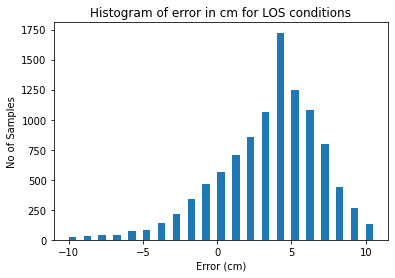

In [50]:
from matplotlib import pyplot as plt 
plt.hist(error, bins = np.arange(-10, 11, 0.5)) 
plt.title("Histogram of error in cm for LOS conditions") 
# Adjust the figure size for better resolution (optional)
#pl.figure(figsize=(10, 6))
plt.xlabel('Error (cm)')
plt.ylabel('No of Samples')
# Save the plot as a high-resolution image (e.g., PNG)
plt.savefig("histogrg.png", dpi=300, facecolor='white')

In [51]:
array_wlos = np.load('648withdbwlos.npy')
test_wlos = array_wlos[2:1002]

In [52]:
error_wlos = test_wlos -648
print(error_wlos)

[-7.  2. -6. -4. -4. -7. -5. -6. -7. -8. -6. -6. -8. -2. -4. -6. -4. -5.
 -4. -5. -7. -7. -8. -7. -7. -7. -7. -5. -6. -4. -6. -1. -5. -6. -6. -2.
 -4. -1. -4. -5. -1. -3. -7. -4. -2. -5. -1. -7. -1. -1. -5. -9. -5. -4.
 -2. -3. -4.  0. -7. -3. -4. -6. -5. -2. -6. -4. -4.  2. -6. -3. -6. -3.
 -4. -6. -5. -5. -4. -2. -1. -6. -3. -6. -4. -5. -3. -7. -3. -1.  0. -5.
 -5. -1. -5. -3. -4. -4. -2. -6. -7. -2. -4.  1. -3. -3. -5.  1. -2. -1.
 -5. -4. -5. -3. -3. -4. -5. -1. -5.  0.  0. -3. -3. -4.  0.  3. -2. -5.
 -3.  0. -4. -2. -3. -1. -8. -4. -4. -9. -2. -4. -4. -7.  0. -2.  0.  0.
 -1. -3. -5. -2. -3. -8. -5. -8. -3. -2.  0. -7.  1. -4. -3. -5. -3. -4.
 -4. -4. -4. -3. -2. -2. -4. -3. -7. -2. -6. -3. -3. -2. -3. -2. -4. -2.
 -2. -5. -2. -4. -5. -4. -4. -4. -3. -4. -3. -1. -4. -3.  0. -2.  0. -1.
  0. -6. -4. -1. -6. -1. -5. -4. -5. -3. -5. -4. -5. -8. -1.  0. -3. -7.
 -3. -1. -5. -2. -3. -1. -2. -3. -3. -2. -3. -5. -1. -3. -5. -3. -2.  1.
 -1. -2. -4.  2.  2. -2. -3. -4. -2. -5. -3. -6. -2

In [53]:
err_wlos = np.abs(error_wlos)

In [54]:
mae = np.mean(err_wlos)
print(mae)

3.021


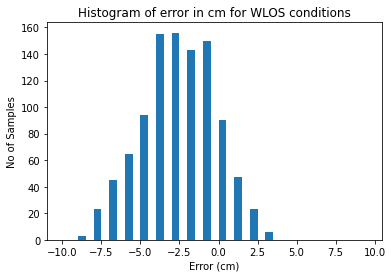

In [55]:
from matplotlib import pyplot as plt 
plt.hist(error_wlos, bins = np.arange(-10, 10, 0.5)) 
plt.title("Histogram of error in cm for WLOS conditions") 
# Adjust the figure size for better resolution (optional)
#pl.figure(figsize=(10, 6))
plt.xlabel('Error (cm)')
plt.ylabel('No of Samples')
# Save the plot as a high-resolution image (e.g., PNG)
plt.savefig("histogramwlos.png", dpi=300, facecolor='white')

In [56]:
print(np.std(error_wlos))

2.3610588726247386


In [57]:
nlos_array = np.load('232withdbnlos.npy')
print(nlos_array.size)

575


In [58]:
testnlos = nlos_array[5:505]

In [60]:
errornlos = testnlos - 232
print(errornlos)

[398. 408. 414. 413. 380. 378. 411. 409. 407. 403. 400. 407. 408. 409.
 408. 409. 410. 406. 408. 410. 410. 404. 408. 411. 409. 410. 410. 408.
 409. 412. 414. 411. 405. 405. 411. 406. 406. 412. 410. 408. 409. 408.
 411. 405. 402. 408. 412. 408. 410. 408. 408. 408. 407. 411. 410. 410.
 412. 414. 408. 409. 408. 402. 410. 407. 408. 409. 406. 409. 408. 412.
 408. 410. 410. 409. 406. 406. 407. 411. 413. 407. 409. 411. 406. 408.
 408. 416. 409. 411. 409. 409. 406. 408. 411. 409. 414. 409. 408. 409.
 409. 407. 412. 414. 402. 408. 409. 406. 413. 411. 411. 407. 406. 409.
 411. 413. 411. 413. 406. 406. 410. 416. 407. 411. 410. 408. 412. 402.
 409. 410. 404. 410. 222.  37. 239.  36.  33. 113.  66. 405. 388.  49.
 407.  39. 365.  33.  51.  44.  39. 197.  44.  40.  44.  38.  41.  42.
  41. 217.  44.  41.  39. 210.  38. 387.  36.  39.  43.  37. 216. 380.
 353. 200.  38. 365. 226. 217.  39.  36. 215.  38.  36.  36.  40.  39.
 214.  35.  39.  38.  36.  45.  39. 201. 218.  34.  36.  38.  43.  43.
  38. 

In [61]:
np.mean(np.abs(errornlos))

220.724

In [62]:
np.std((errornlos))

137.5428508647396

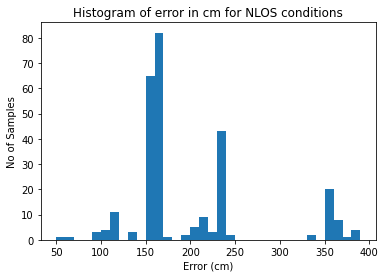

In [63]:
from matplotlib import pyplot as plt 
plt.hist(errornlos, bins = np.arange(50, 400, 10)) 
plt.title("Histogram of error in cm for NLOS conditions") 
# Adjust the figure size for better resolution (optional)
#pl.figure(figsize=(10, 6))
plt.xlabel('Error (cm)')
plt.ylabel('No of Samples')
# Save the plot as a high-resolution image (e.g., PNG)
plt.savefig("histogramnlos.png", dpi=300, facecolor='white')